## ICR - Identifying Age-Related Conditions - EDA

## 1. Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
competition_dataset = Path('/kaggle/input/icr-identify-age-related-conditions')

In [3]:
def visualize_categorical_column_counts(df, column):

    """
    Visualize value counts of given categorical column in given dataframe
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given column
        
    column: str
        Name of the categorical column
    """

    fig, ax = plt.subplots(figsize=(24, df[column].value_counts().shape[0] + 4), dpi=100)
    sns.barplot(
        y=df[column].value_counts().values,
        x=df[column].value_counts().index,
        color='tab:blue',
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([
        f'{x} ({value_count:,})' for value_count, x in zip(
            df[column].value_counts().values,
            df[column].value_counts().index
        )
    ])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(f'Counts {column}', size=20, pad=15)
    plt.show()
    

def visualize_continuous_data_histogram(df, column, log_scale=False):

    """
    Visualize histogram of given continuous column in given dataframe
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given column
        
    column: str
        Name of the continuous column
        
    log_scale: bool
        Whether or not to do log transform on data
    """

    fig, ax = plt.subplots(figsize=(24, 6), dpi=100)
    x = df[column]
    if log_scale:
        x = np.log(x)
    sns.histplot(x, fill=True, log_scale=False, ax=ax)
    ax.tick_params(axis='x', labelsize=12.5)
    ax.tick_params(axis='y', labelsize=12.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    title = f'''
    {column}
    Mean: {df[column].mean():.2f}
    Median: {df[column].median():.2f}
    Std: {df[column].std():.2f}
    Min: {df[column].min():.2f}
    Max: {df[column].max():.2f}
    '''
    ax.set_title(title, size=20, pad=12.5)
    plt.show()

    
def visualize_timeseries(df, time_column, value_column):

    """
    Visualize time series values of given column
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given time_column and value_column
        
    time_column: str
        Name of the time column
        
    value_column: str
        Name of the value column
    """

    fig, ax = plt.subplots(figsize=(24, 6), dpi=100)
    ax.plot(df.set_index(time_column)[value_column], '-', linewidth=1.5, alpha=1)
    ax.tick_params(axis='y', labelsize=15, pad=12.5)
    ax.tick_params(axis='x', labelsize=15, pad=12.5)
    ax.set_title(f'{value_column} x Date ({time_column})', size=20, pad=15)
    plt.show()


## 2. Introduction

The goal of this competition is predicting three age-related conditions using measurements of 56 anonymized health characteristics. There are **617** rows in training set and roughly **400** rows in hidden test set.

Columns in training and test set are:

* `Id`: Unique identifier of the row
* `AB` - `GL`: 56 anonymized health characteristics
* `Class`: Whether the subject has been diagnosed with one of the three age-related conditions or not

In [4]:
df_train = pd.read_csv(competition_dataset / 'train.csv')
print(f'Training Dataset Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Dataset Shape: (617, 58) - Memory Usage: 0.27 MB


Greeks is the supplemental metadata that is only available for the training set. It is also anonymized like the health characteristics in training and test sets.

Columns in greeks are:

* `Id`: Unique identifier of the row
* `Alpha`: Three age-related conditions
  * `A`: No age-related condition **(Class 0)**
  * `B`, `D`, `G`: The three age-related conditions **(Class 1)**
* `Beta`, `Gamma`, `Delta`: Experimental characteristics
* `Epsilon`: Date of the subject

In [5]:
df_greeks = pd.read_csv(competition_dataset / 'greeks.csv')
print(f'Greeks Shape: {df_greeks.shape} - Memory Usage: {df_greeks.memory_usage().sum() / 1024 ** 2:.2f} MB')

Greeks Shape: (617, 6) - Memory Usage: 0.03 MB


Training set and greeks can be merged on `Id` column.

In [6]:
df_train = df_train.merge(df_greeks, on='Id', how='left')
del df_greeks

In [7]:
df_train

Id        AB          AF          AH          AM         AR  \
0    000ff2bfdfe9  0.209377  3109.03329   85.200147   22.394407   8.138688   
1    007255e47698  0.145282   978.76416   85.200147   36.968889   8.138688   
2    013f2bd269f5  0.470030  2635.10654   85.200147   32.360553   8.138688   
3    043ac50845d5  0.252107  3819.65177  120.201618   77.112203   8.138688   
4    044fb8a146ec  0.380297  3733.04844   85.200147   14.103738   8.138688   
..            ...       ...         ...         ...         ...        ...   
612  fd3dafe738fd  0.149555  3130.05946  123.763599    9.513984  13.020852   
613  fd895603f071  0.435846  5462.03438   85.200147   46.551007  15.973224   
614  fd8ef6377f76  0.427300  2459.10720  130.138587   55.355778  10.005552   
615  fe1942975e40  0.363205  1263.53524   85.200147   23.685856   8.138688   
616  ffcca4ded3bb  0.482849  2672.53426  546.663930  112.006102   8.138688   

           AX        AY         AZ          BC  ...            GF         GH  \
0    0.699861  0.025578   9.812214    5.555634  ...   2003.810319  22.136229   
1    3.632190  0.025578  13.517790    1.229900  ...  27981.562750  29.135430   
2    6.732840  0.025578  12.824570    1.229900  ...  13676.957810  28.022851   
3    3.685344  0.025578  11.053708    1.229900  ...   2094.262452  39.948656   
4    3.942255  0.054810   3.396778  102.151980  ...   8524.370502  45.381316   
..        ...       ...        ...         ...  ...           ...        ...   
612  3.499305  0.077343   8.545512    2.804172  ...   8095.932828  24.640462   
613  5.979825  0.025882  12.622906    3.777550  ...   3085.308063  29.648928   
614  8.070549  0.025578  15.408390    1.229900  ...   6474.652866  26.166072   
615  7.981959  0.025578   7.524588    1.229900  ...   1965.343176  25.116750   
616  3.198099  0.116928   3.396778    7.948668  ...   6850.484442  45.745974   

             GI         GL  Class  Alpha  Beta  Gamma  Delta    Epsilon  
0     69.834944   0.120343      1      B     C      G      D  3/19/2019  
1     32.131996  21.978000      0      A     C      M      B    Unknown  
2     35.192676   0.196941      0      A     C      M      B    Unknown  
3     90.493248   0.155829      0      A     C      M      B    Unknown  
4     36.262628   0.096614      1      D     B      F      B  3/25/2020  
..          ...        ...    ...    ...   ...    ...    ...        ...  
612   69.191944  21.978000      0      A     B      M      B  9/13/2020  
613  124.808872   0.145340      0      A     B      M      B   9/8/2020  
614  119.559420  21.978000      0      A     C      M      B  7/24/2019  
615   37.155112   0.184622      0      A     C      M      B  1/31/2019  
616  114.842372  21.978000      0      A     C      M      B    Unknown  

[617 rows x 63 columns]

## 3. Missing Values

7 of the health characteristics have very few (1-3) missing values and some of the missing values are dependent to each other in those columns. `BQ` and `EL` have the highest number of missing values (60) and it looks like their missing values are dependent to each other as well.

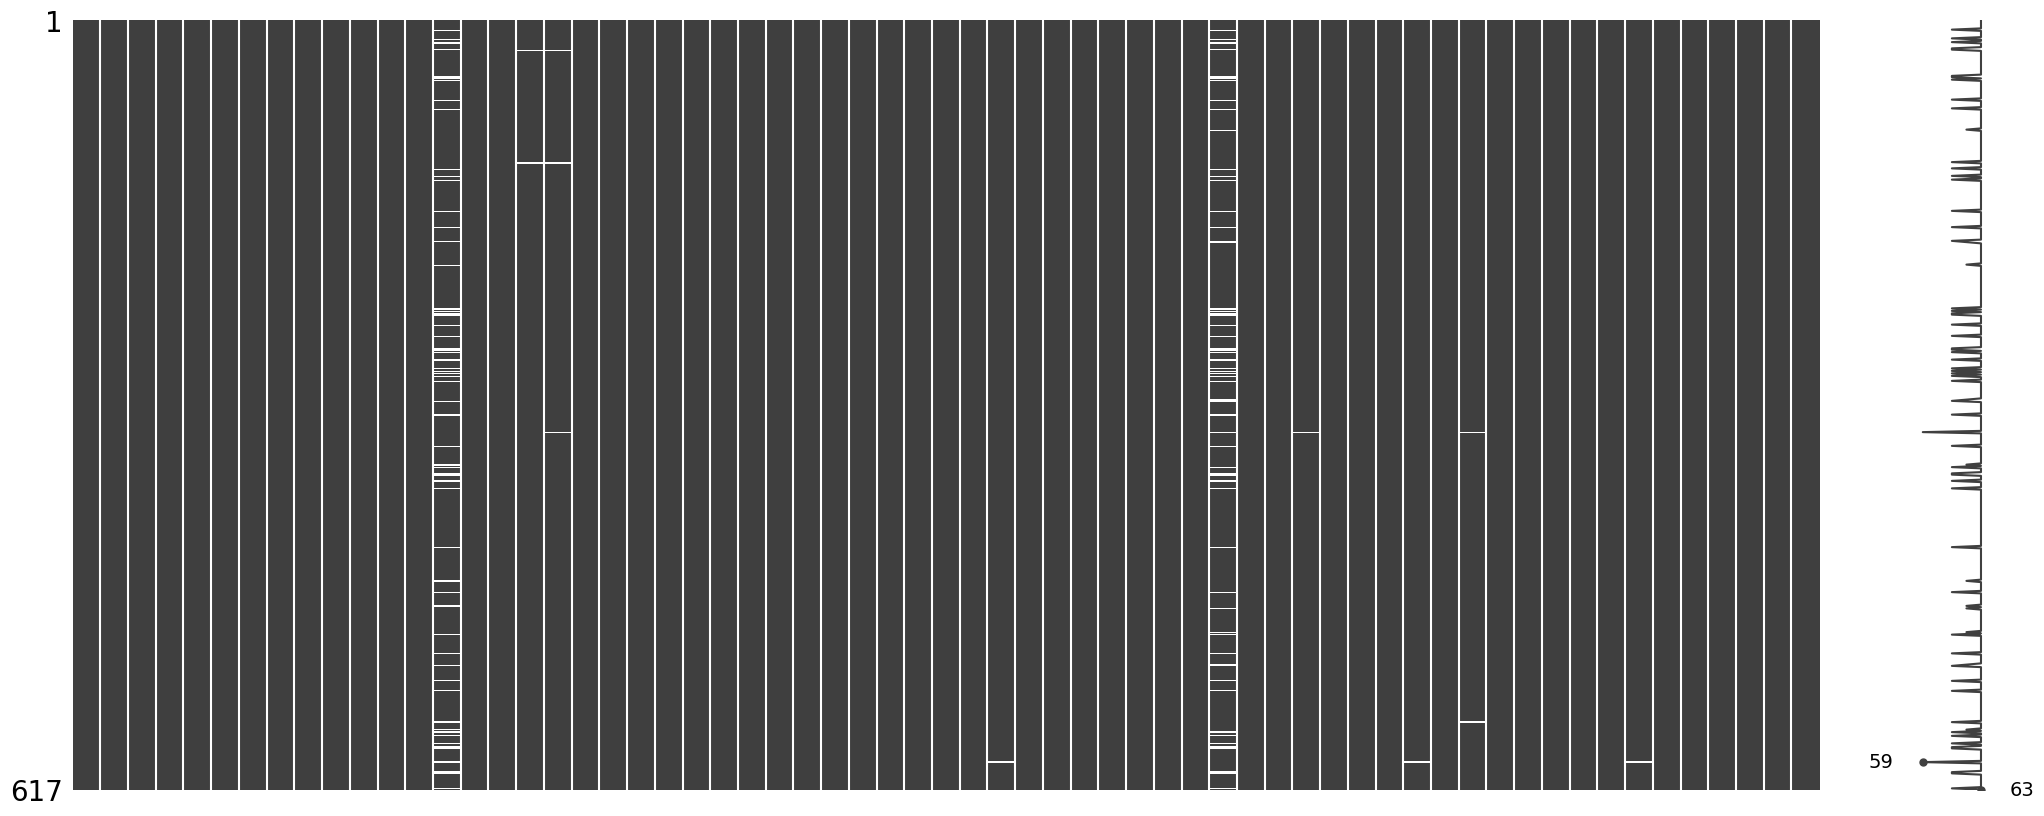

In [8]:
msno.matrix(df_train)
plt.show()

Missing value dependencies are clearly noticeable on the visualization below.

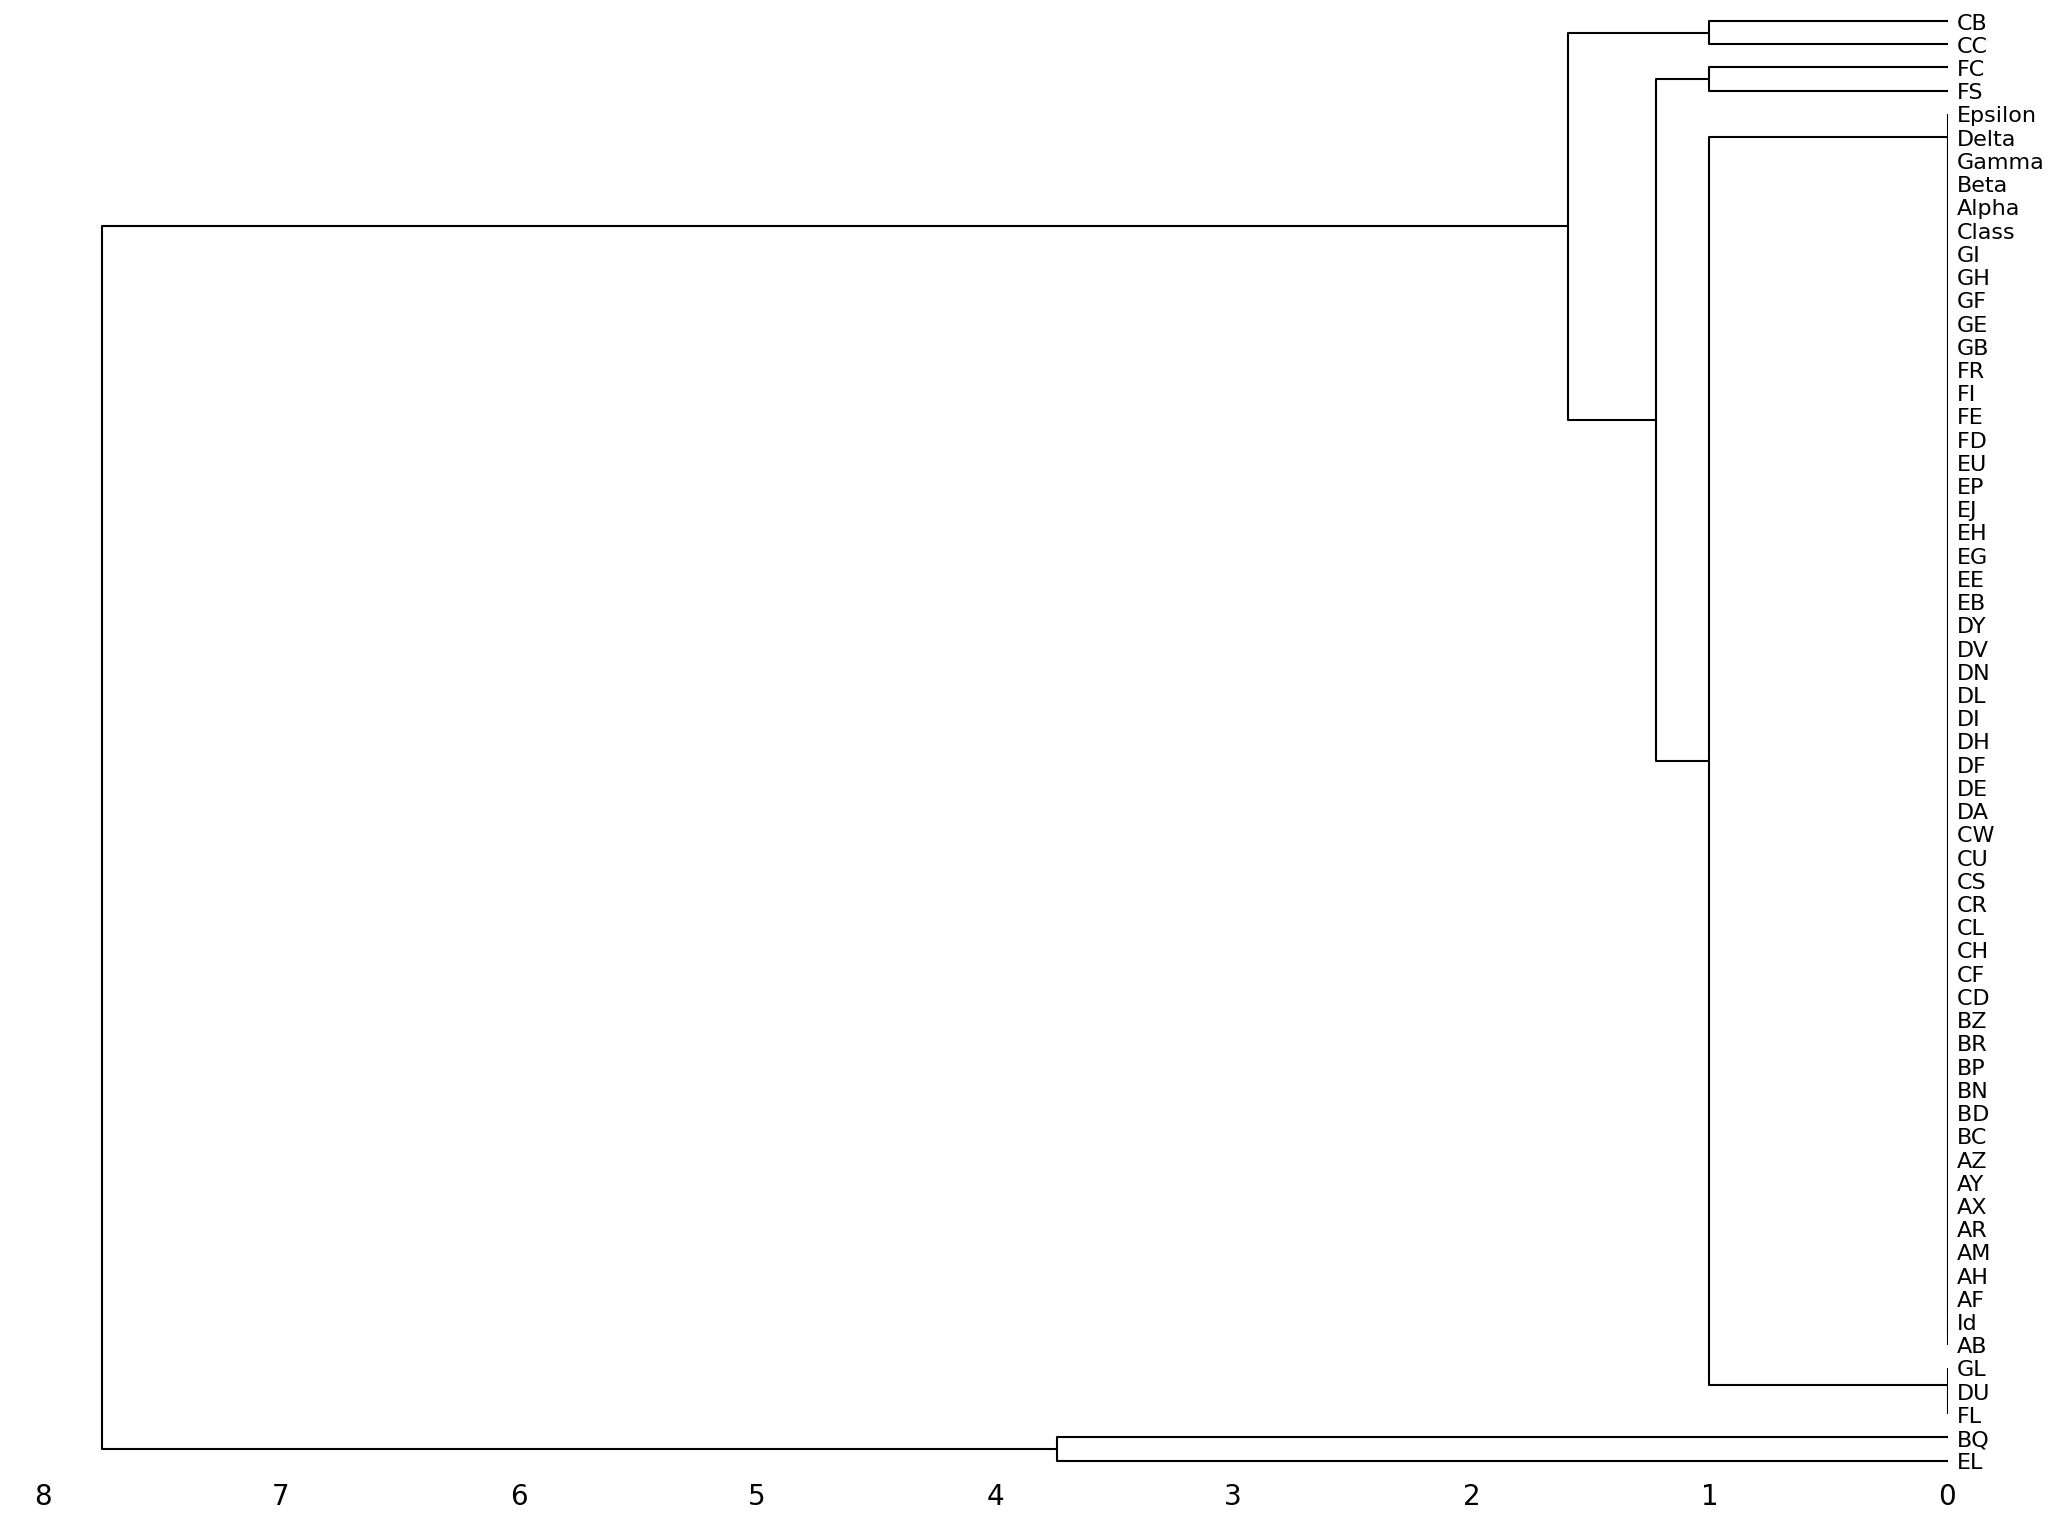

In [9]:
msno.dendrogram(df_train)
plt.show()

## 4. Targets

Essentially the binary target column is `Class` however `Alpha` is the multi-class version of it. That's why count of `A` in `Alpha` column is same as count of `0` in `Class` column and sum of `B`, `C`, `D` counts in `Alpha` column is same as count of `1` in `Class` column.

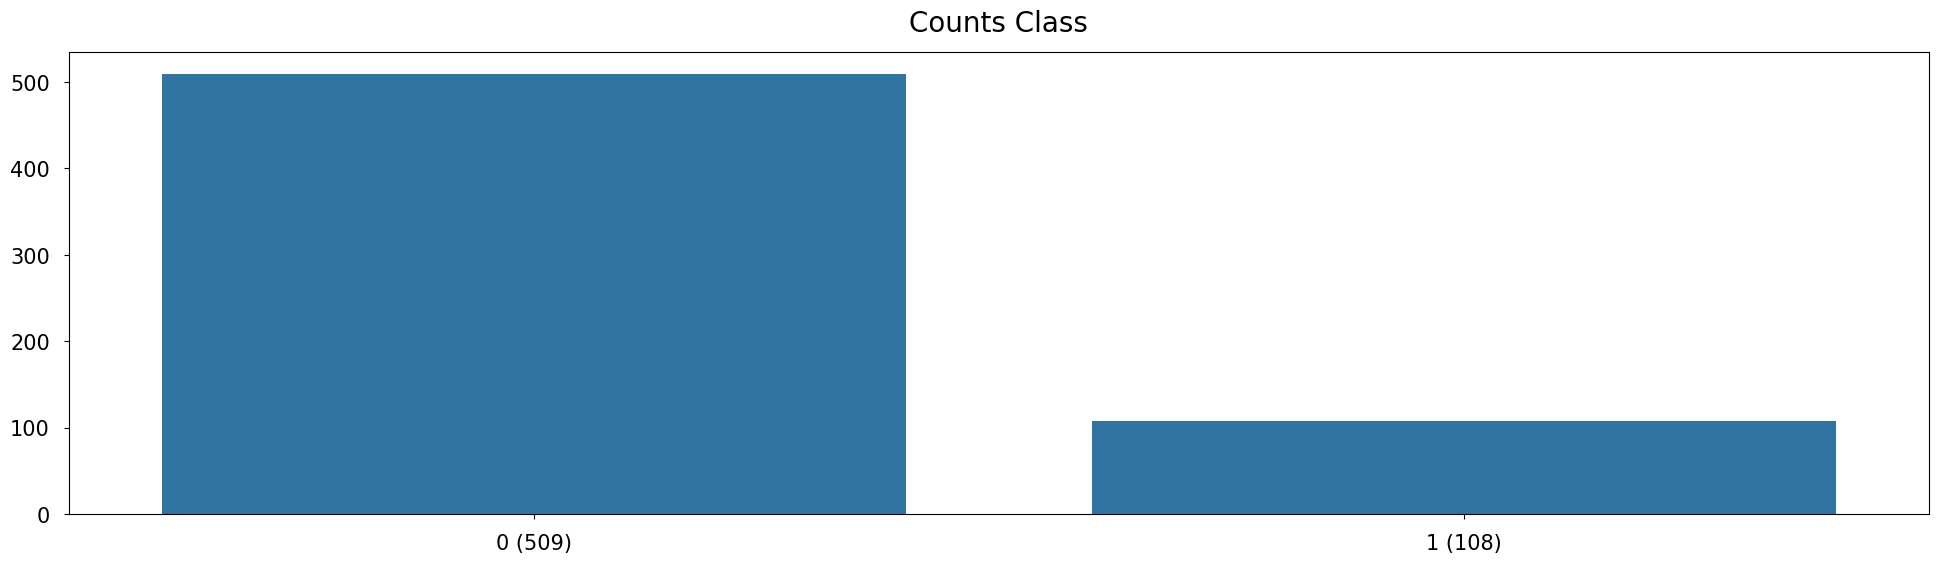

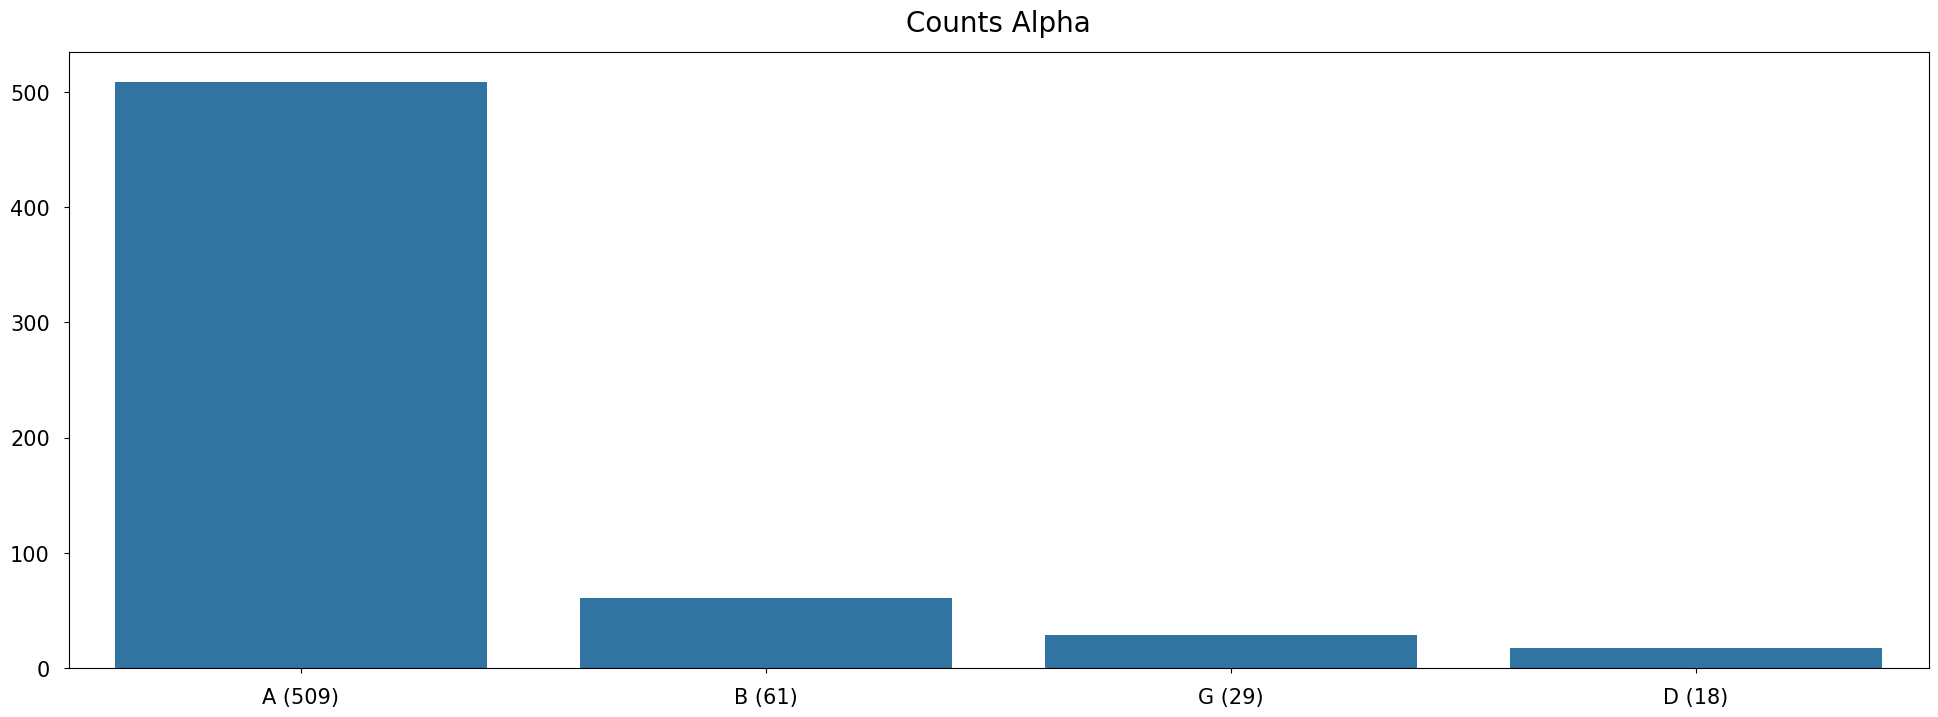

In [10]:
visualize_categorical_column_counts(df=df_train, column='Class')
visualize_categorical_column_counts(df=df_train, column='Alpha')

## 5. Continuous Health Characteristics

Histograms of continuous health characteristics are visualized below.

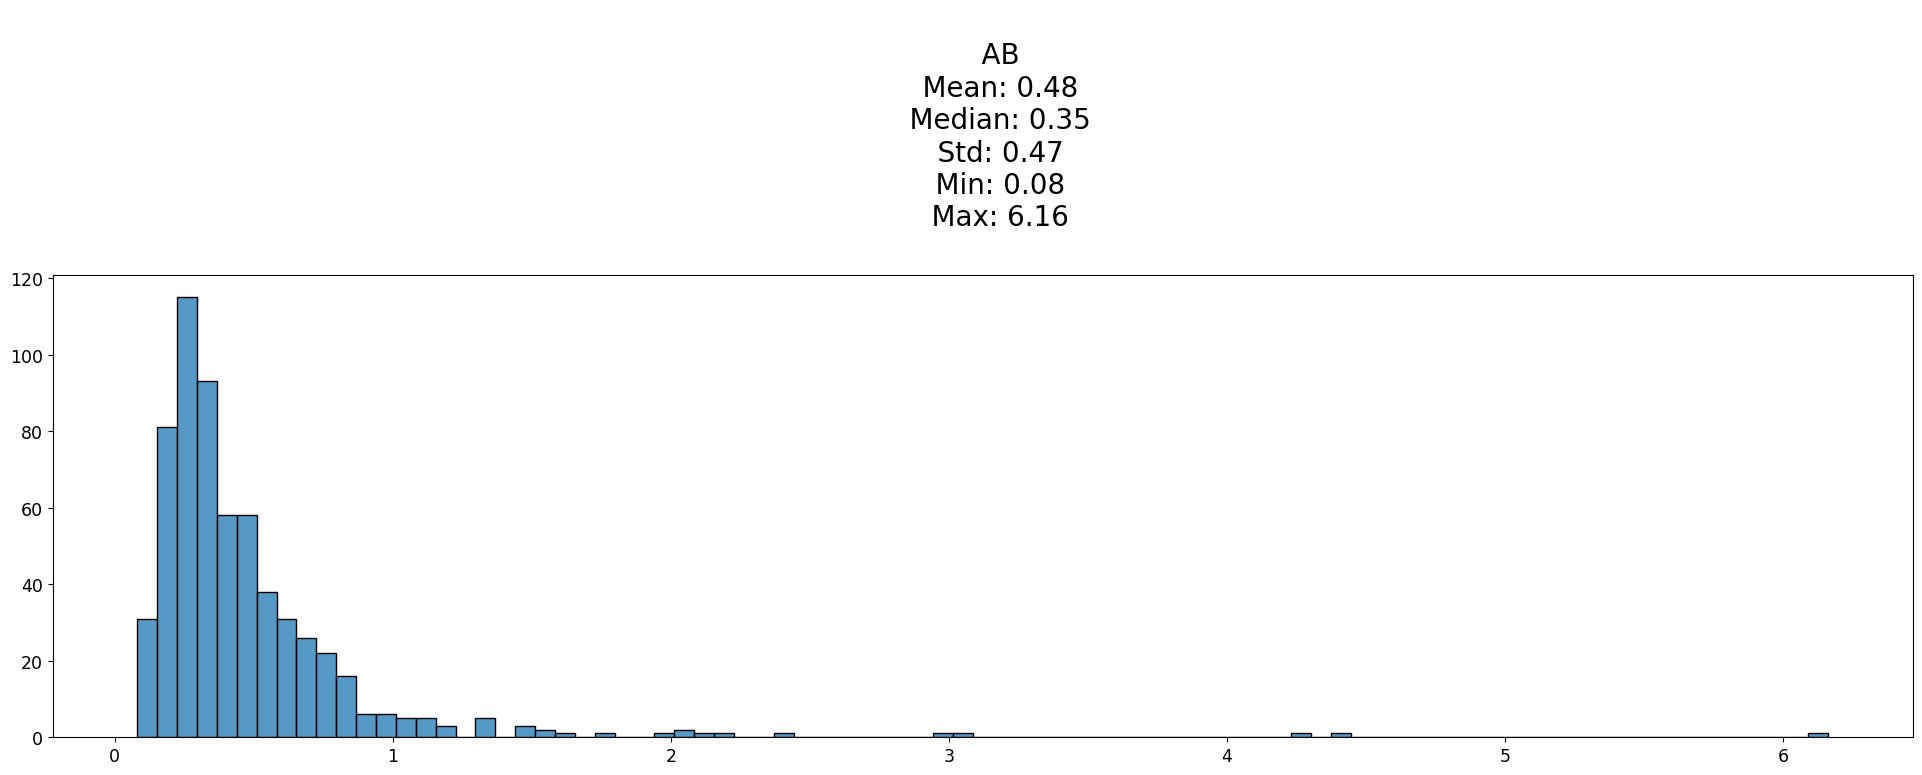

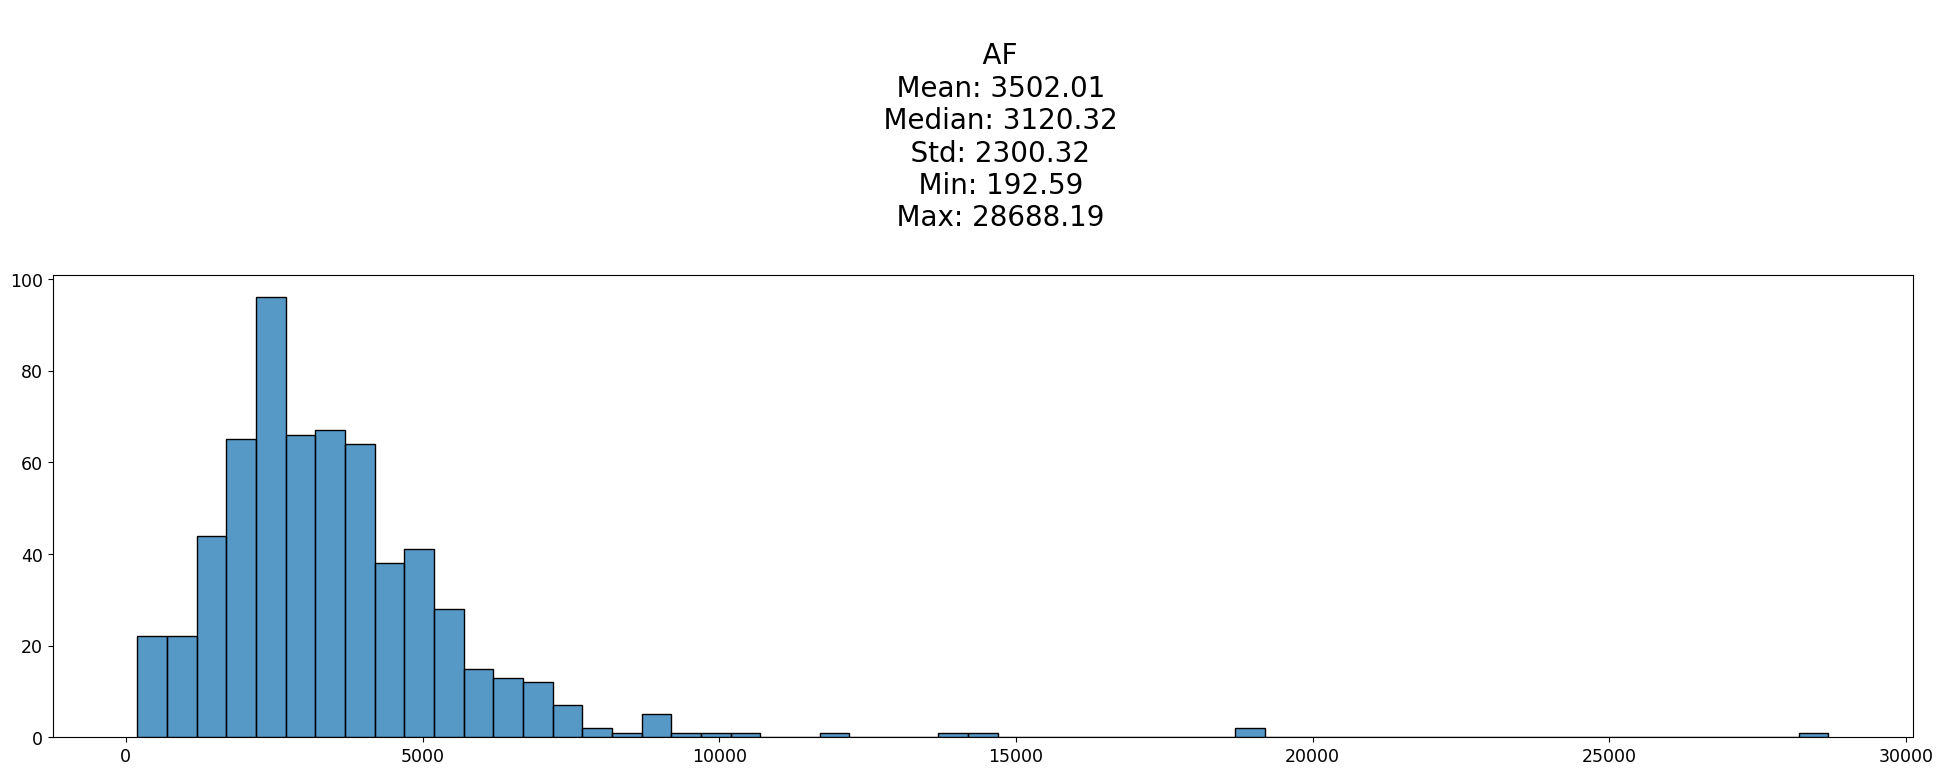

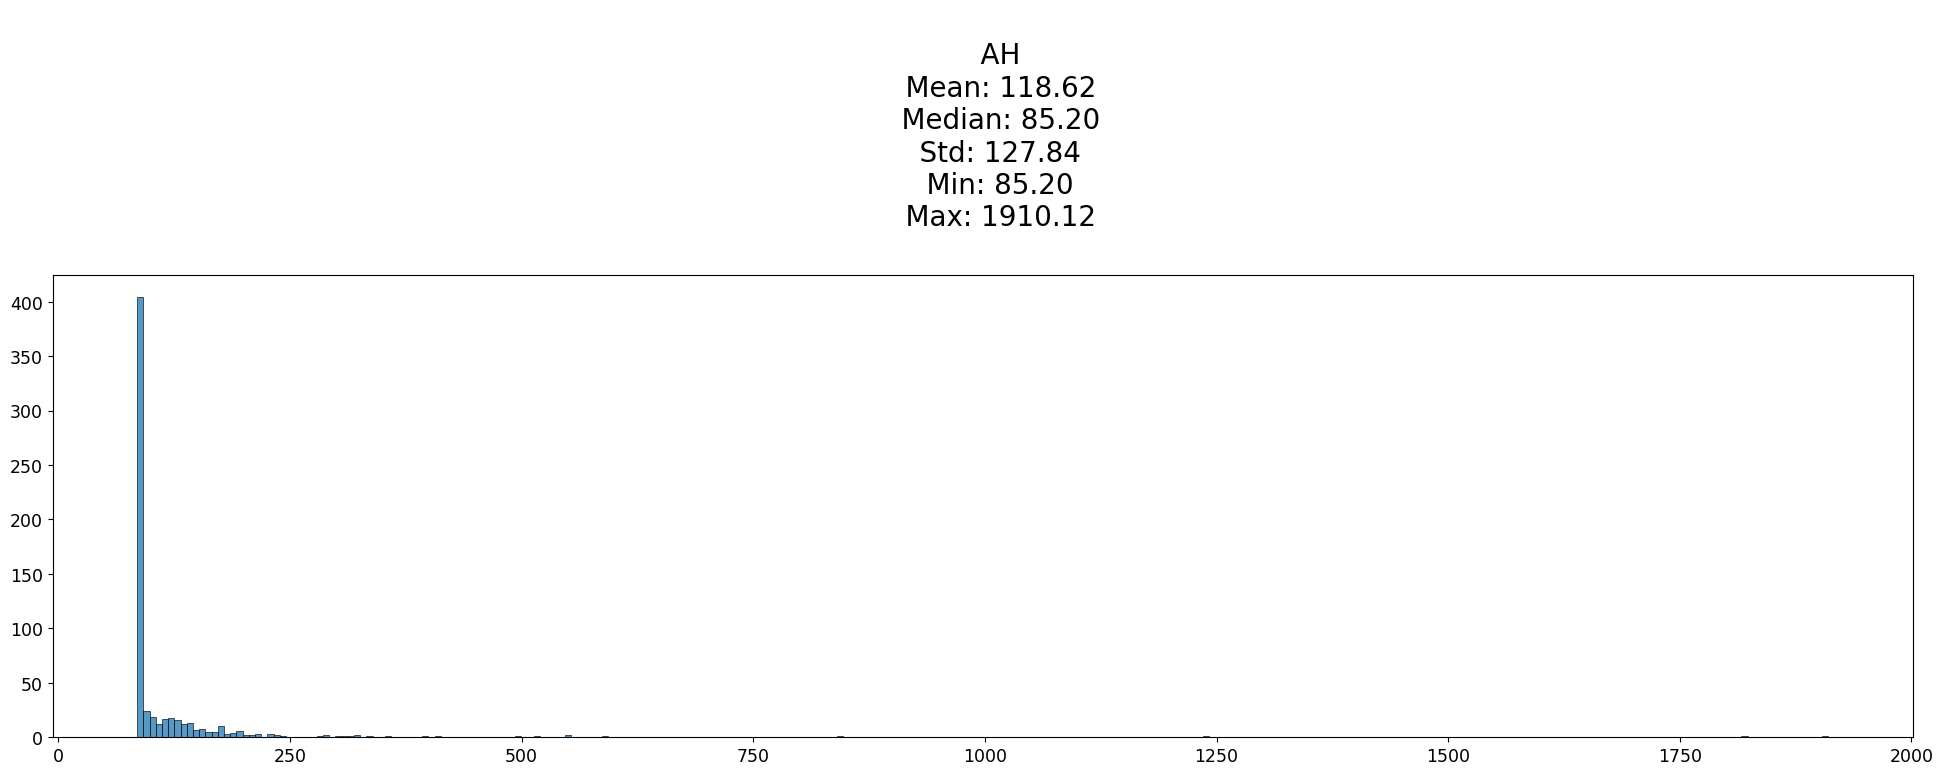

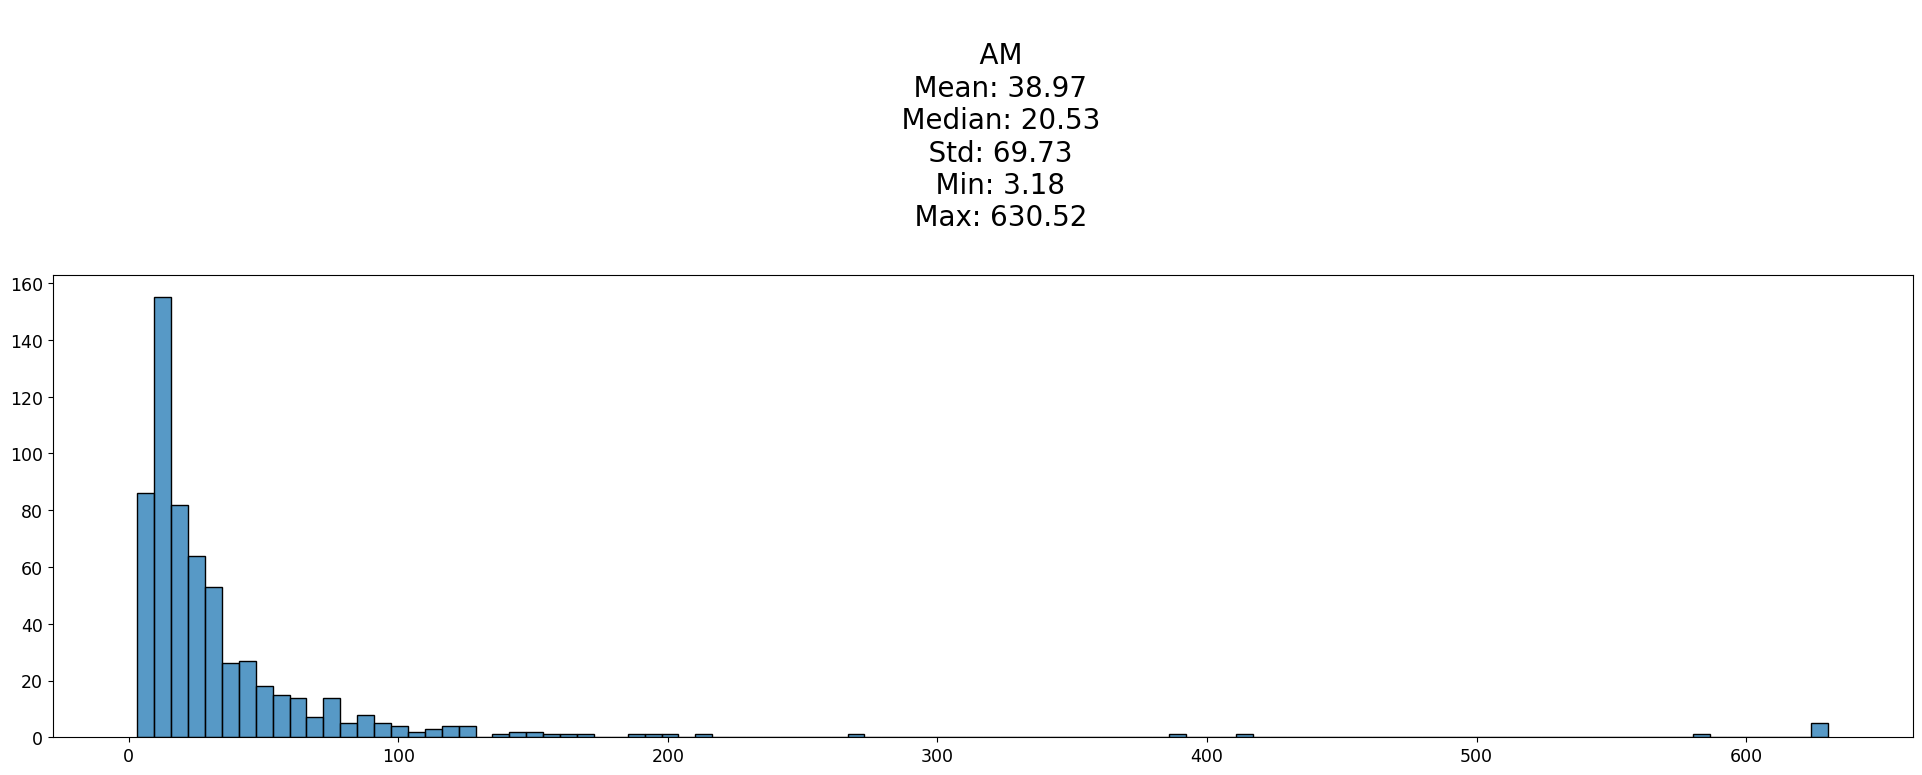

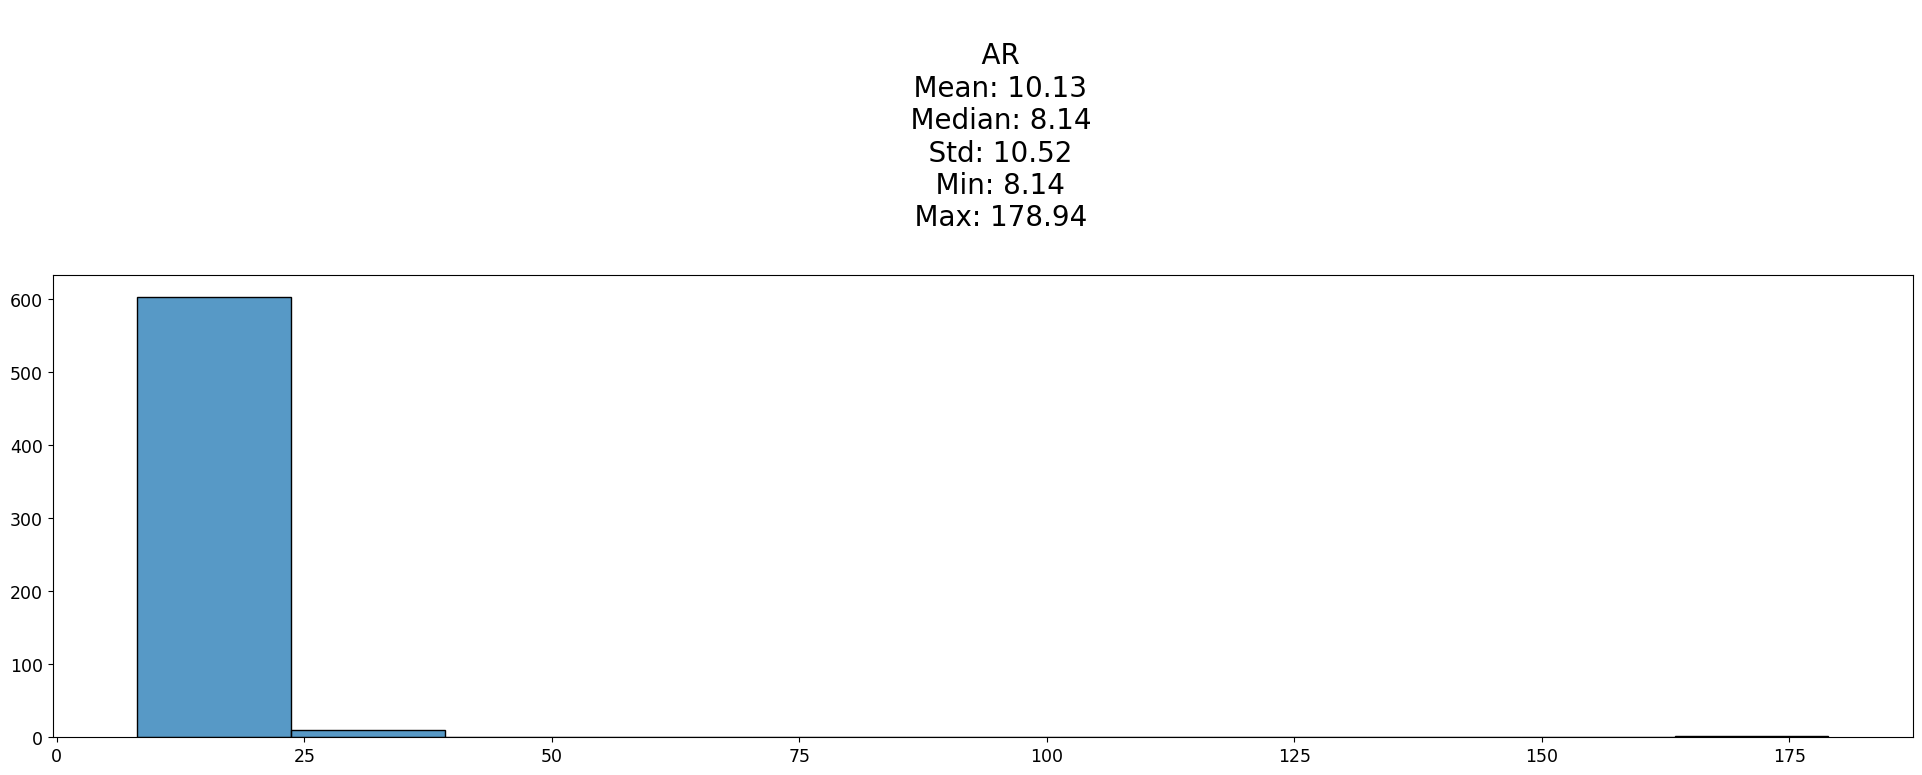

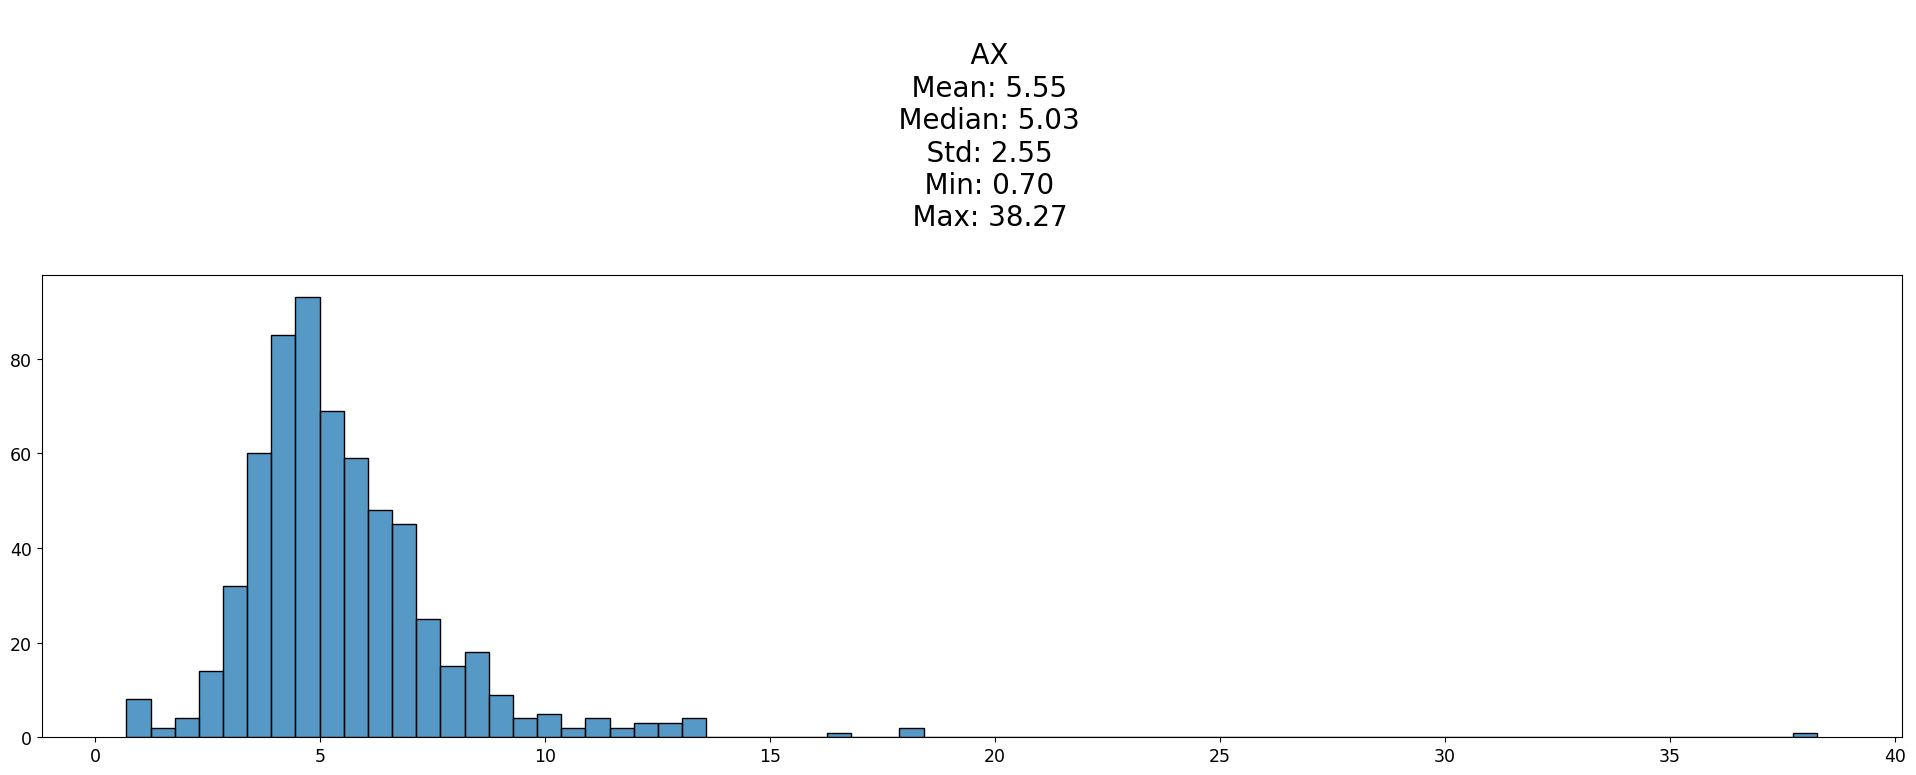

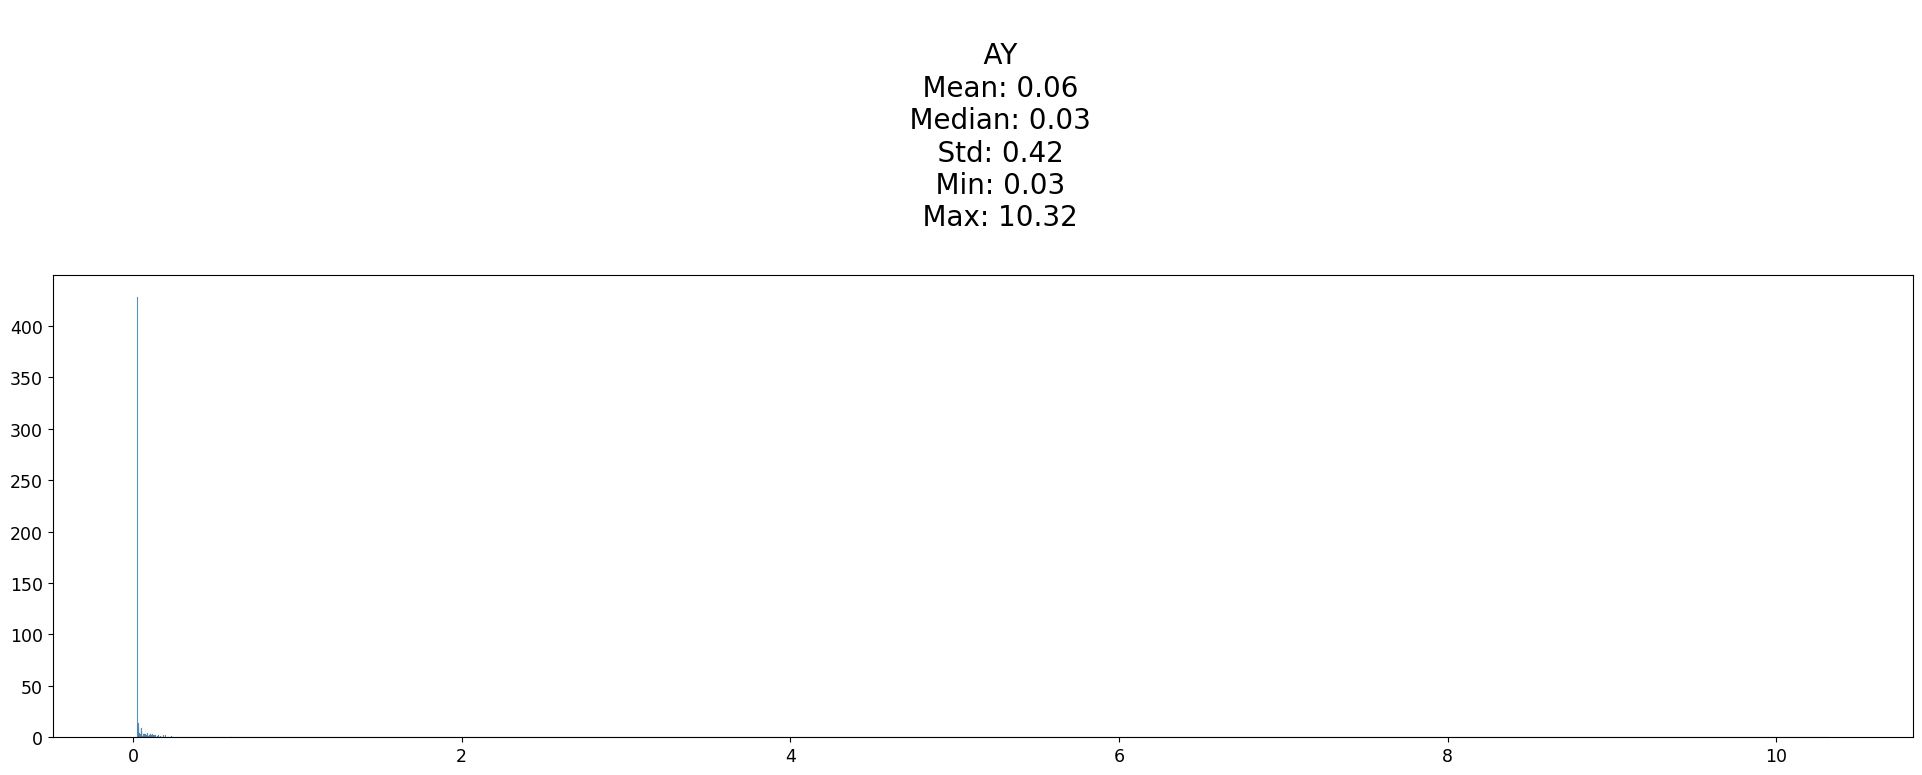

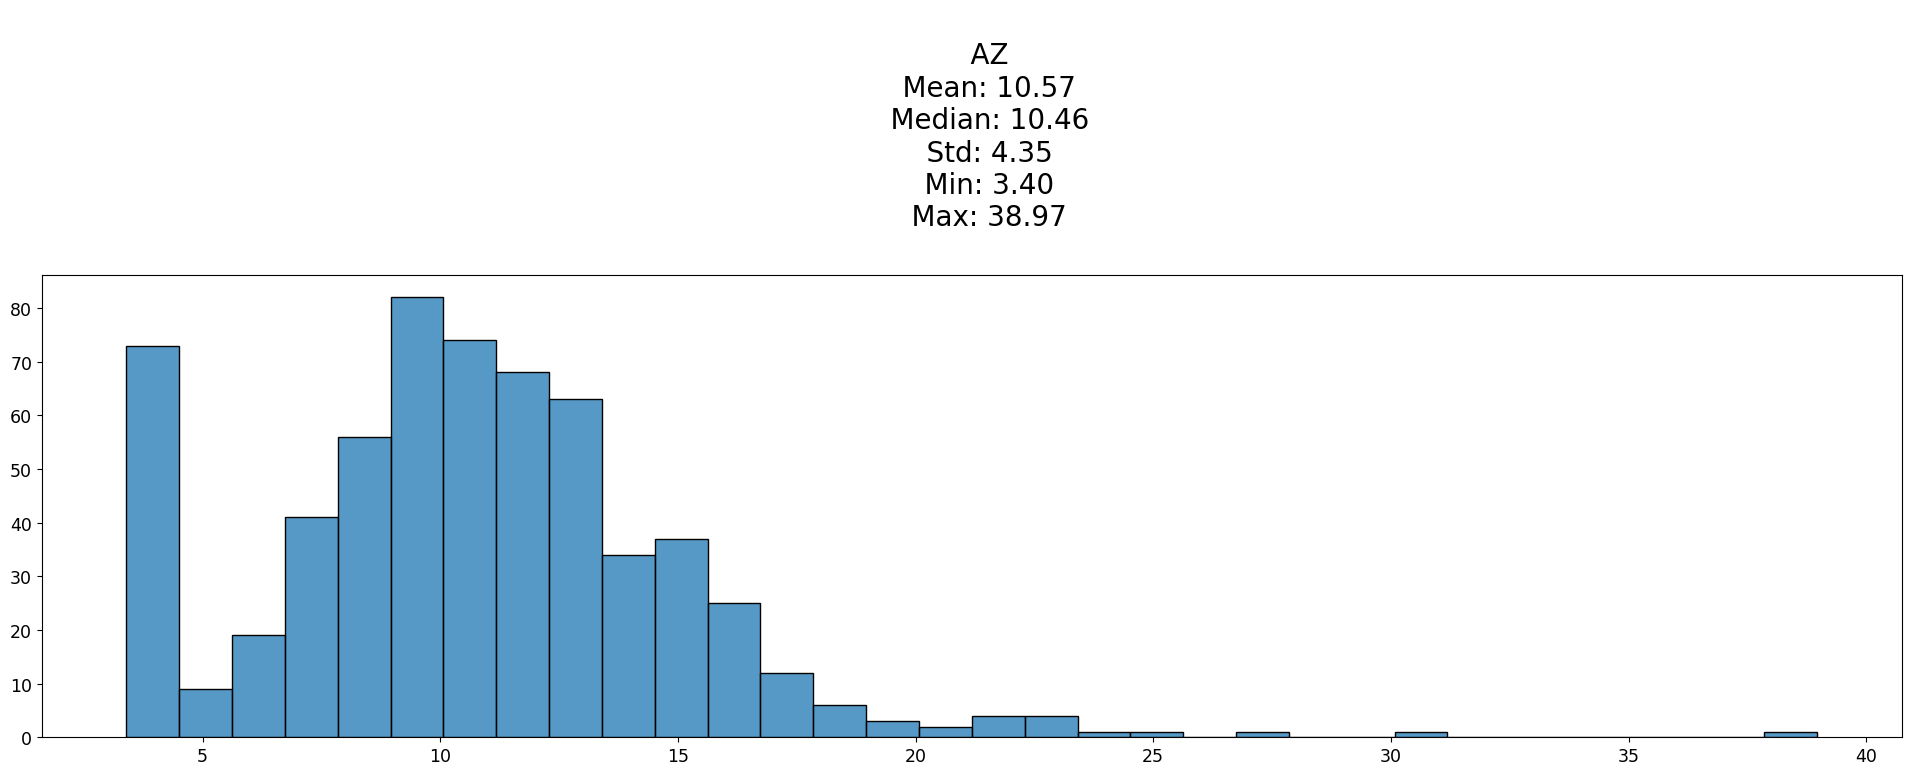

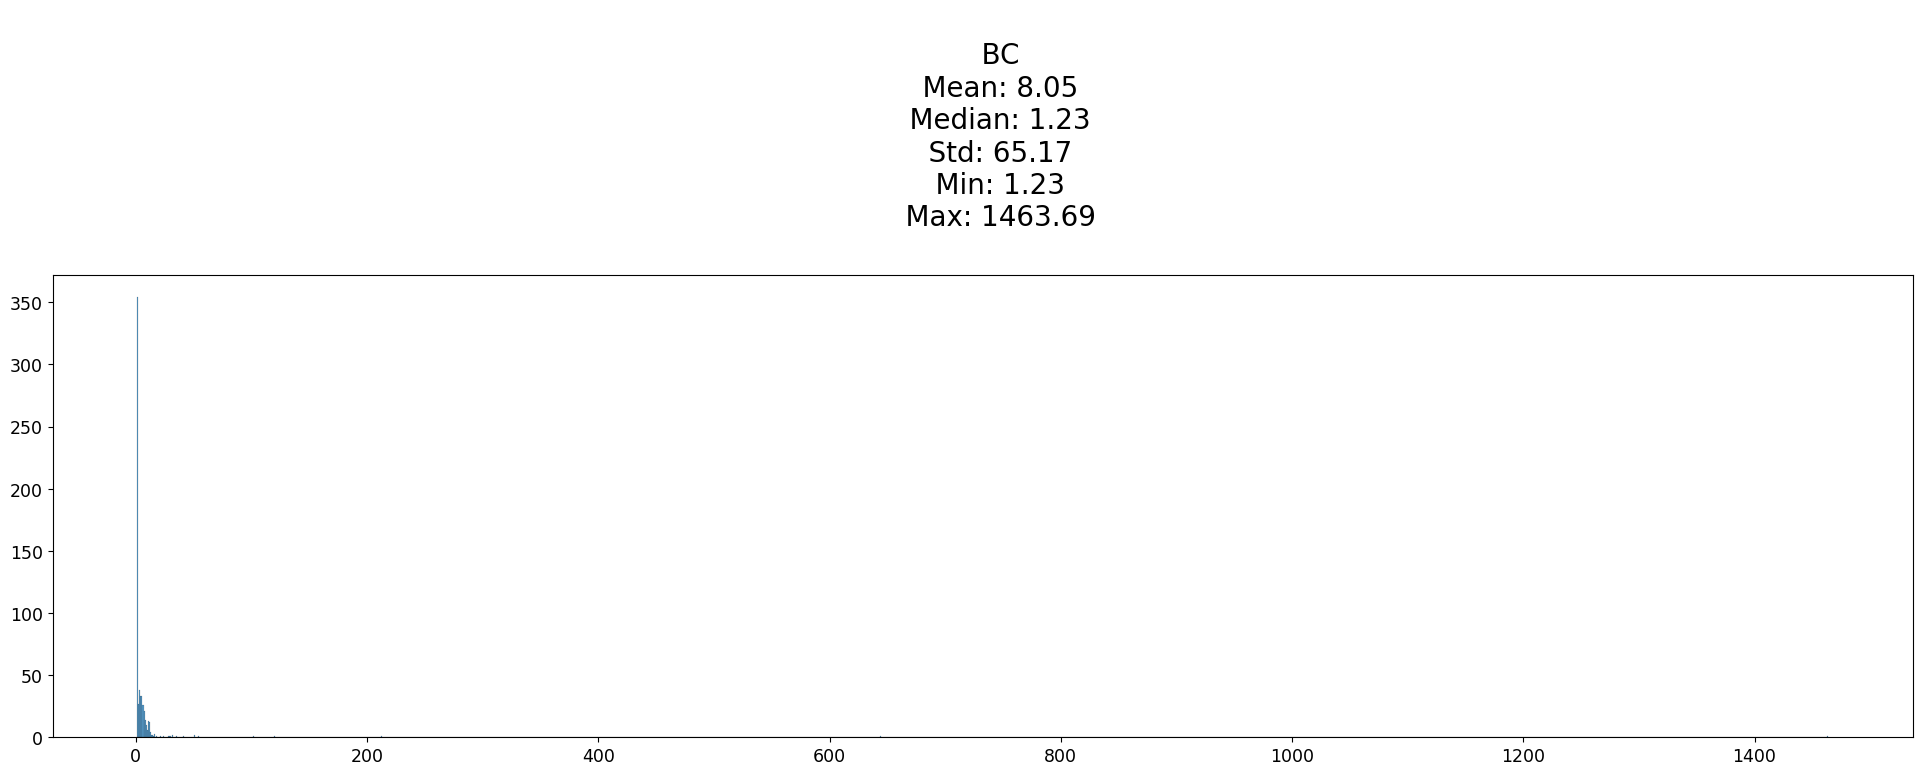

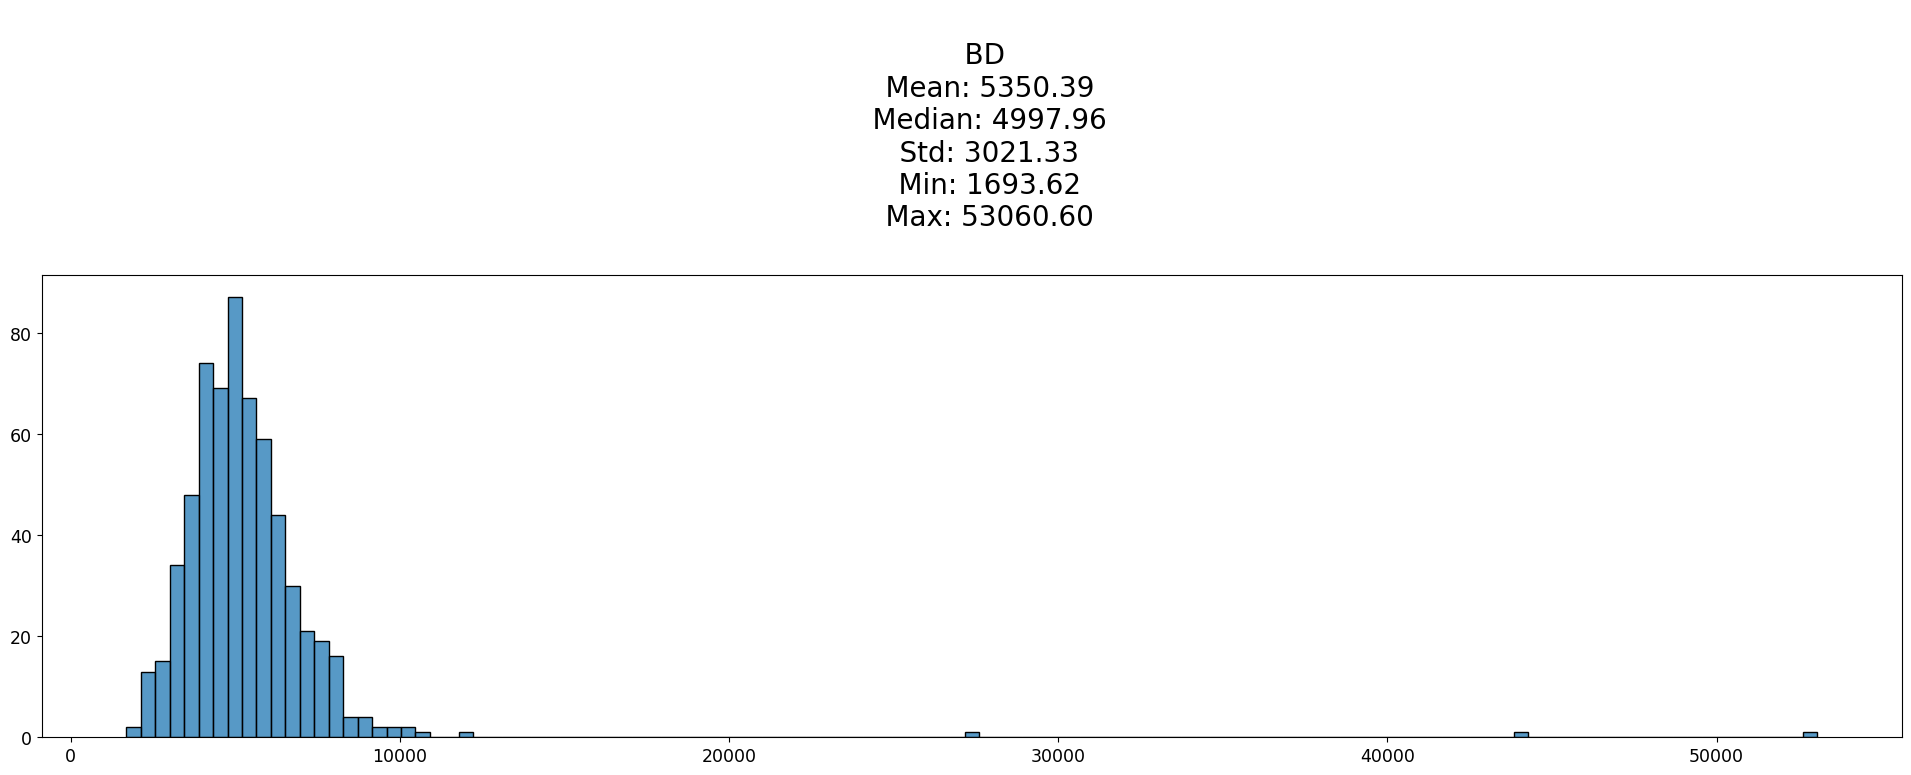

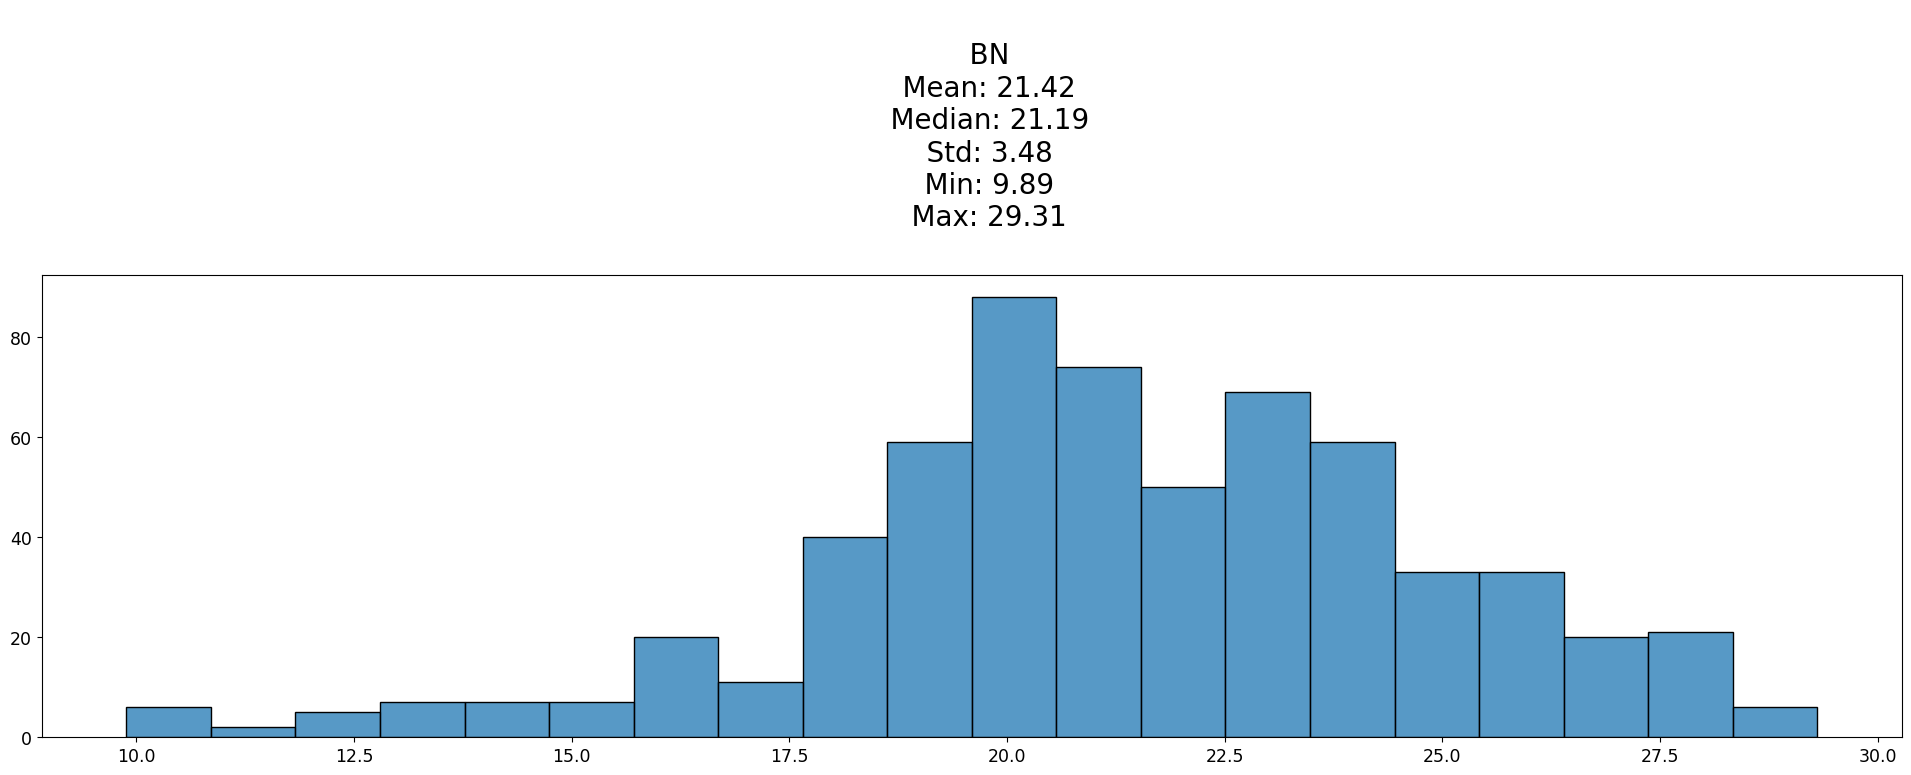

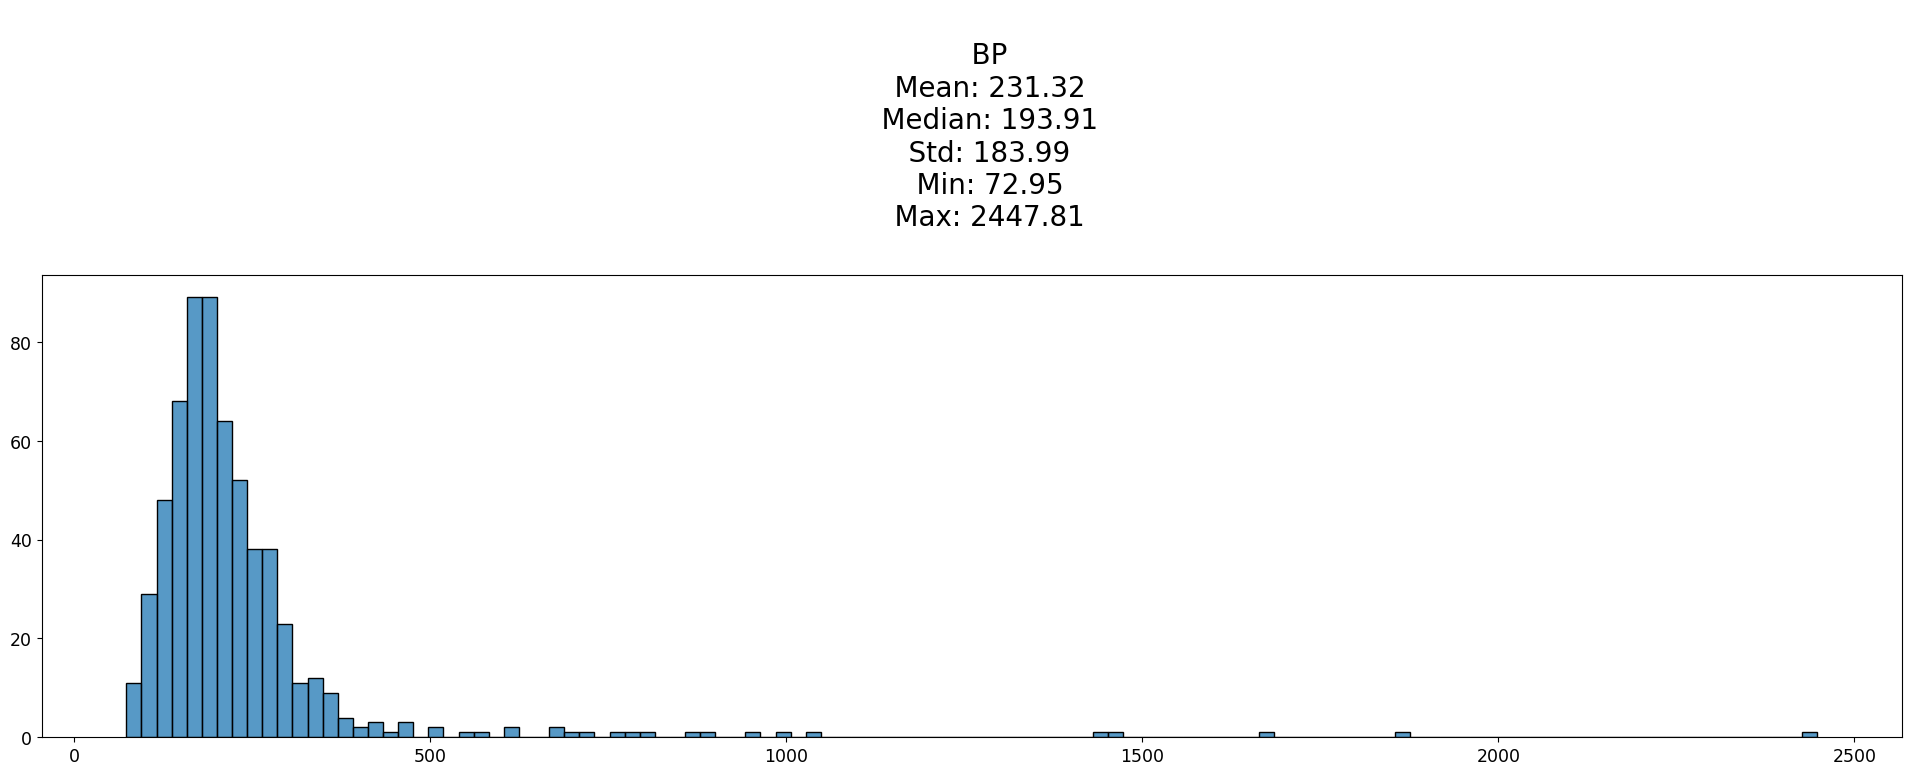

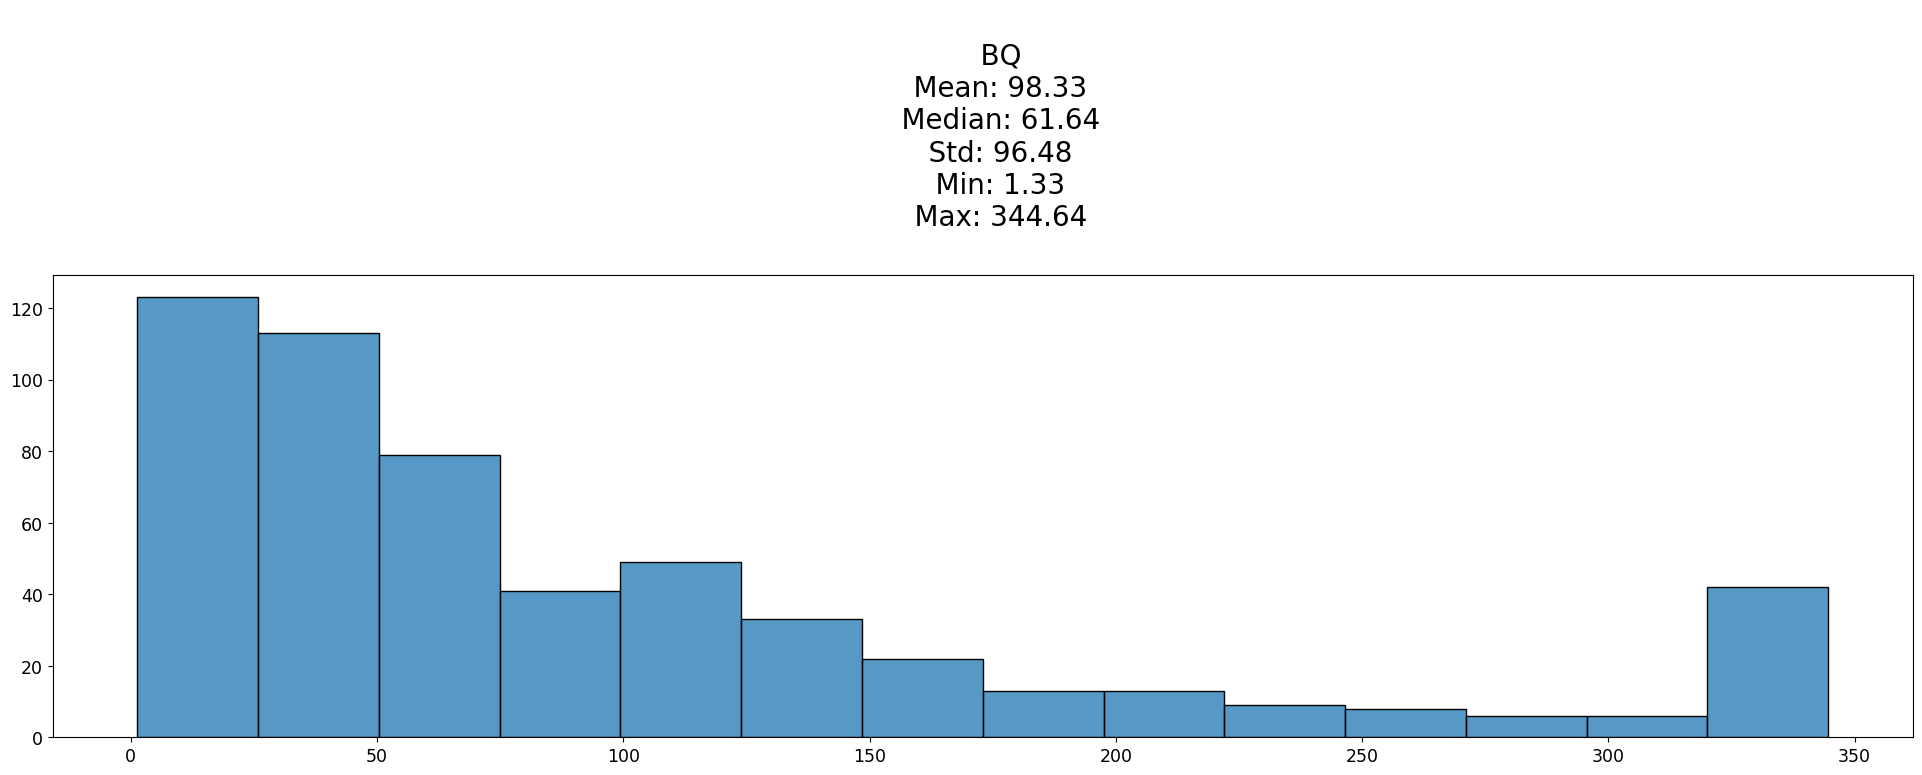

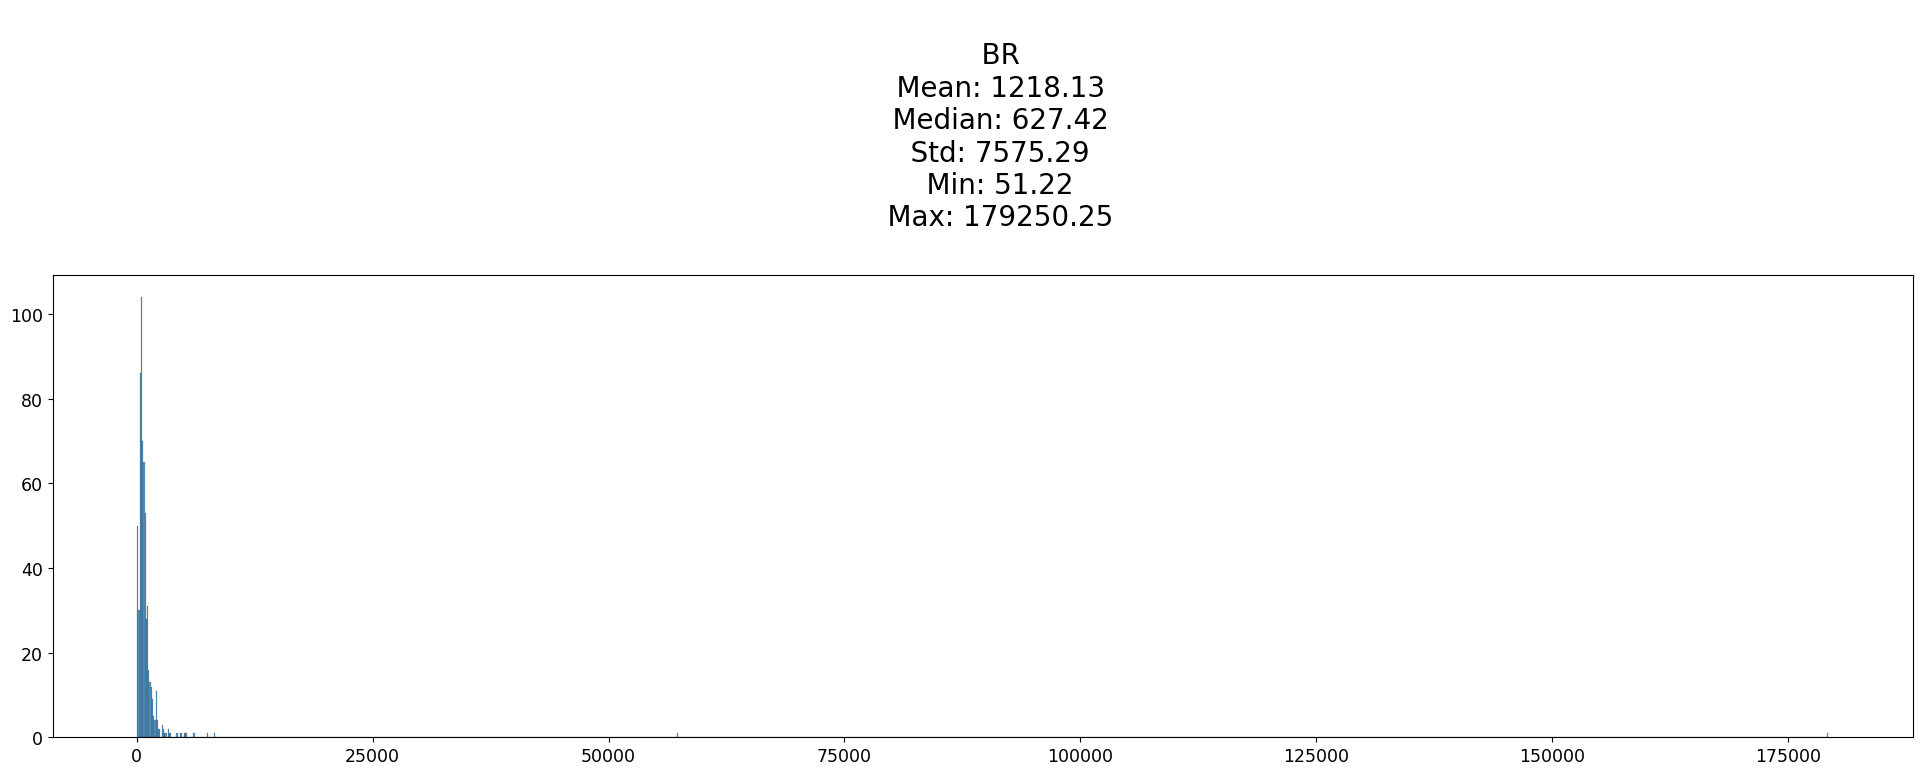

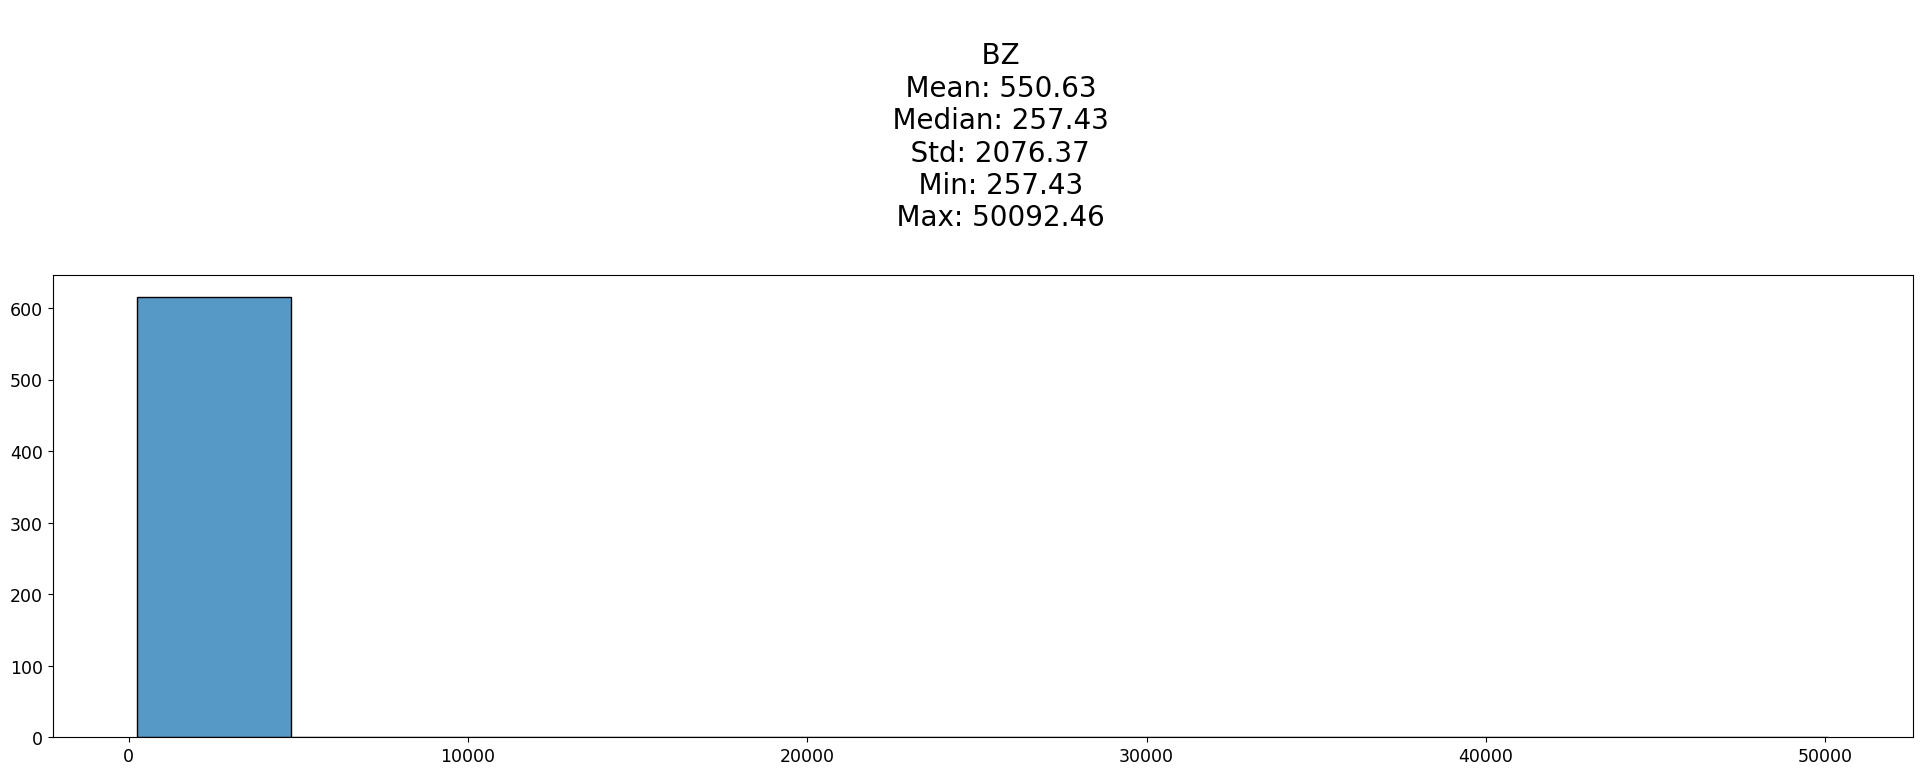

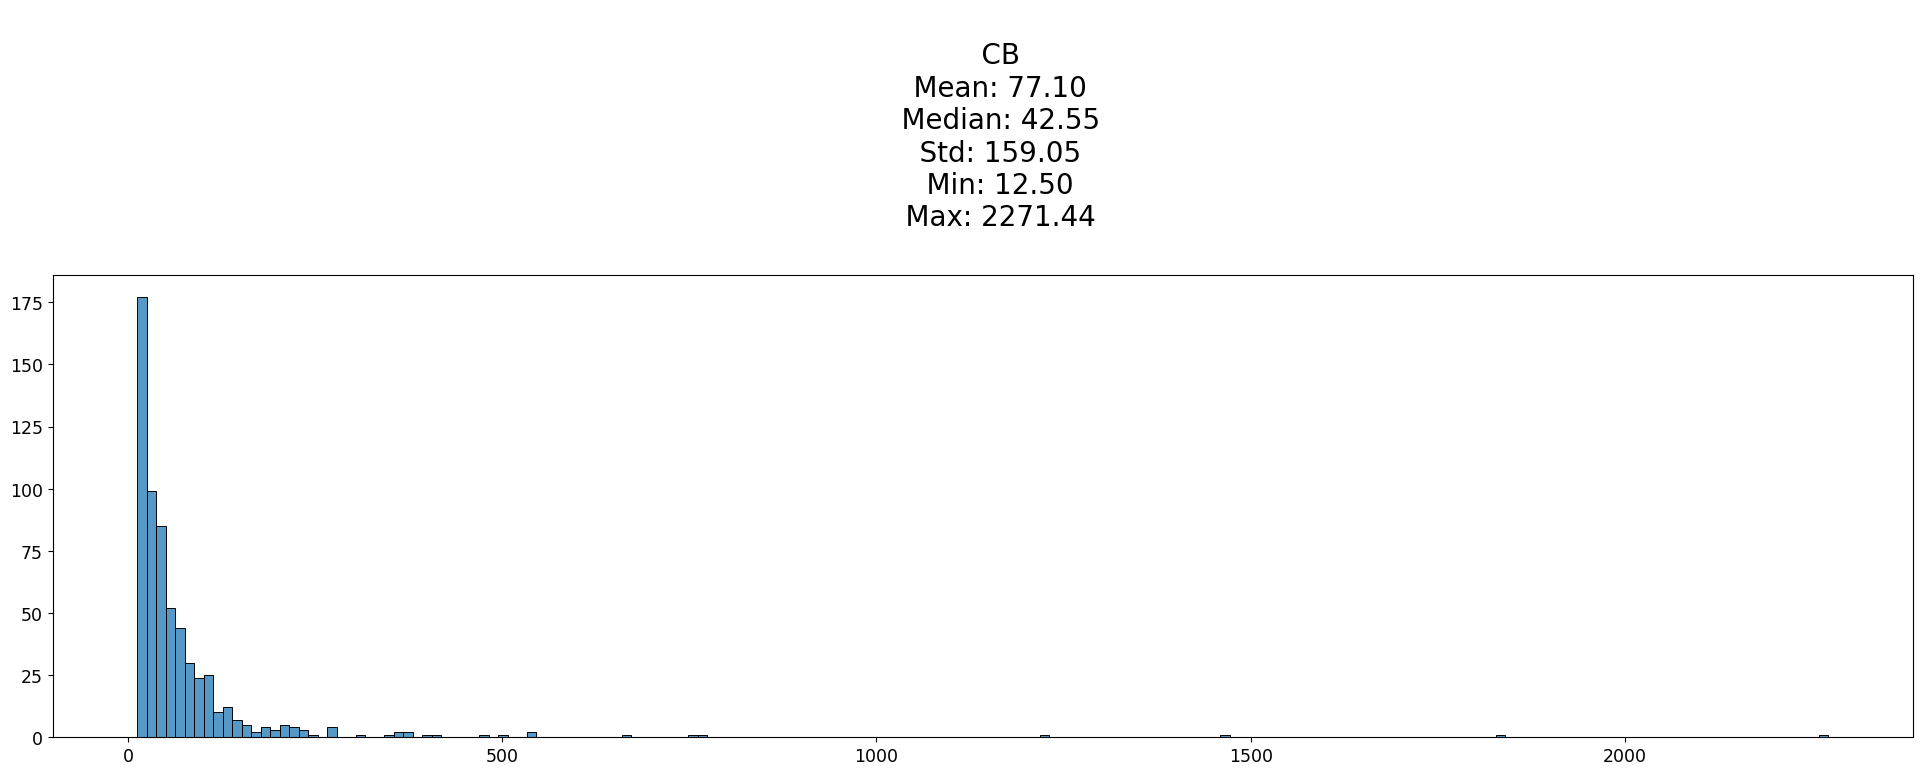

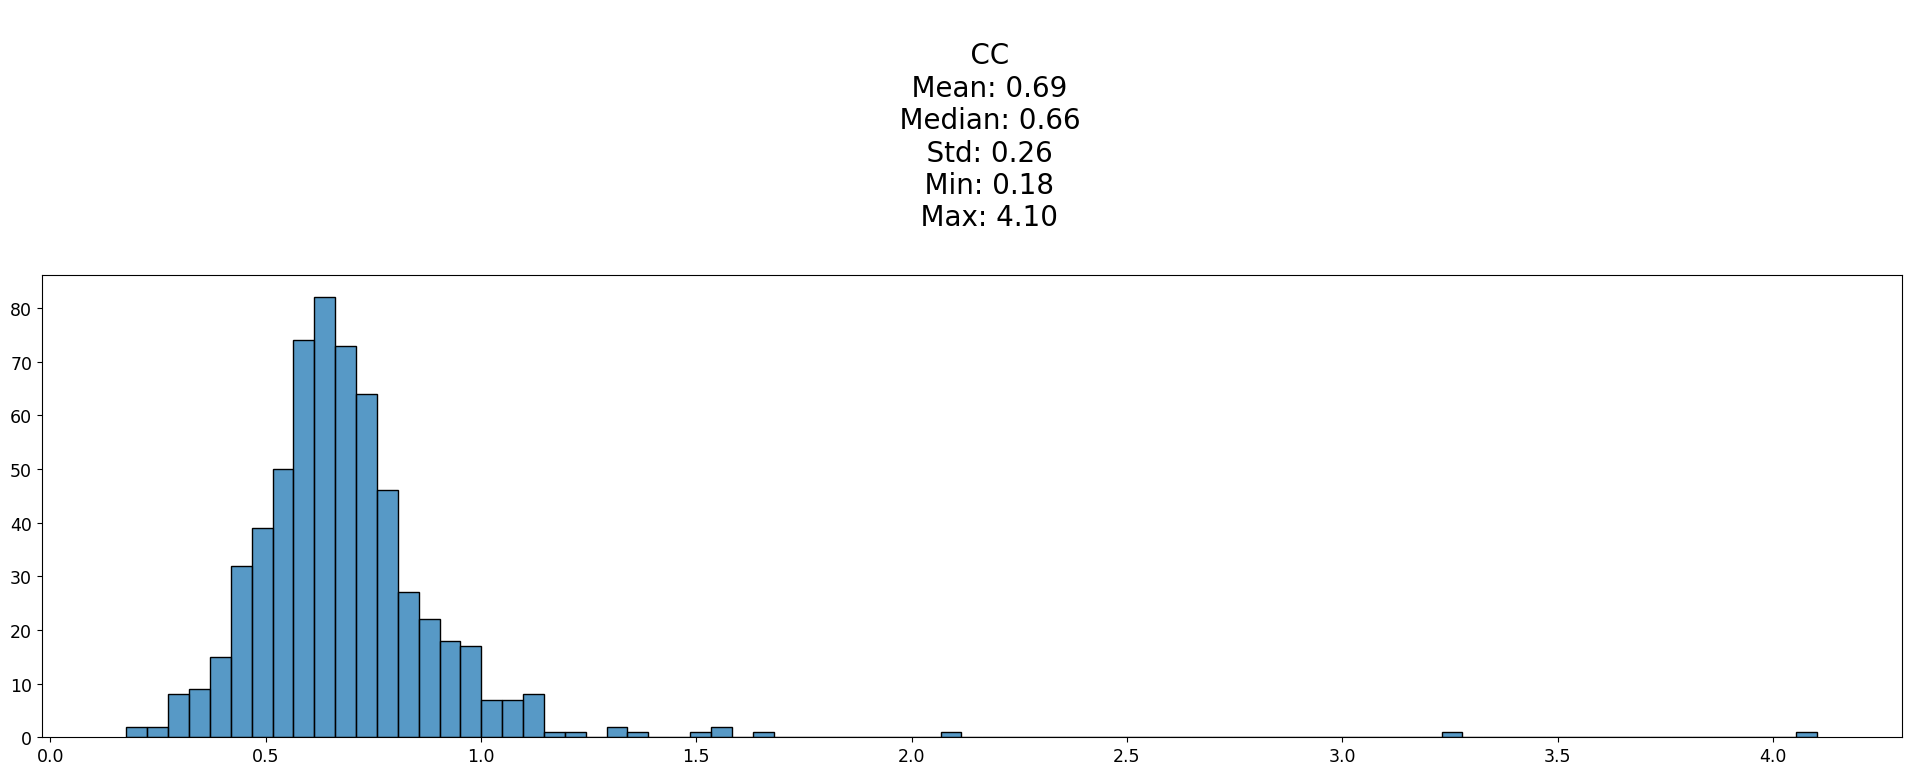

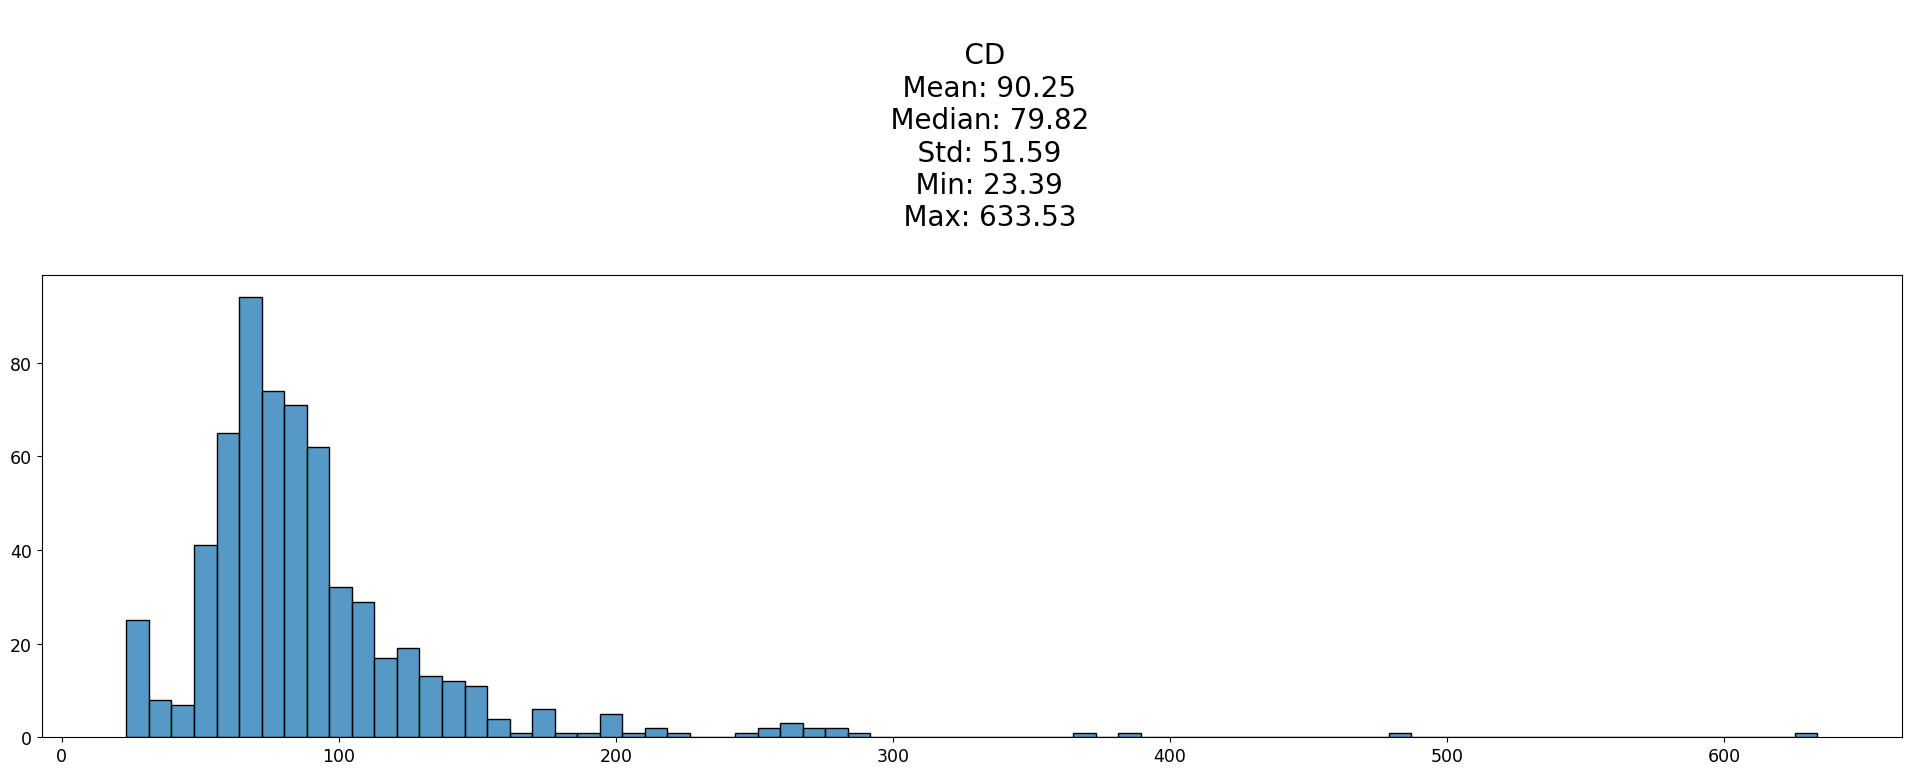

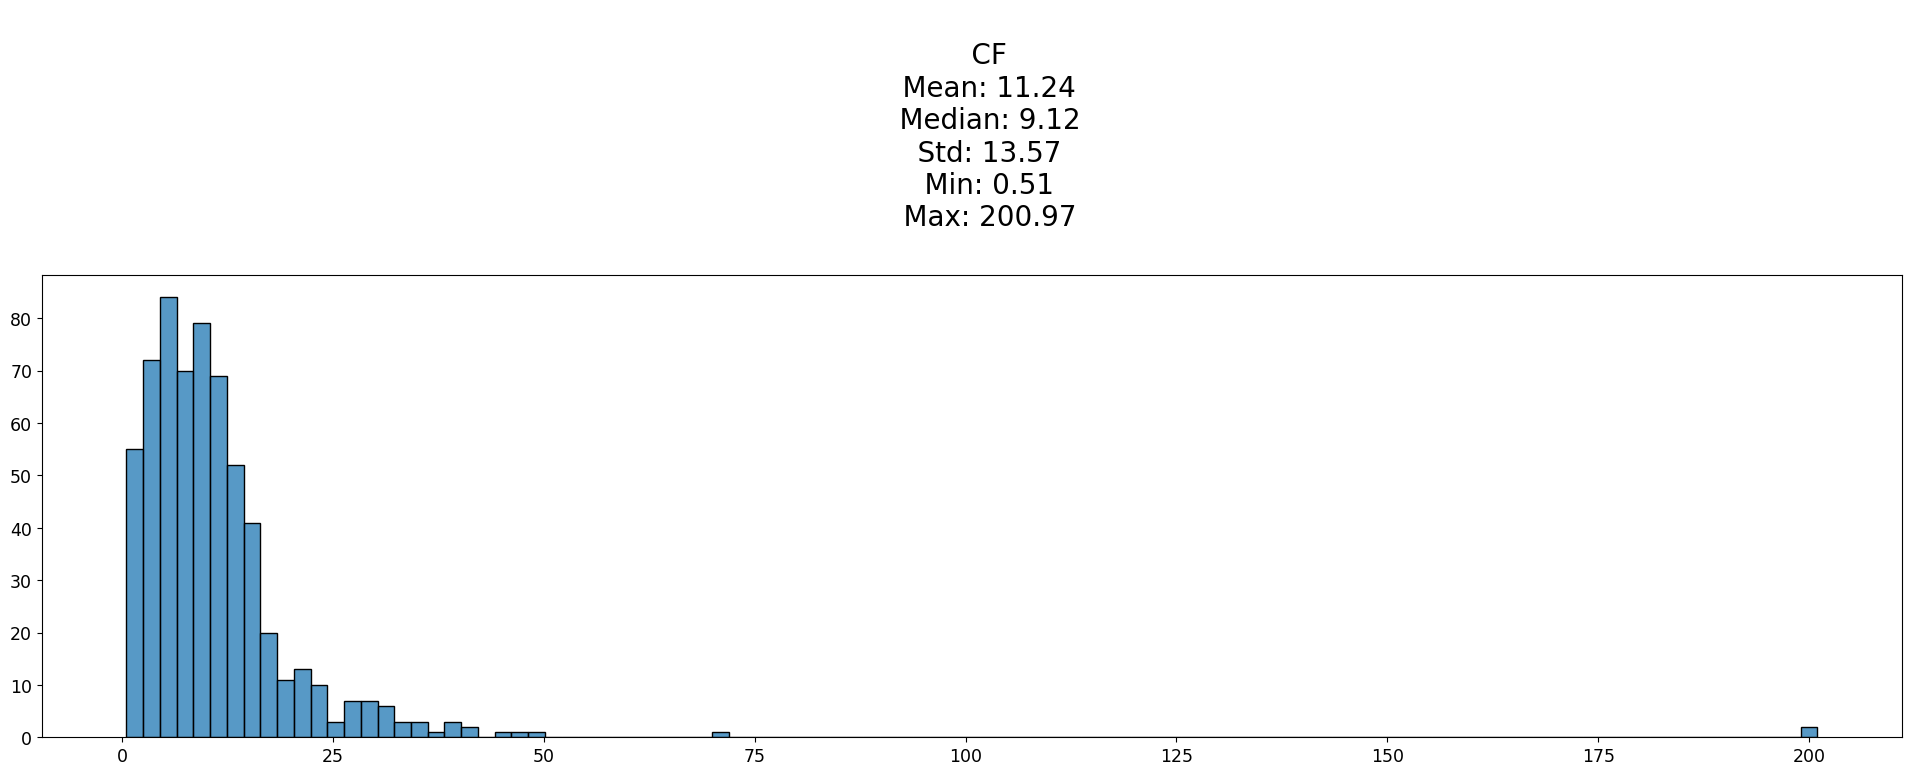

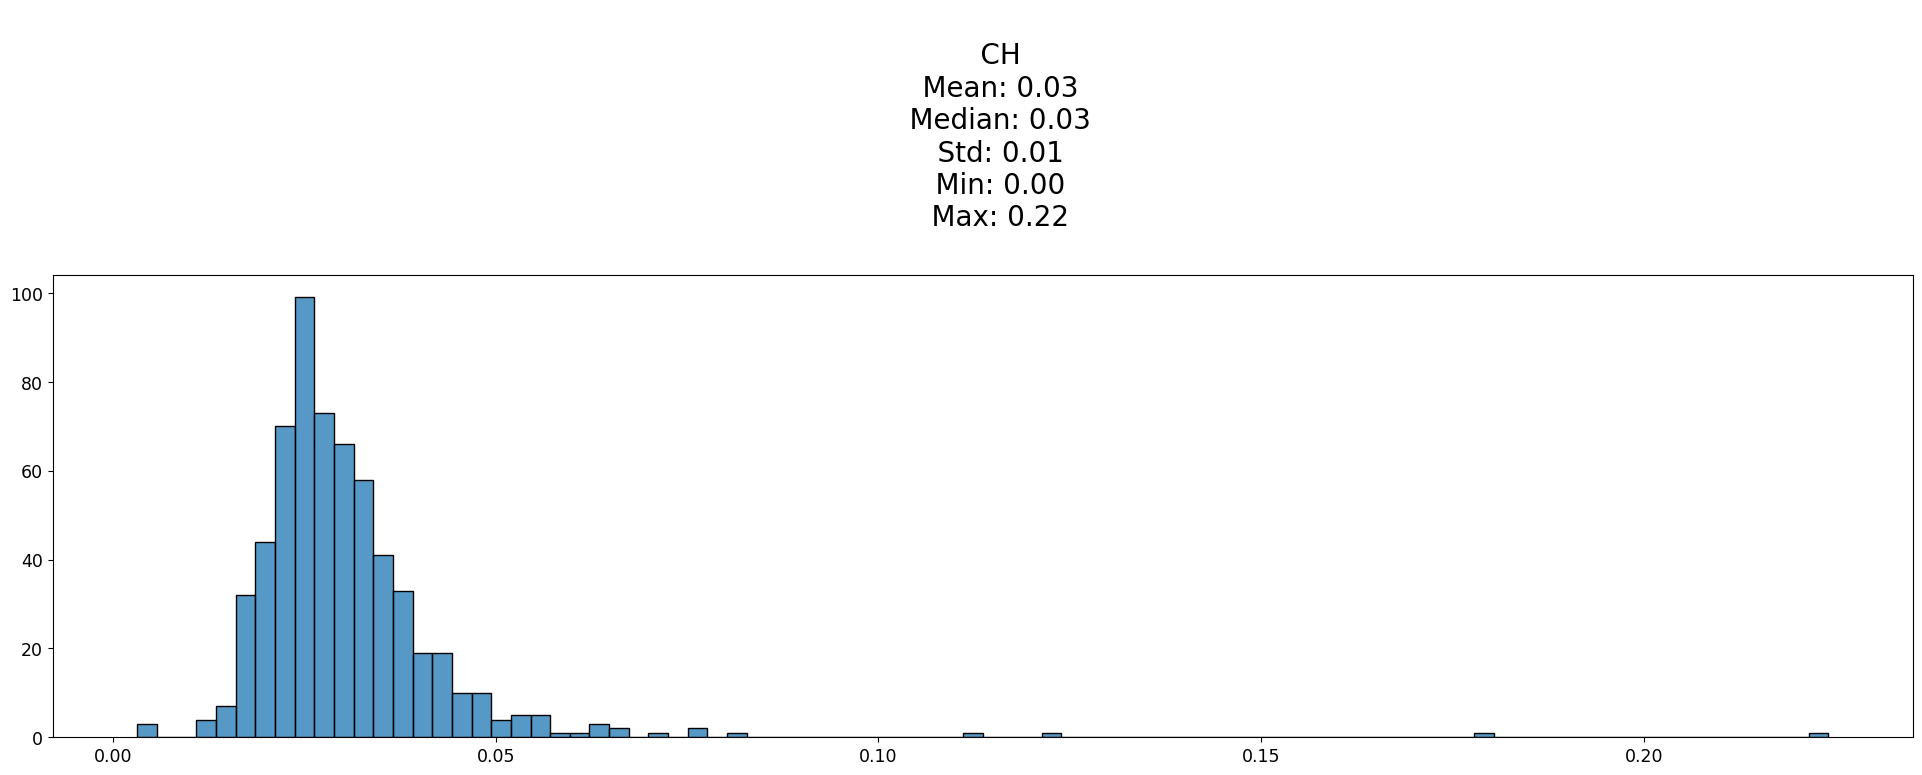

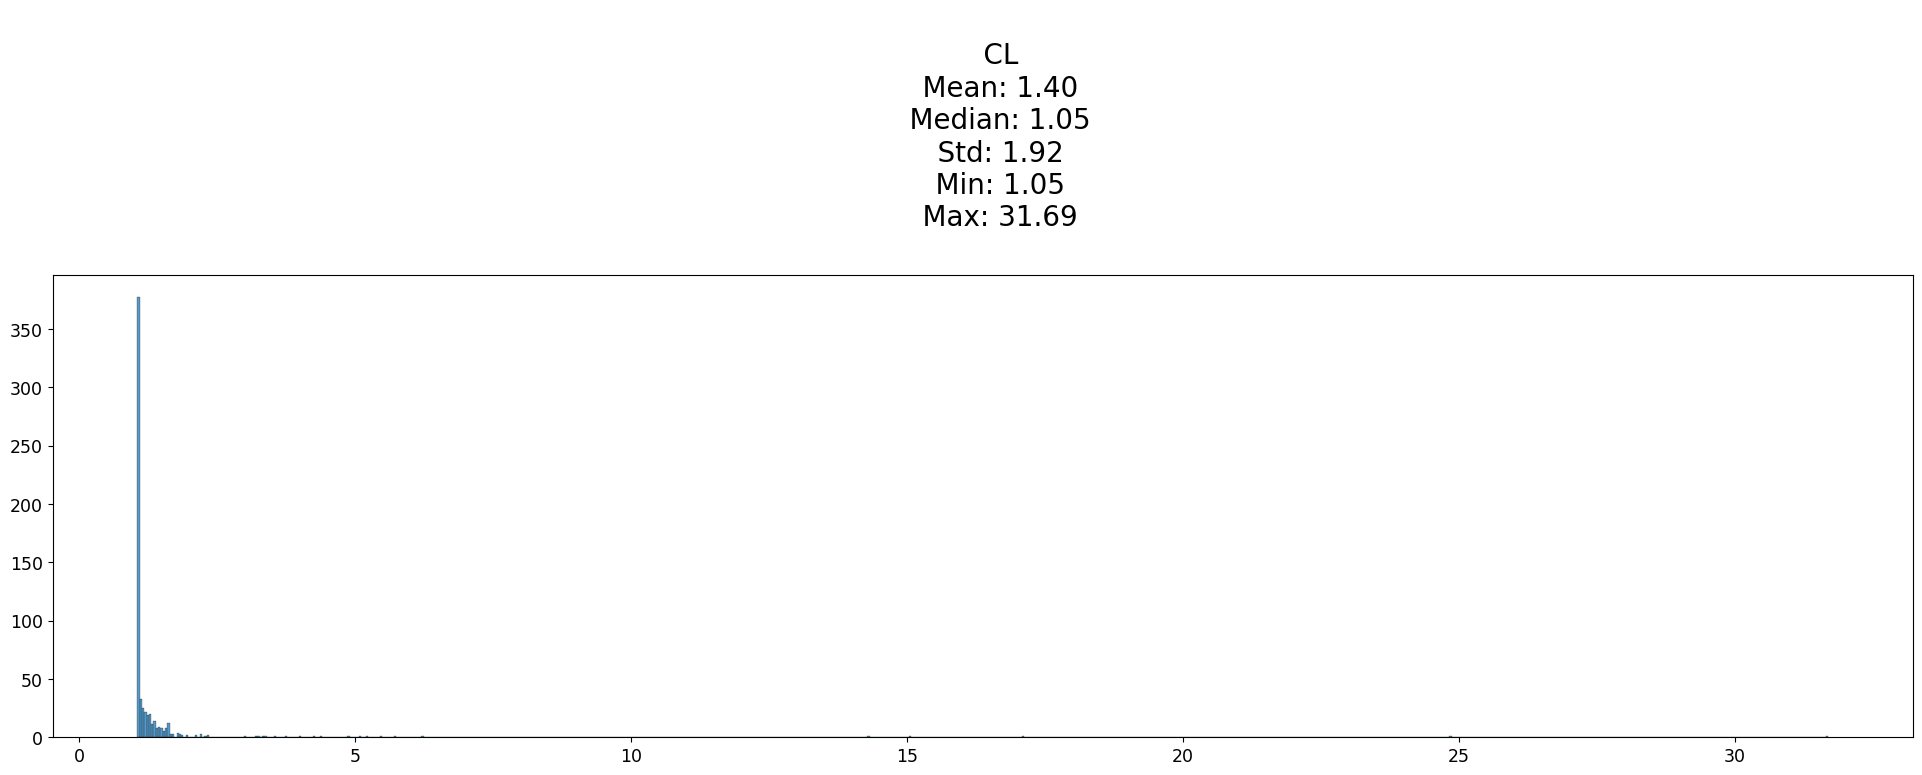

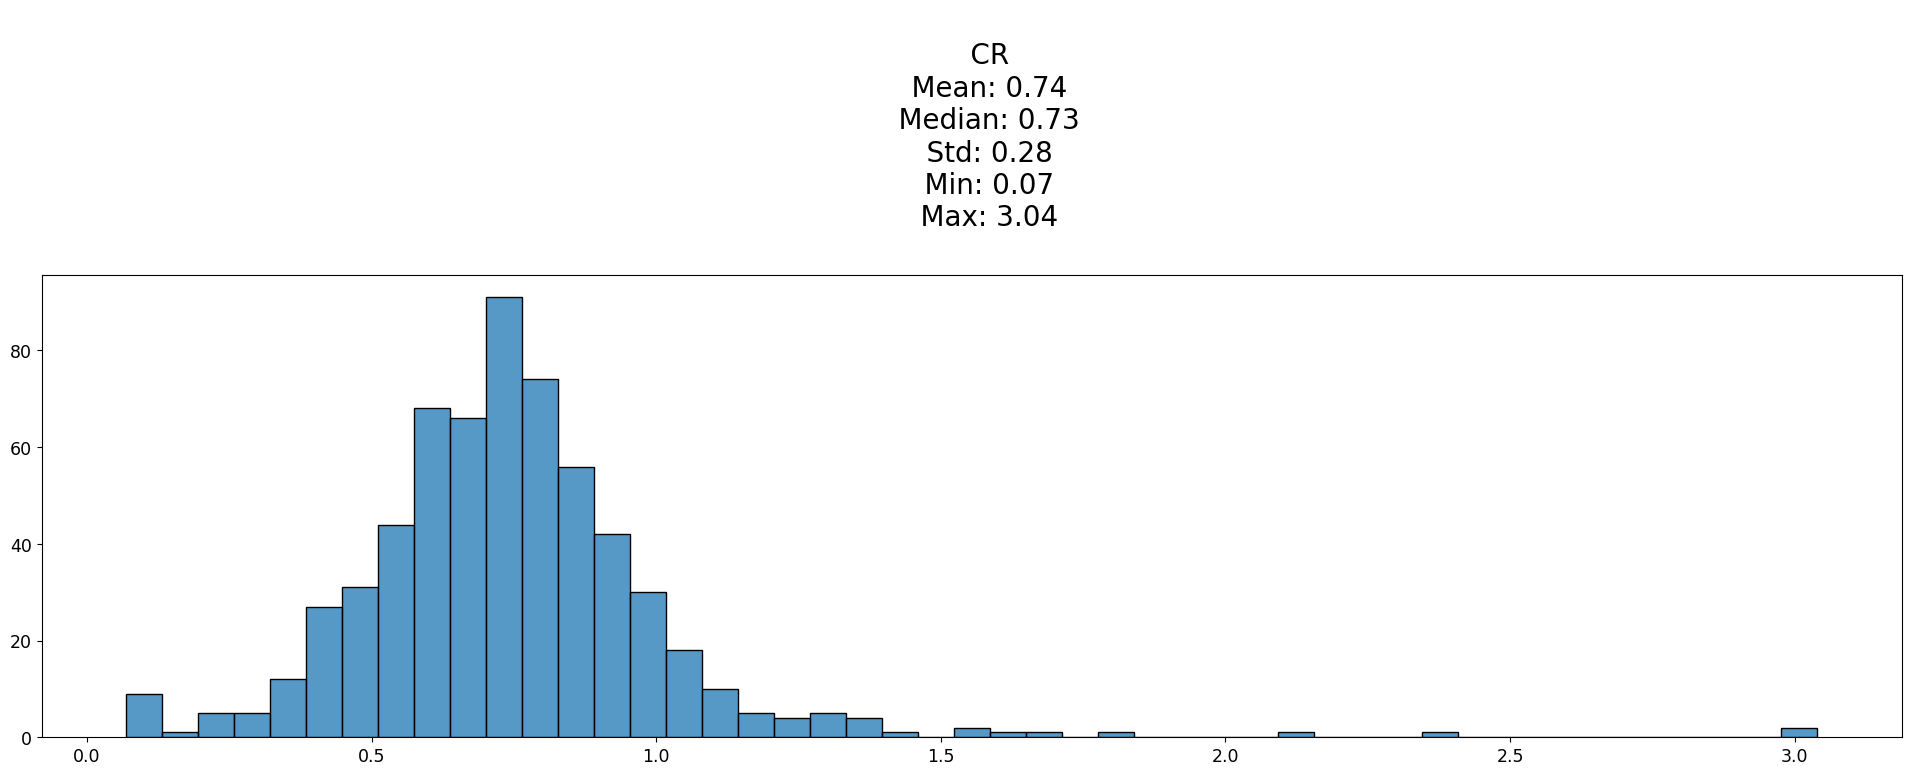

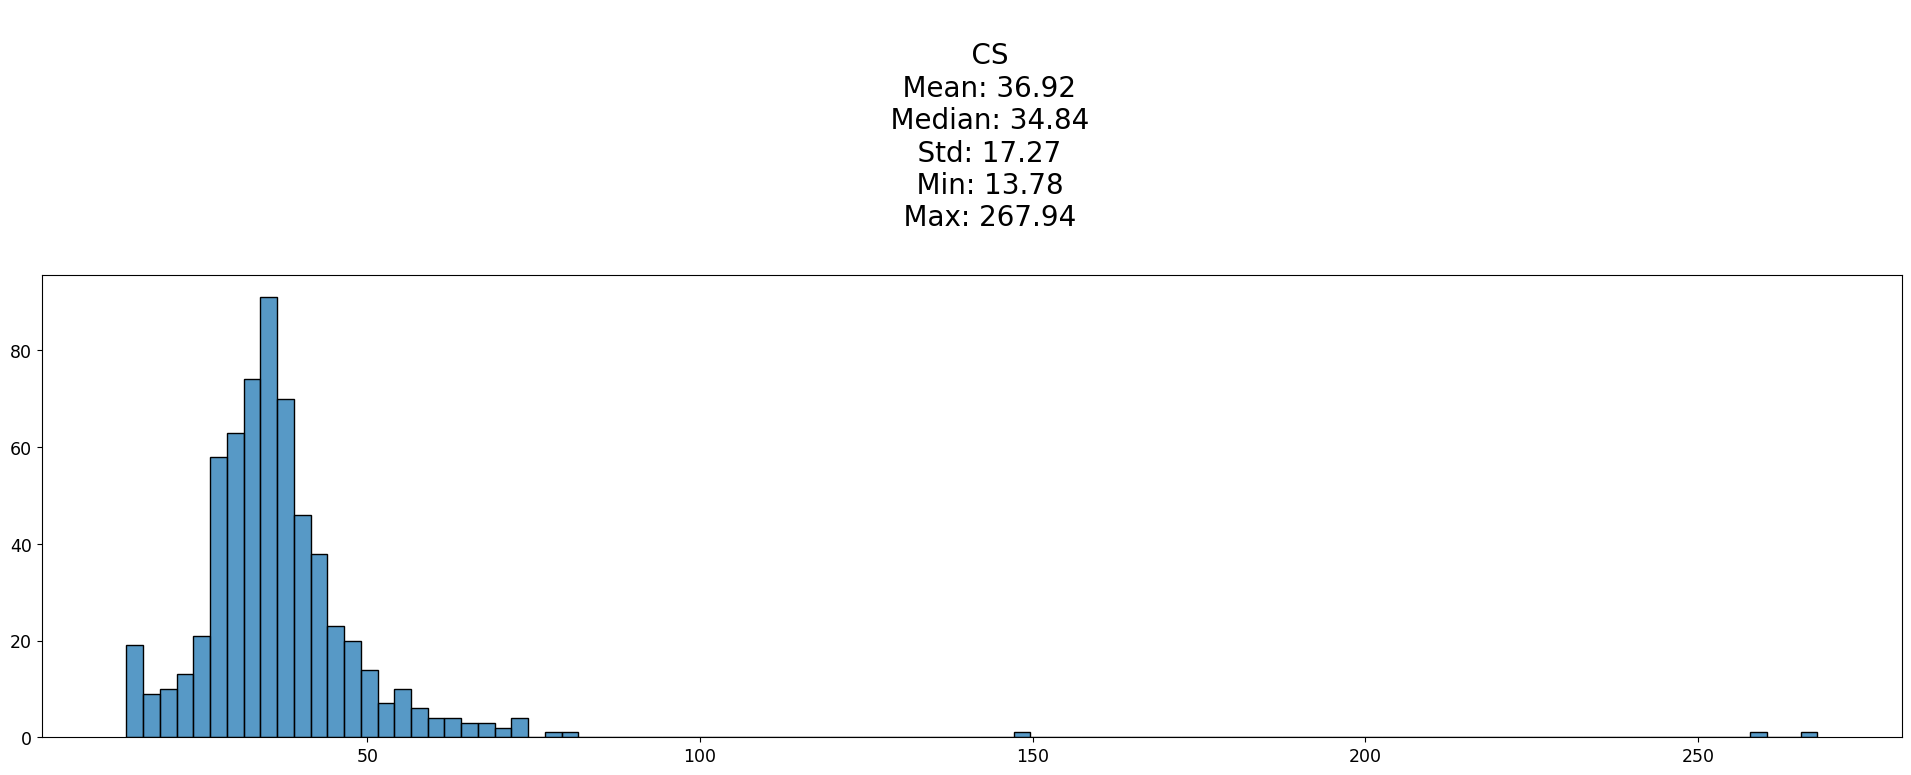

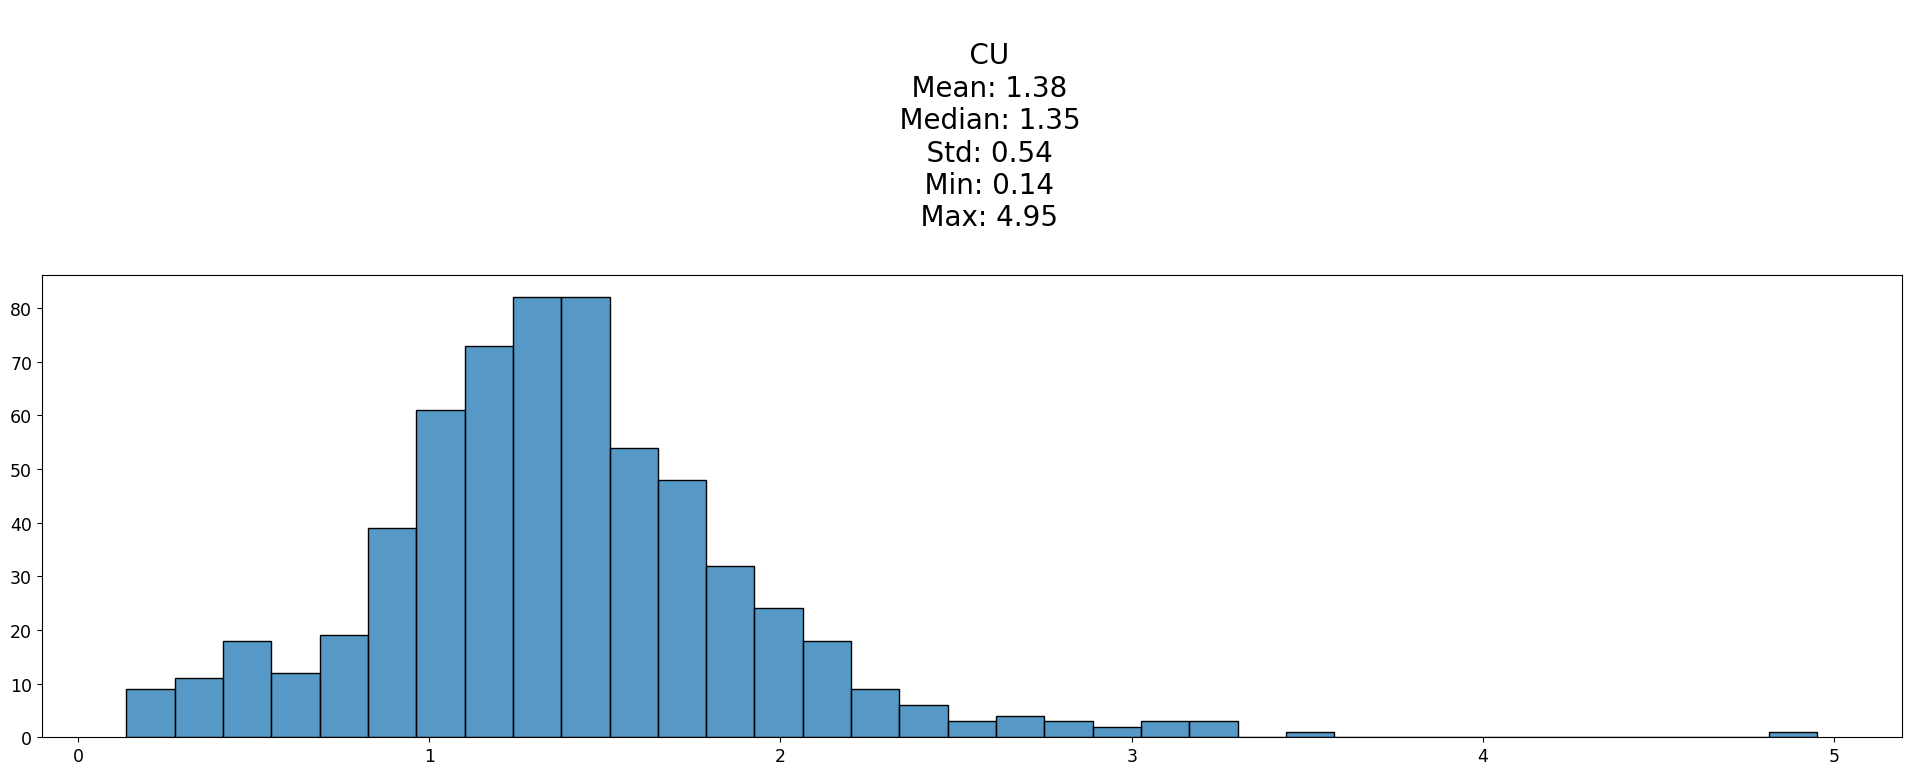

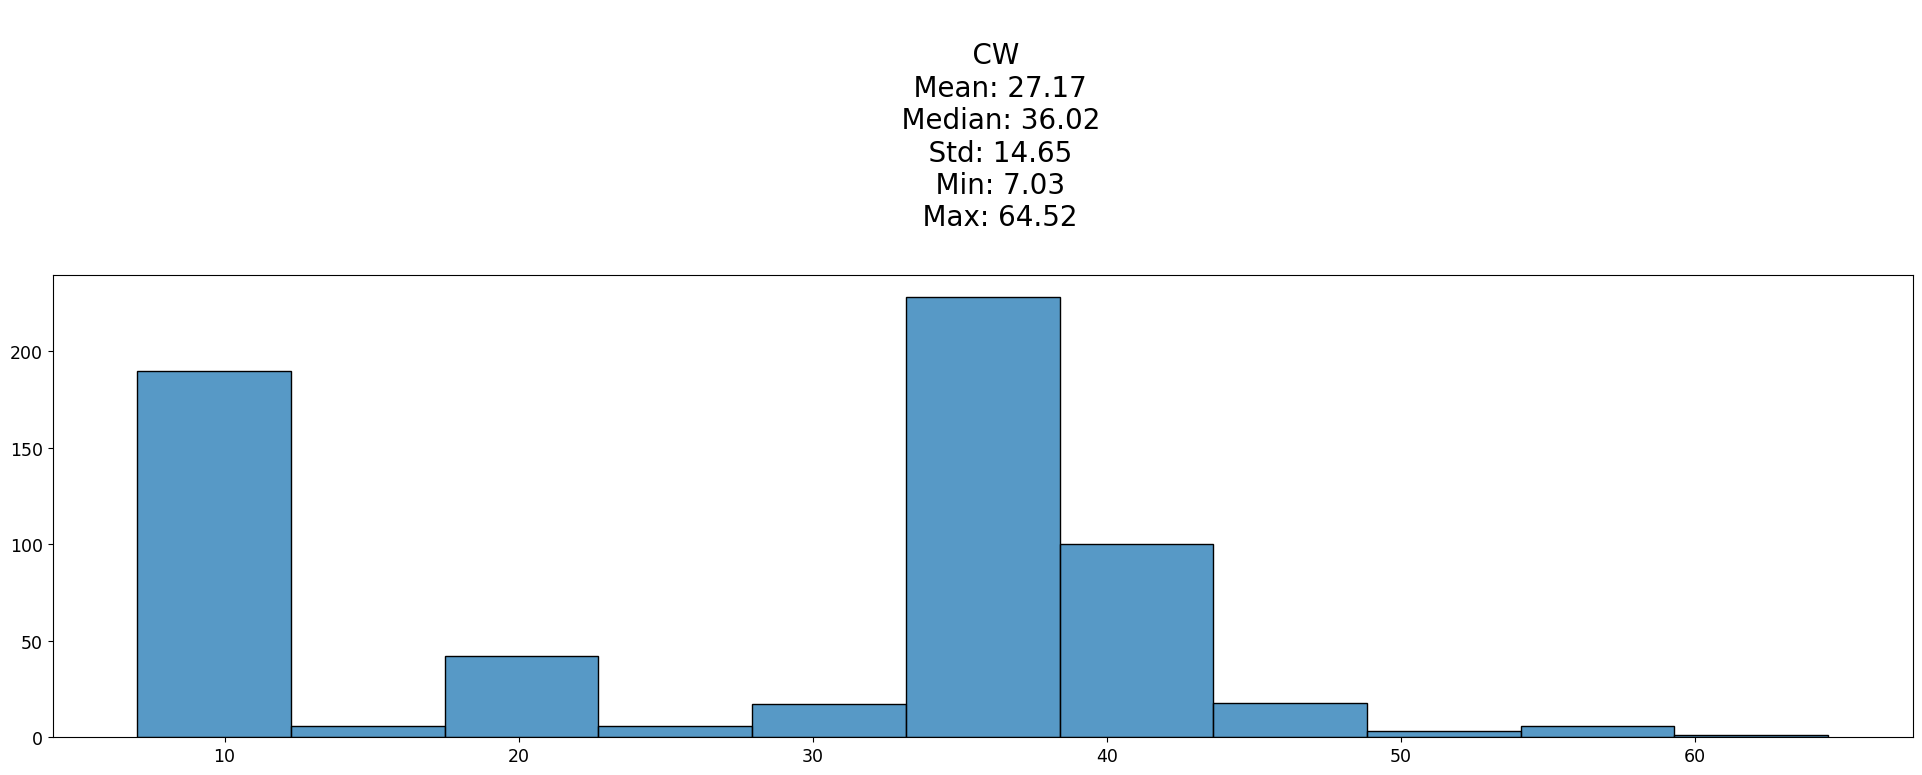

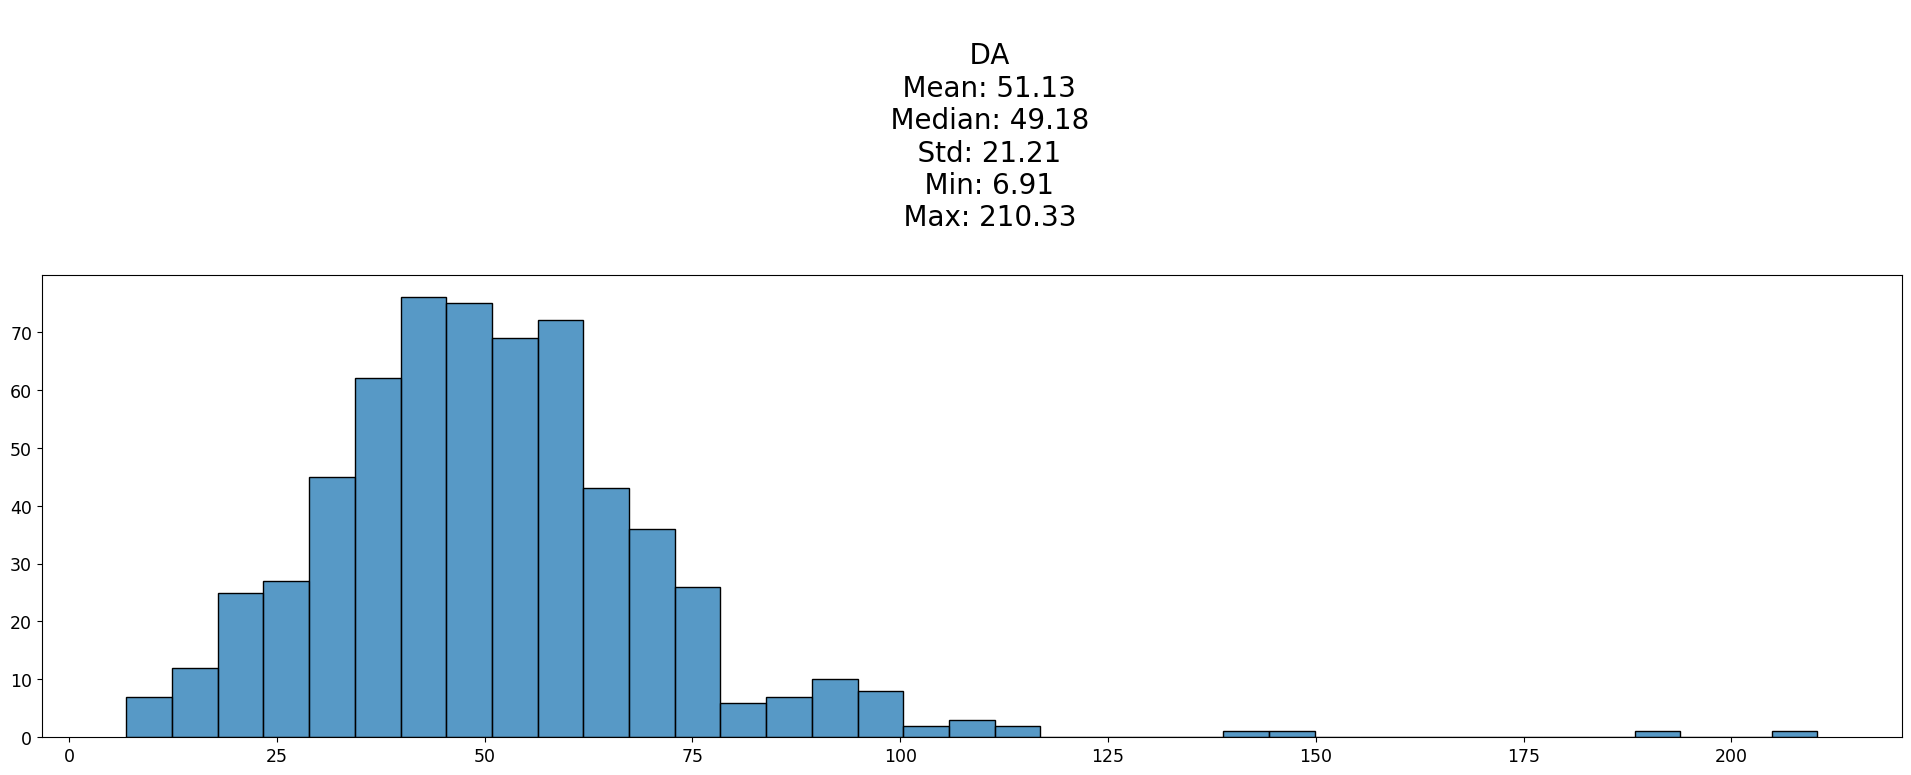

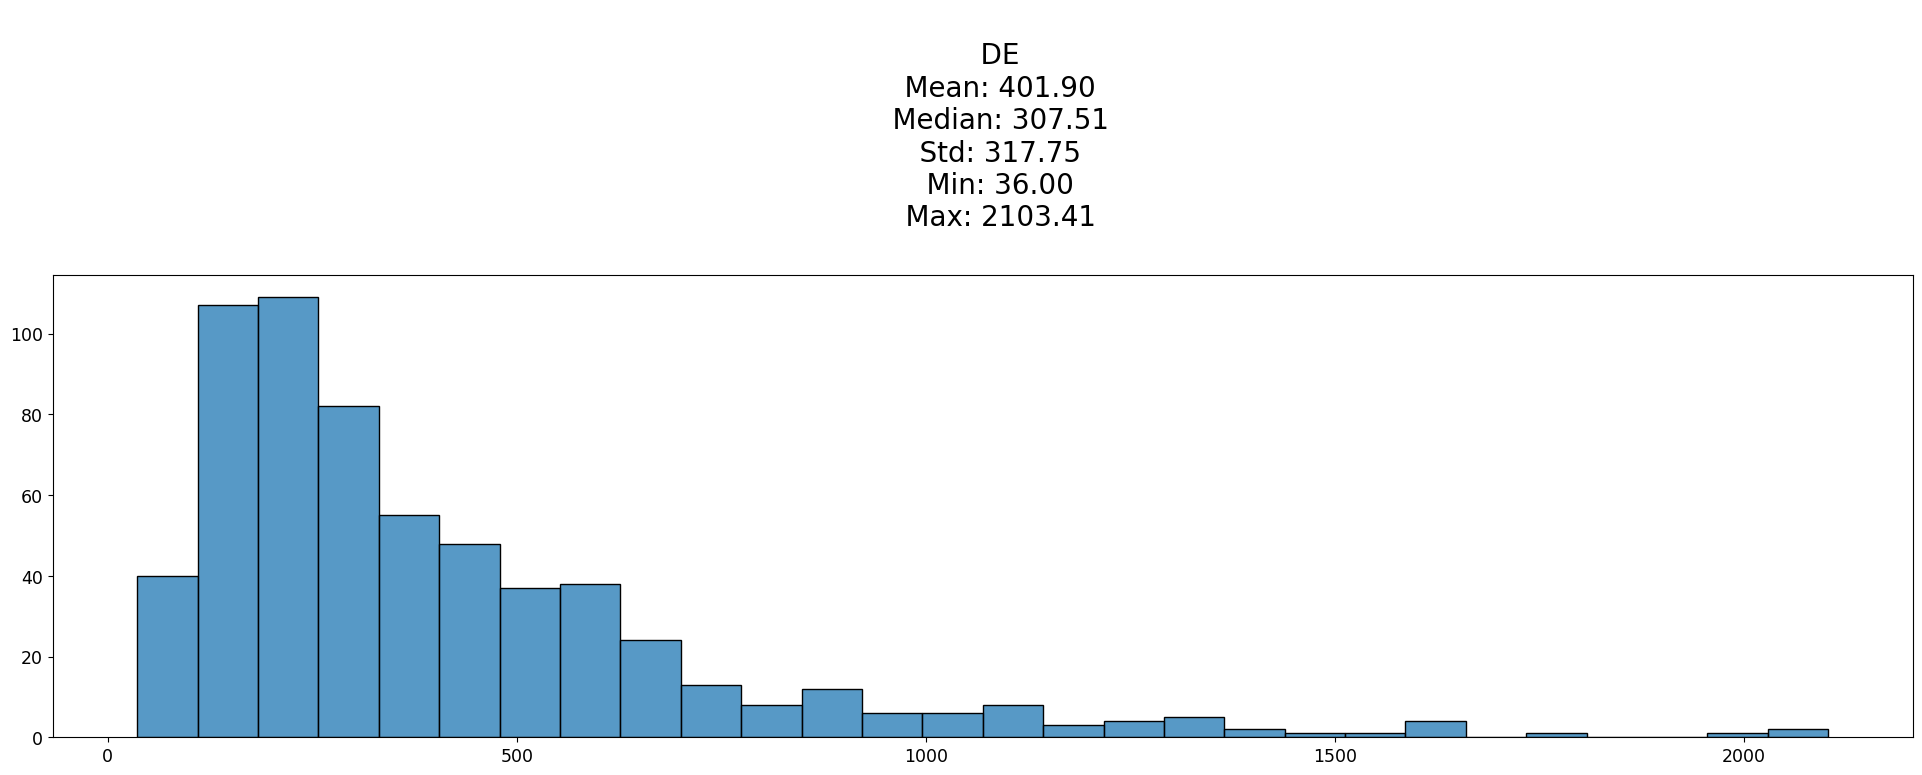

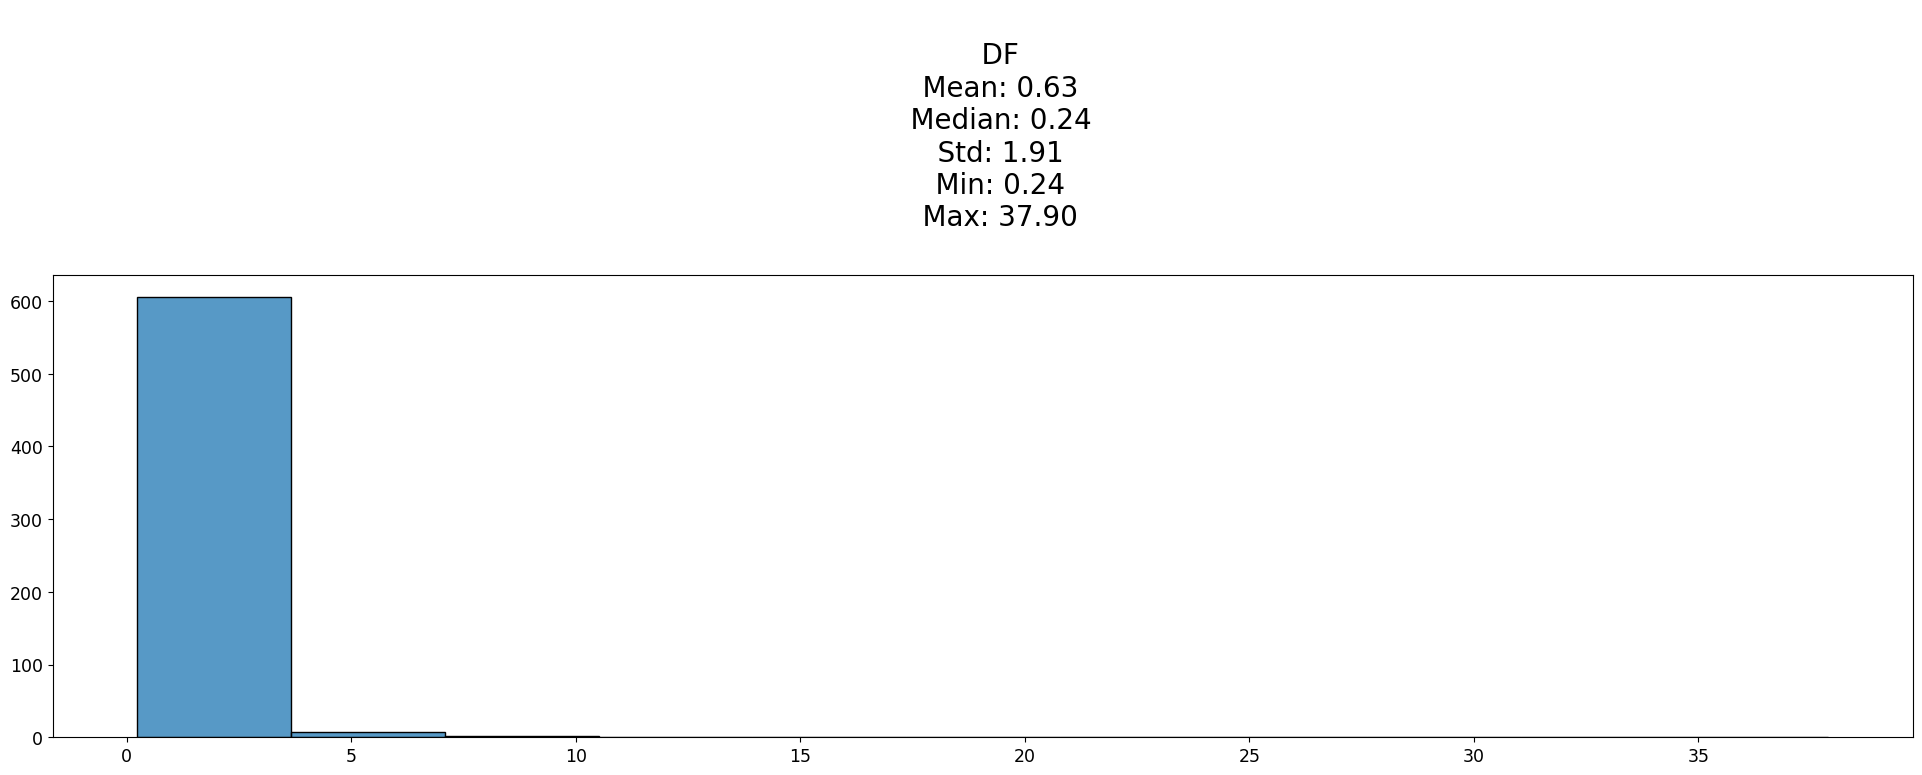

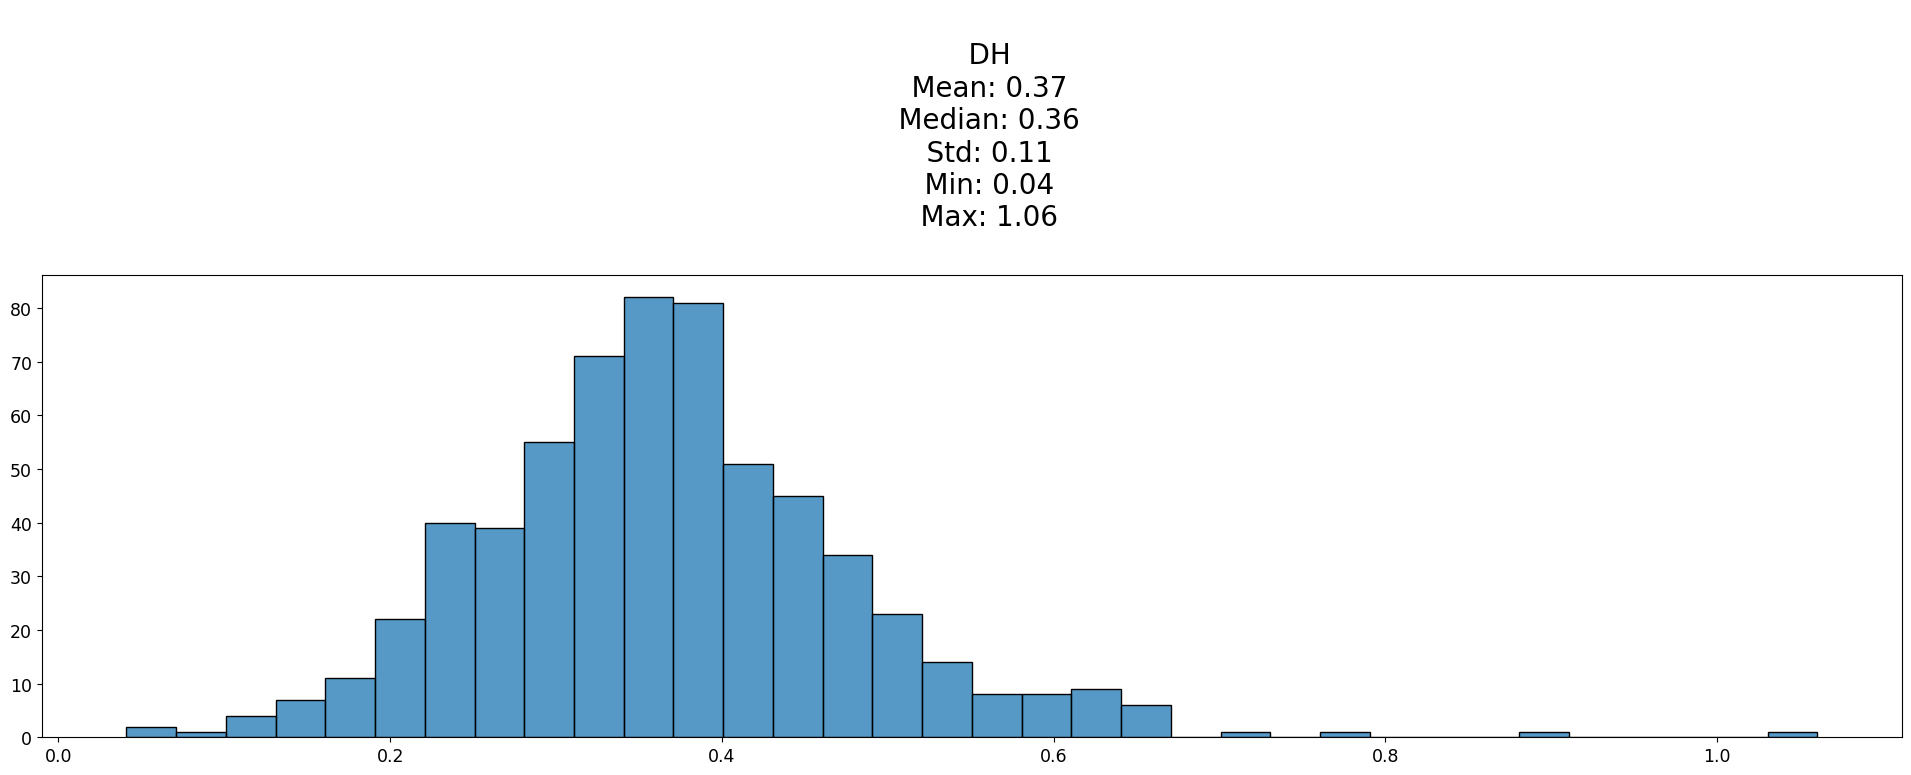

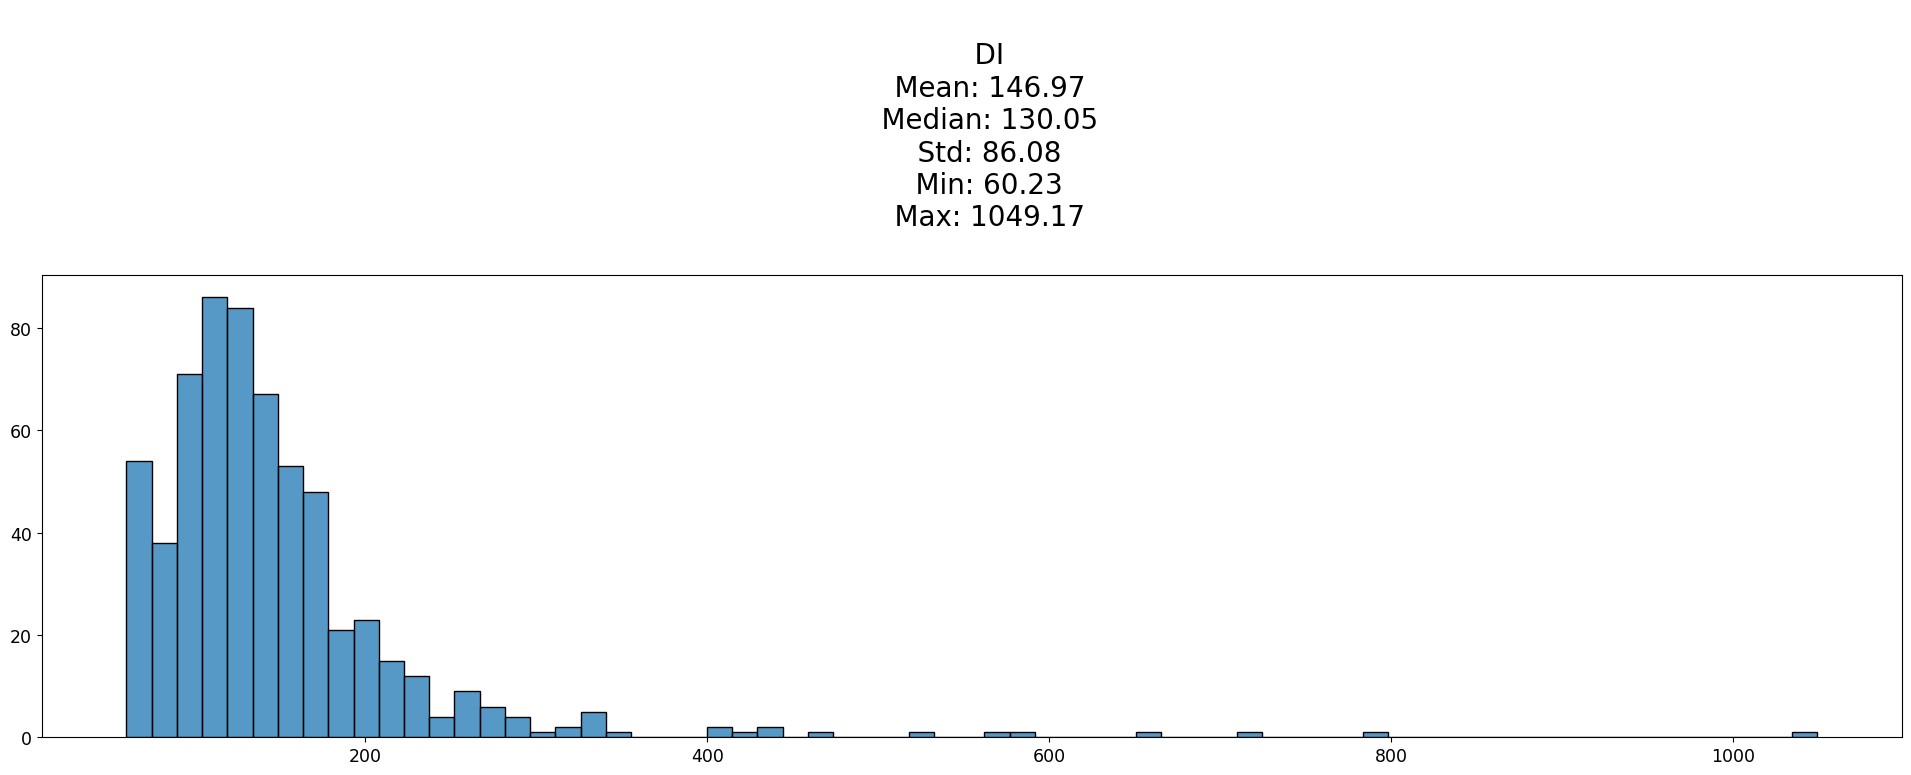

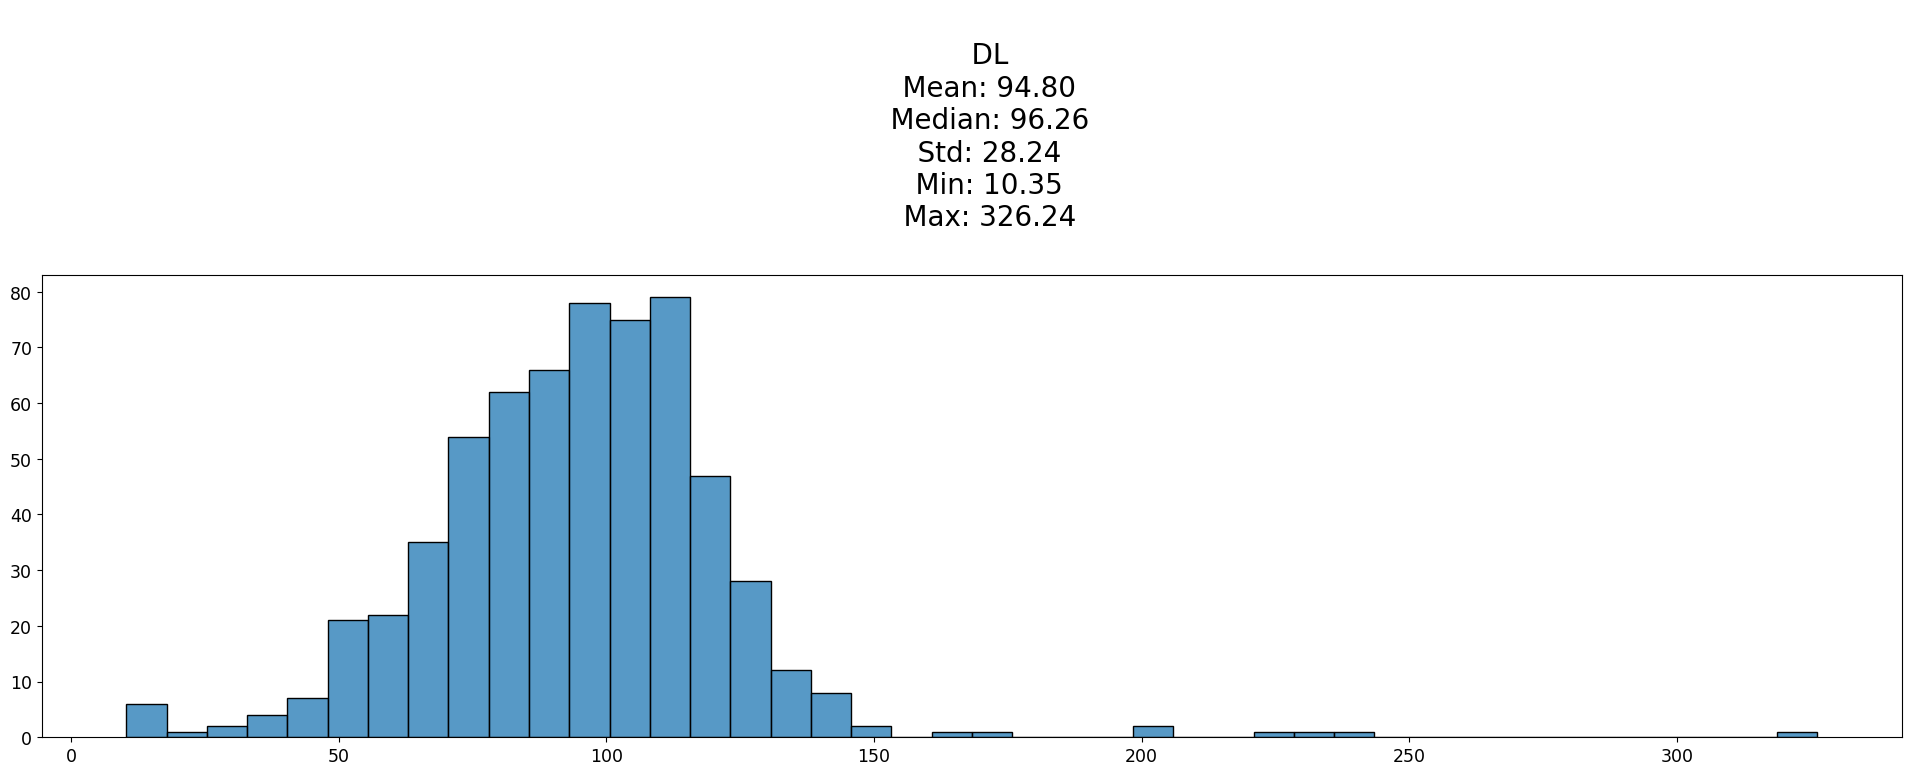

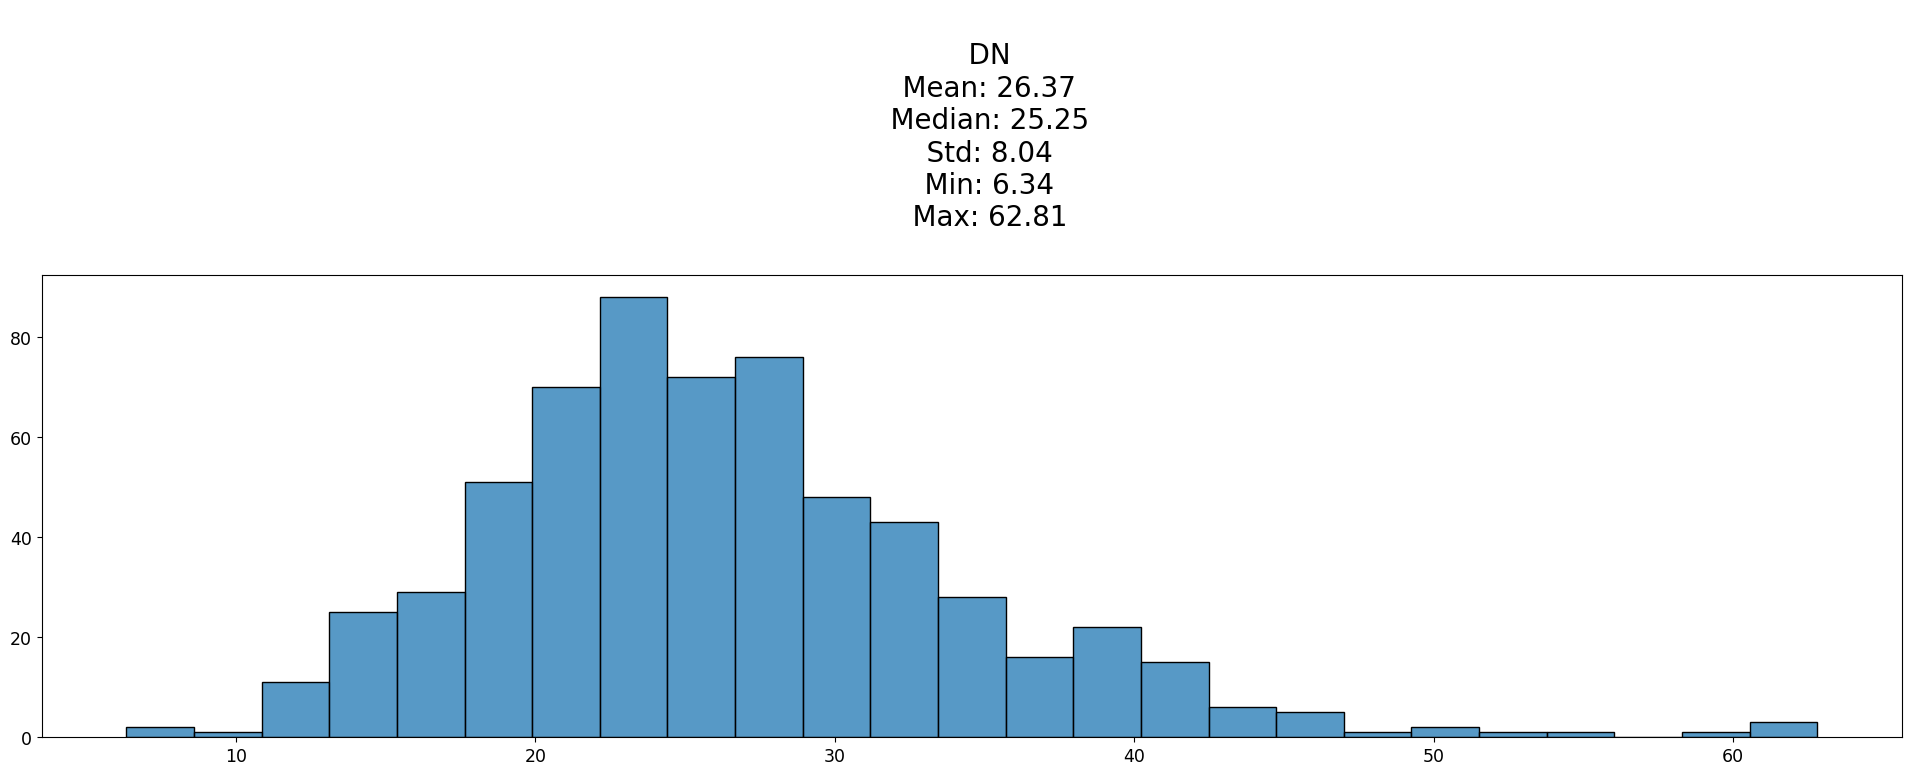

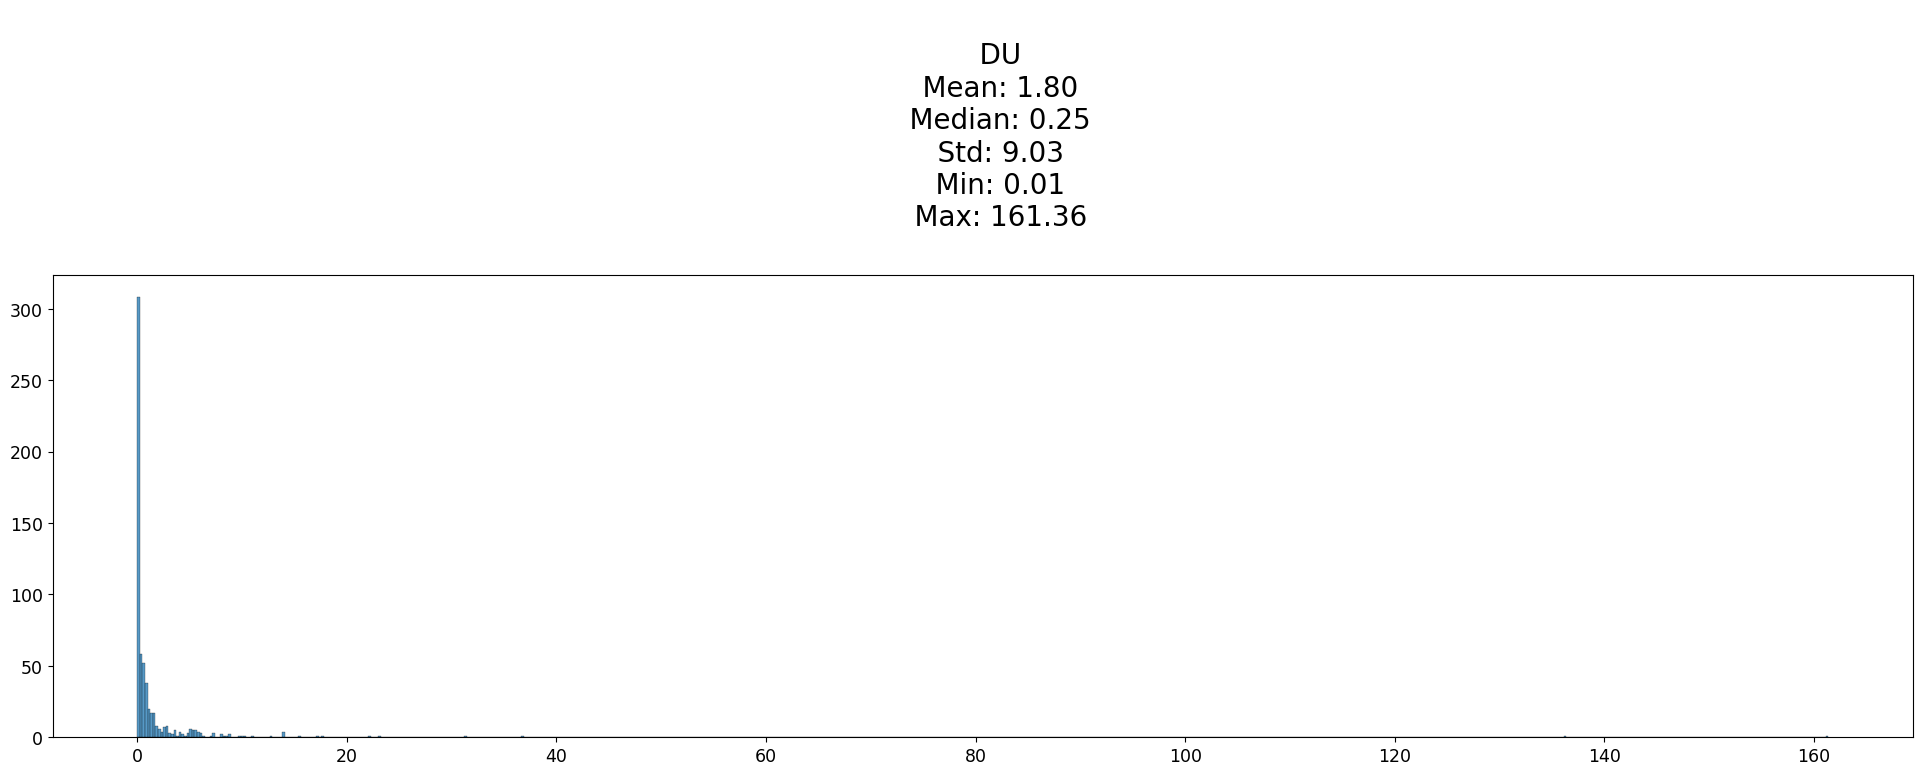

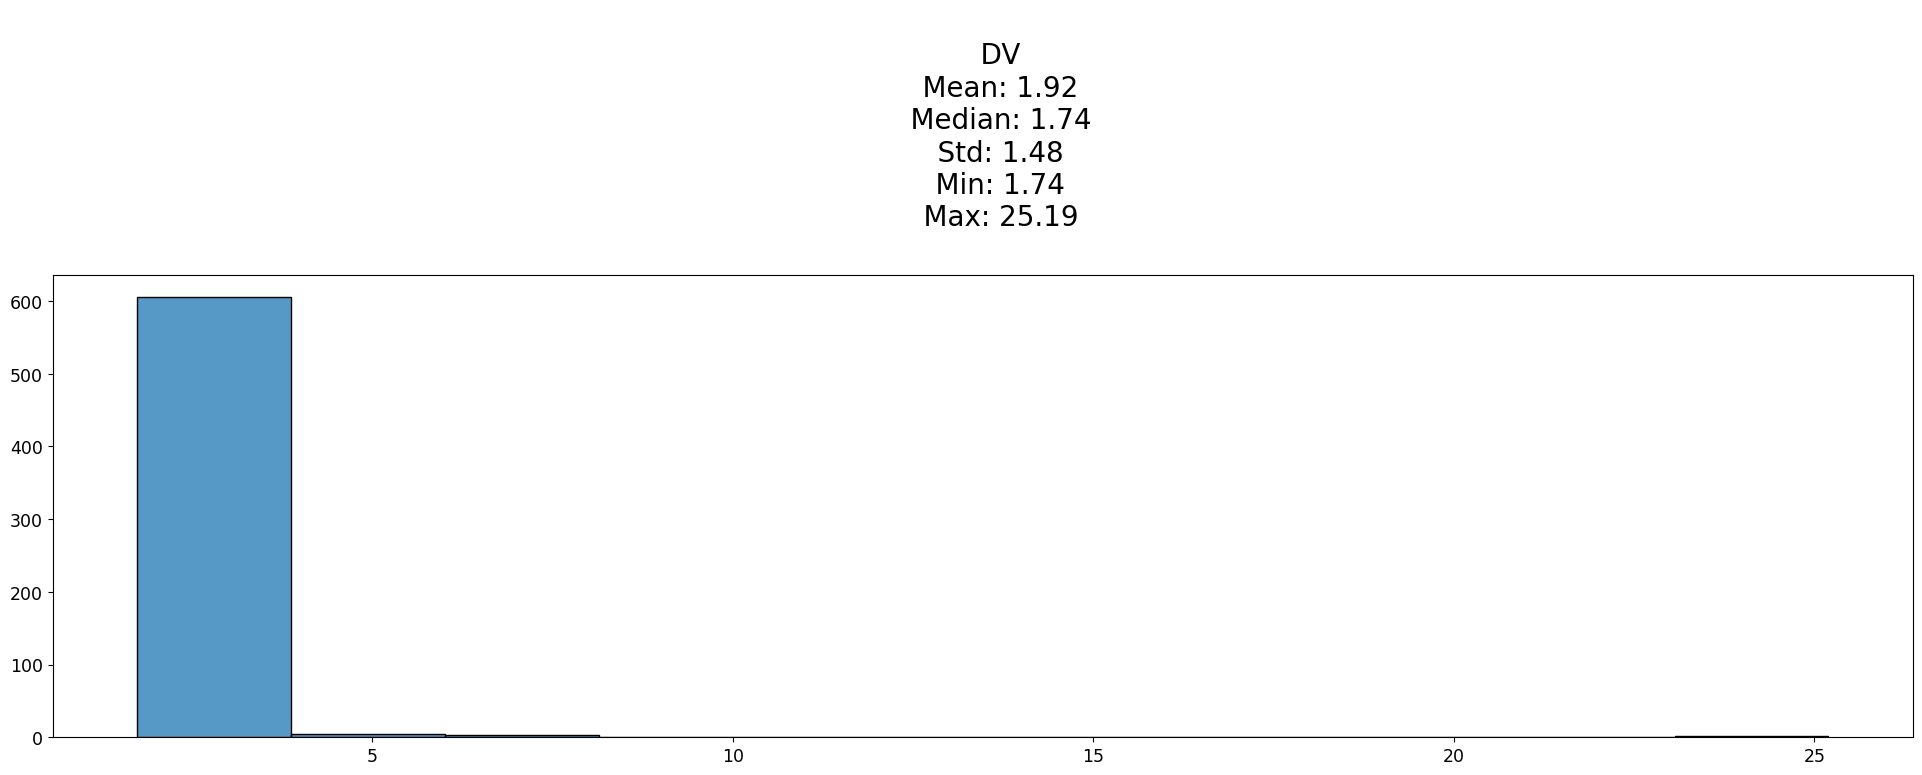

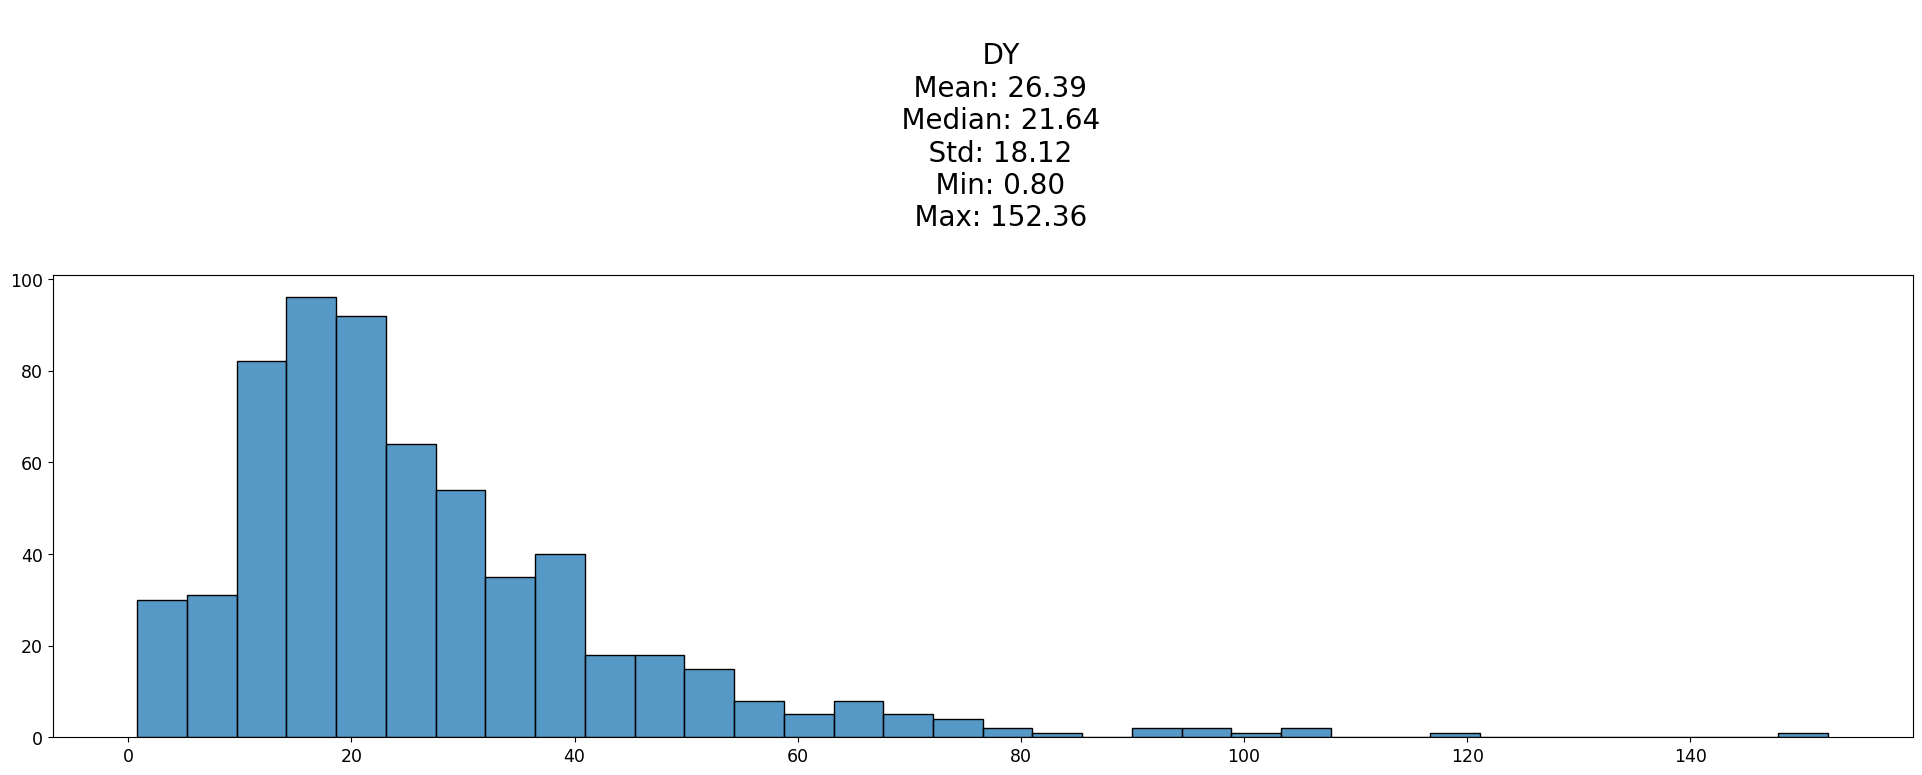

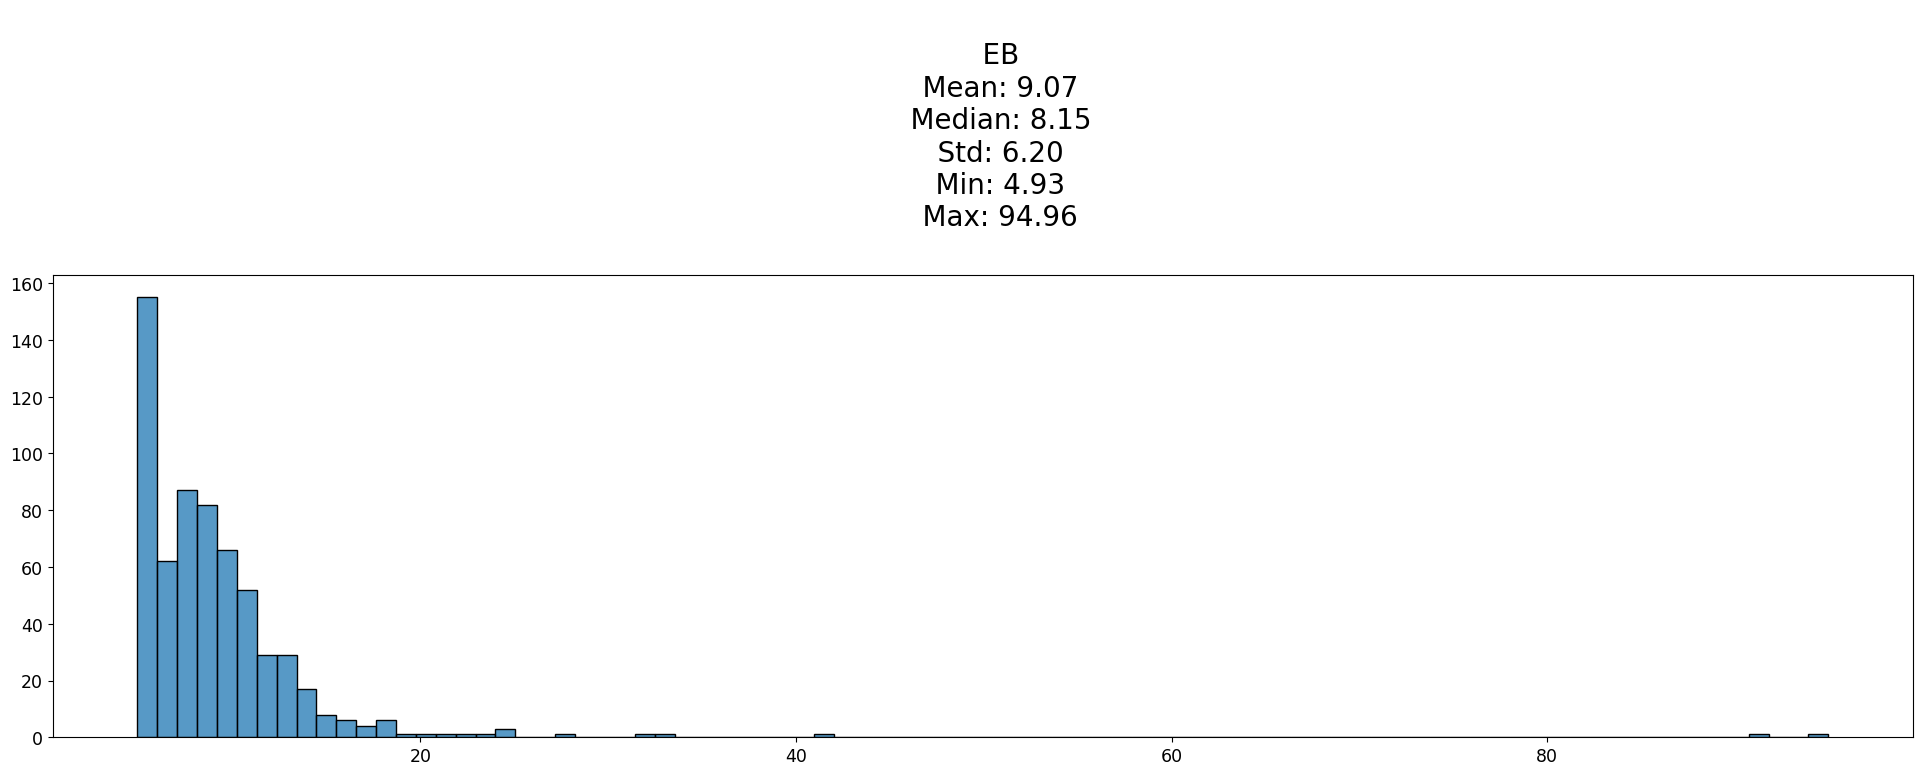

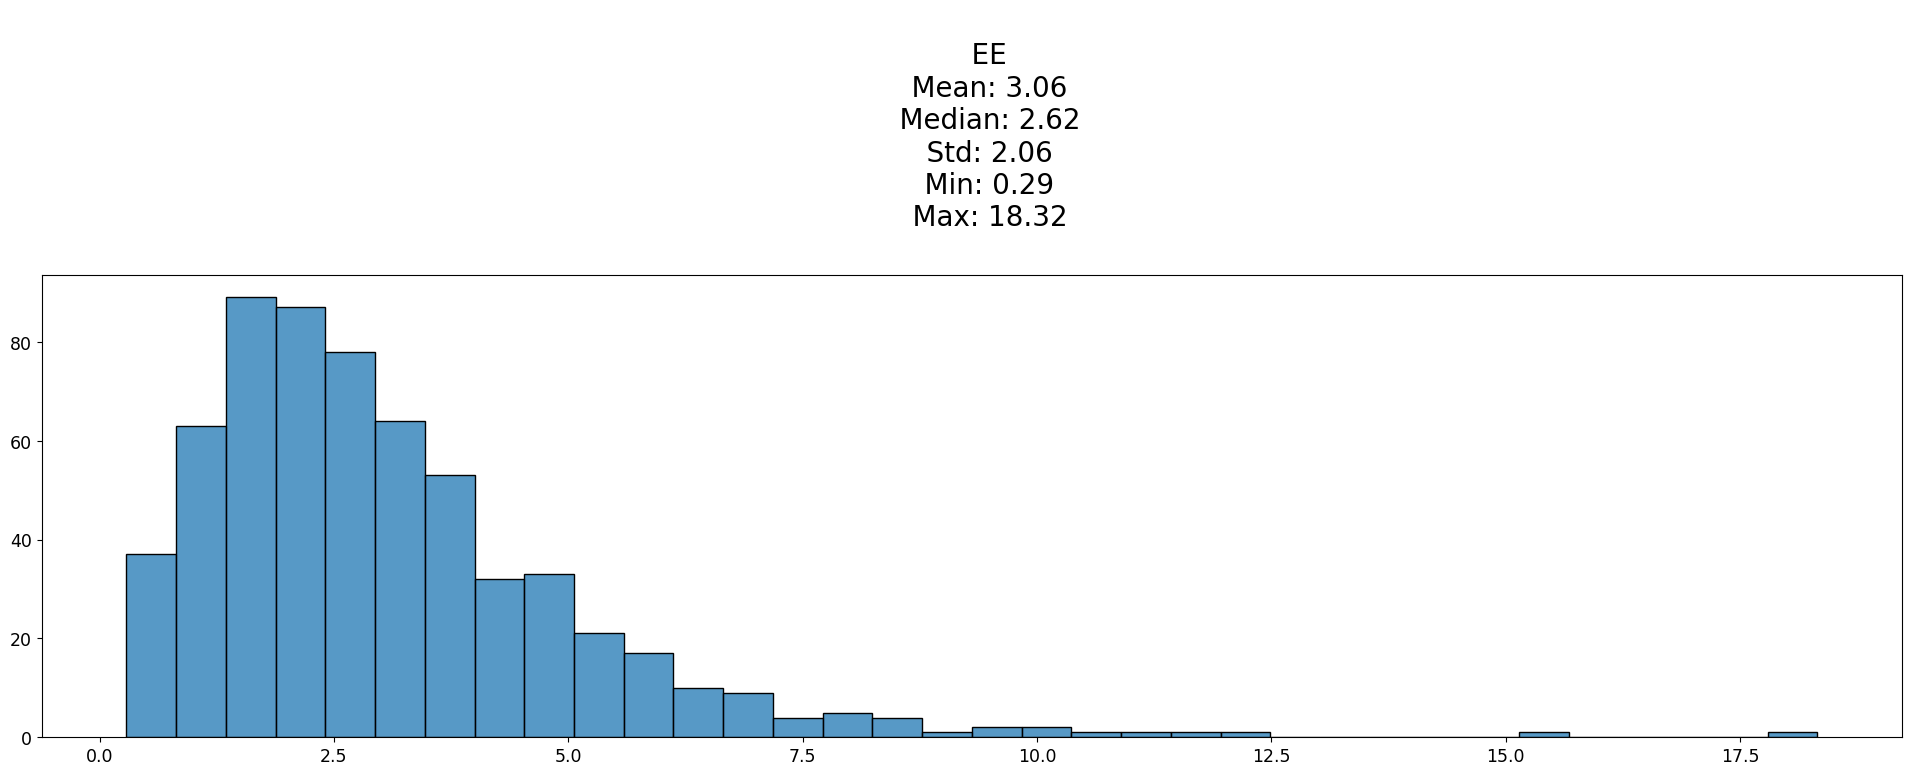

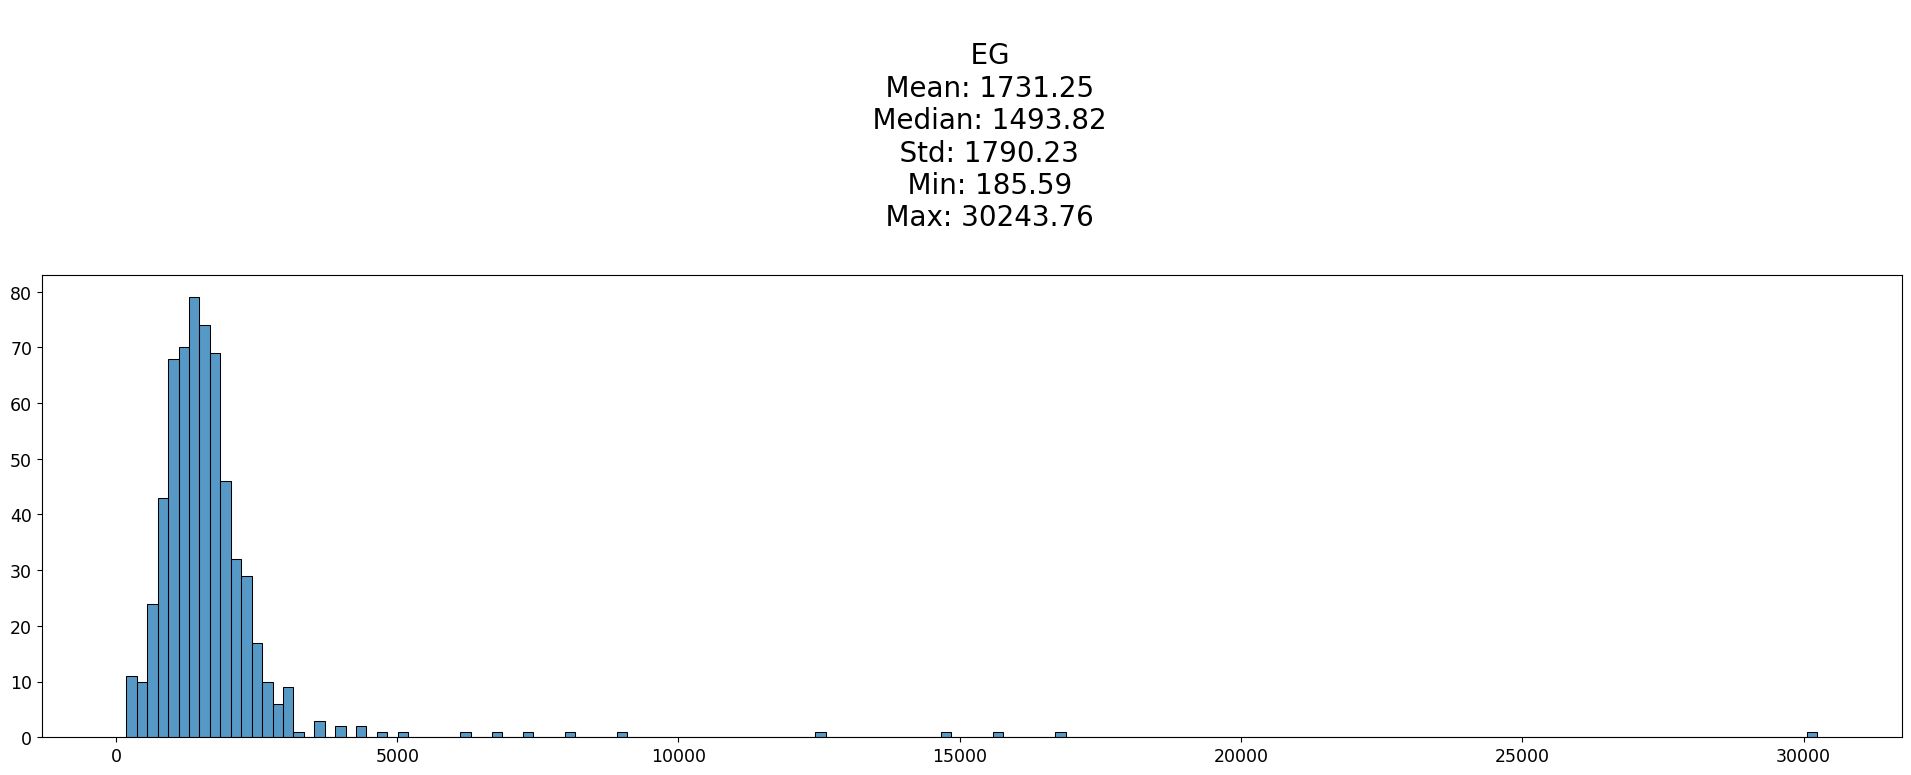

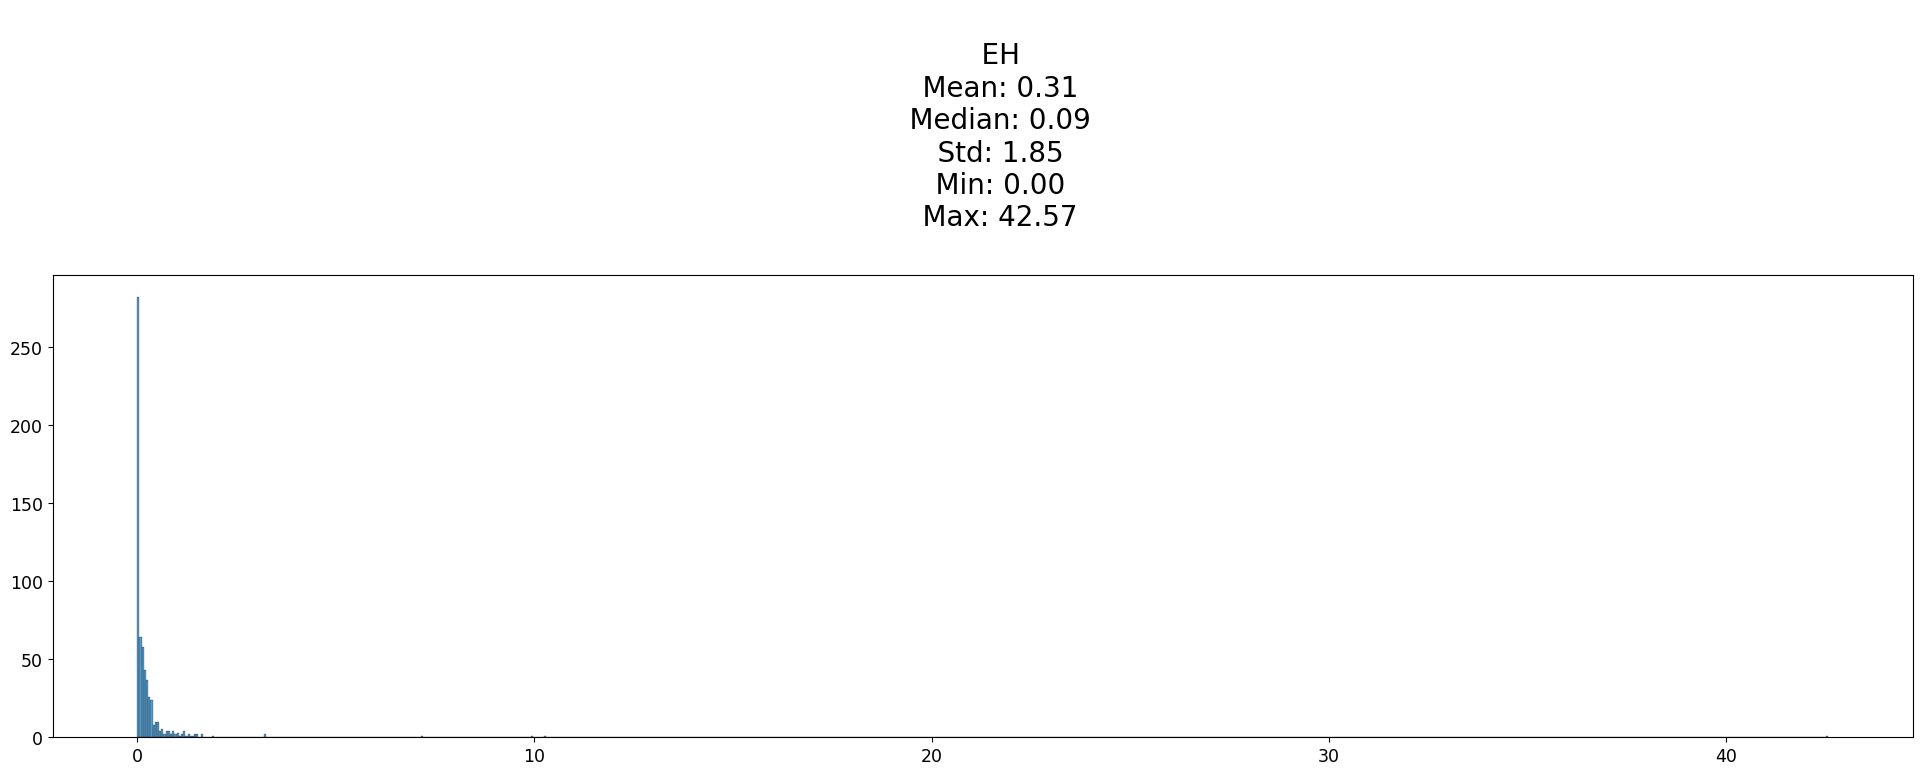

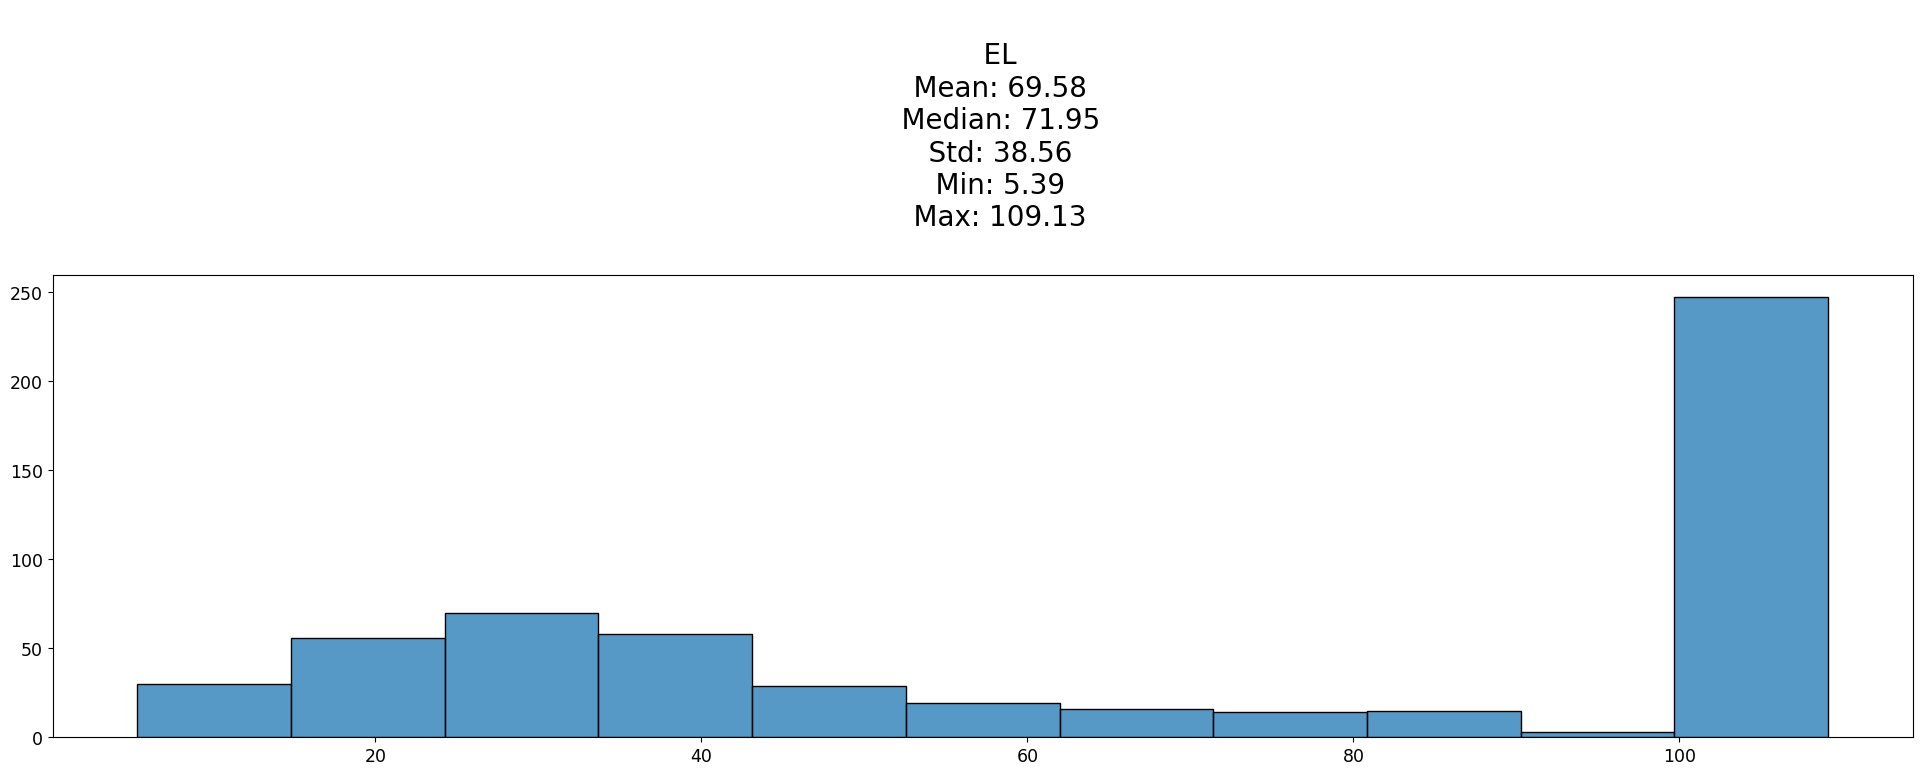

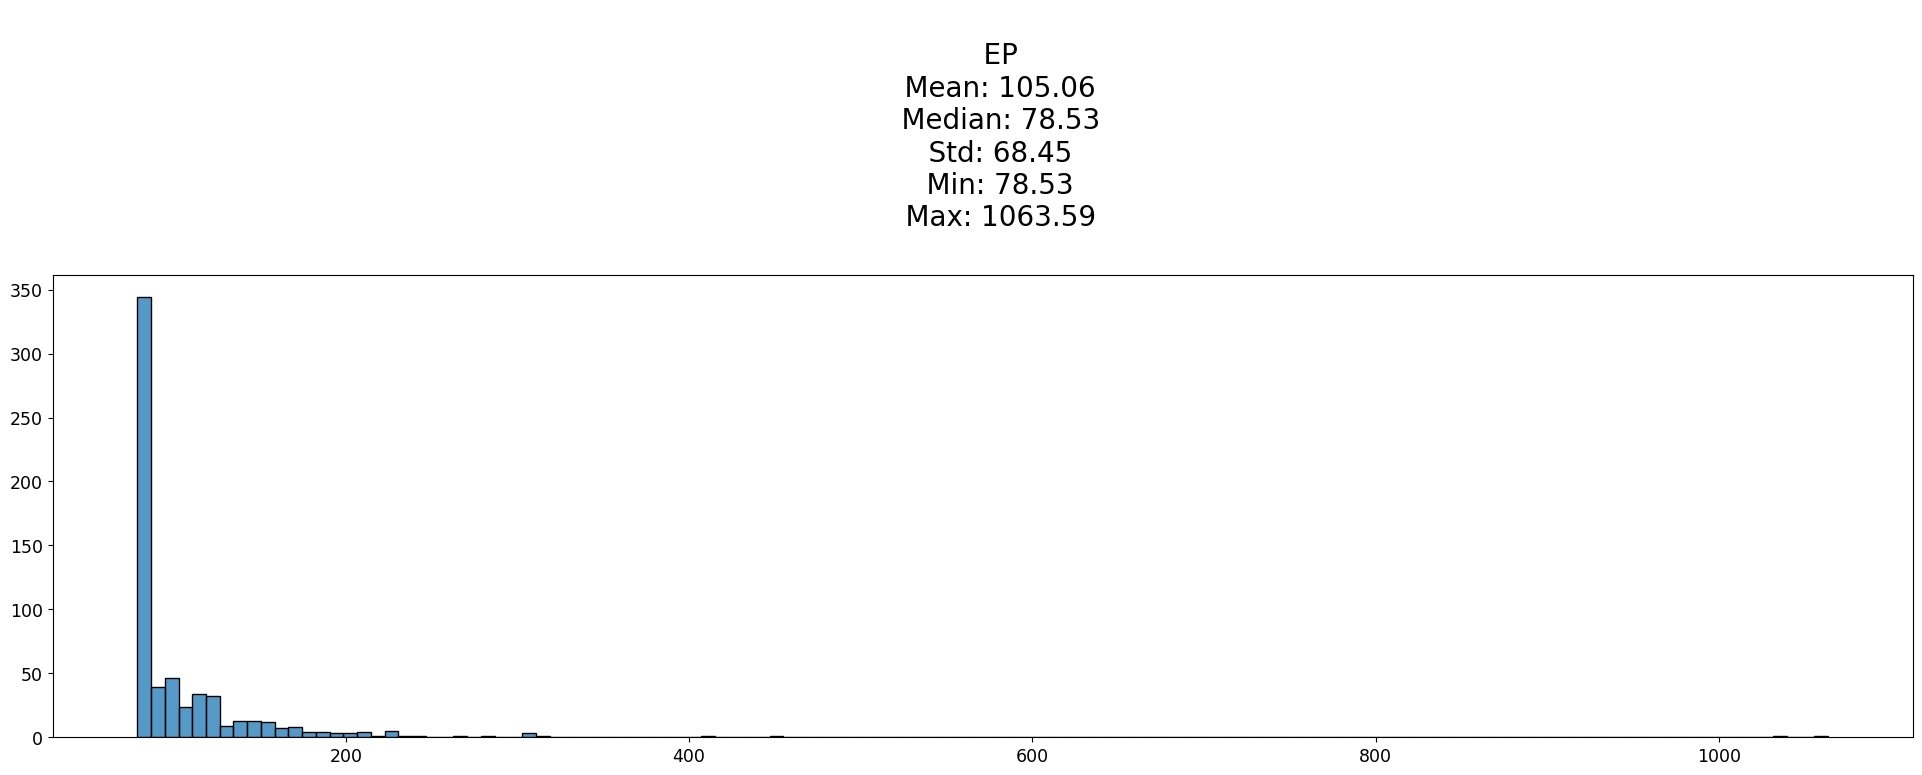

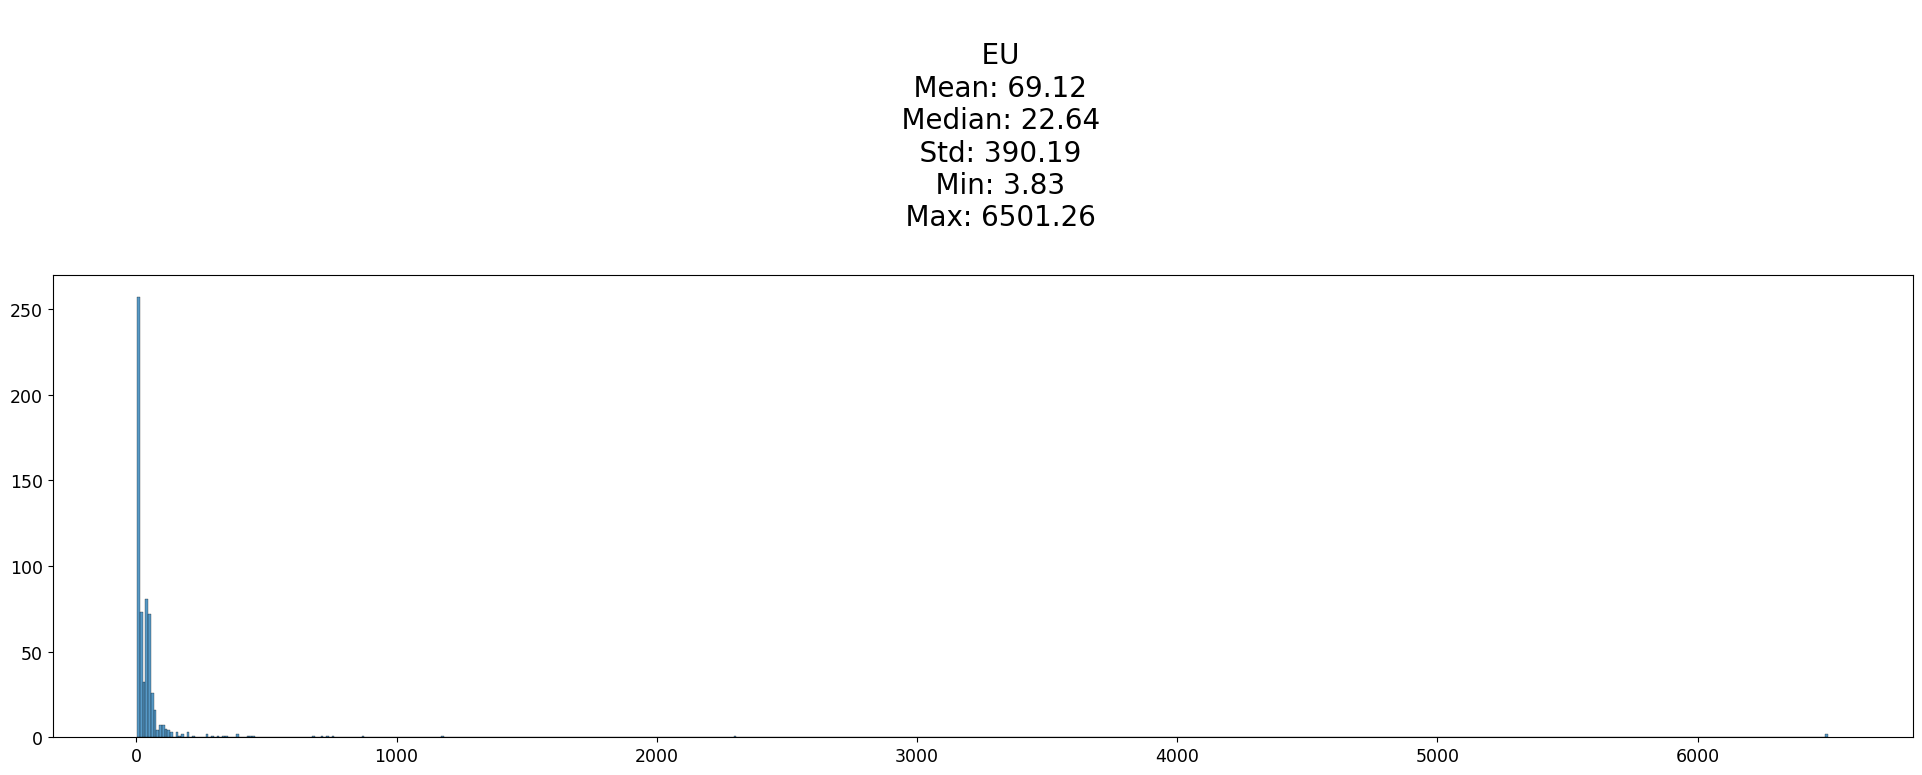

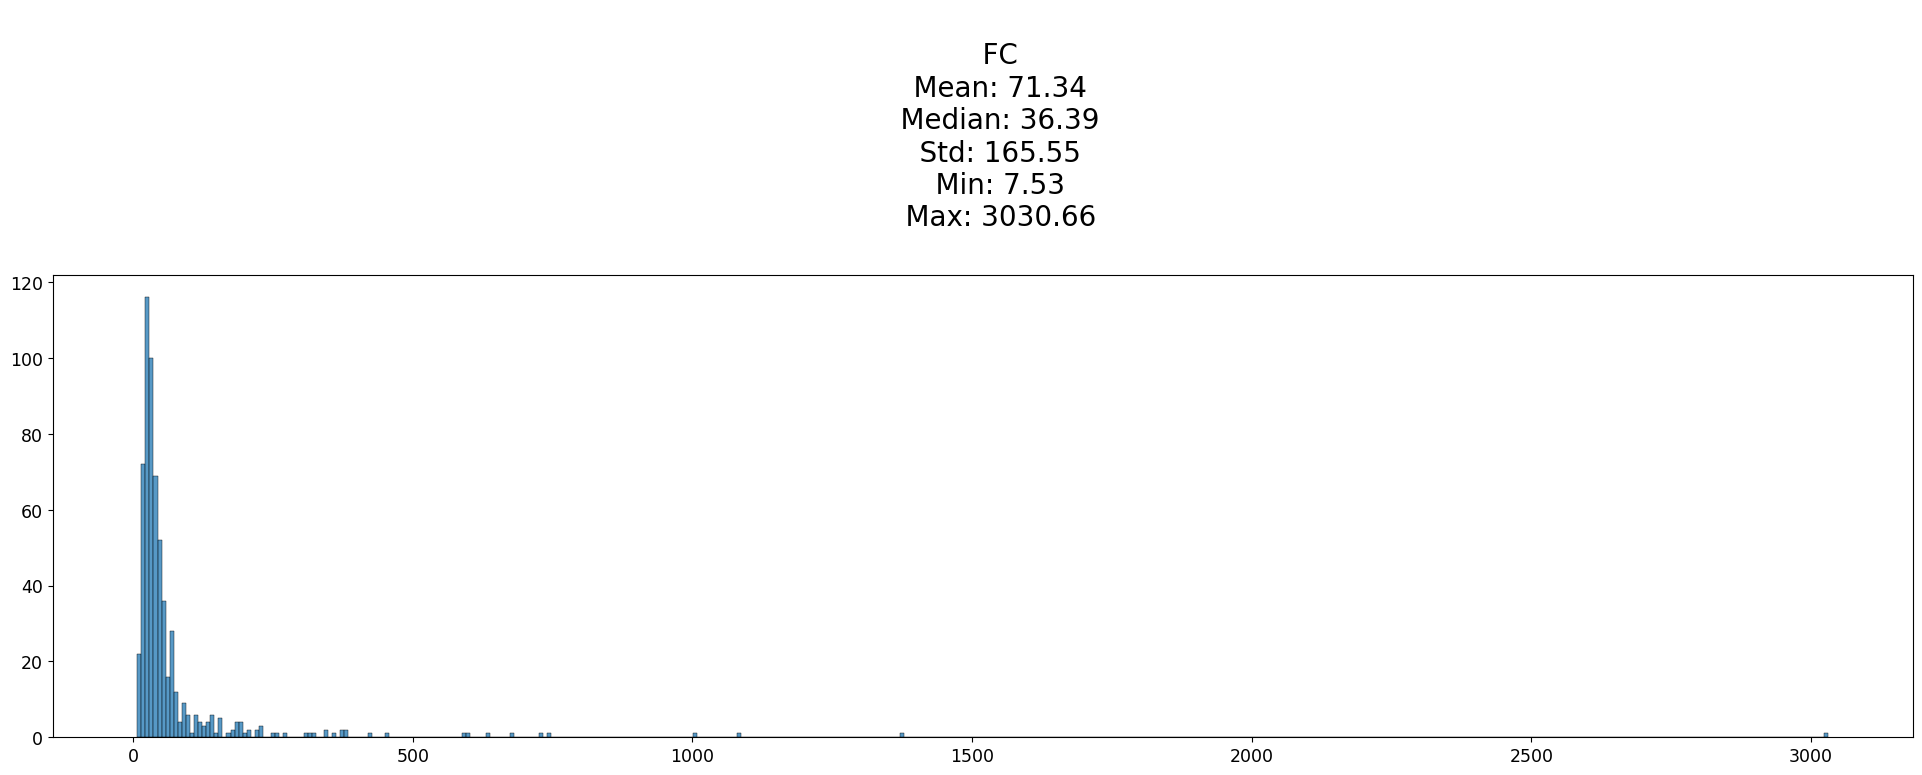

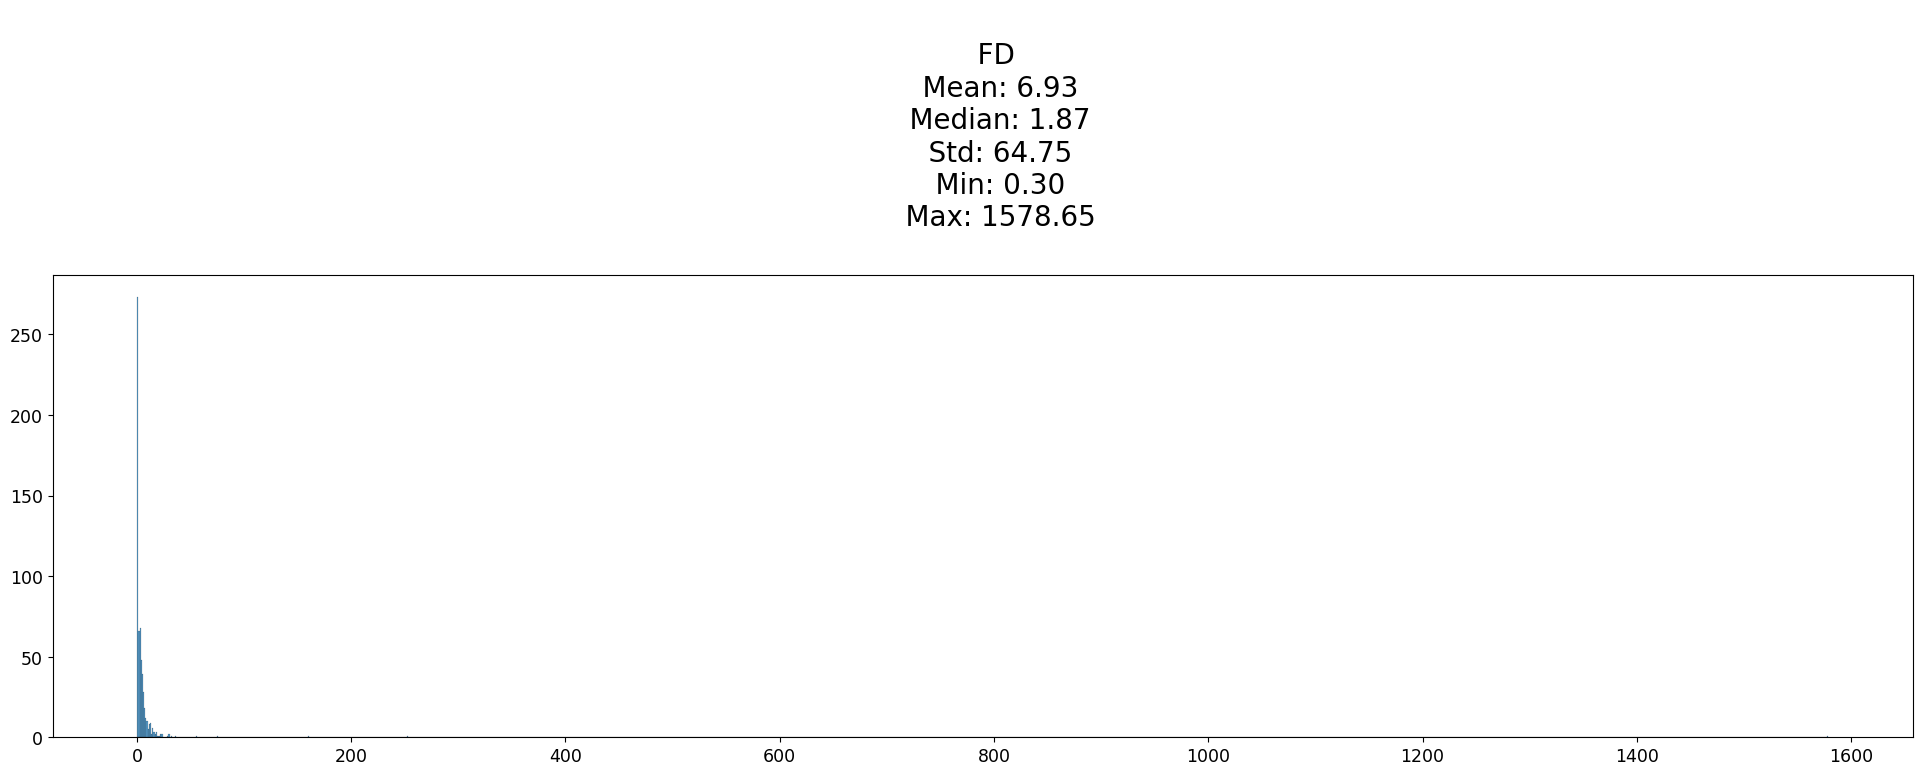

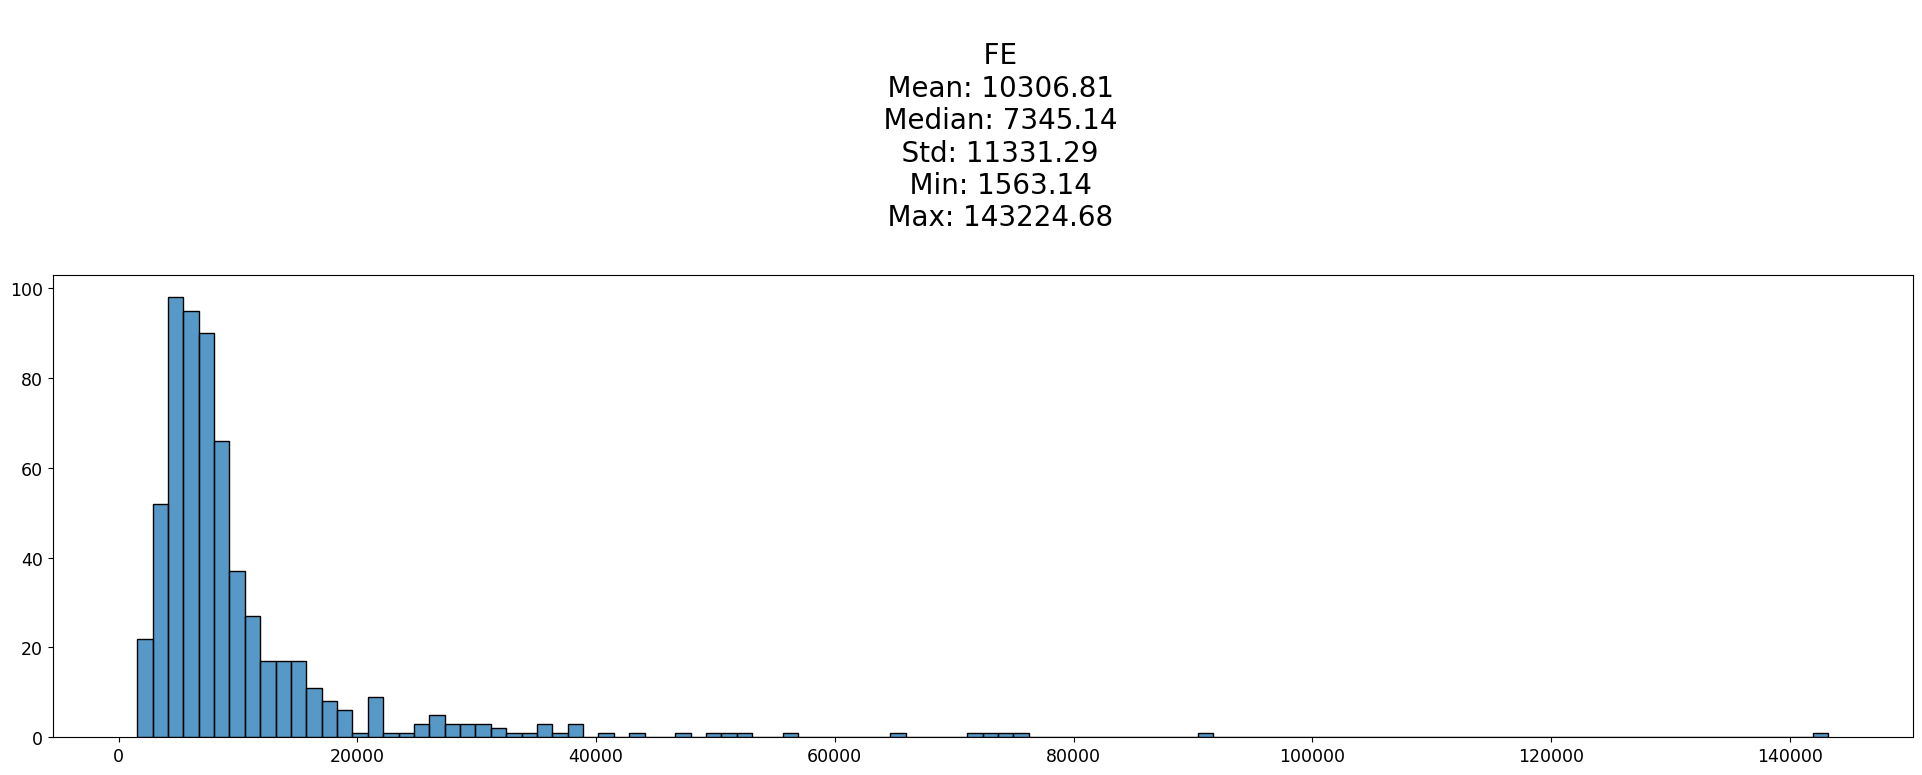

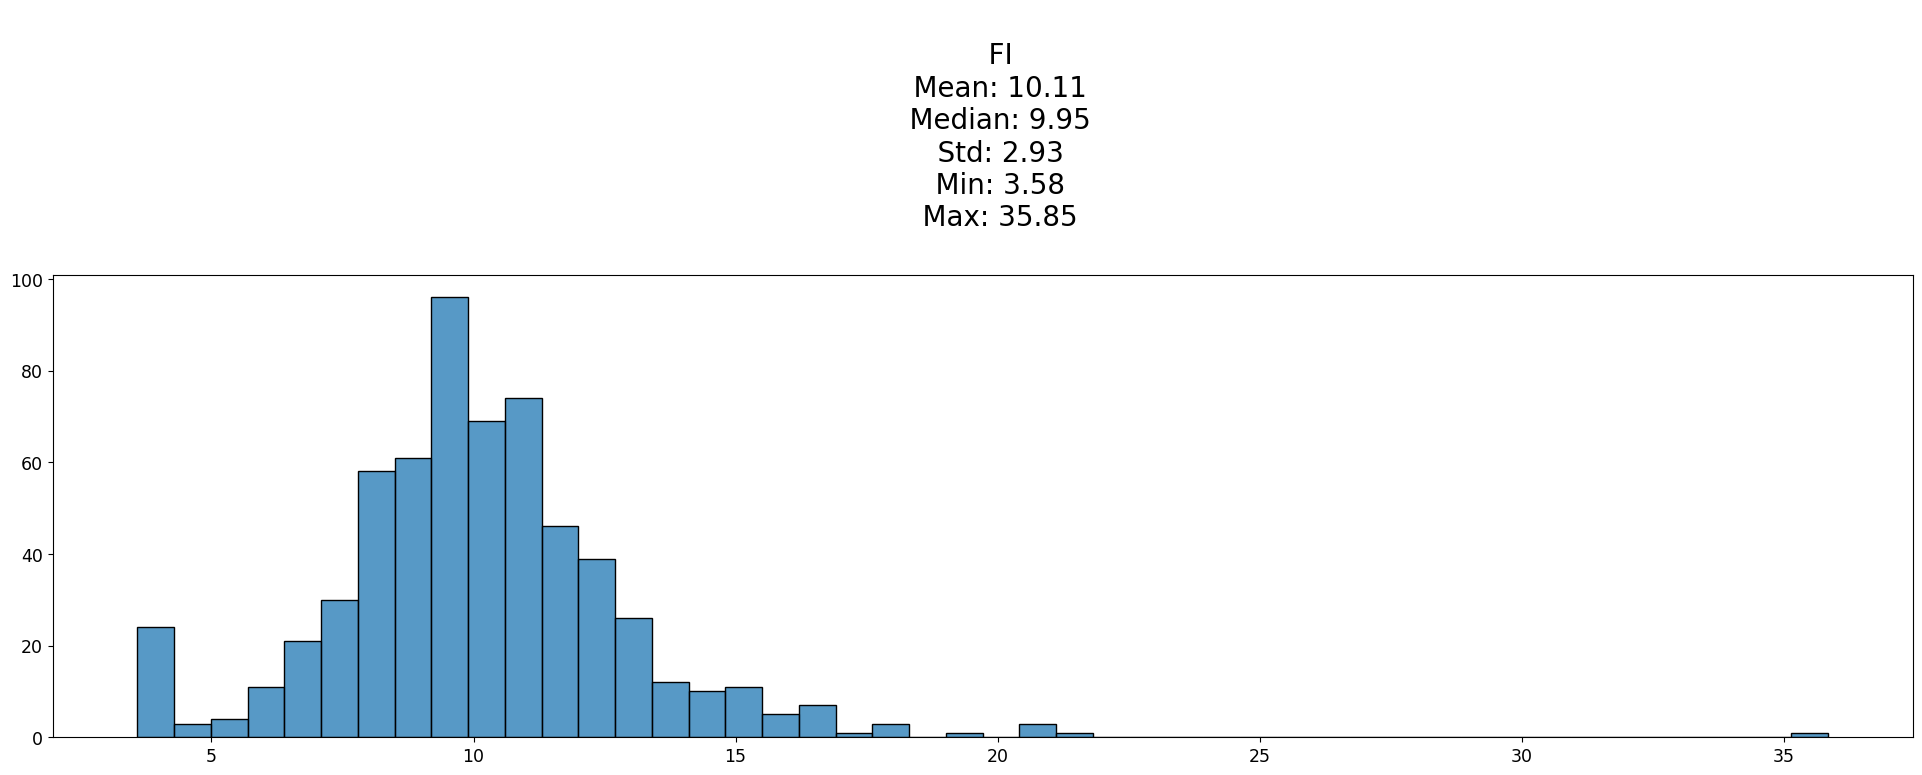

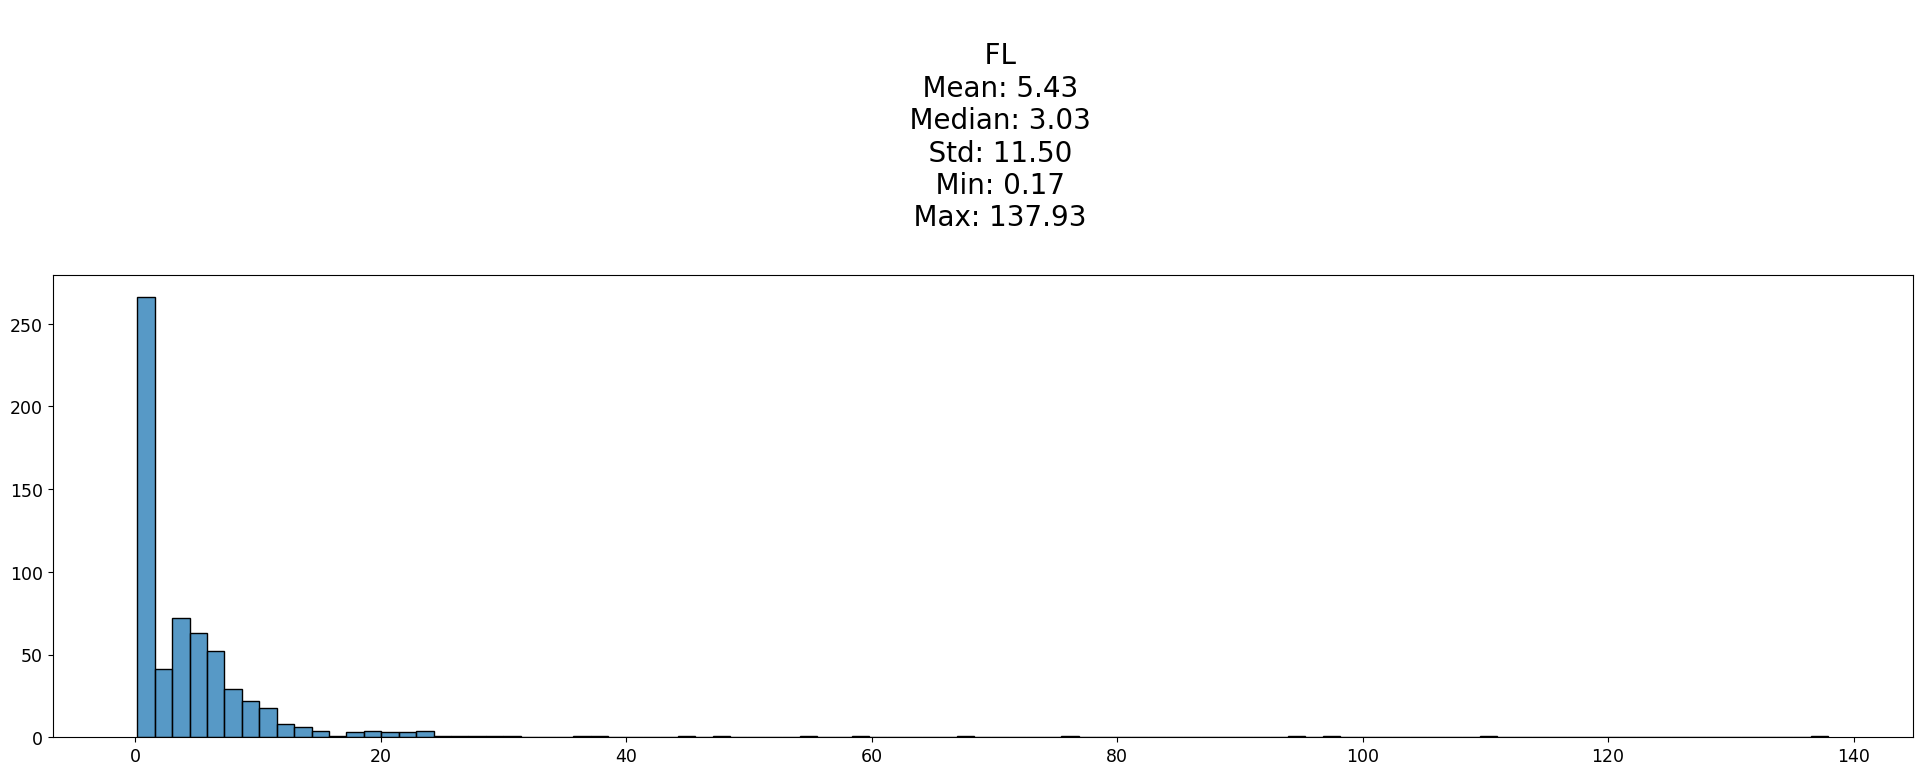

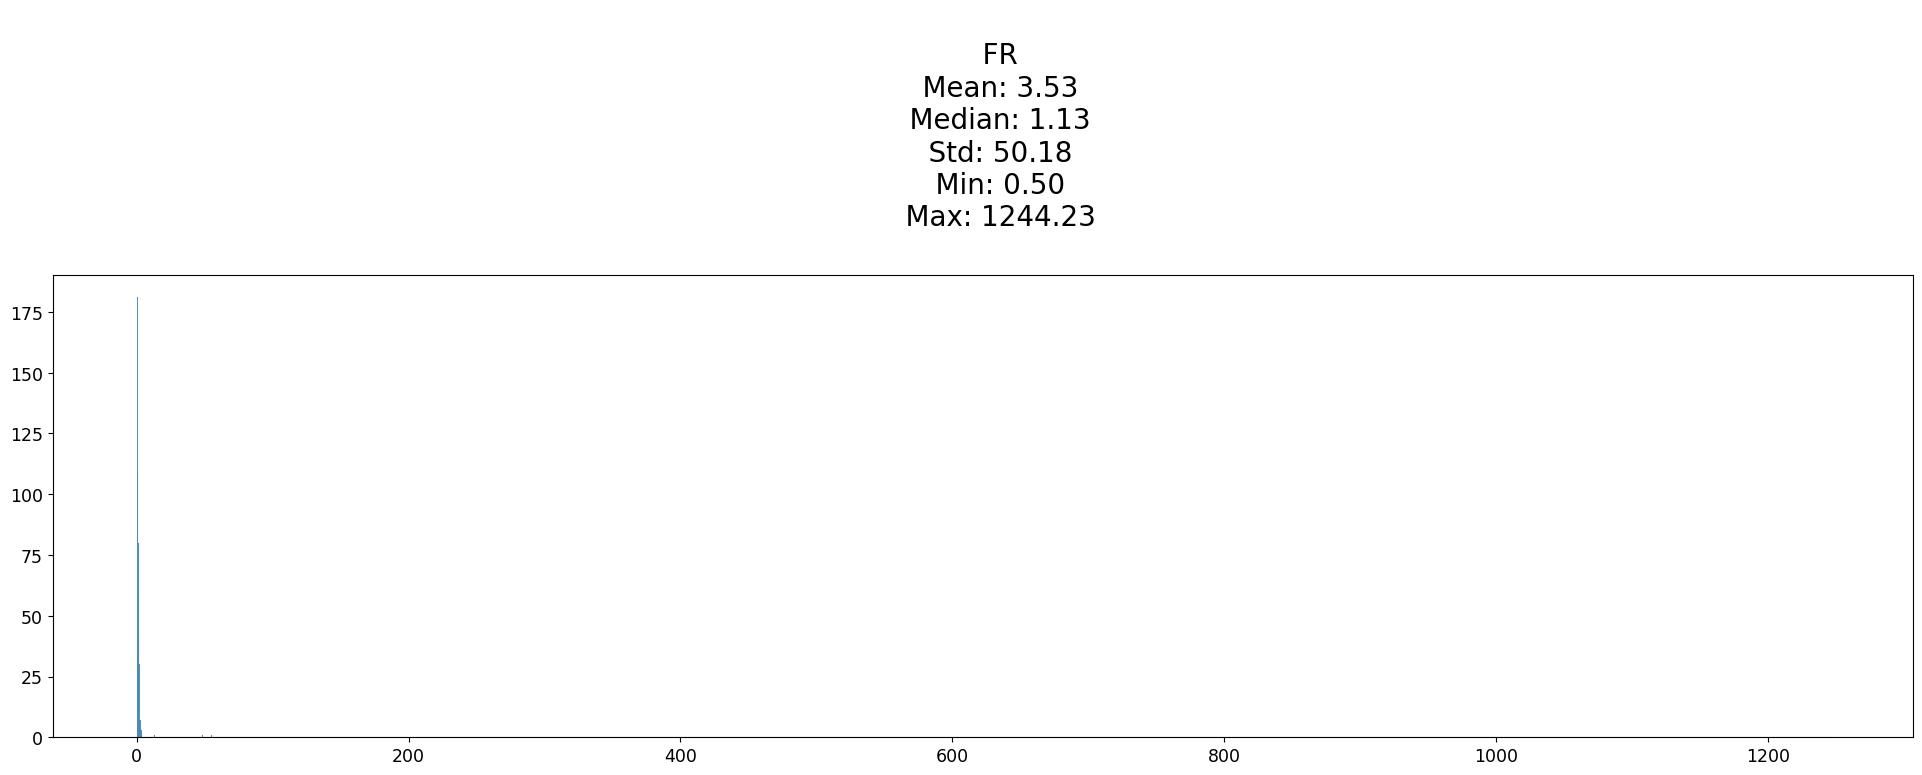

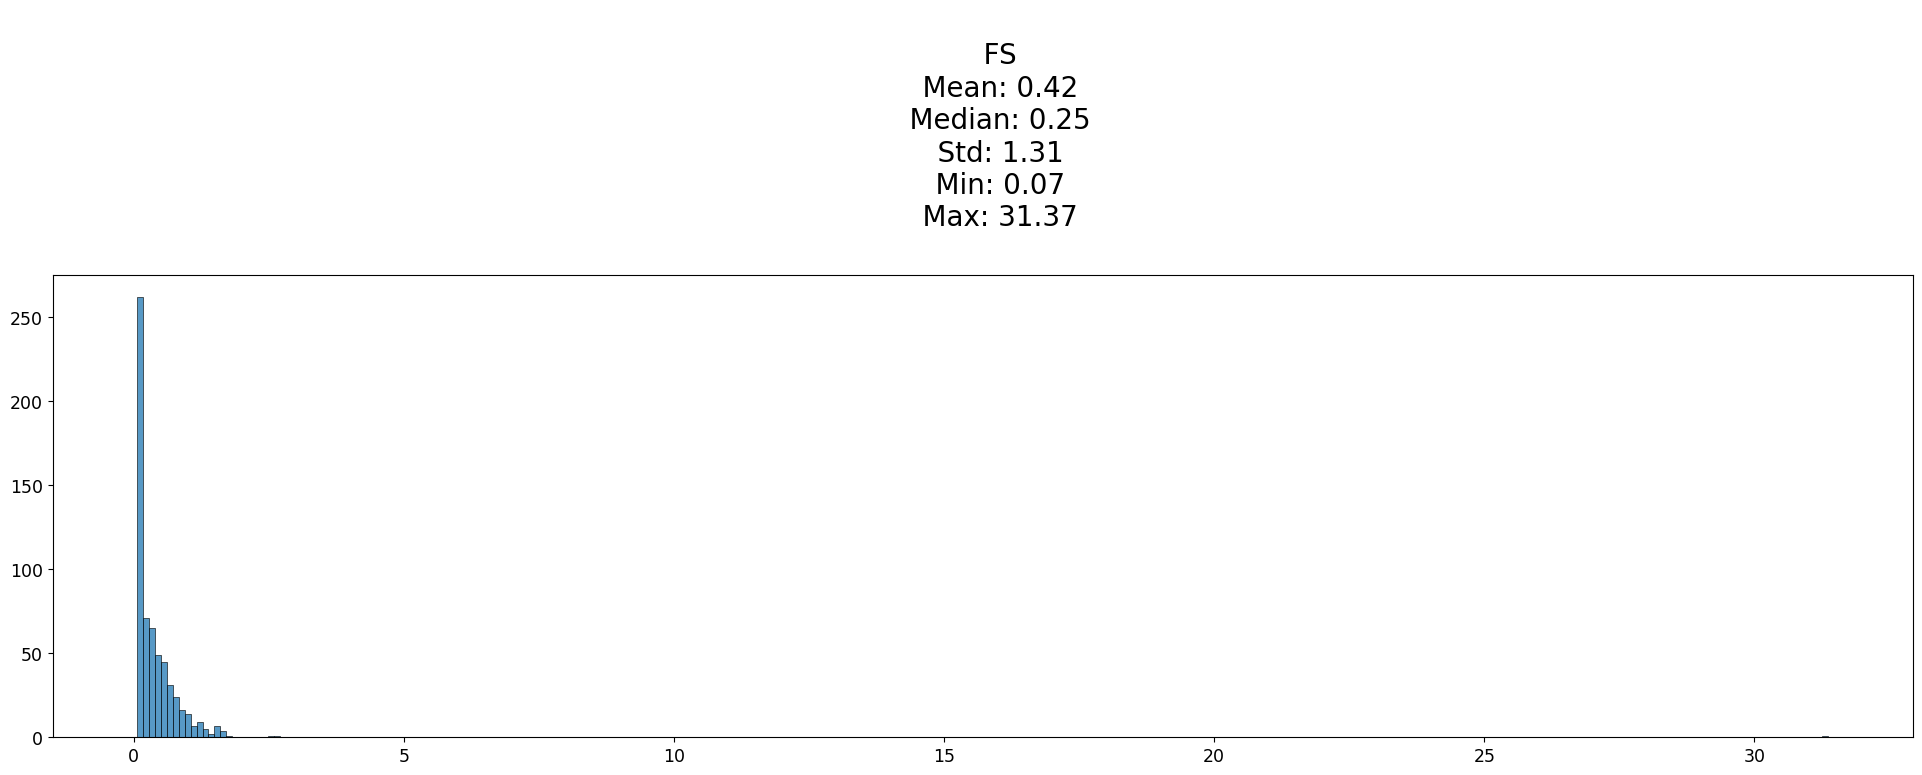

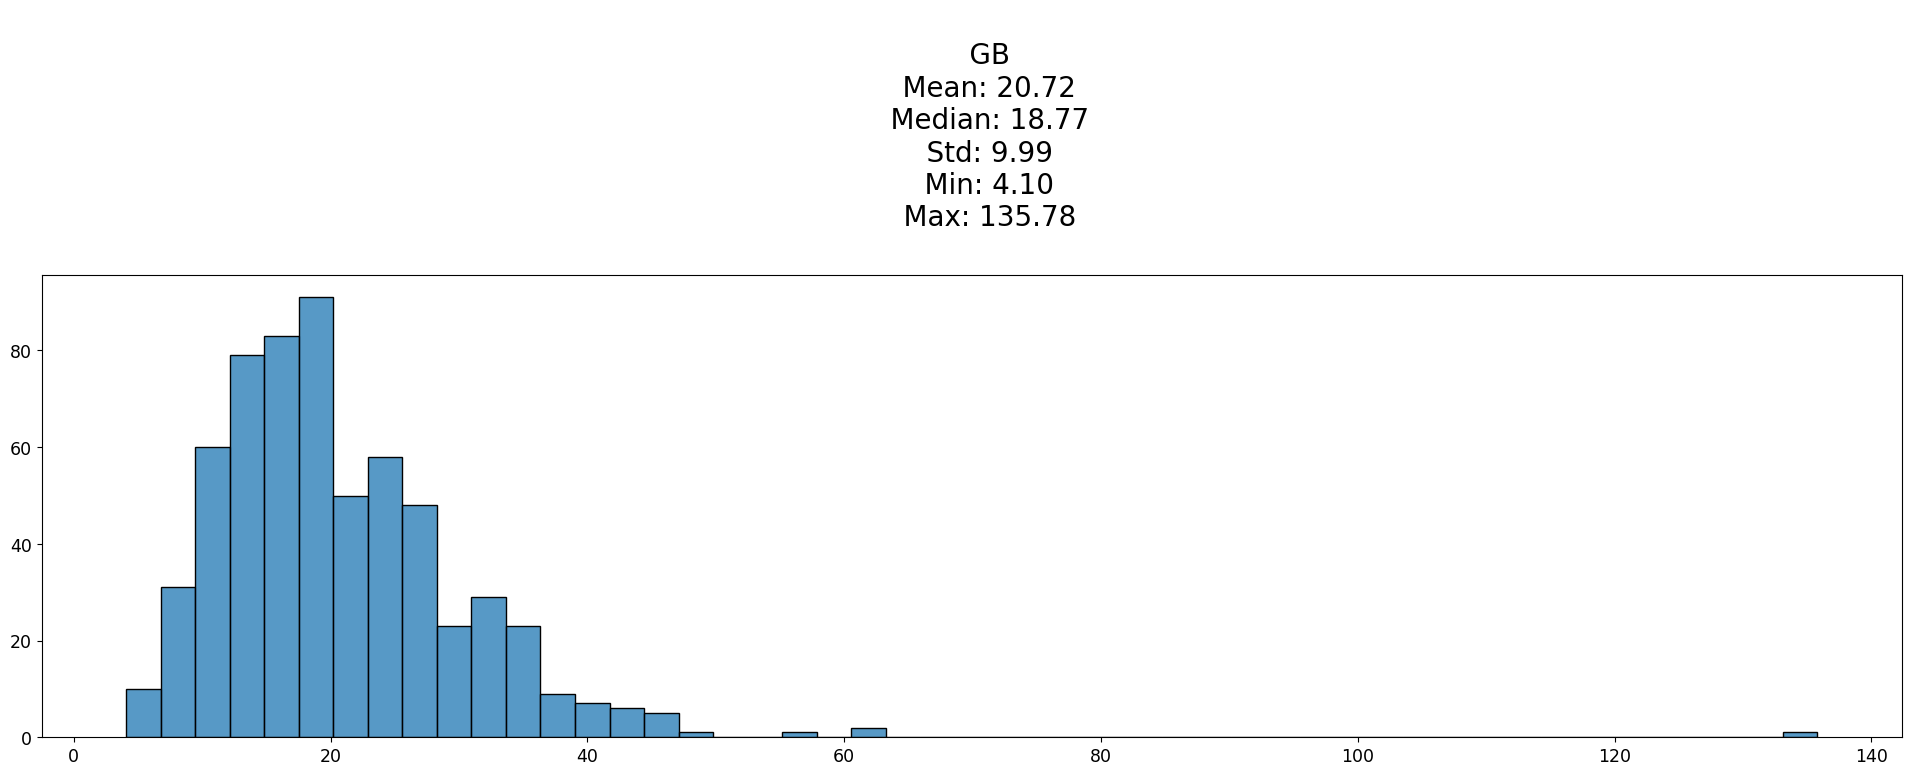

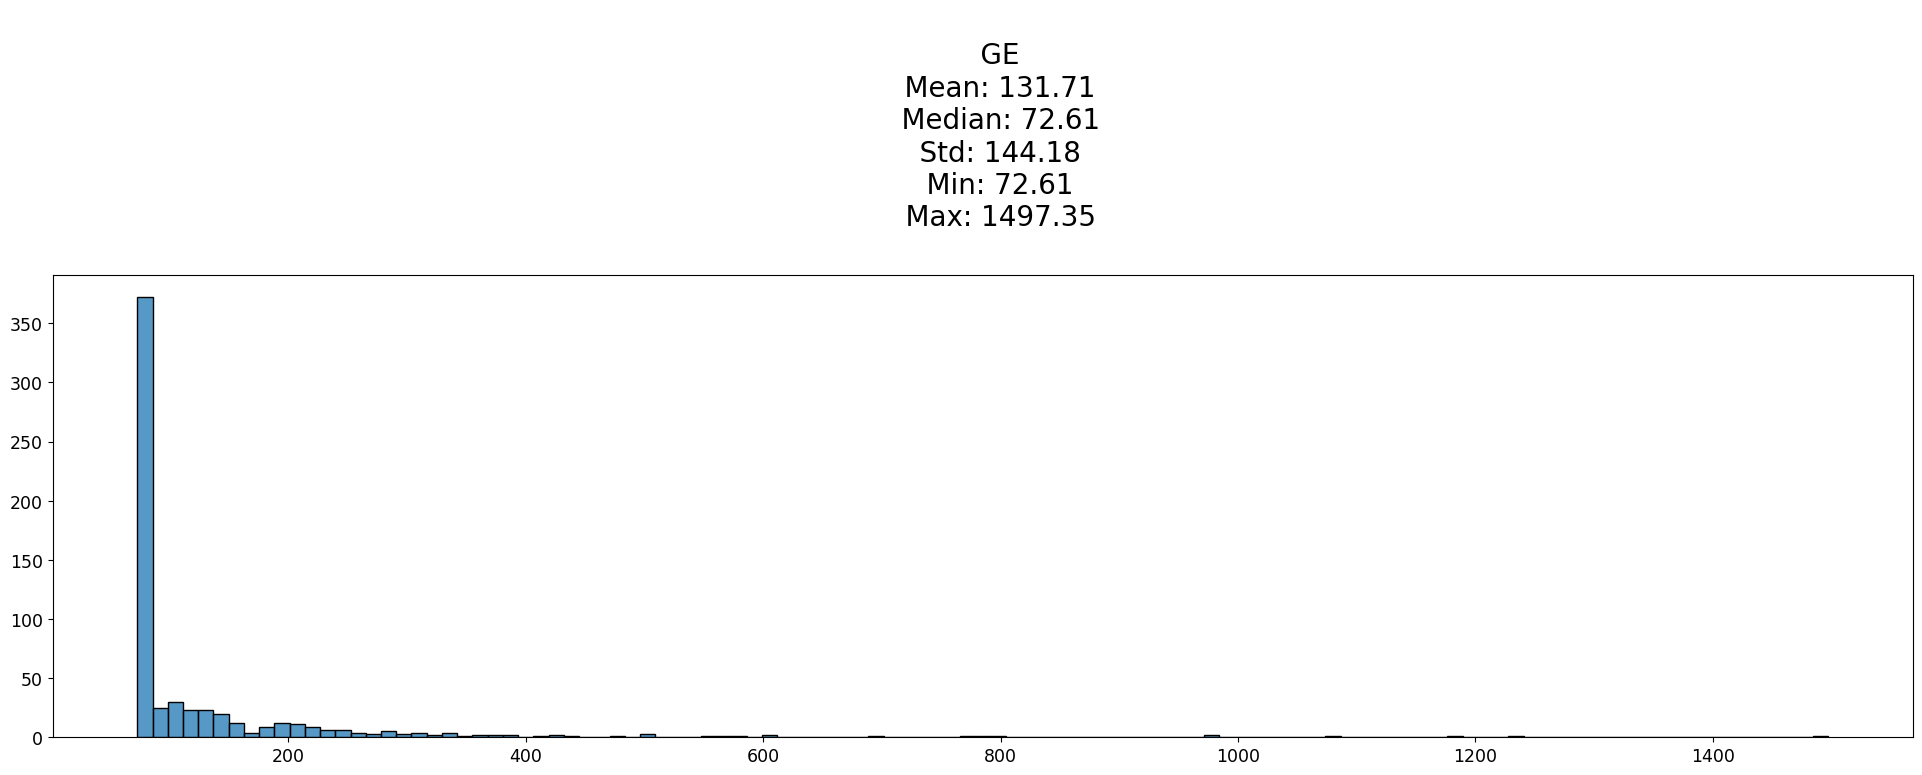

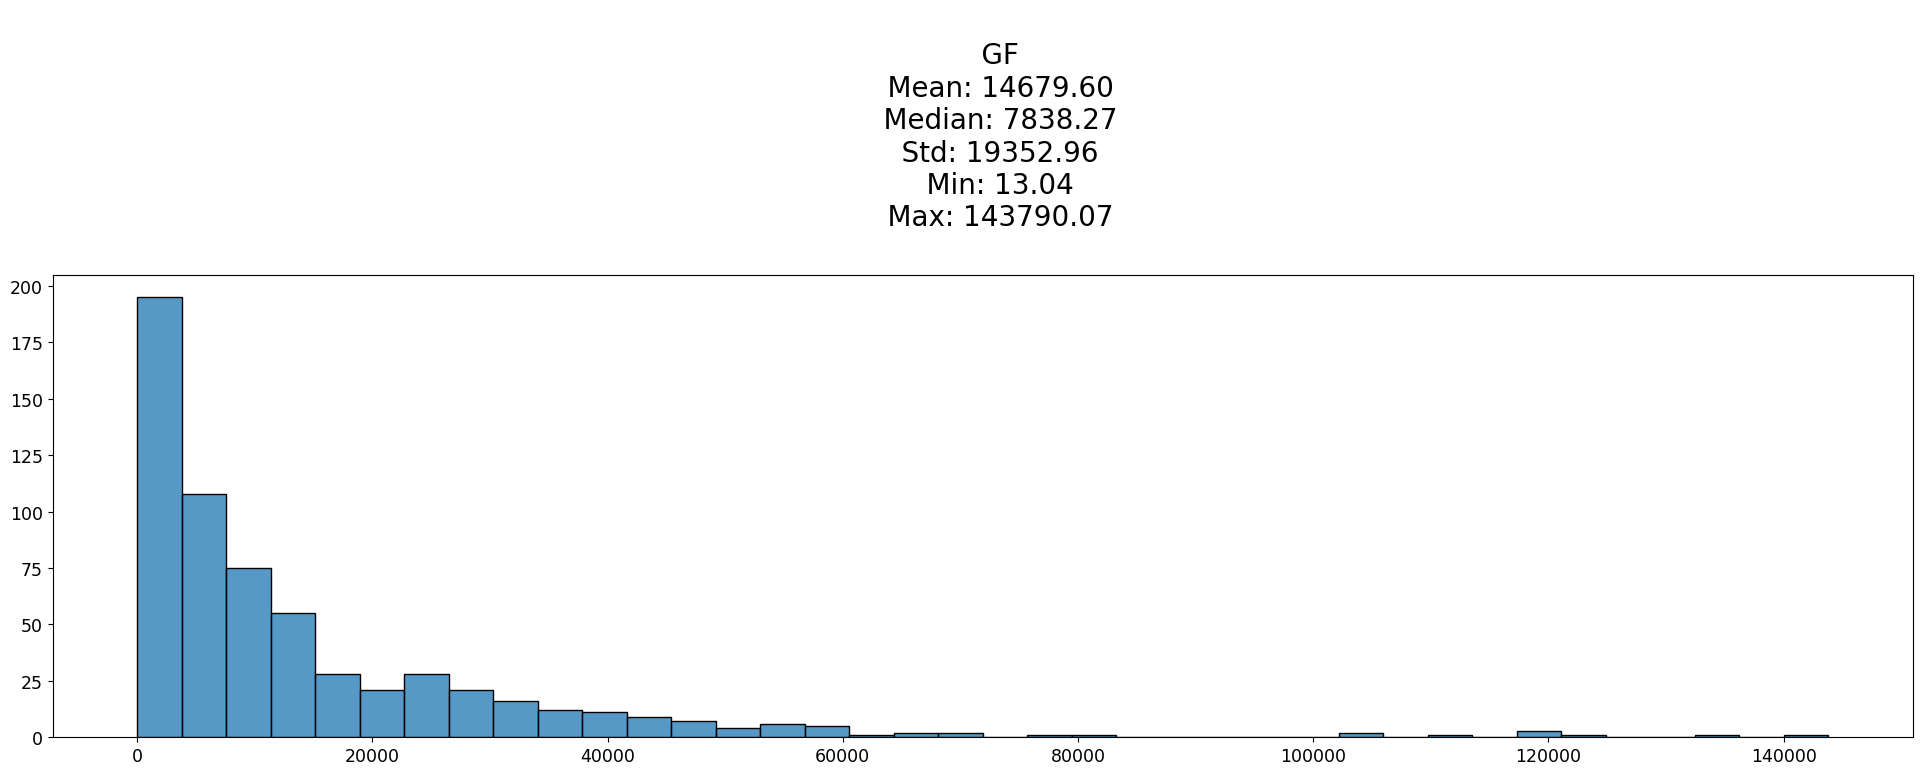

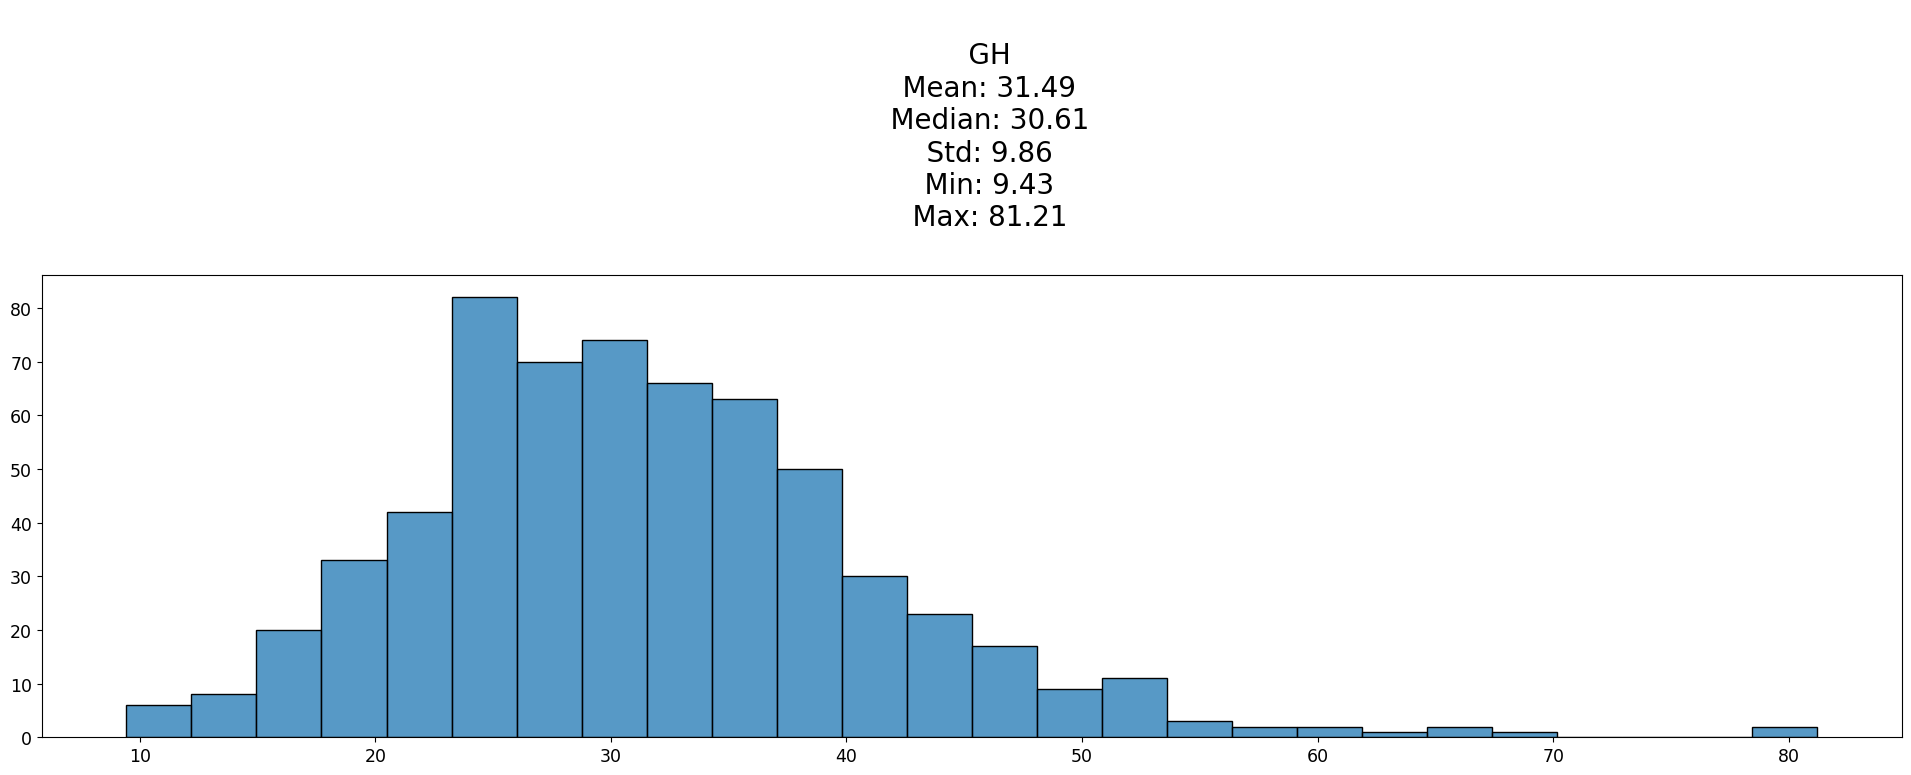

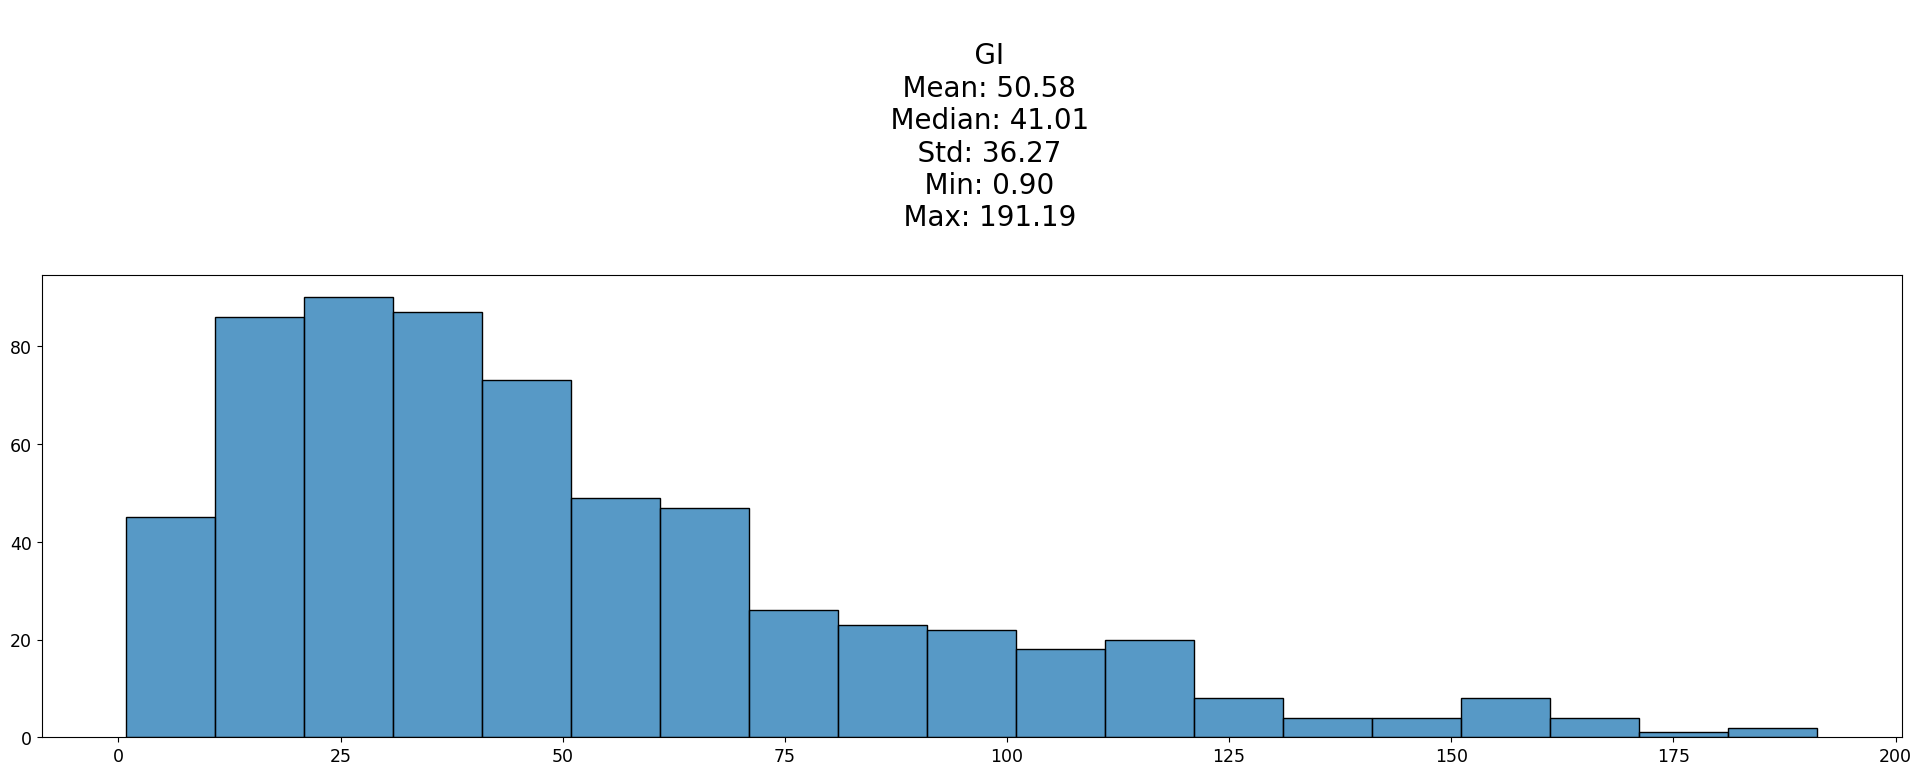

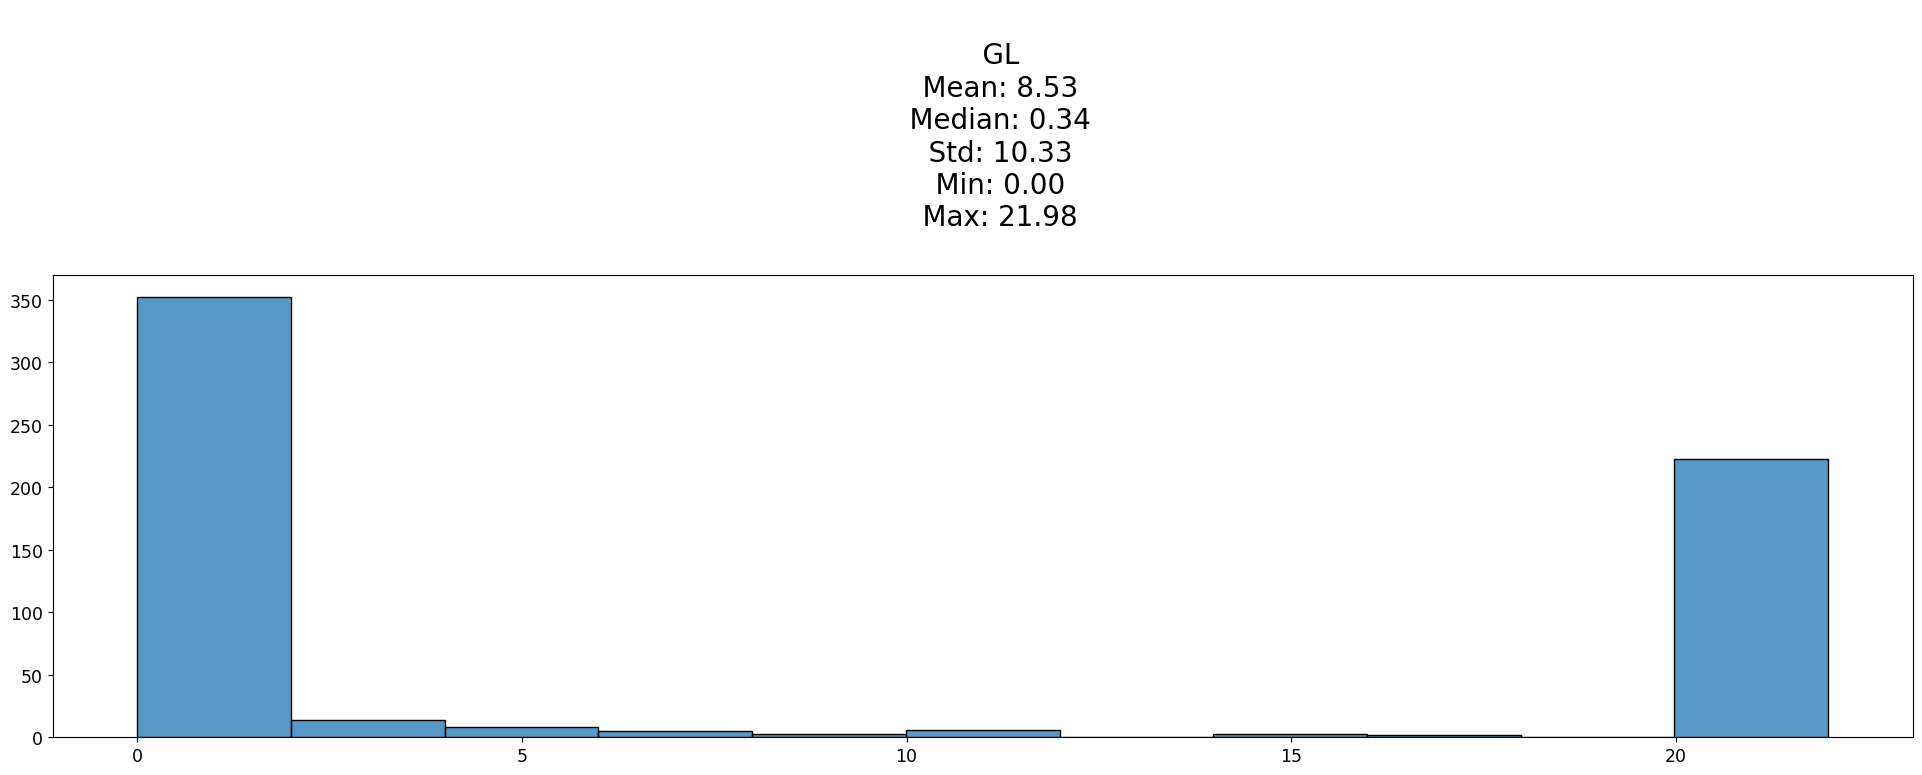

In [11]:
continuous_columns = [
    column for column in df_train.columns.tolist()
    if column not in ['Id', 'EJ', 'Class', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon']
]

for column in continuous_columns:
    visualize_continuous_data_histogram(df=df_train, column=column, log_scale=False)

## 6. Categorical Characteristics

Counts of categorical health characteristics are visualized below.

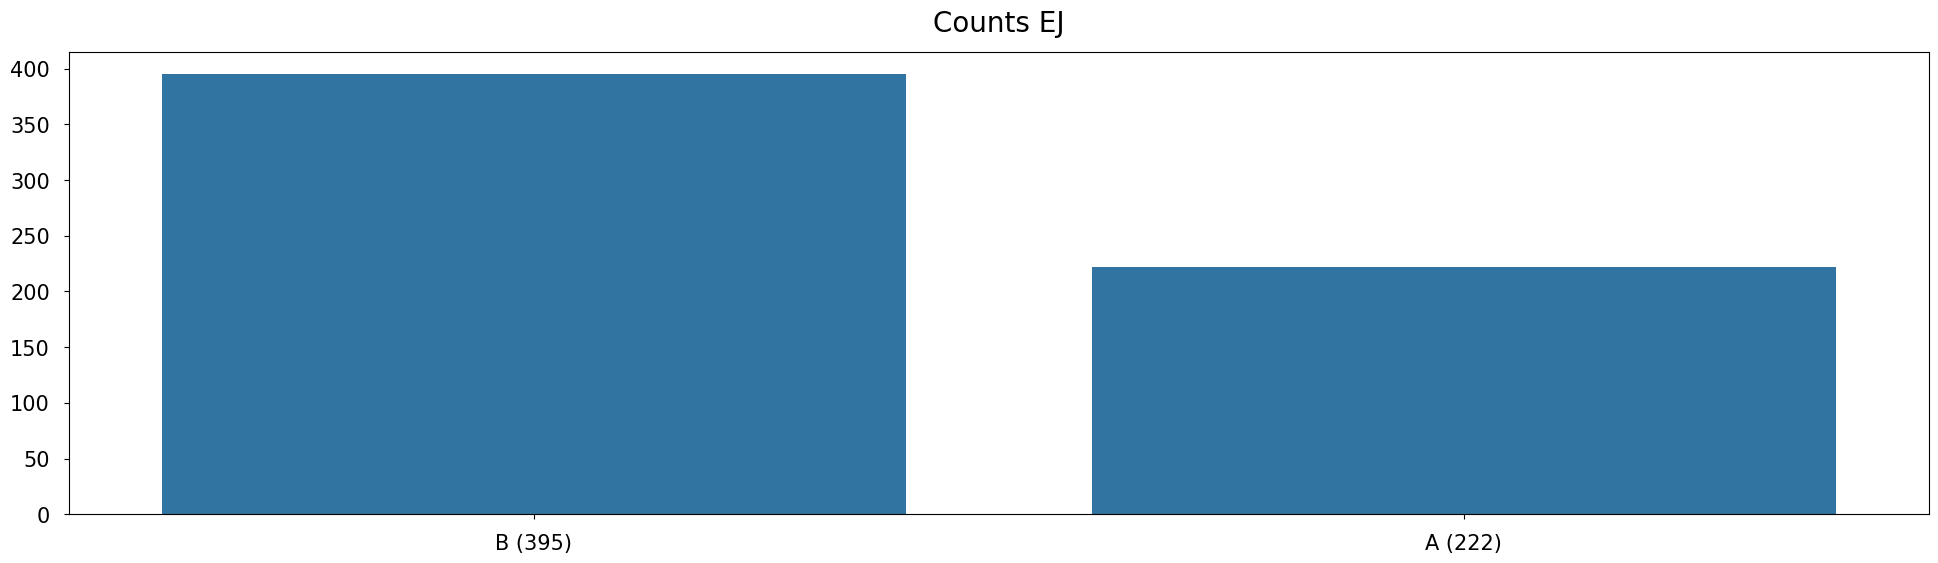

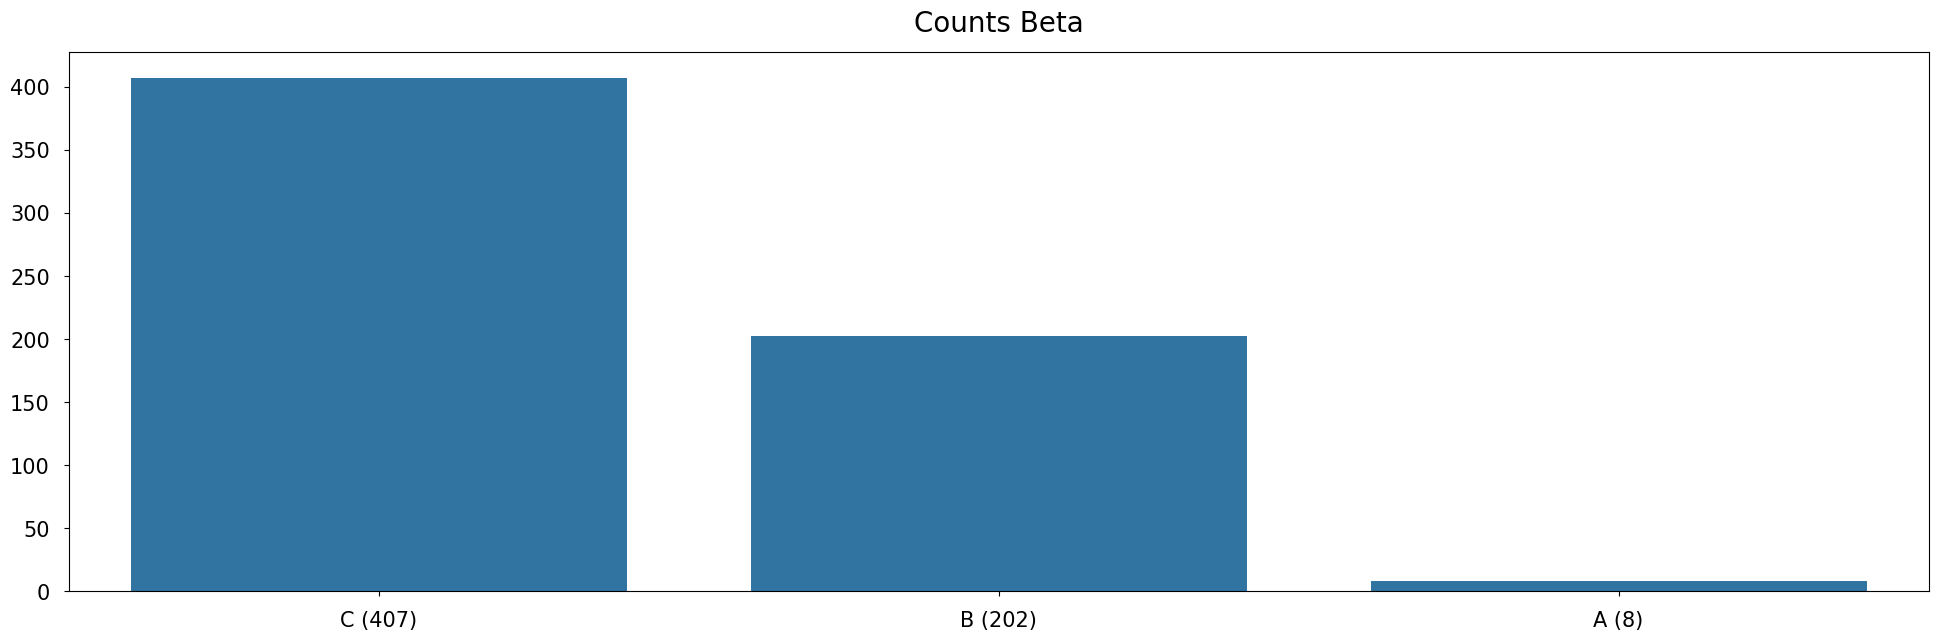

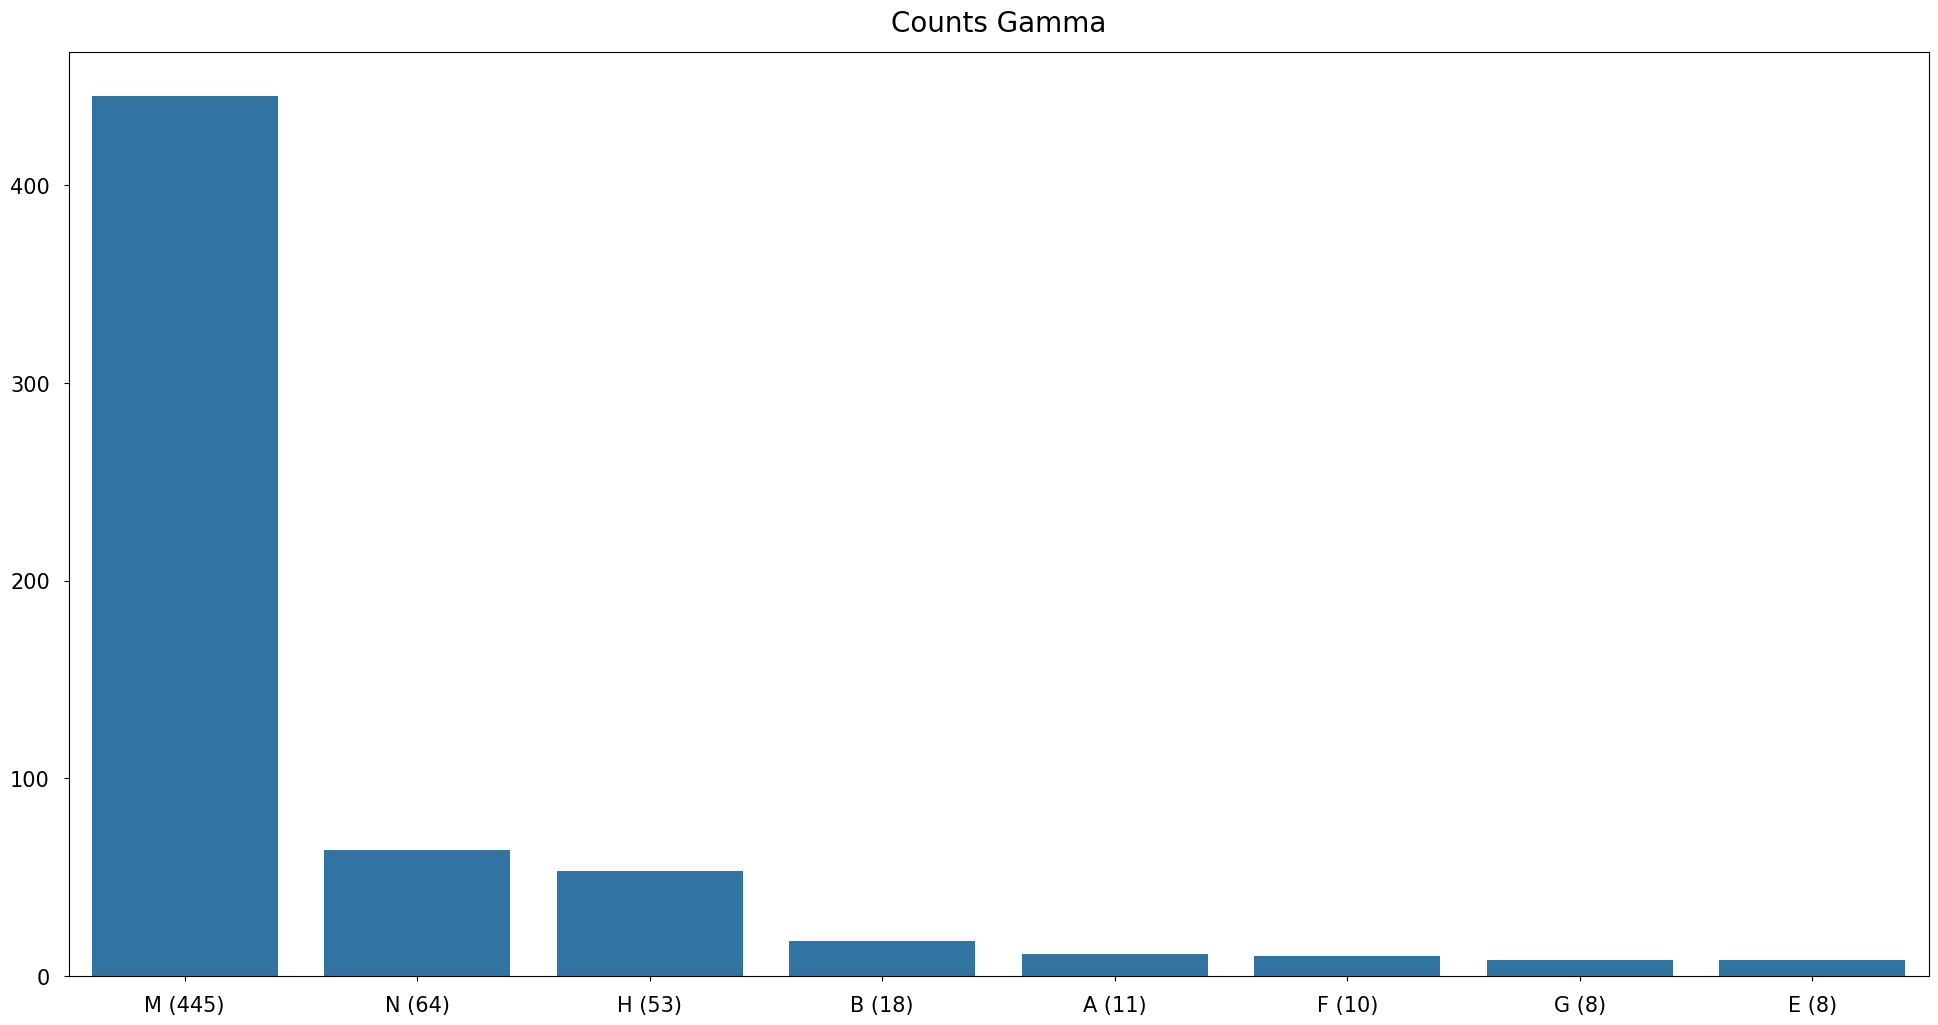

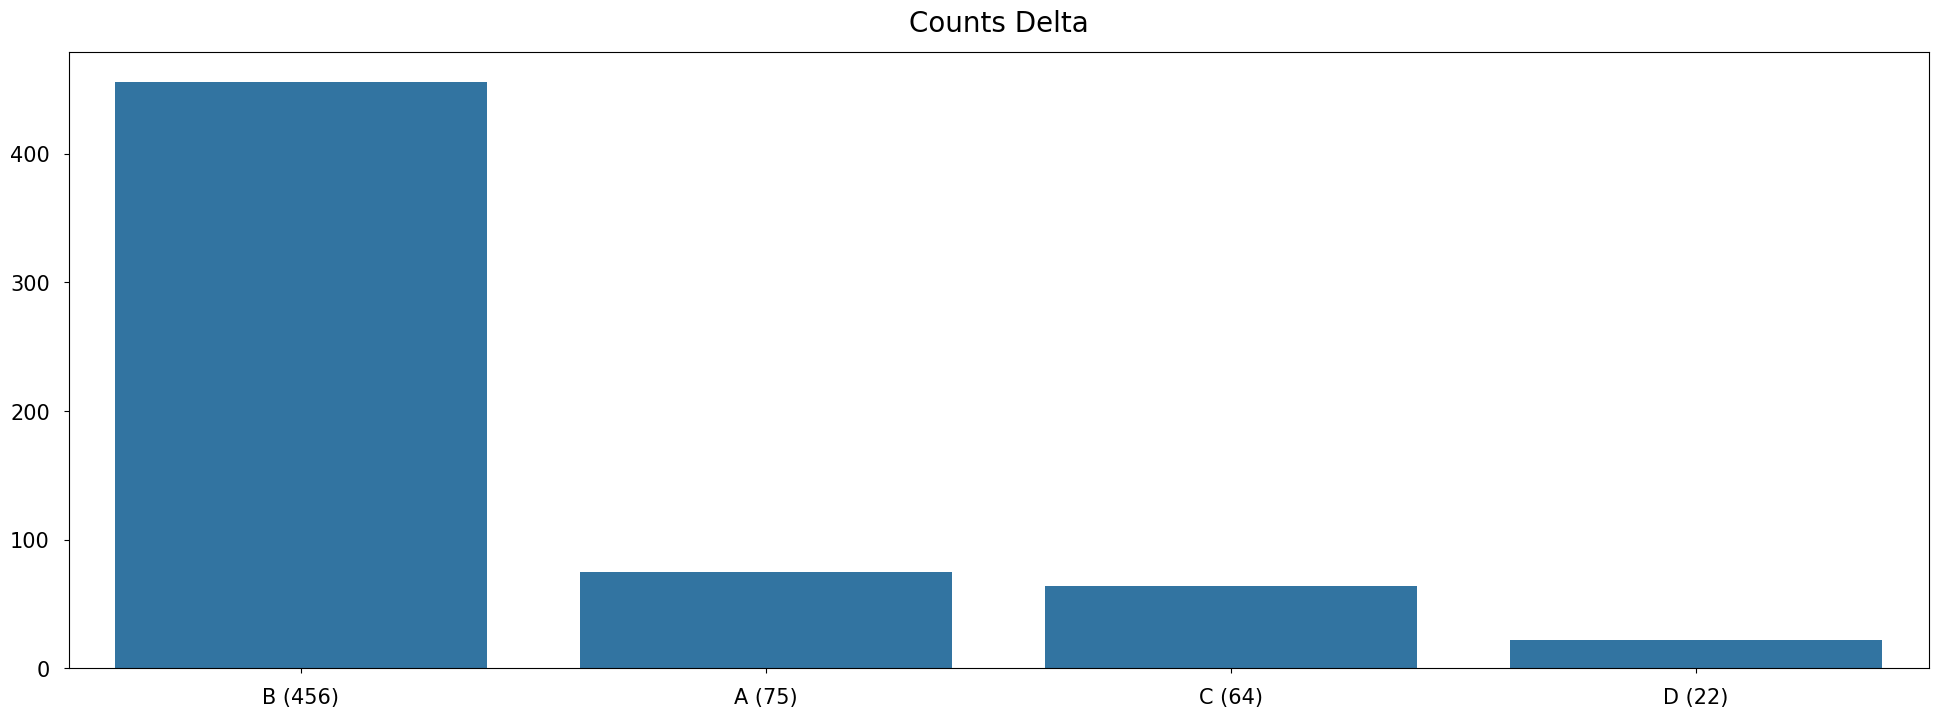

In [12]:
categorical_columns = ['EJ', 'Beta', 'Gamma', 'Delta']

for column in categorical_columns:
    visualize_categorical_column_counts(df=df_train, column=column)

## 7. Date

As mentioned before, dates of subjects are also provided in Greeks. However, dates of **144** out of 617 samples are unknown and their values are labeled as `Unknown`.

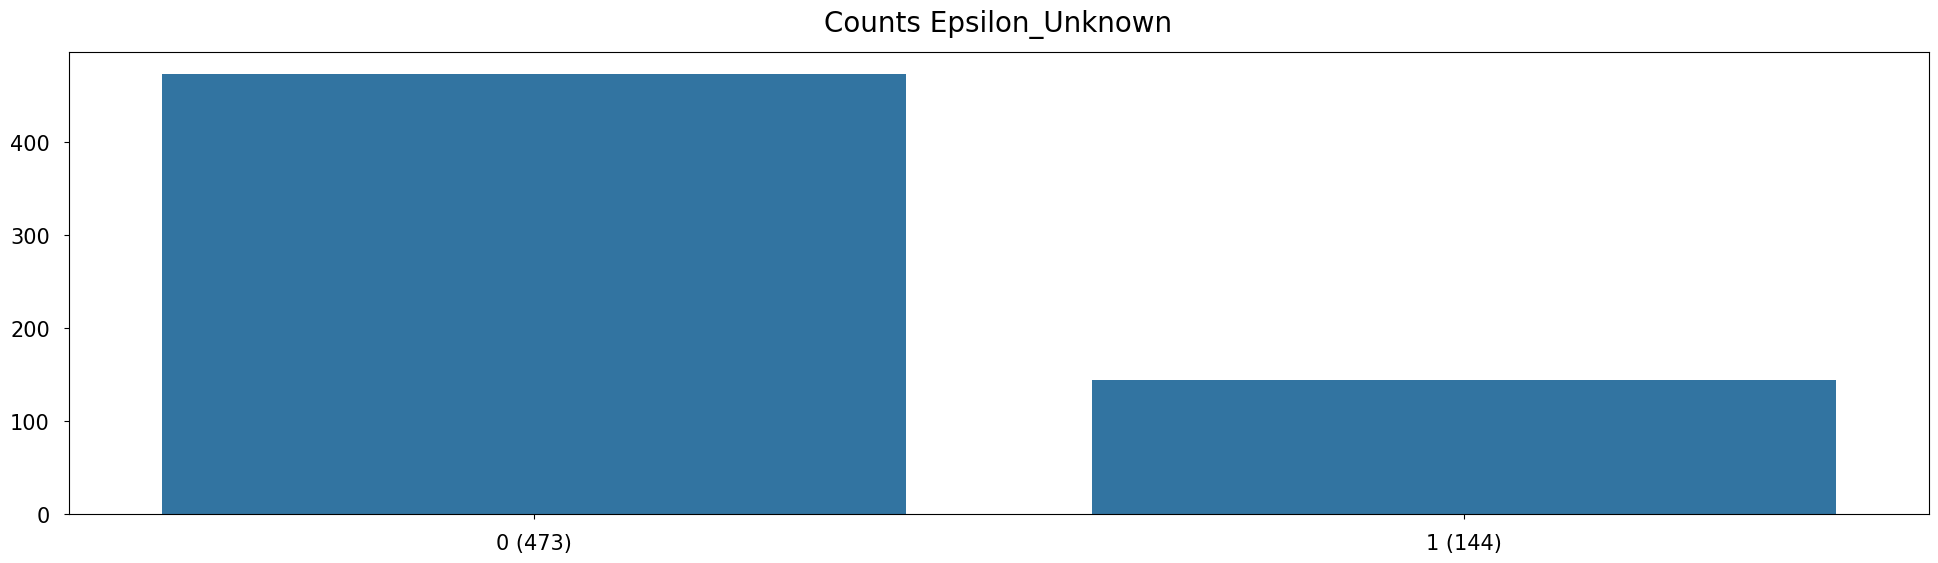

In [13]:
df_train['Epsilon_Unknown'] = (df_train['Epsilon'] == 'Unknown').astype(np.uint8)
visualize_categorical_column_counts(df=df_train, column='Epsilon_Unknown')
df_train.drop(columns=['Epsilon_Unknown'], inplace=True)

It would be reasonable to replace `Unknown` values with `NaN`s in `Epsilon` column and sort training set by date in ascending order.

In [14]:
df_train.loc[df_train['Epsilon'] == 'Unknown', 'Epsilon'] = np.nan
df_train['Epsilon'] = pd.to_datetime(df_train['Epsilon'])
df_train = df_train.sort_values(by='Epsilon', ascending=True).reset_index(drop=True)

Sorting the training set by date reveals another missing value pattern. Missing values don't exist randomly but they do exist on certain dates. In addition to that, last **144** values of the `Epsilon` are missing which is the exact amount of missing values in that column.

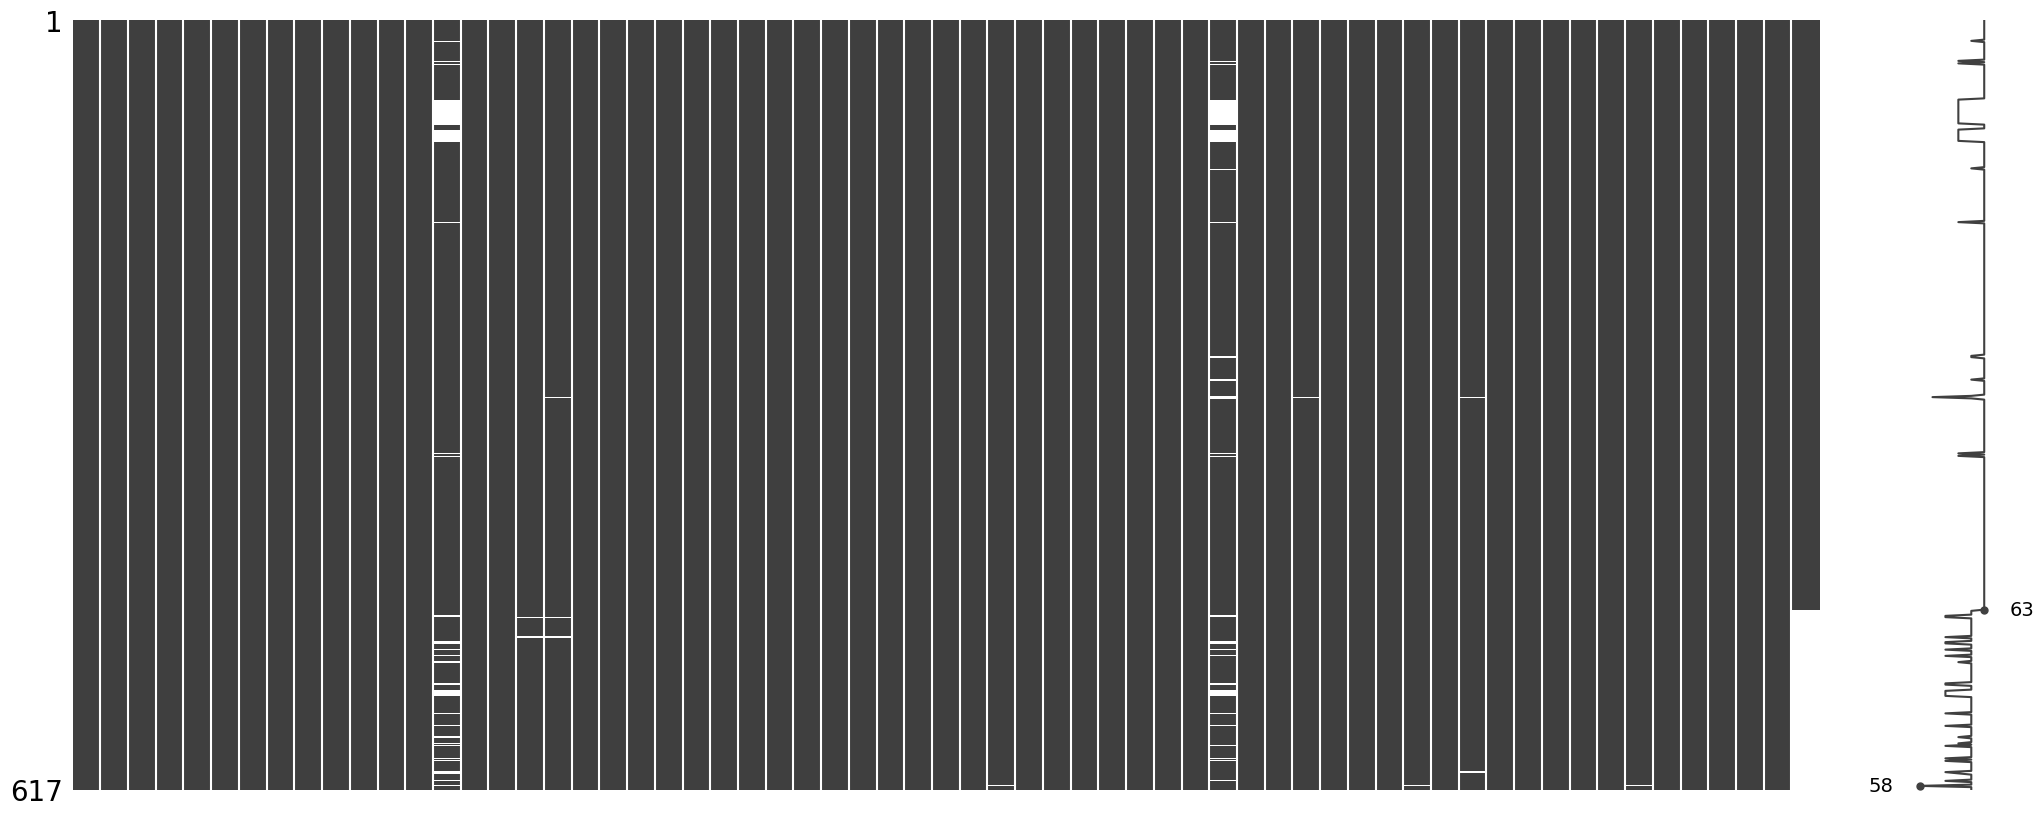

In [15]:
msno.matrix(df_train)
plt.show()

All of the health characteristics and `Class` columns are visualized as a function of date below.

* There aren't any visible dependencies between date and other variables
* Outliers become more visible in these visualizations and they could be related to certain dates
* There are very few observations before 2019 and they may not represent more recent ones


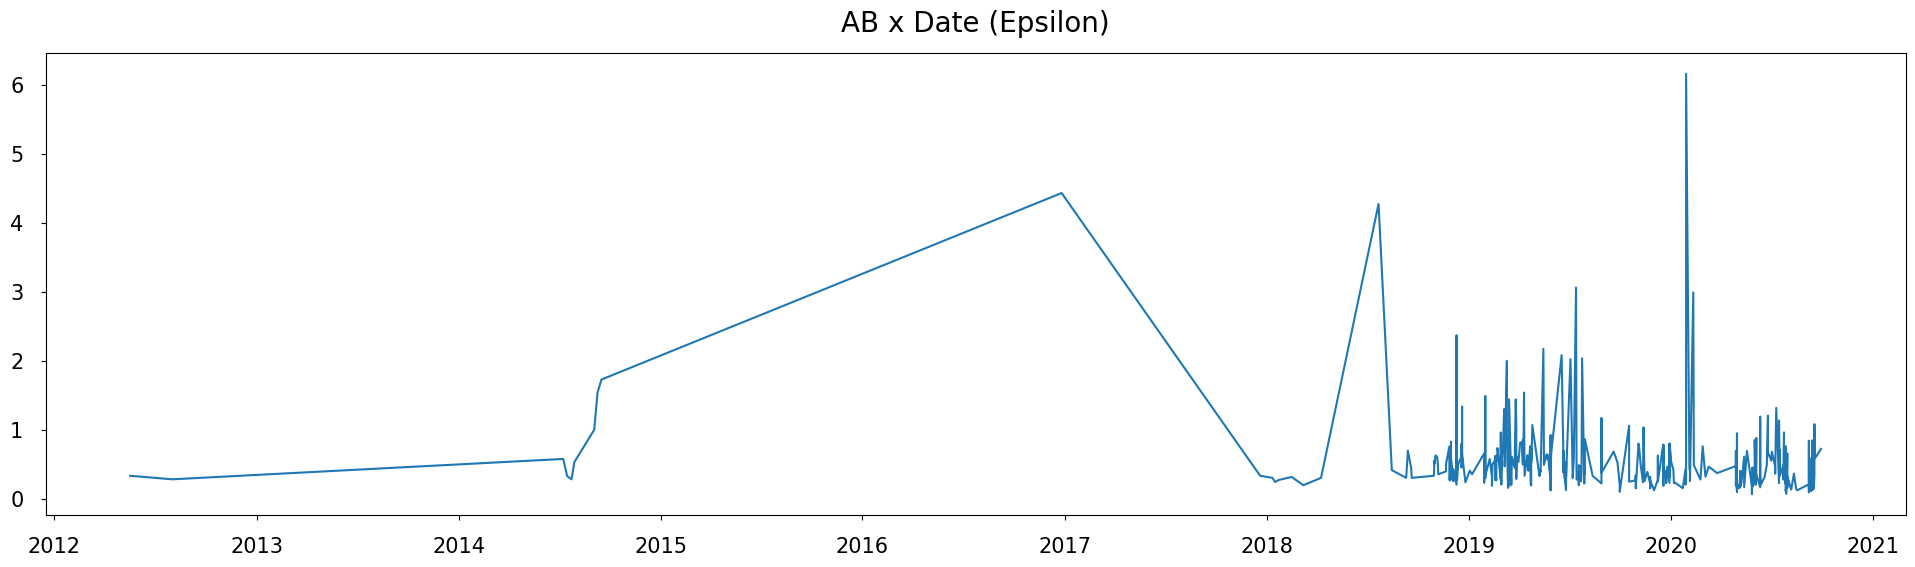

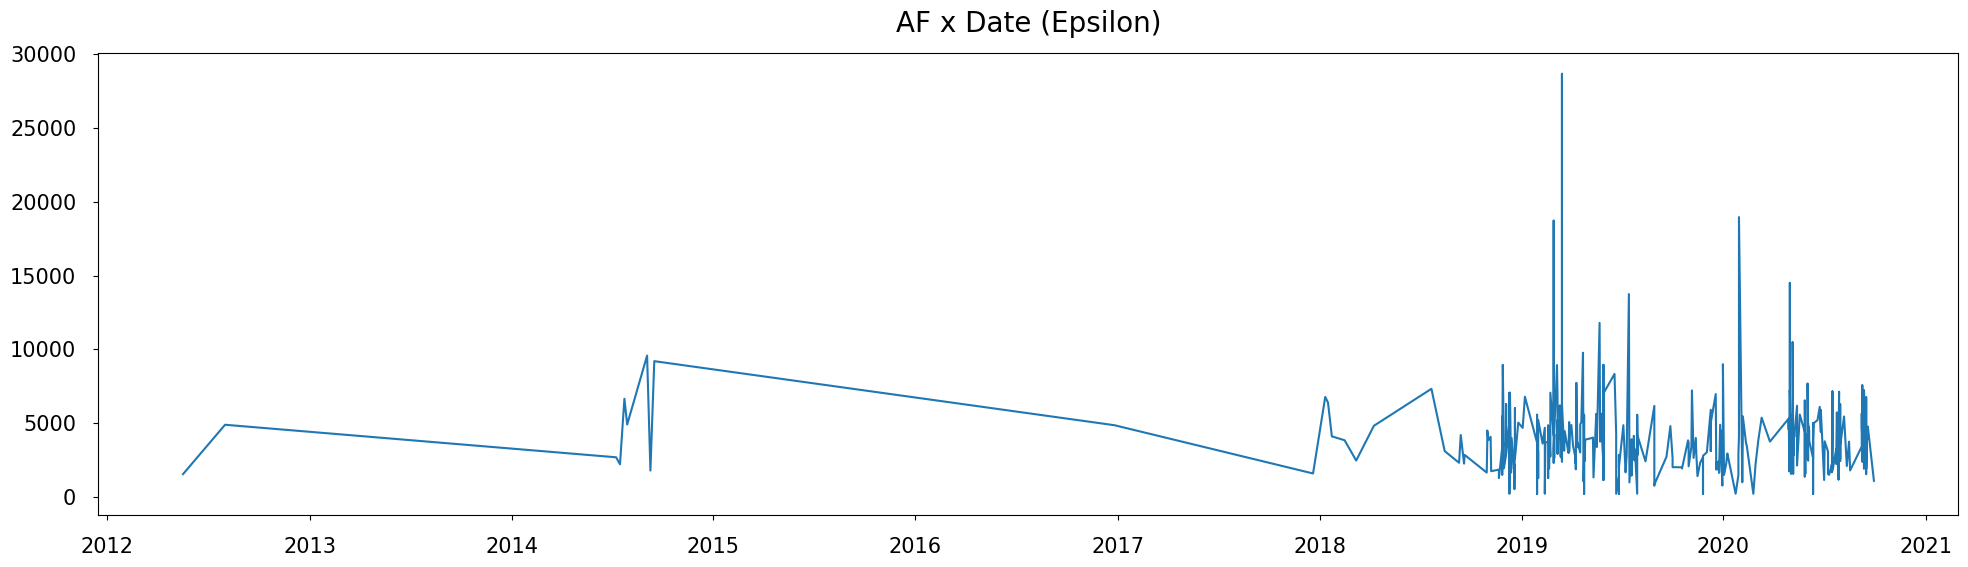

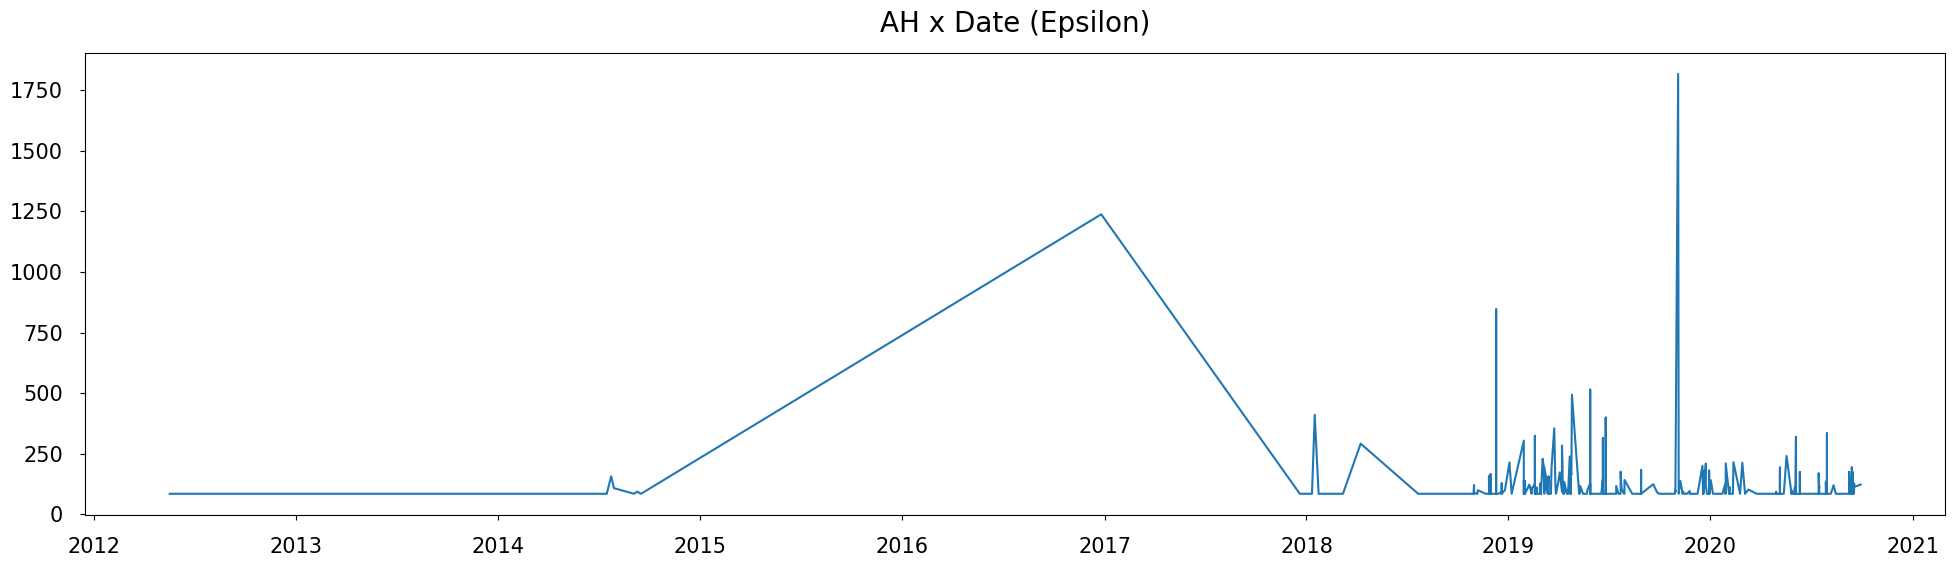

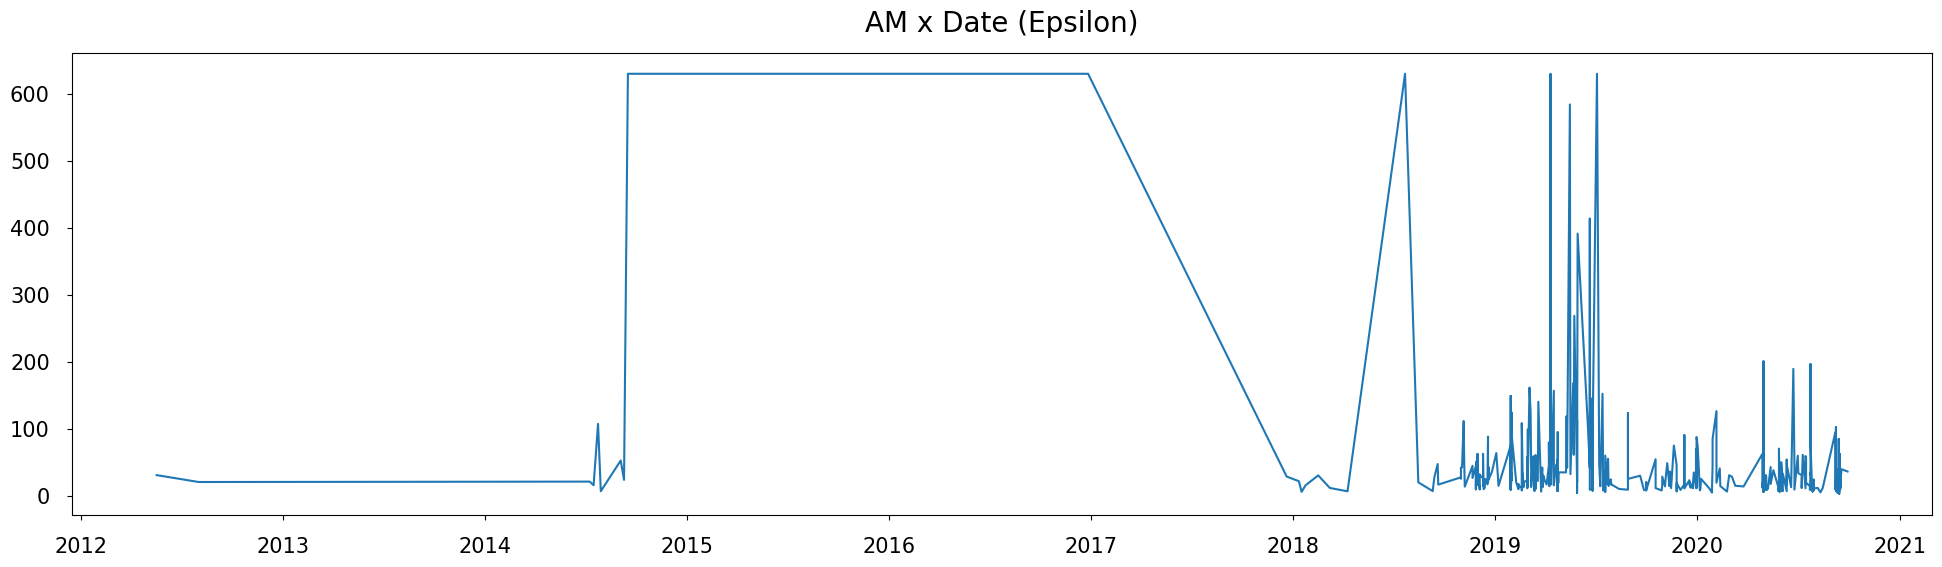

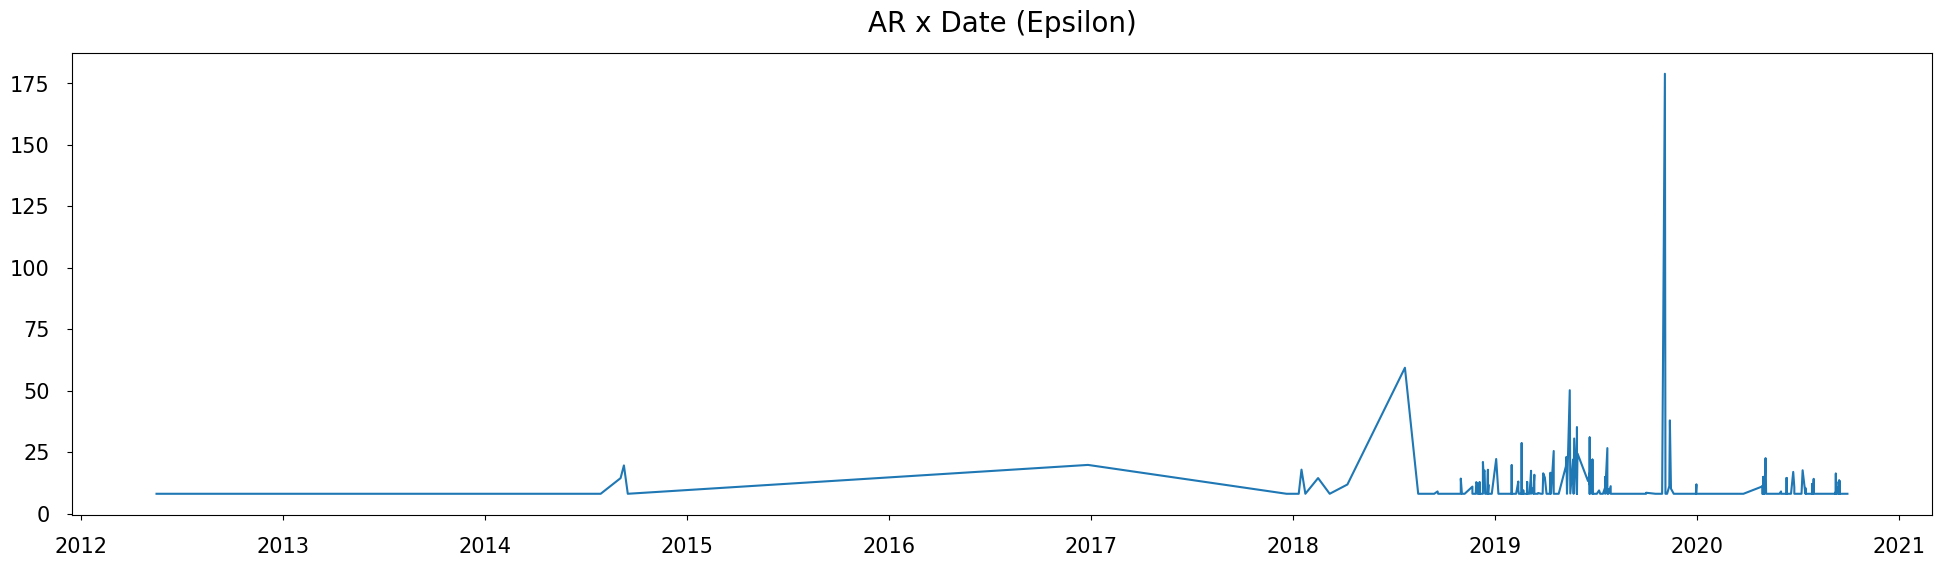

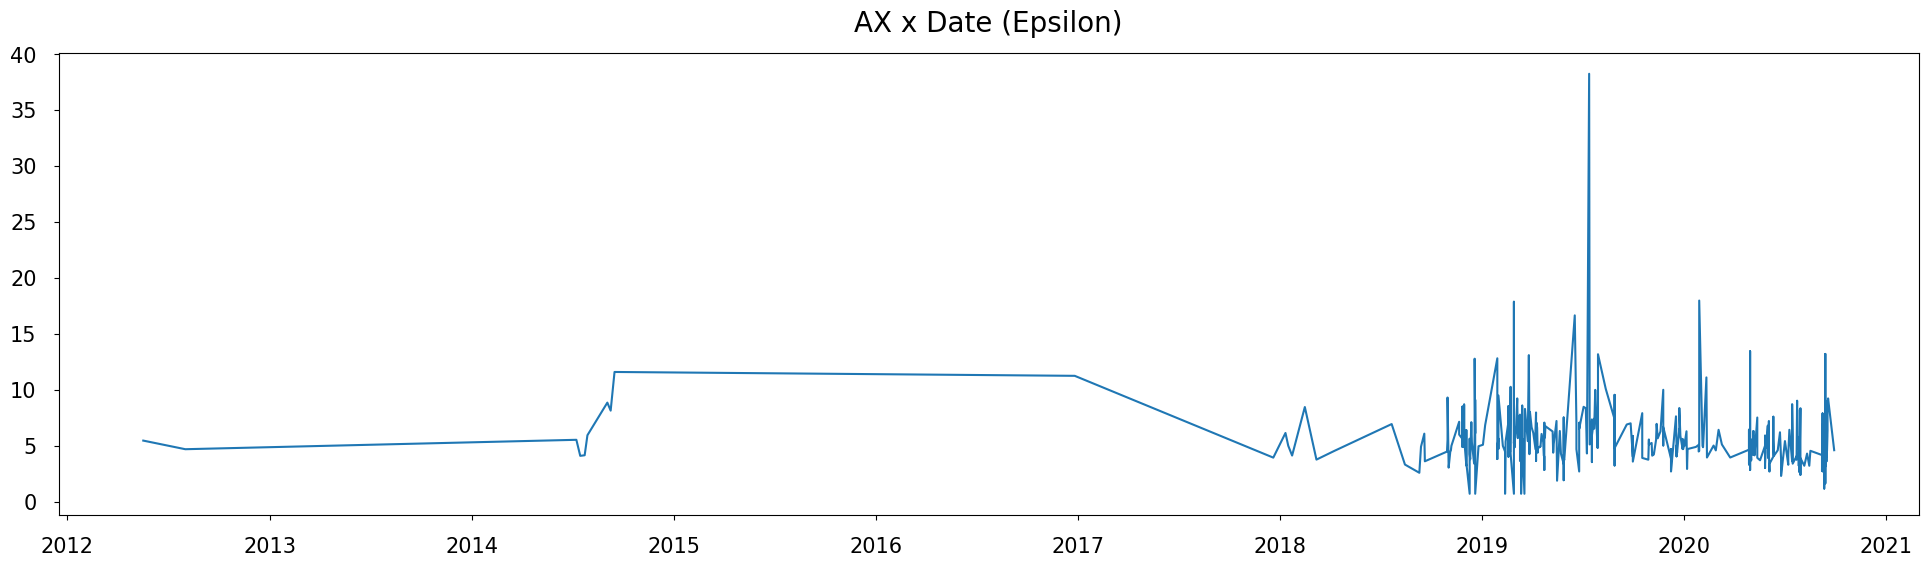

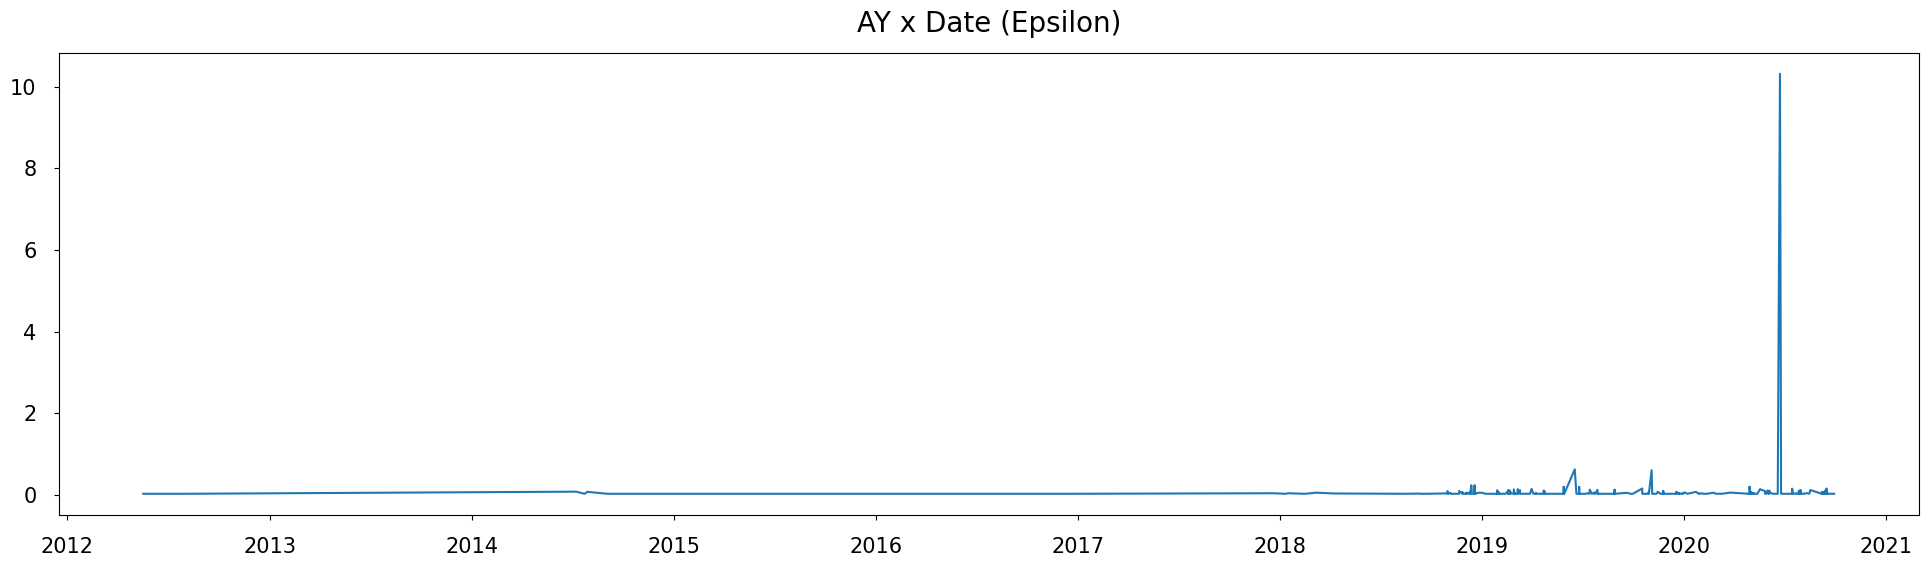

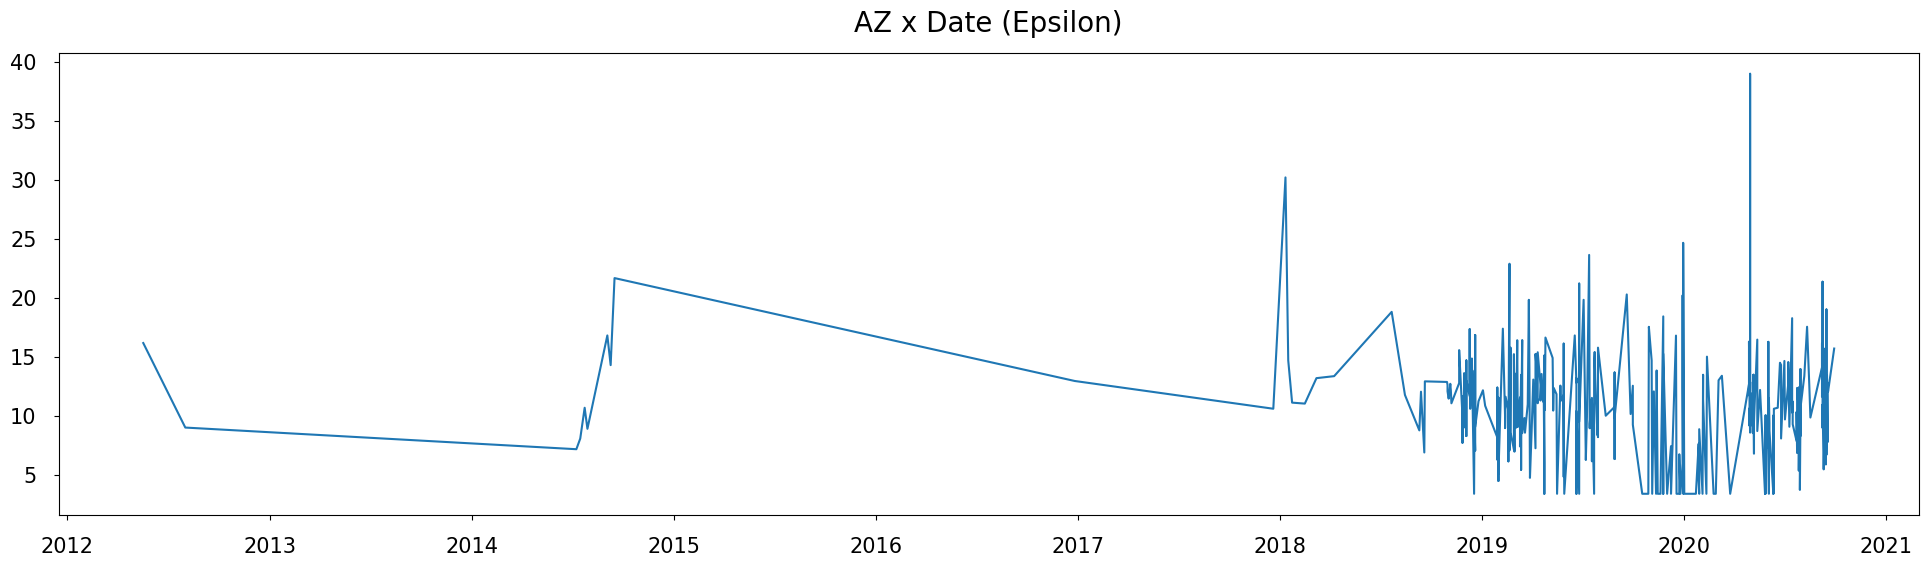

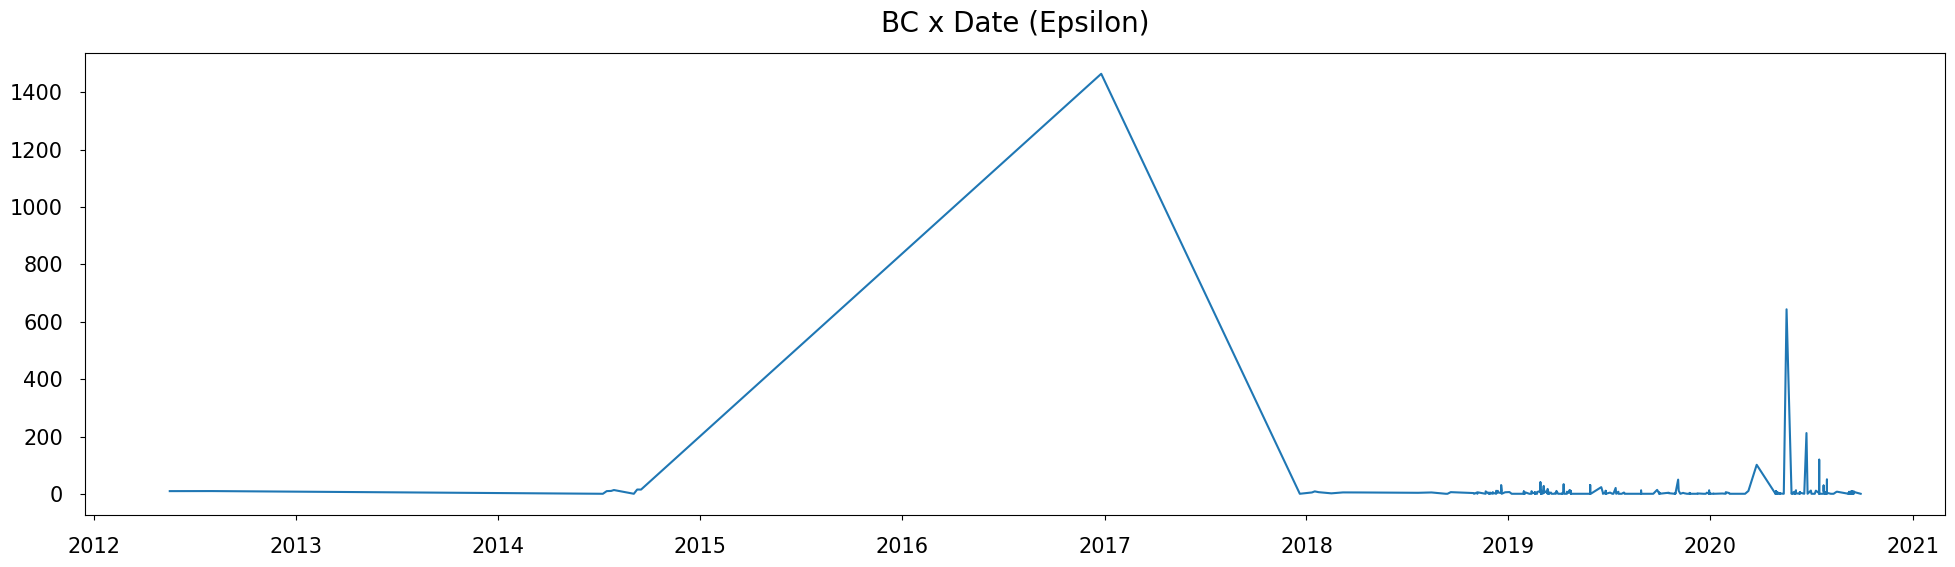

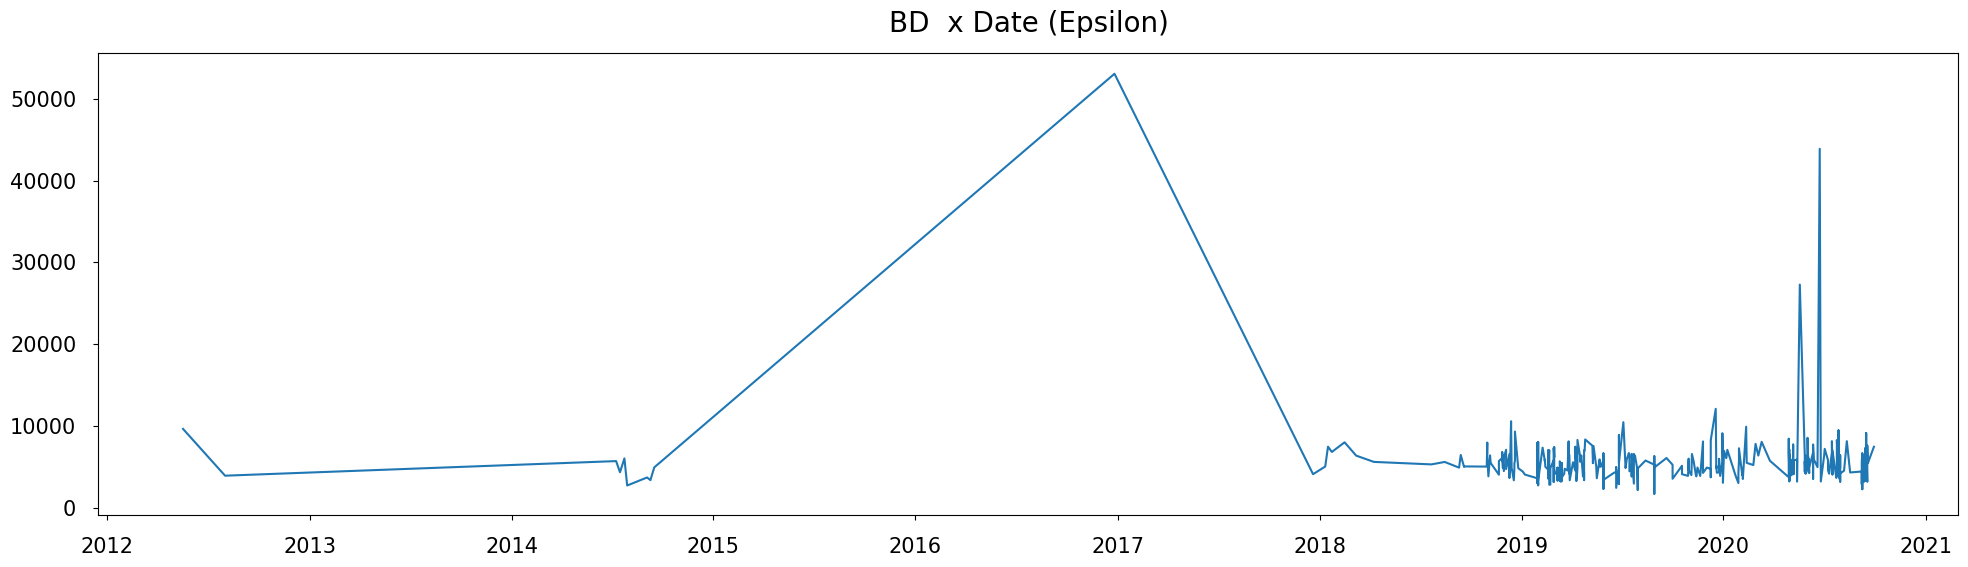

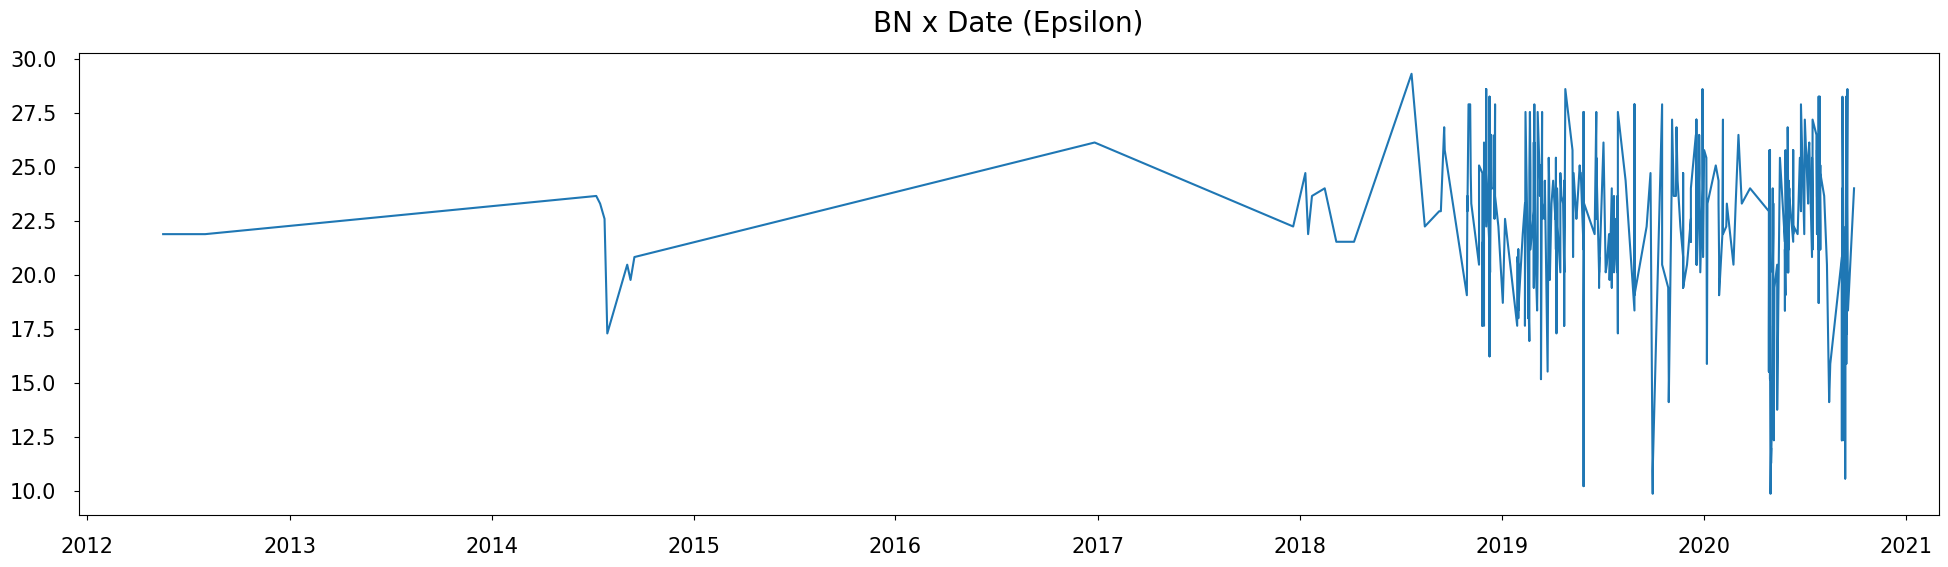

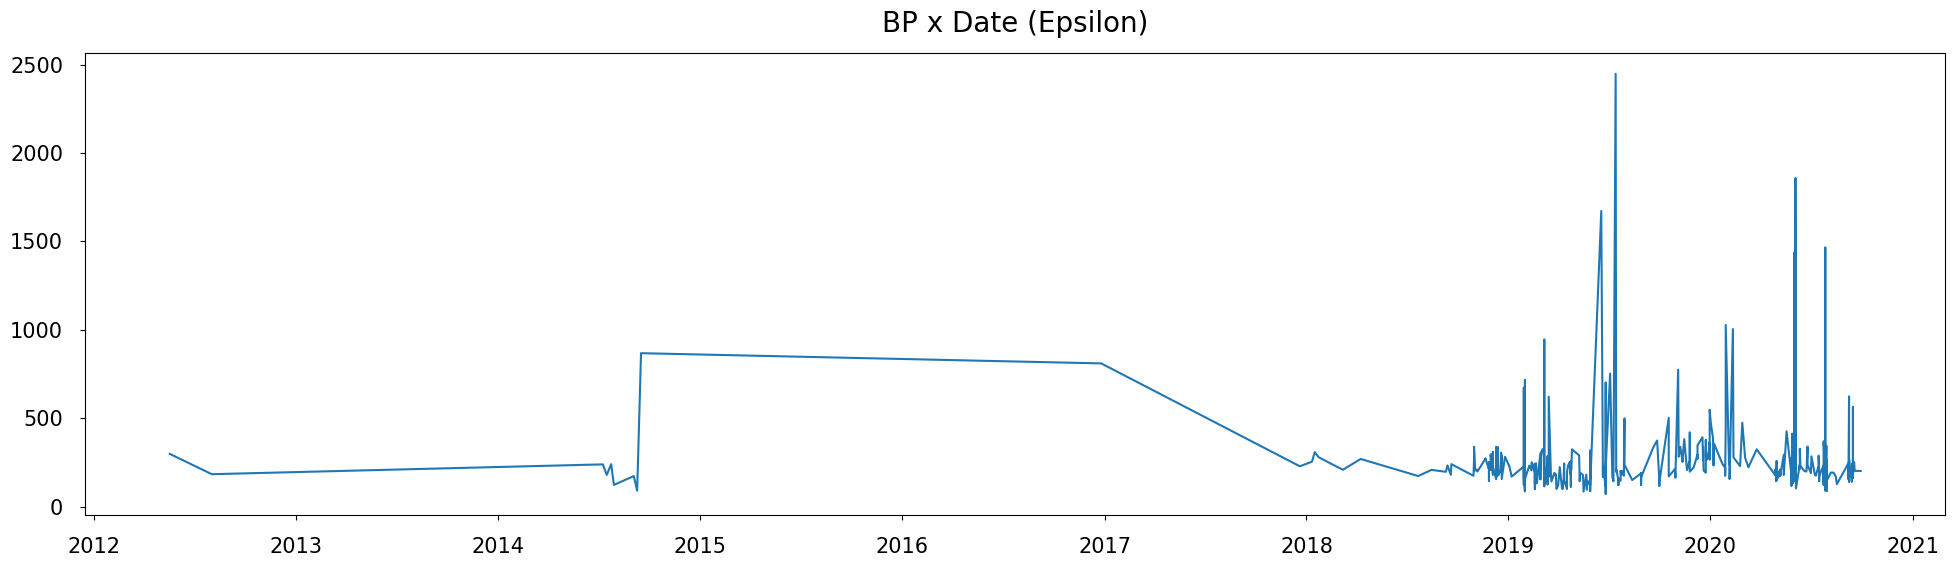

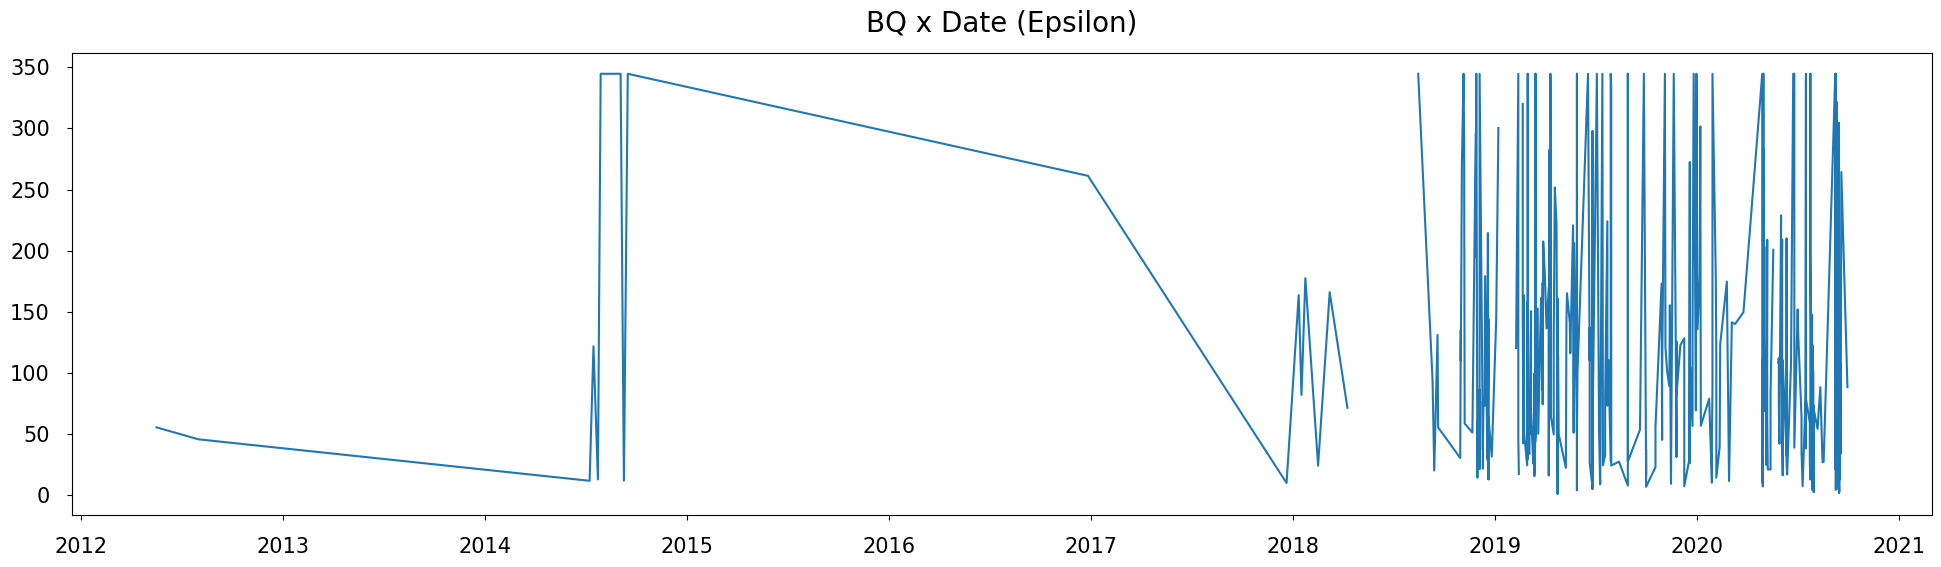

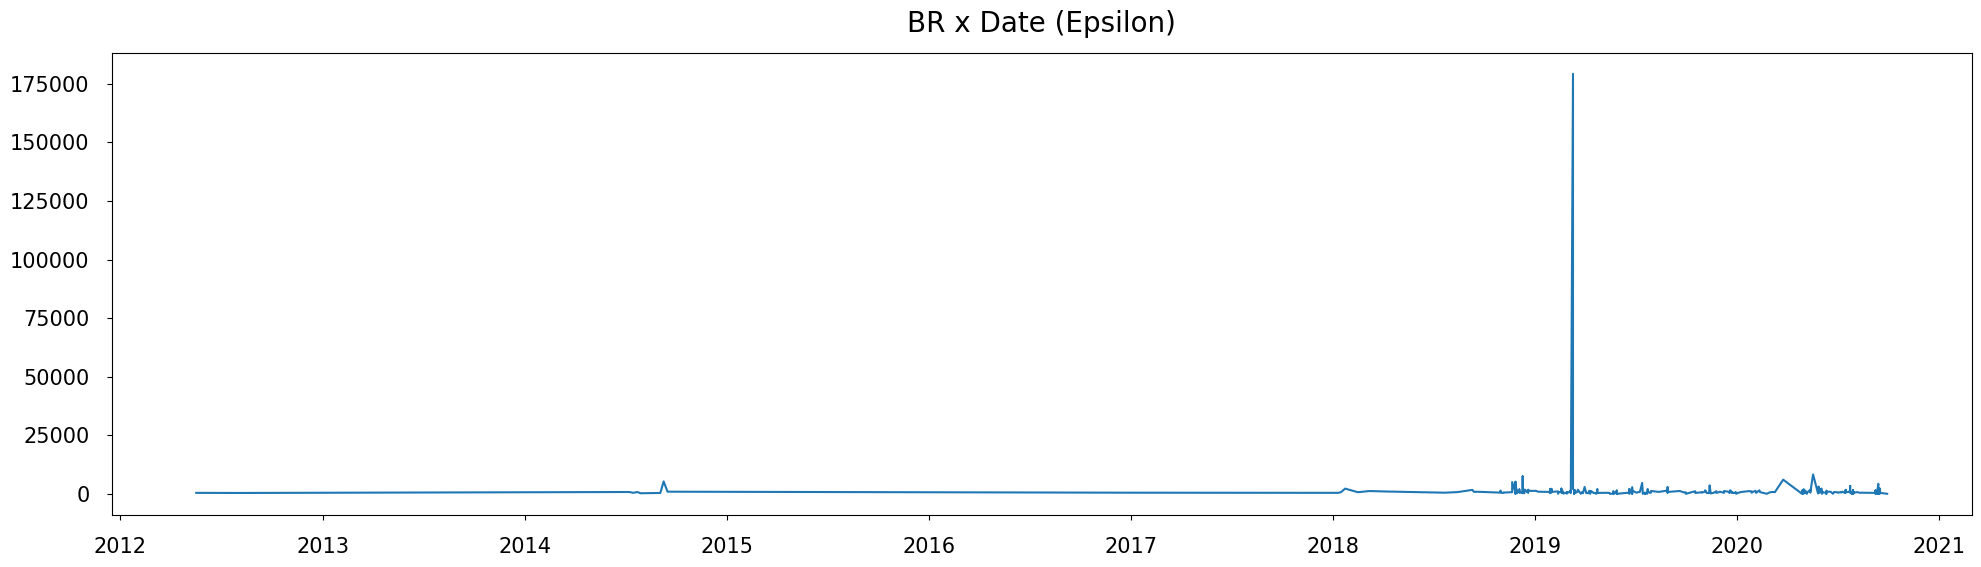

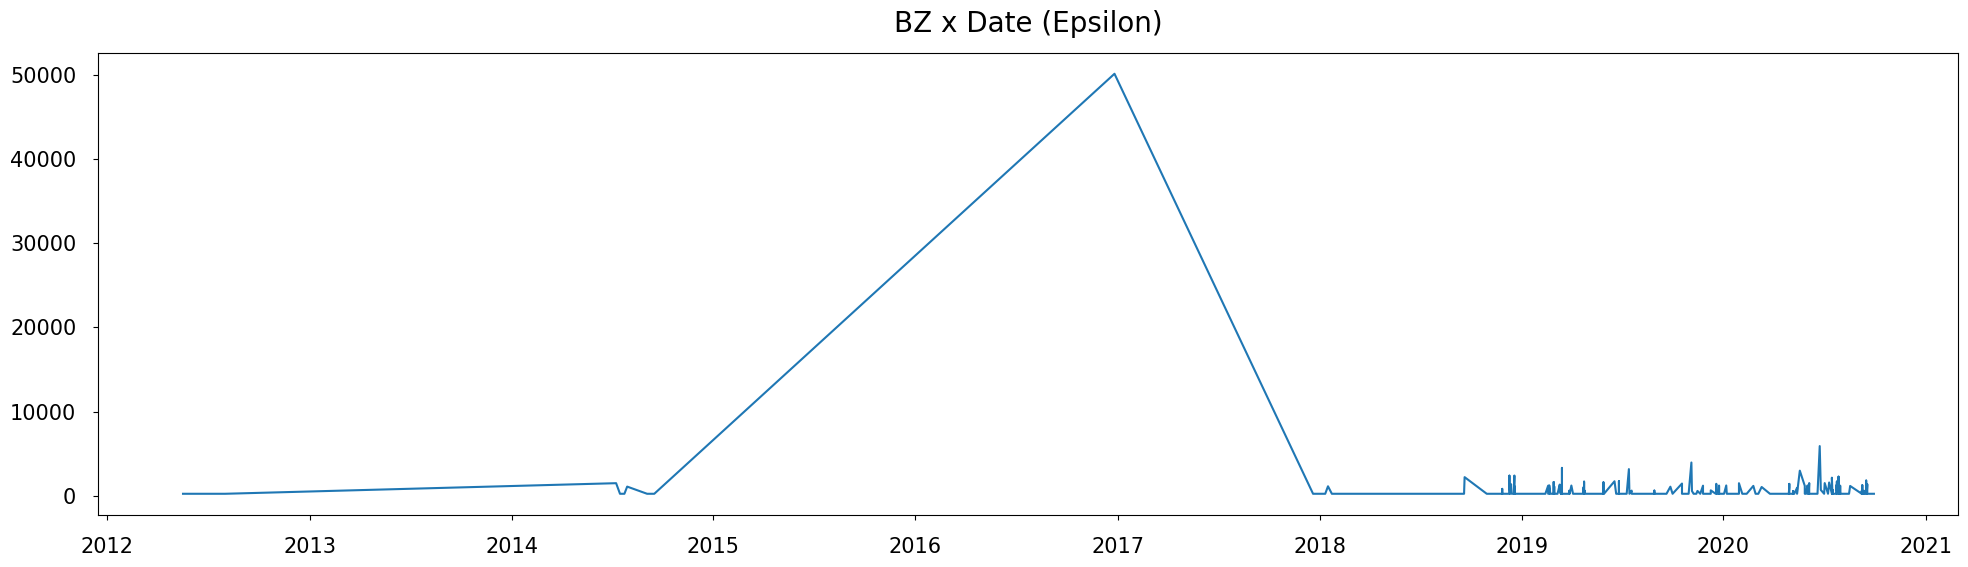

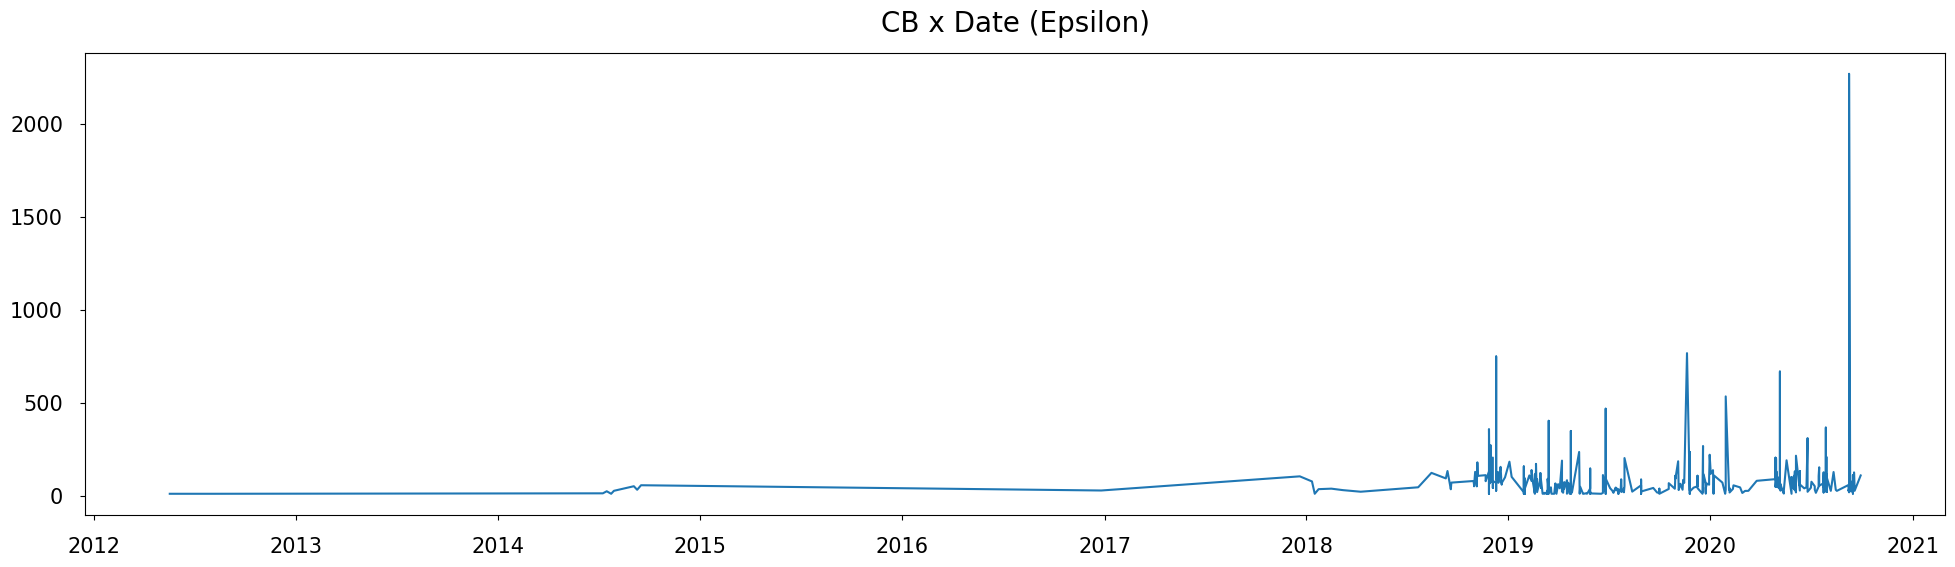

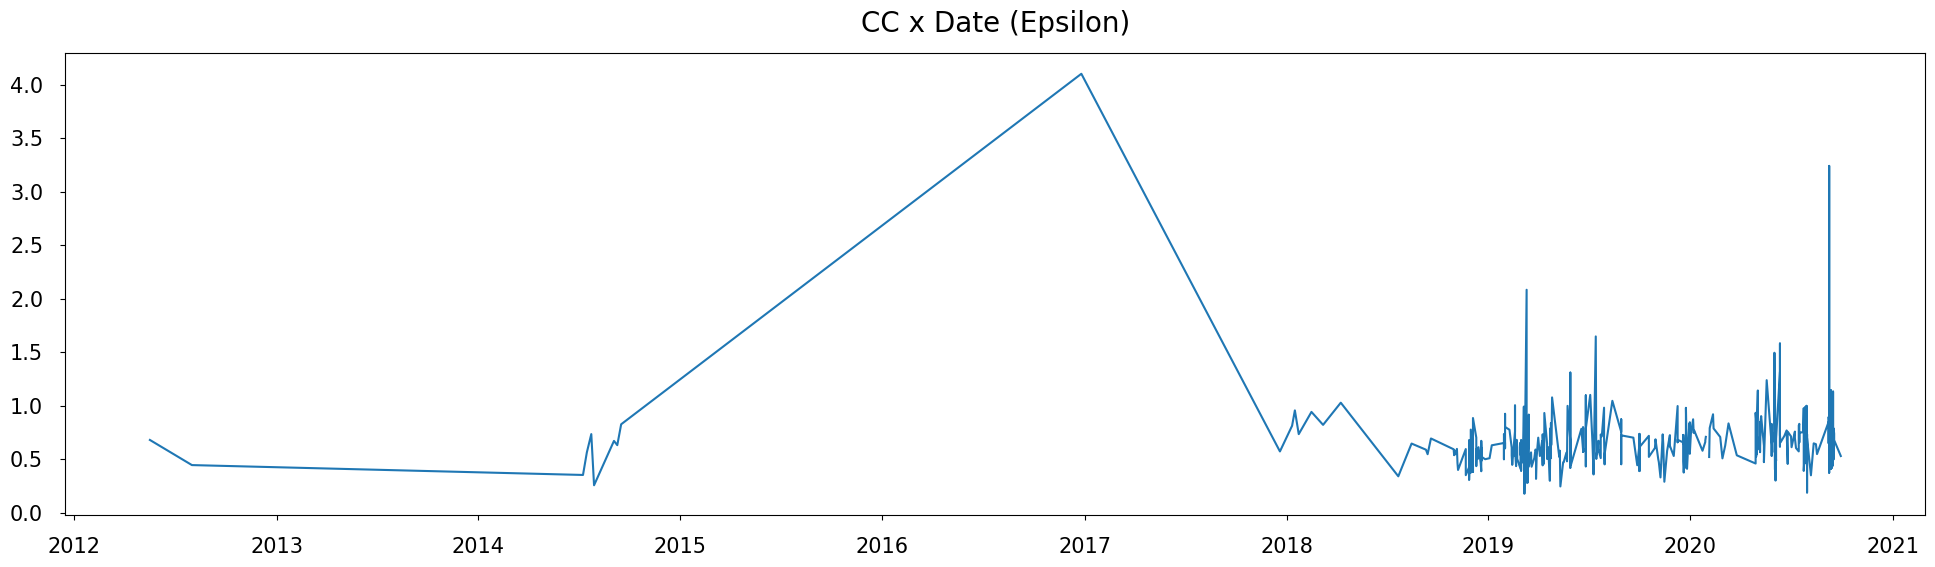

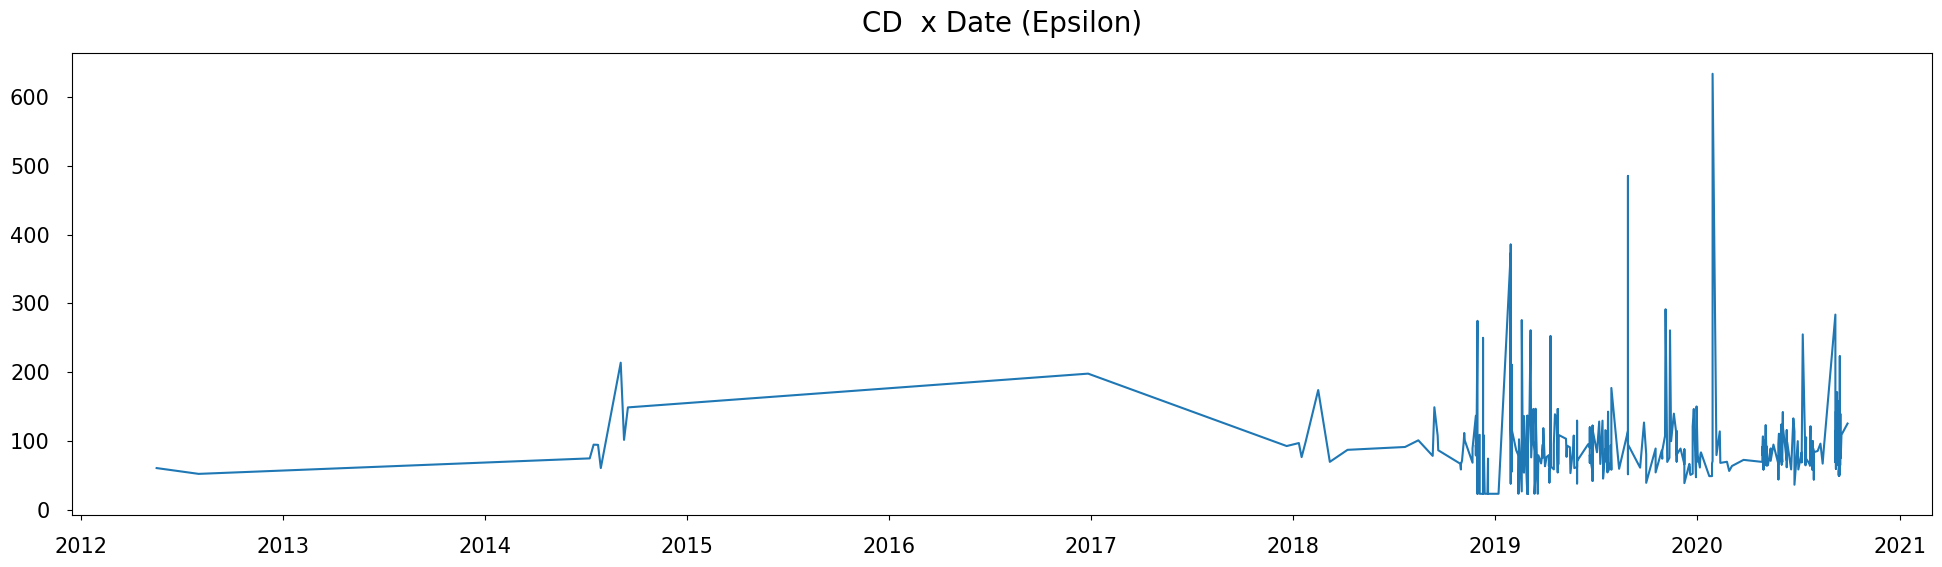

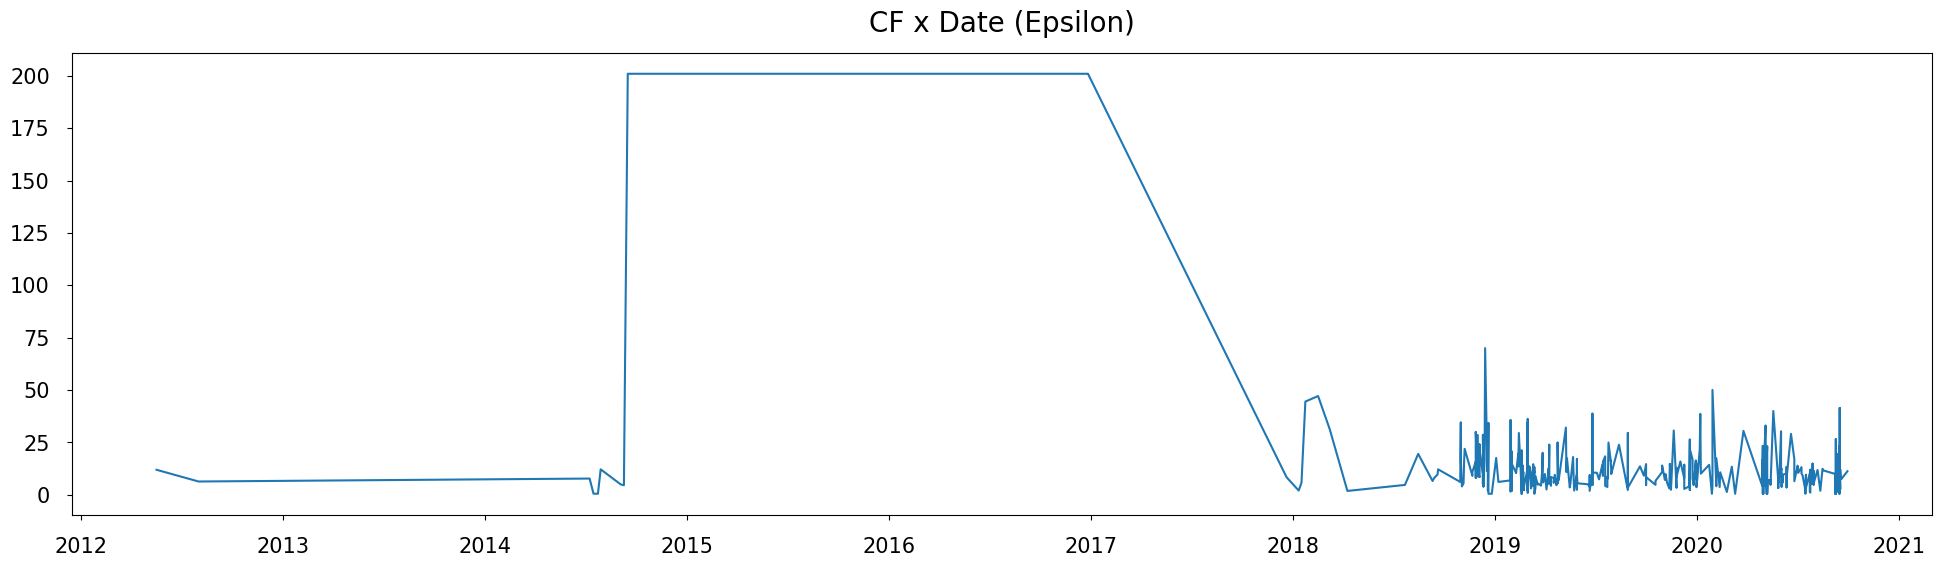

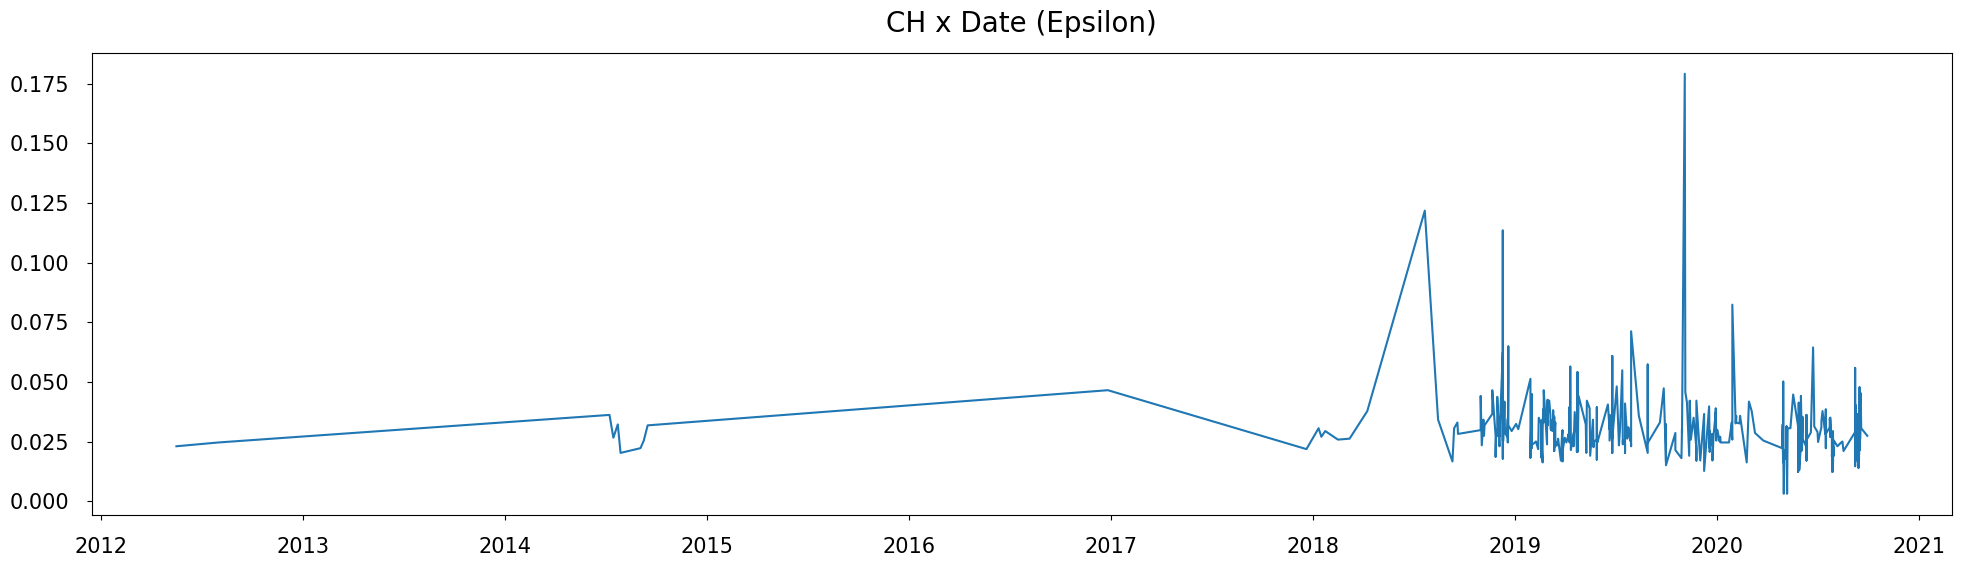

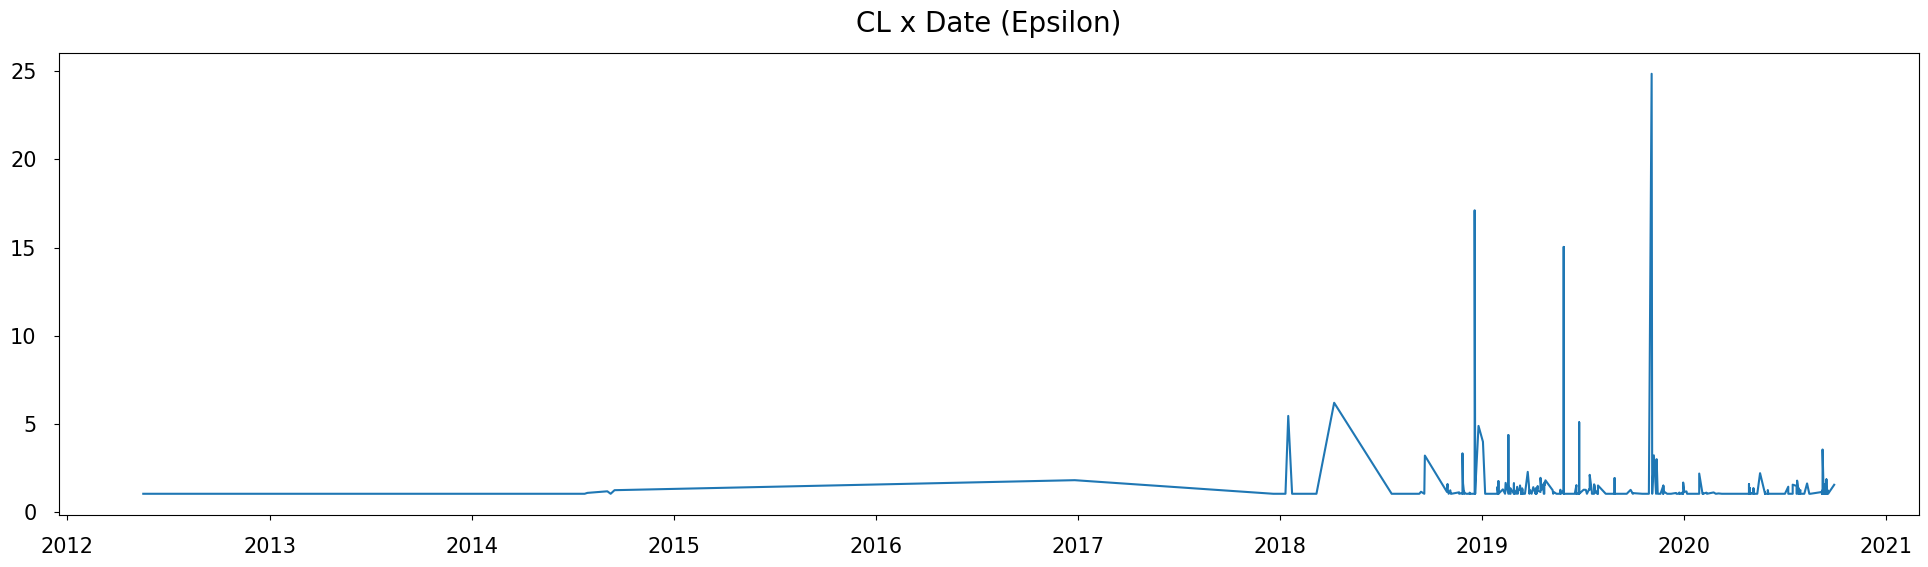

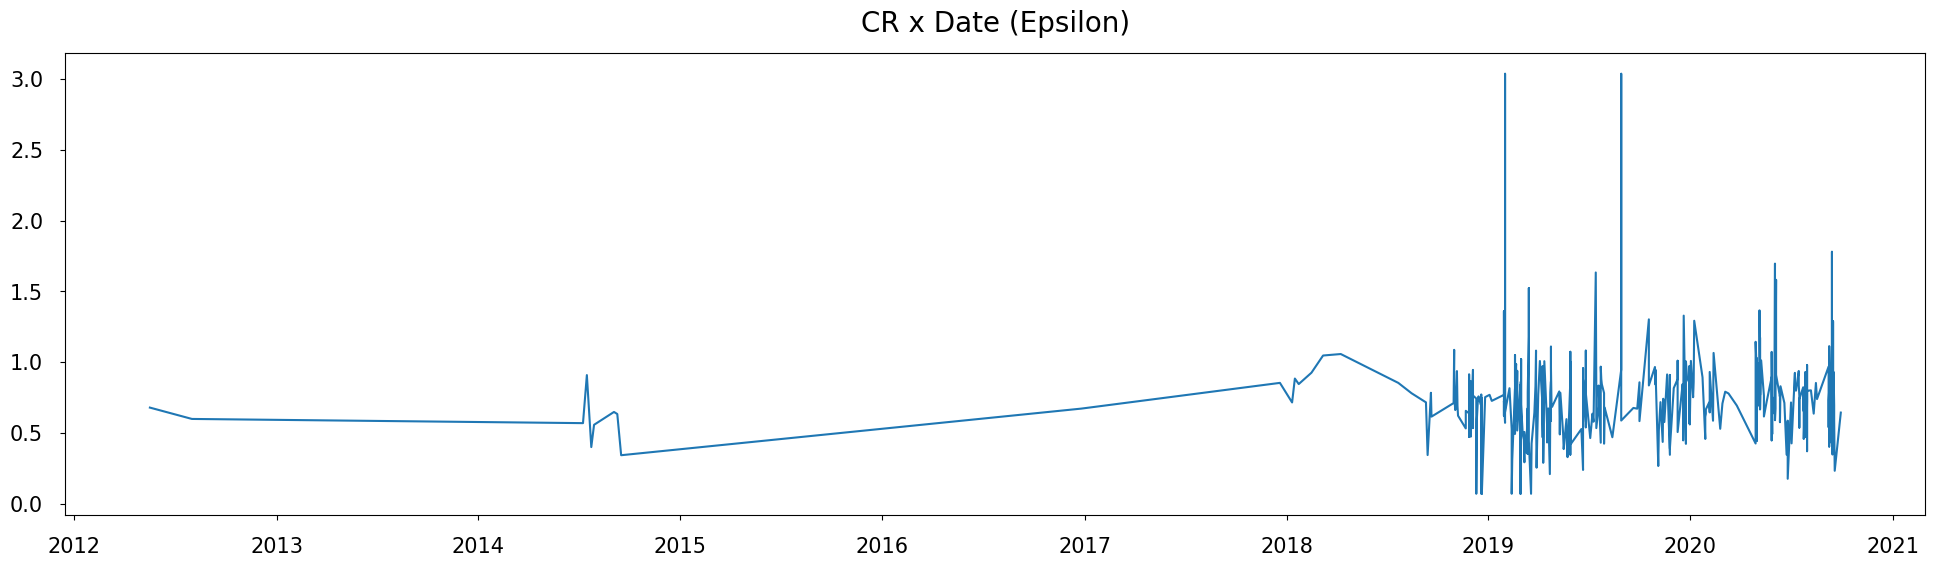

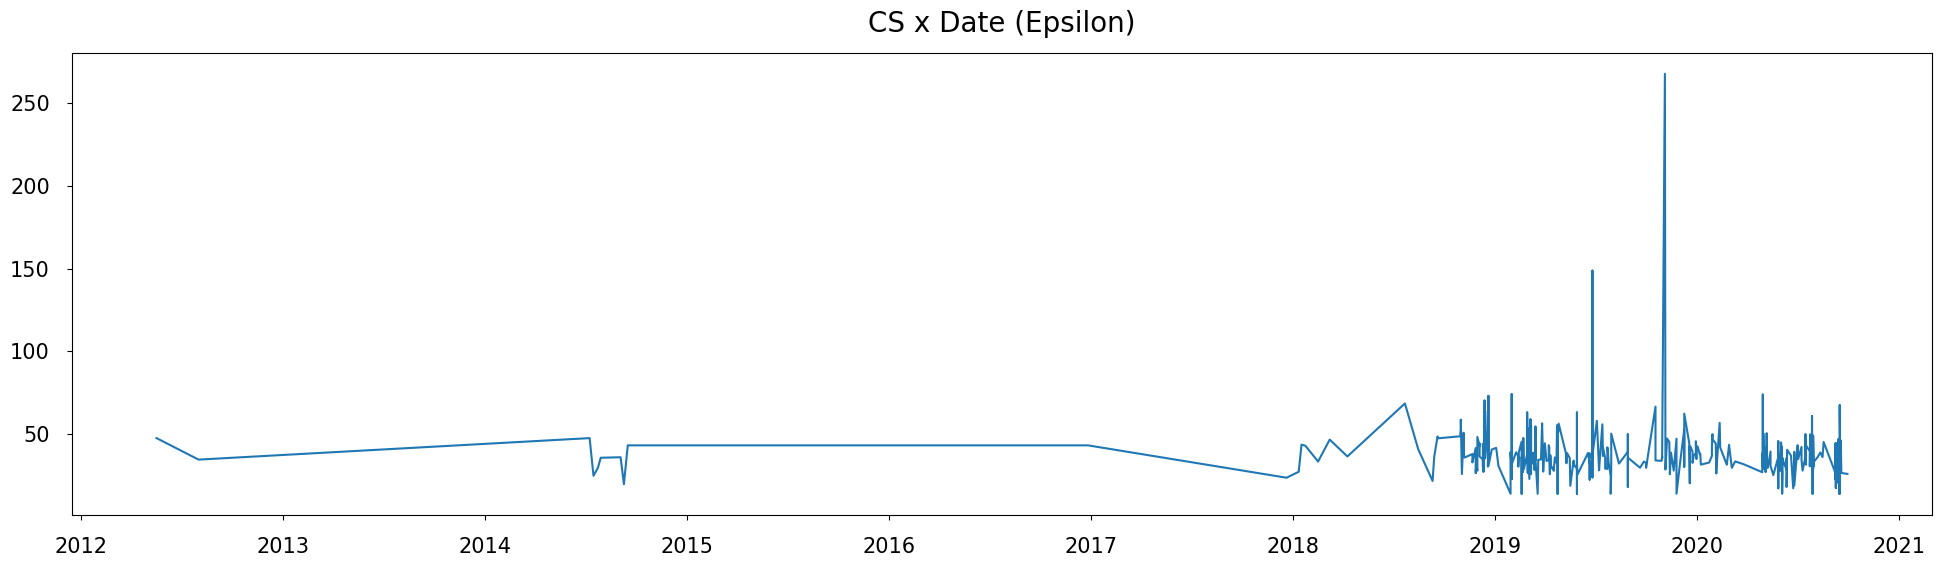

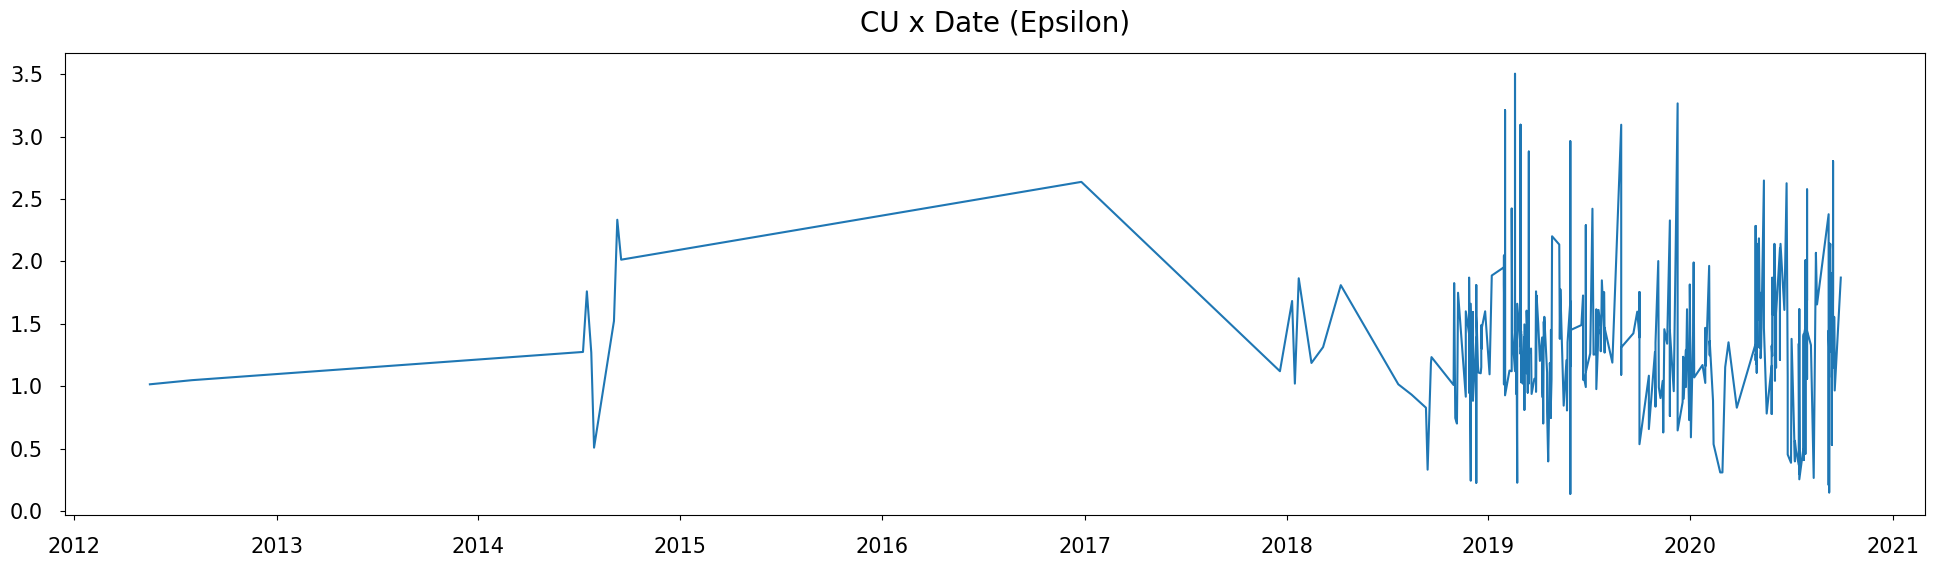

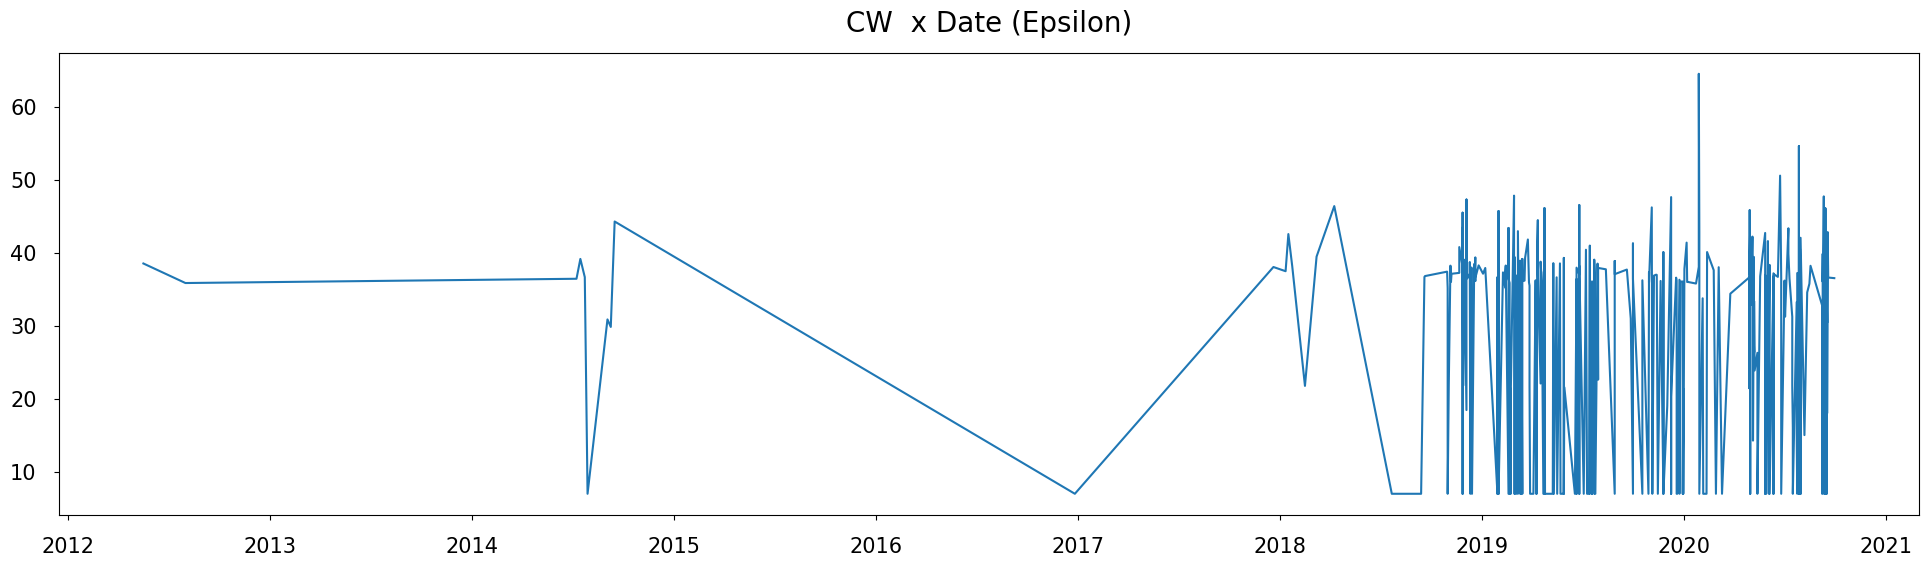

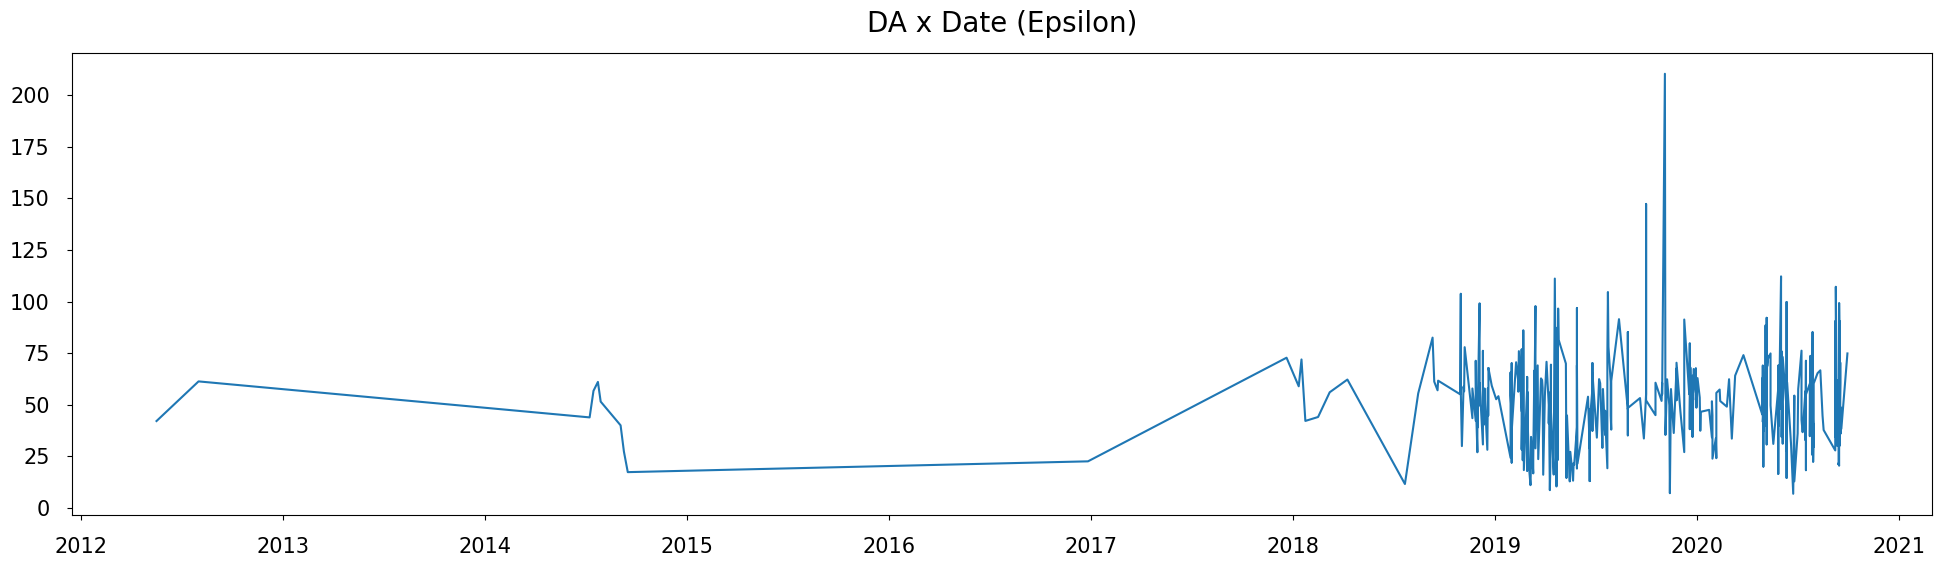

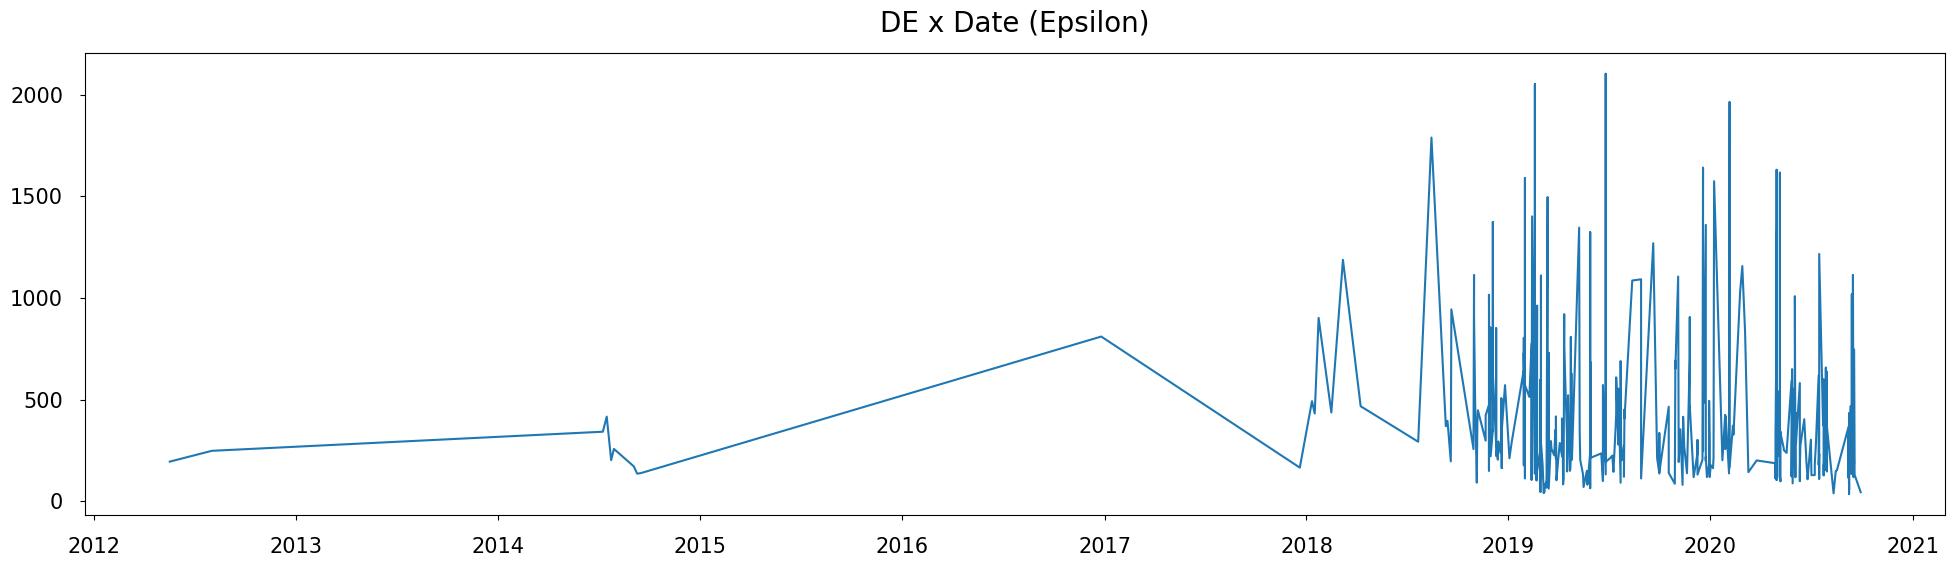

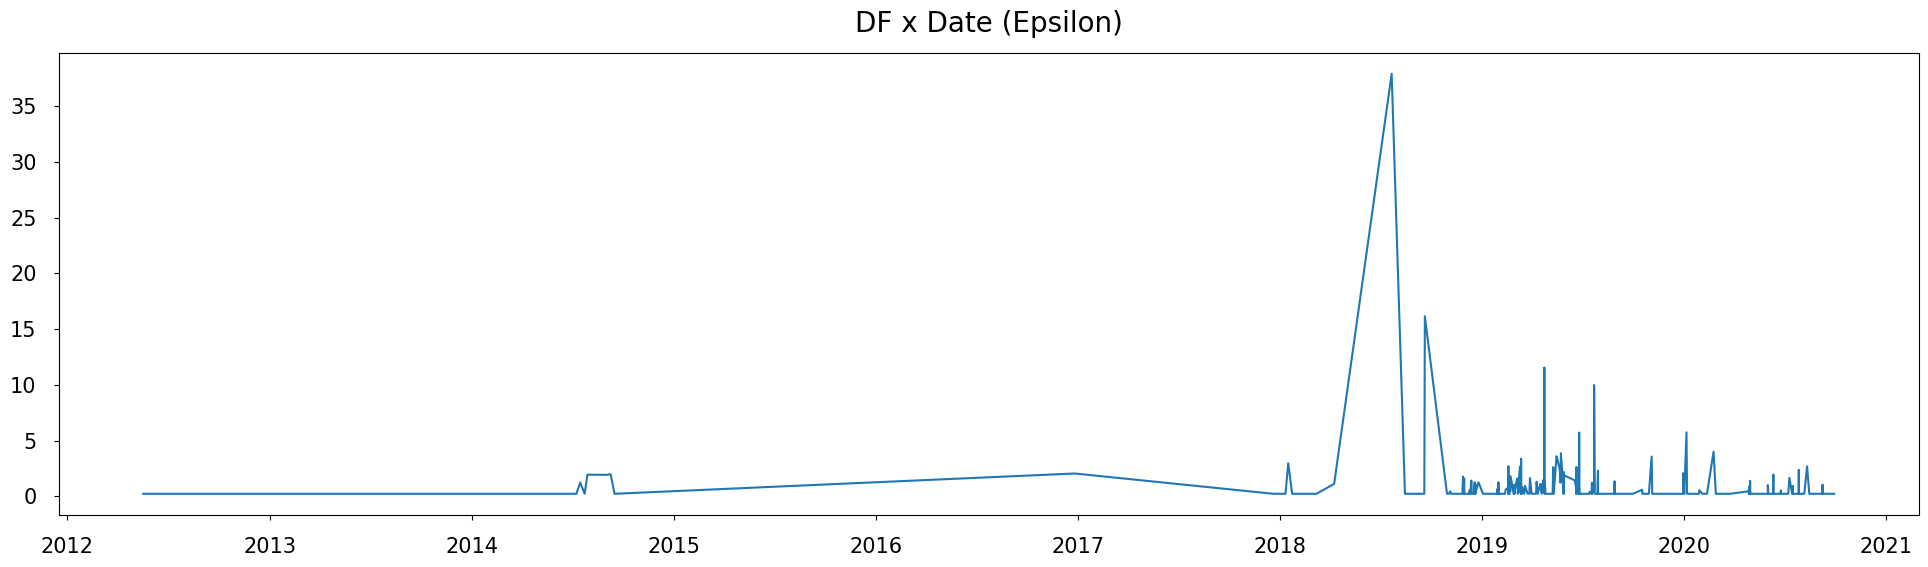

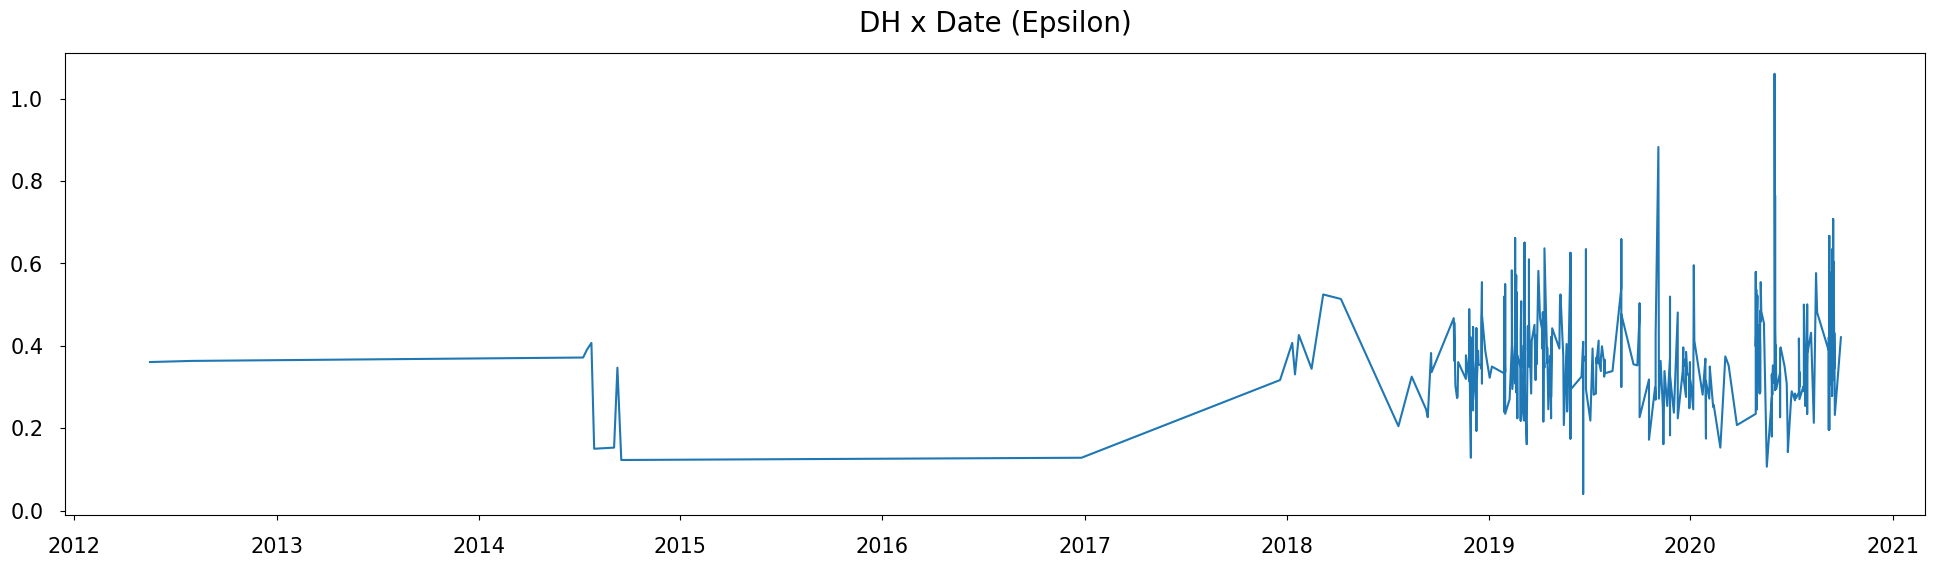

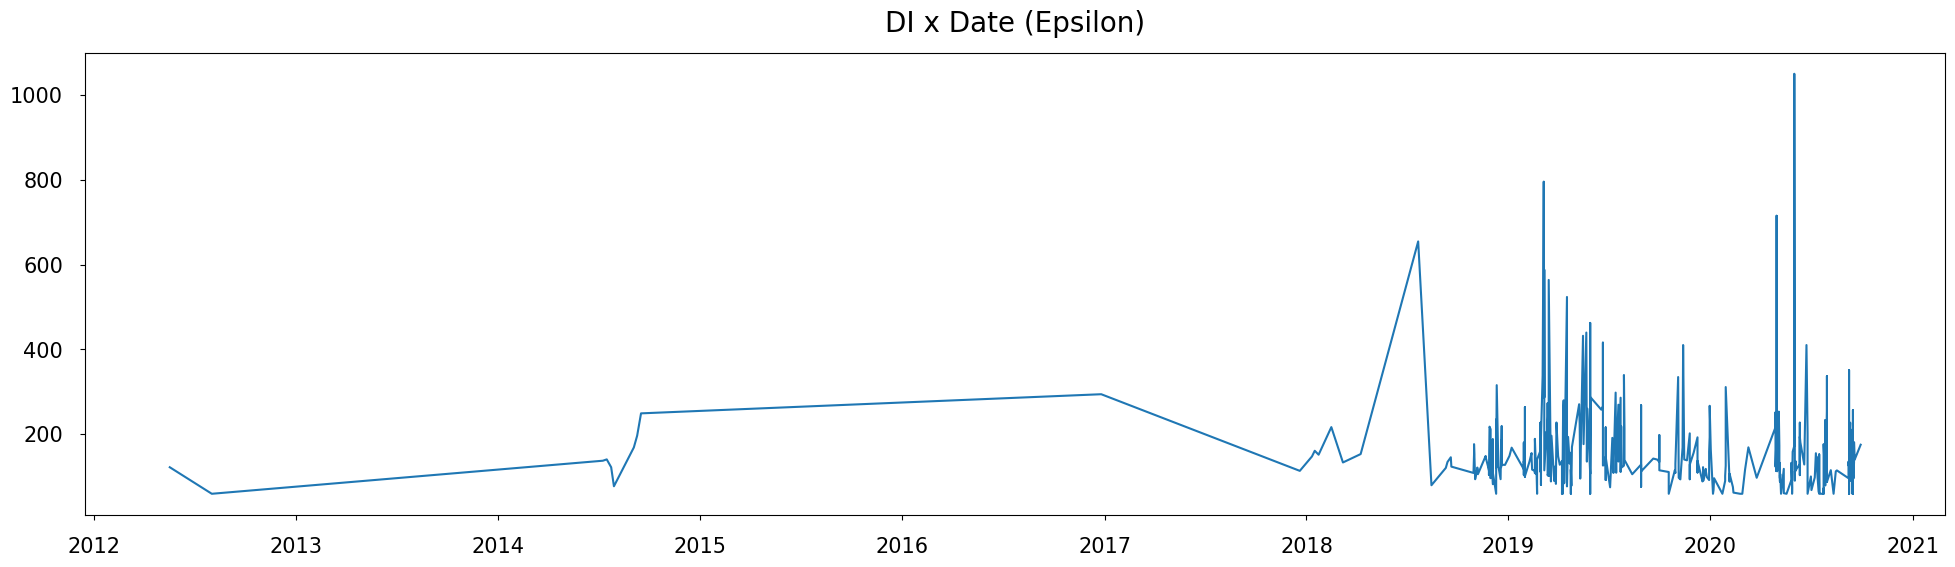

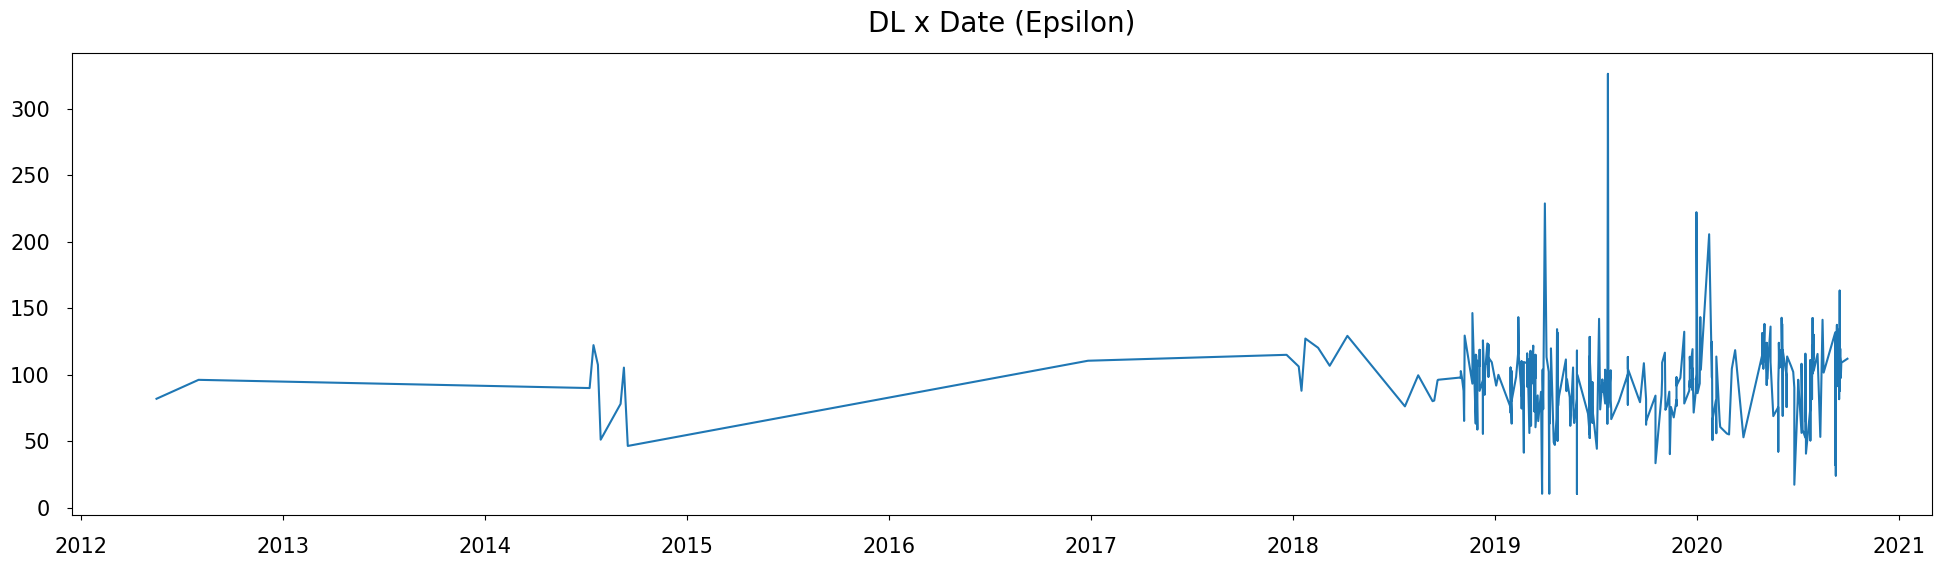

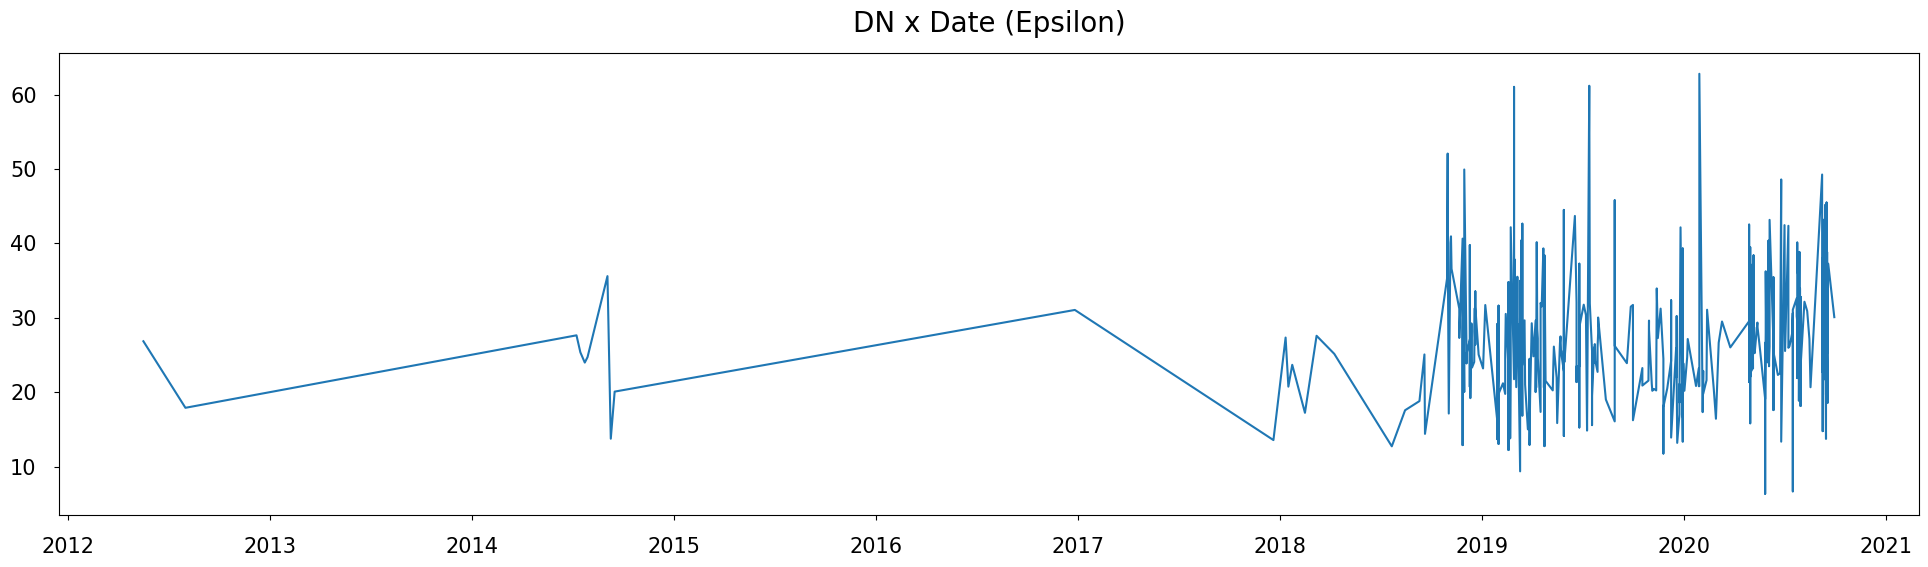

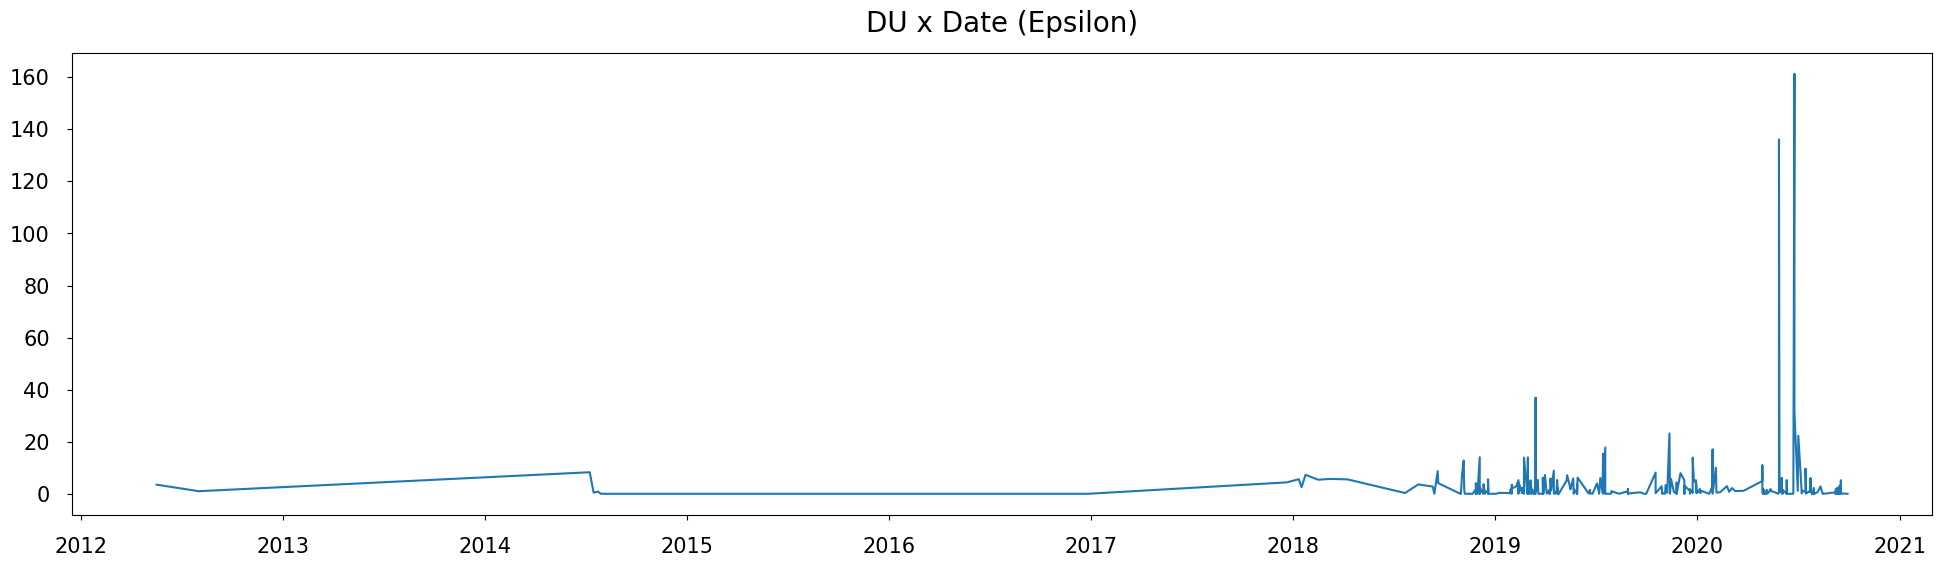

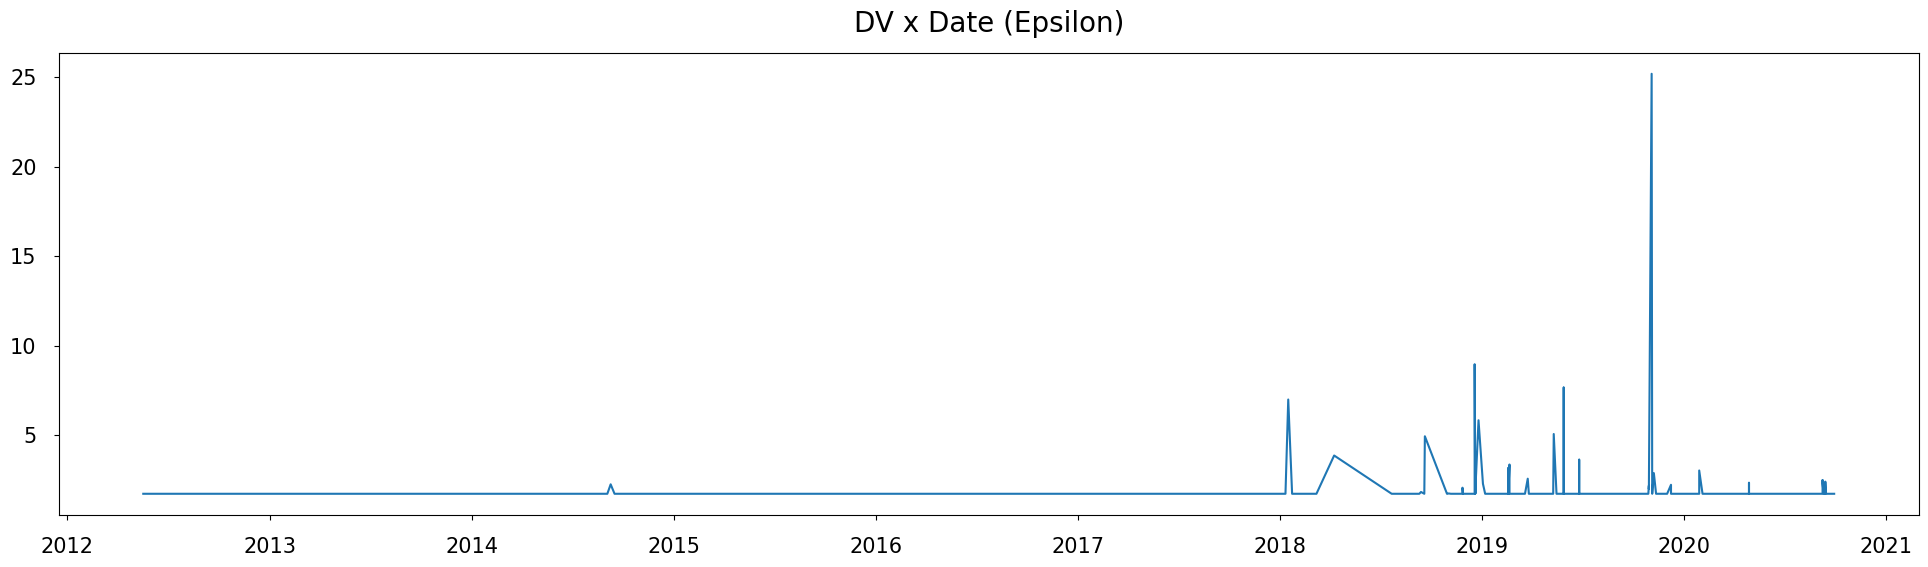

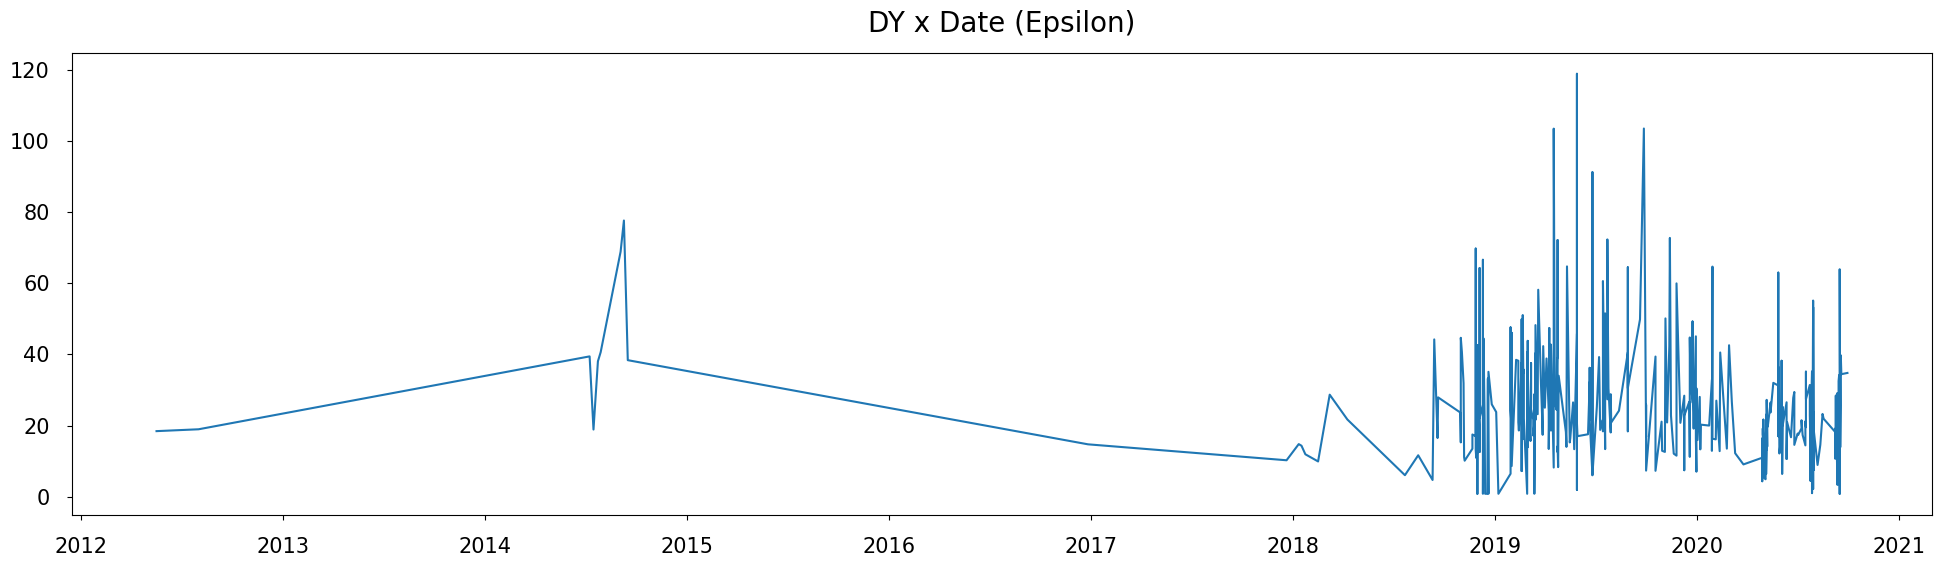

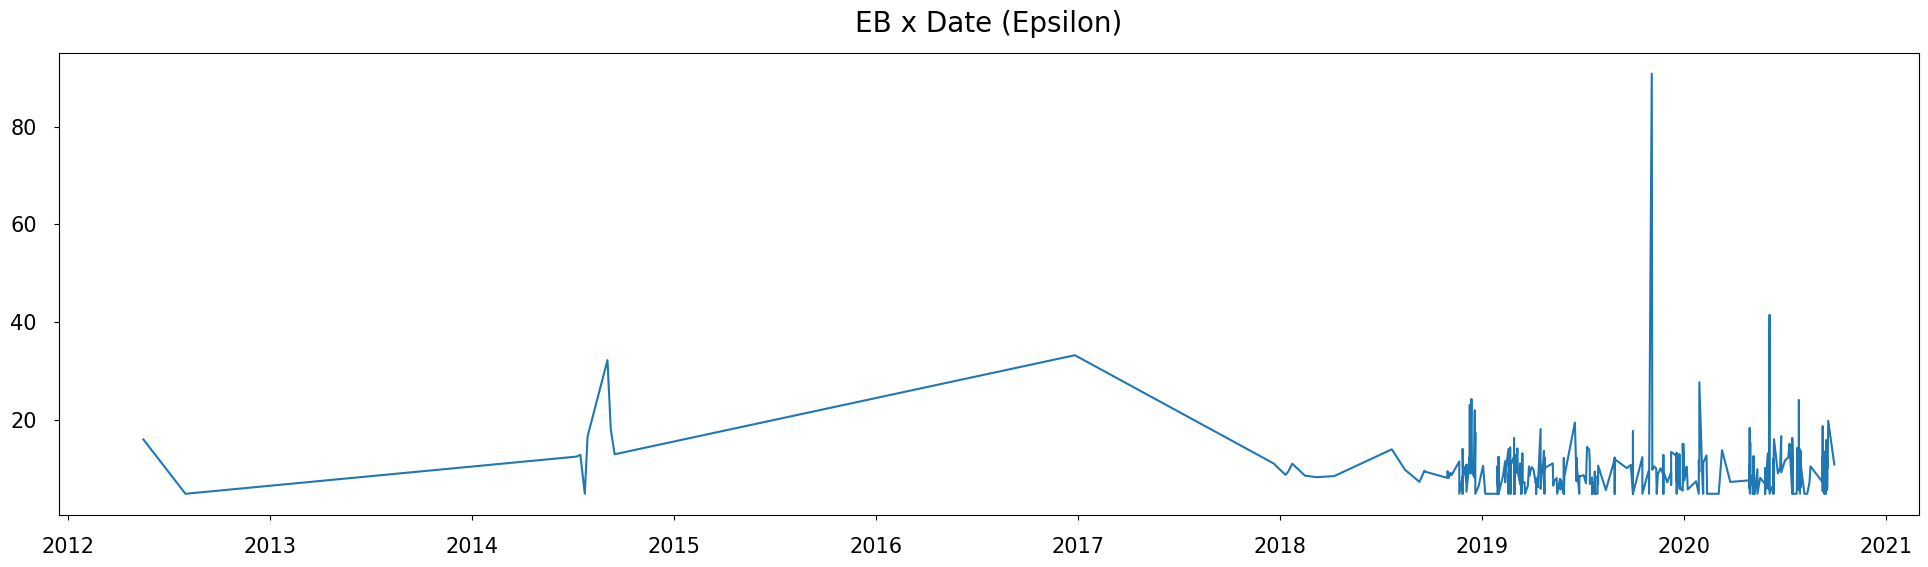

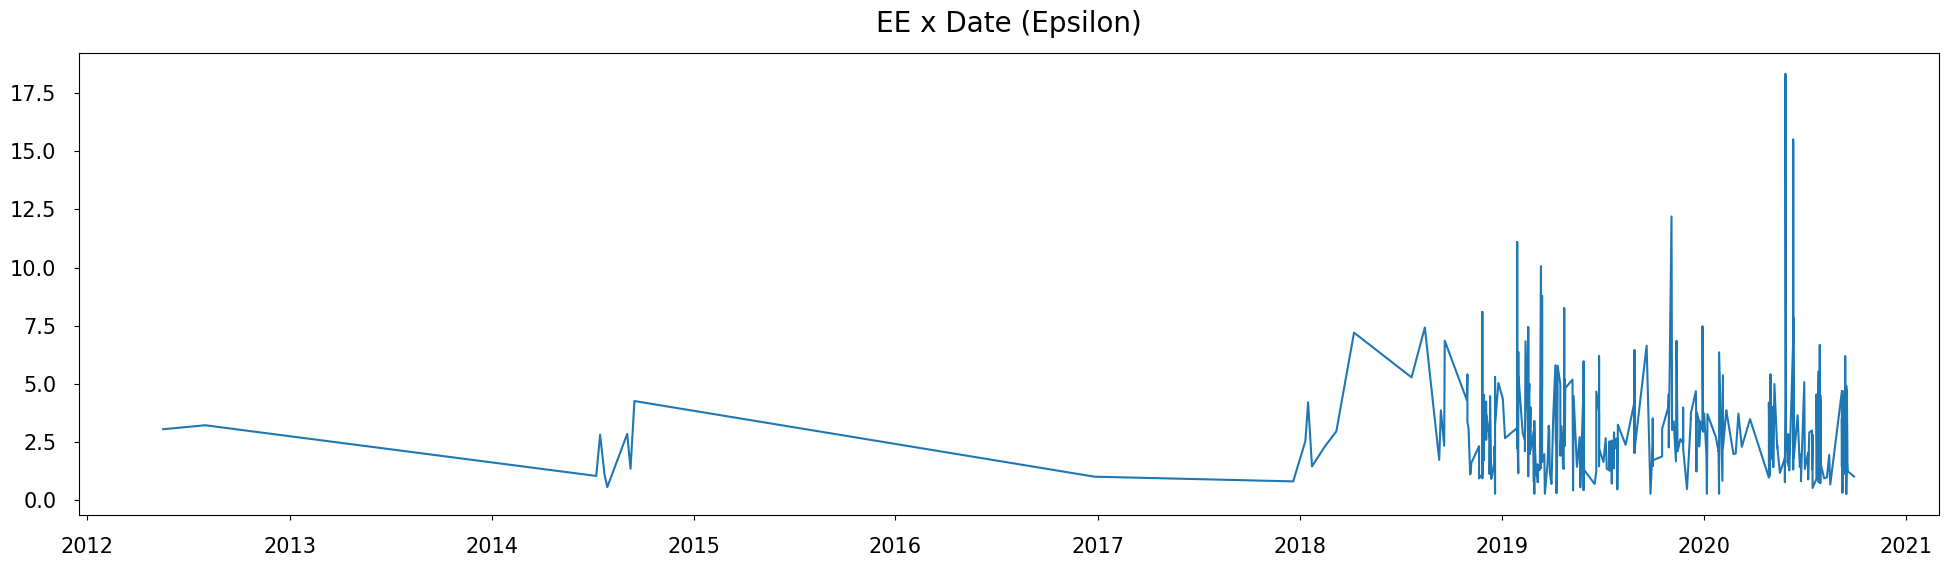

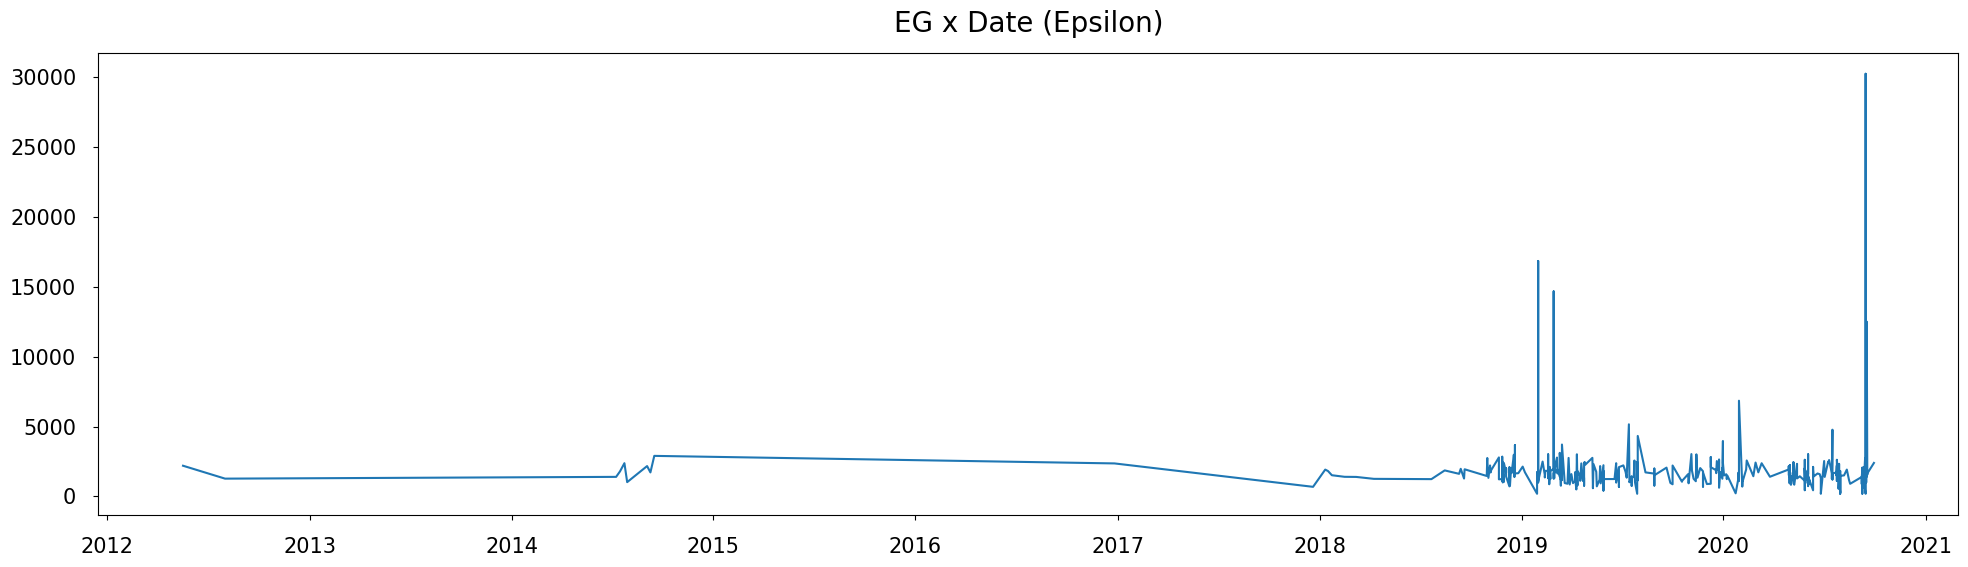

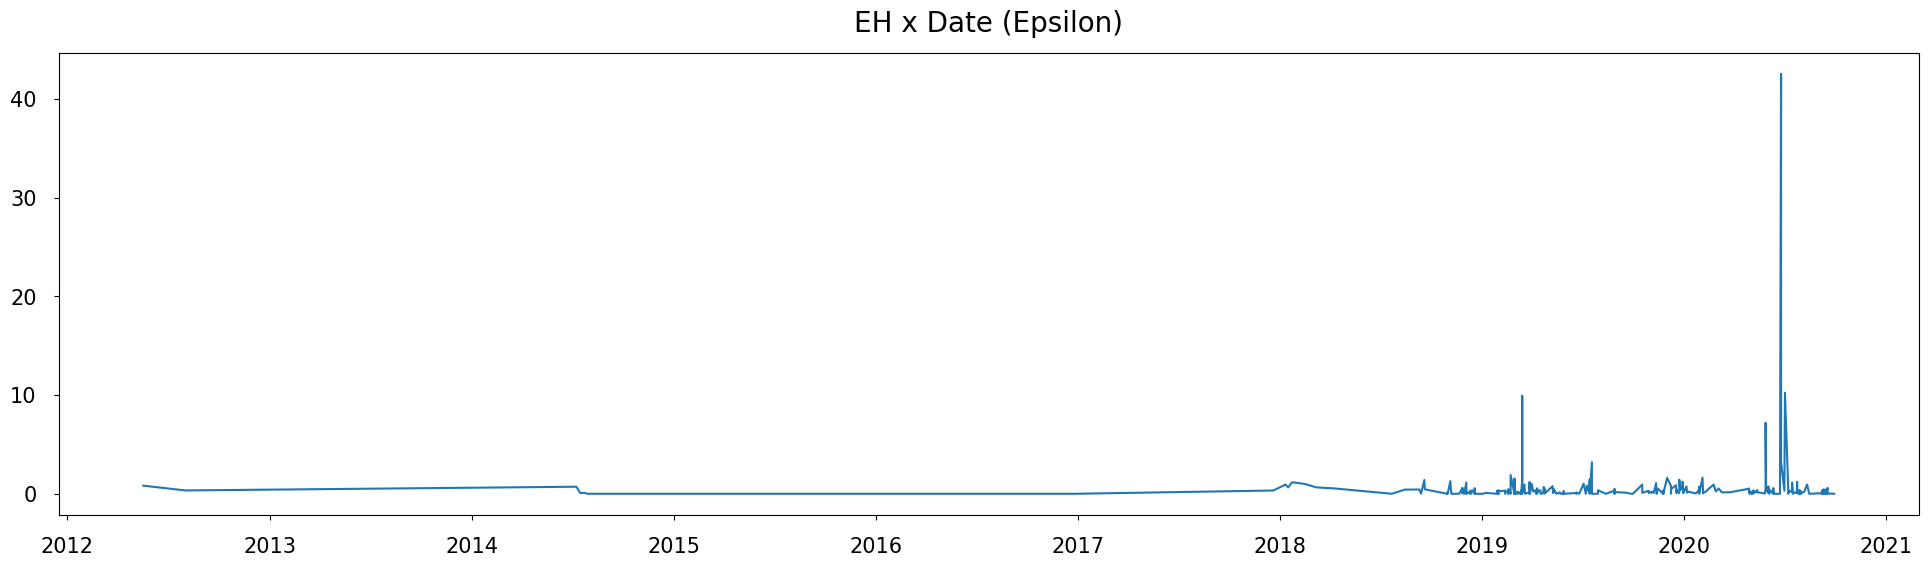

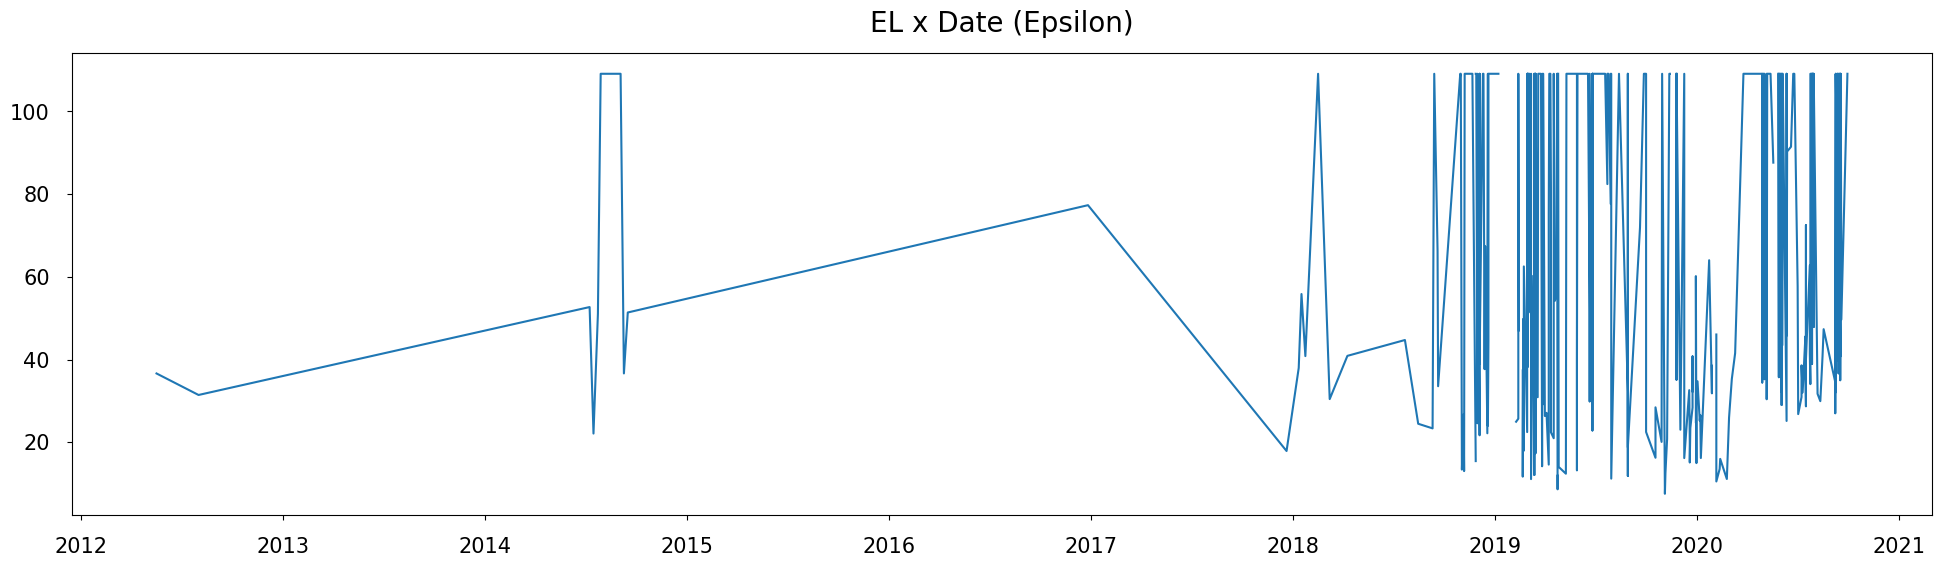

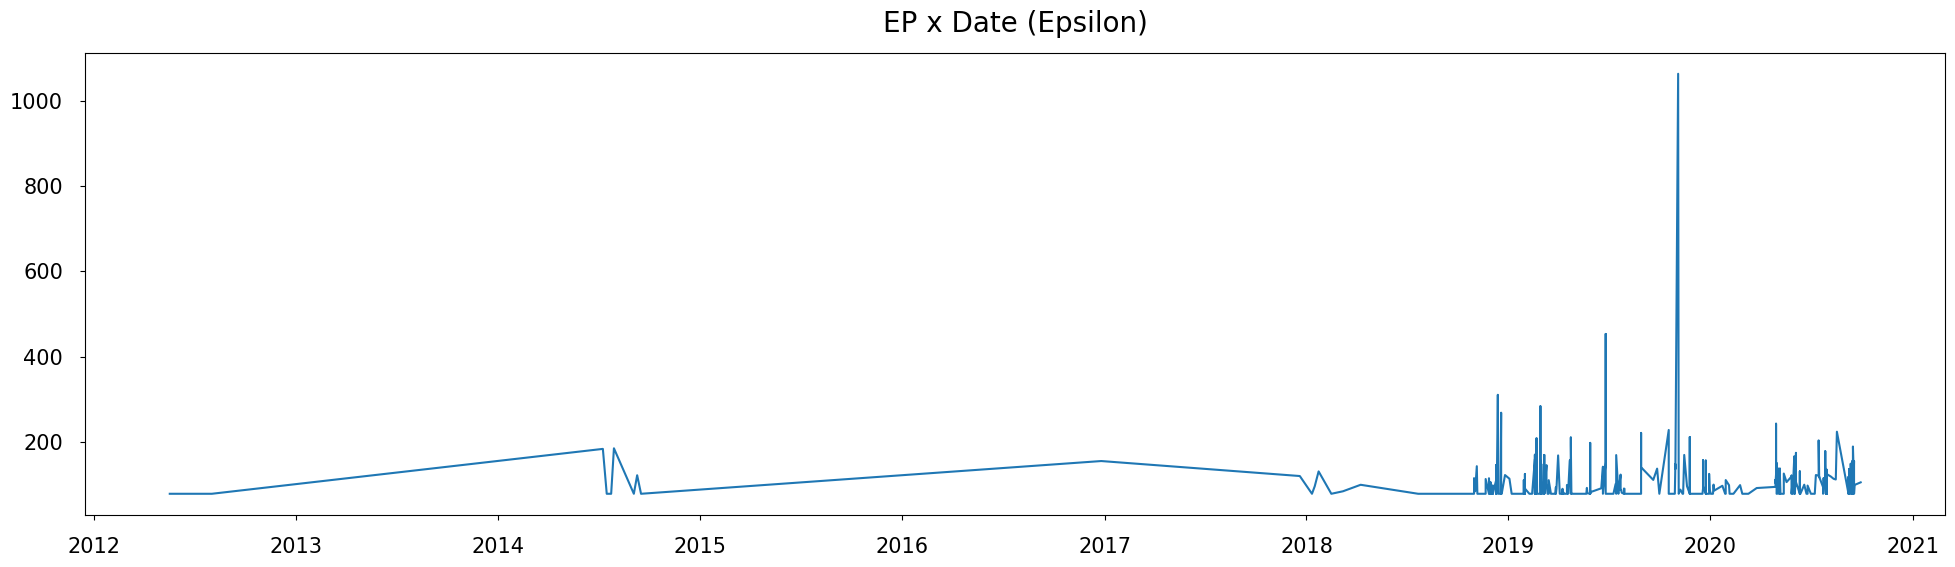

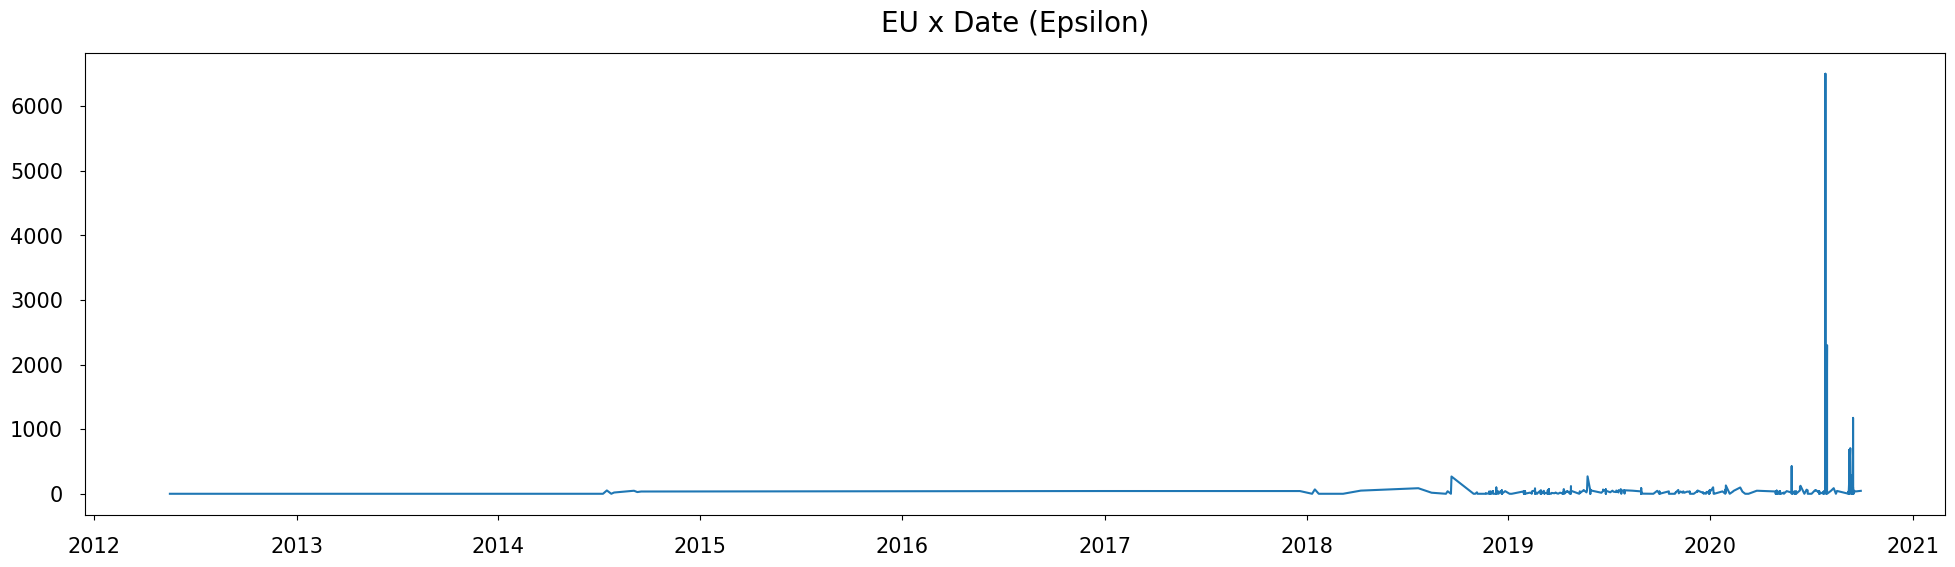

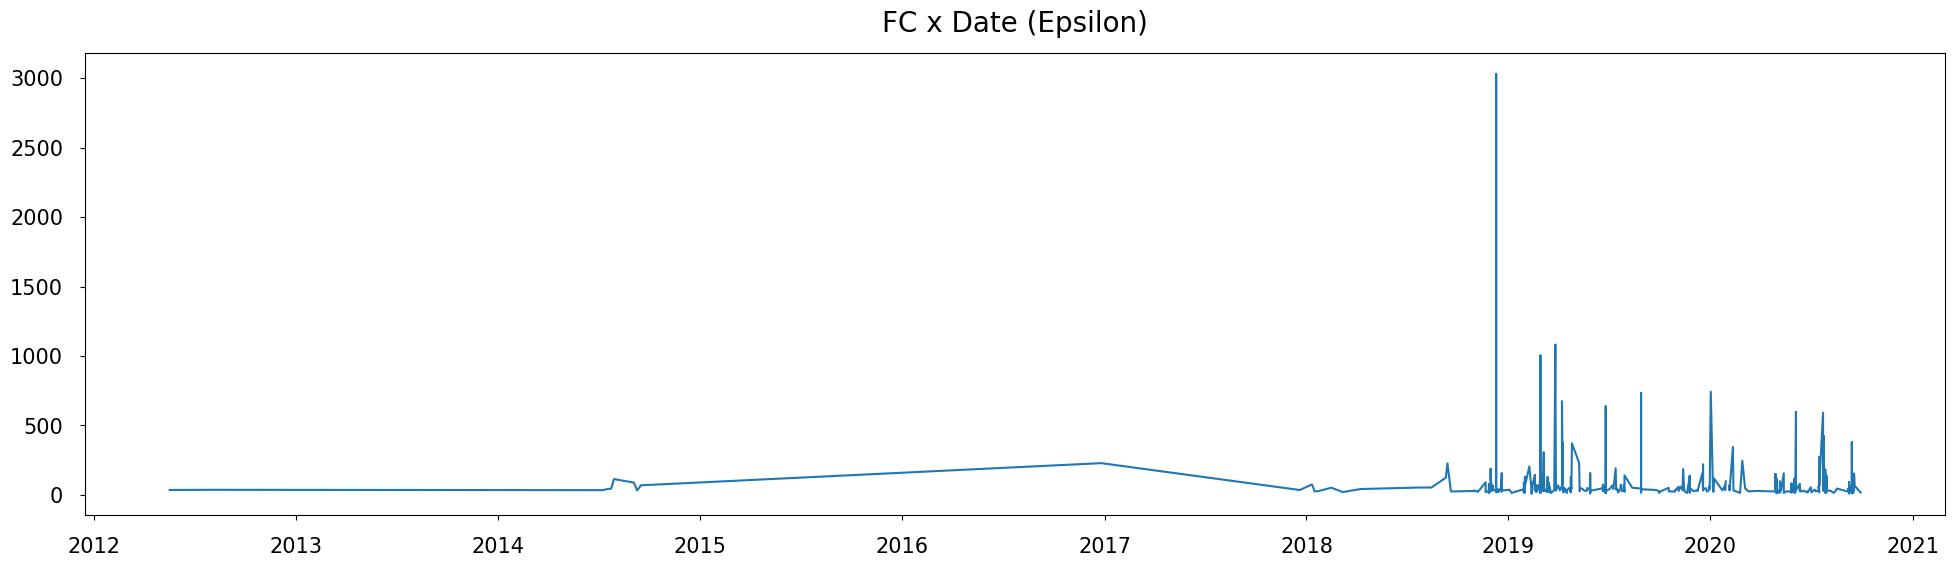

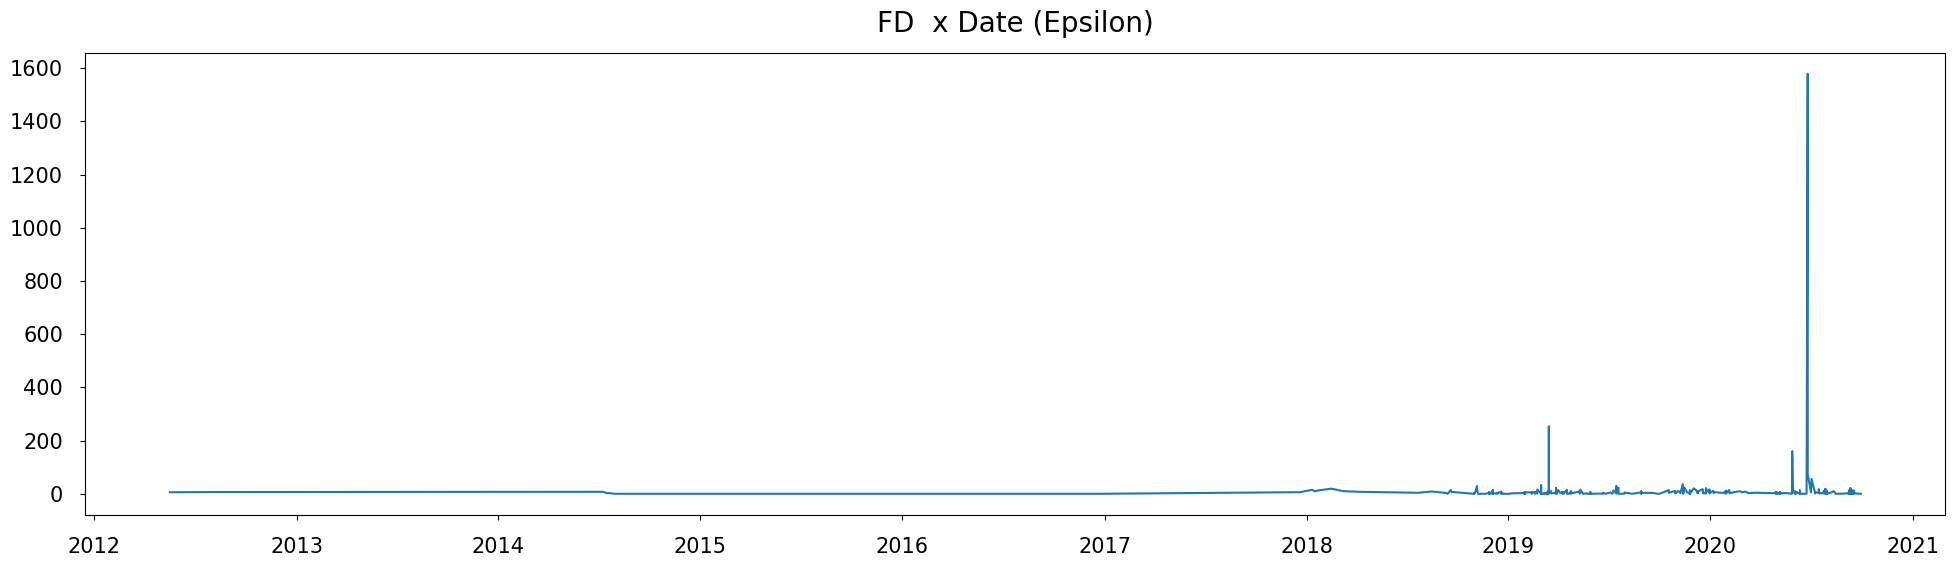

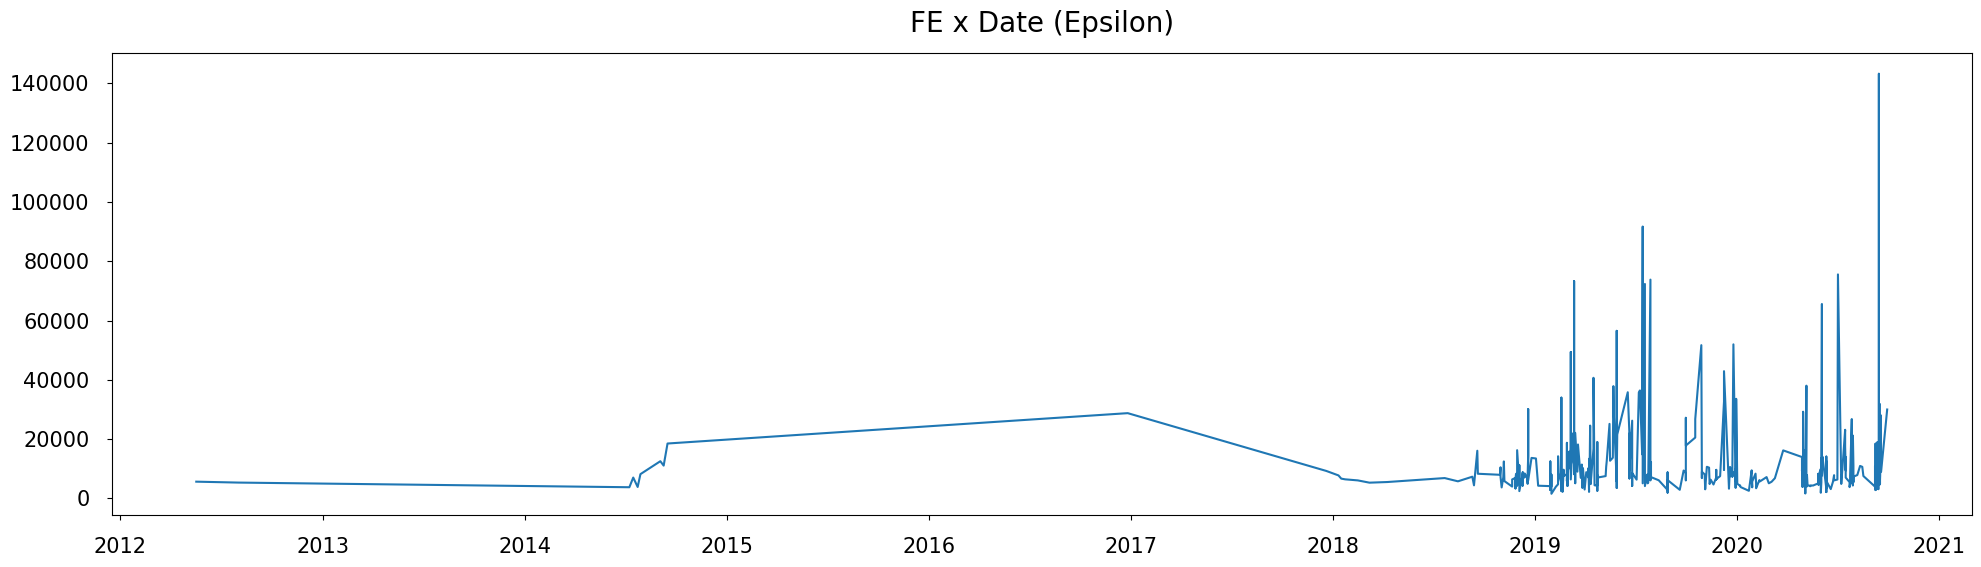

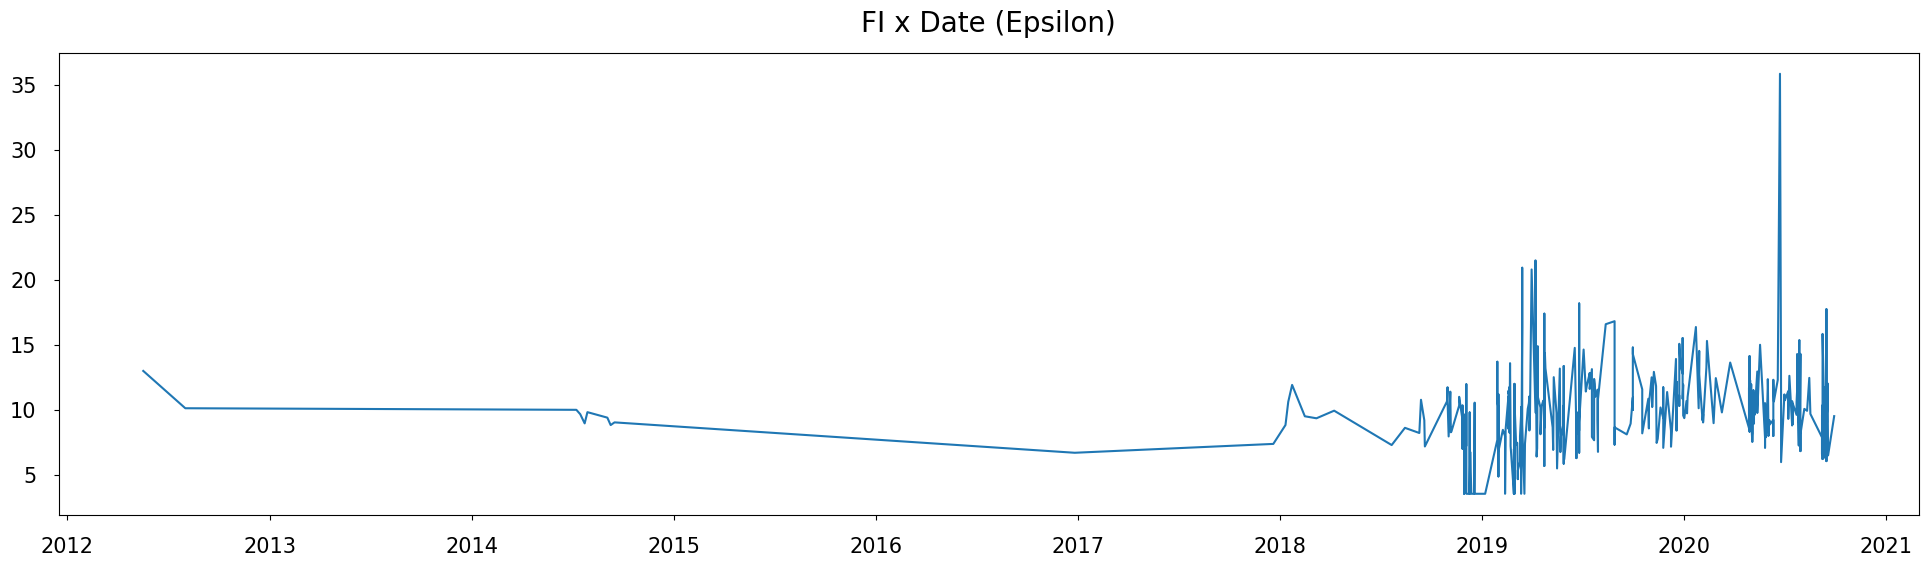

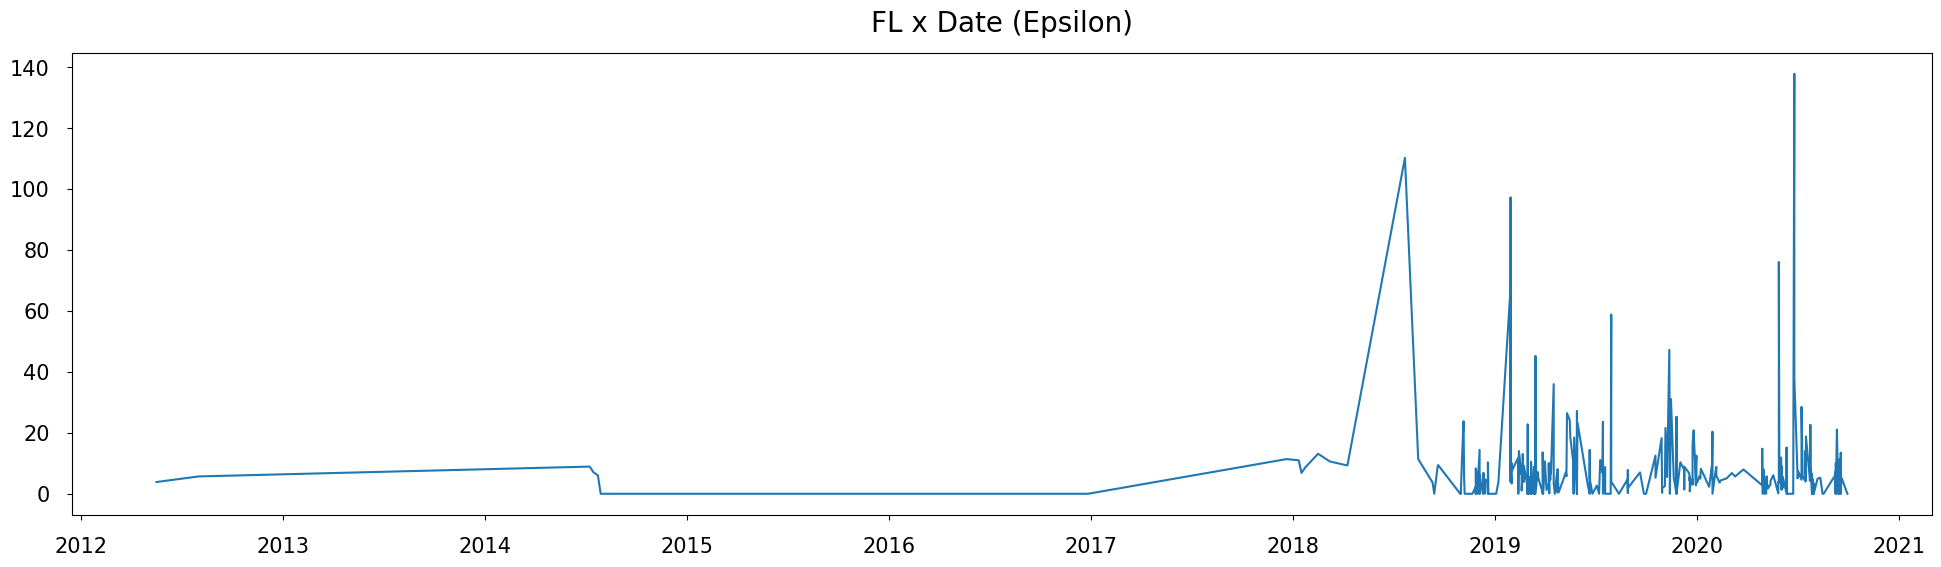

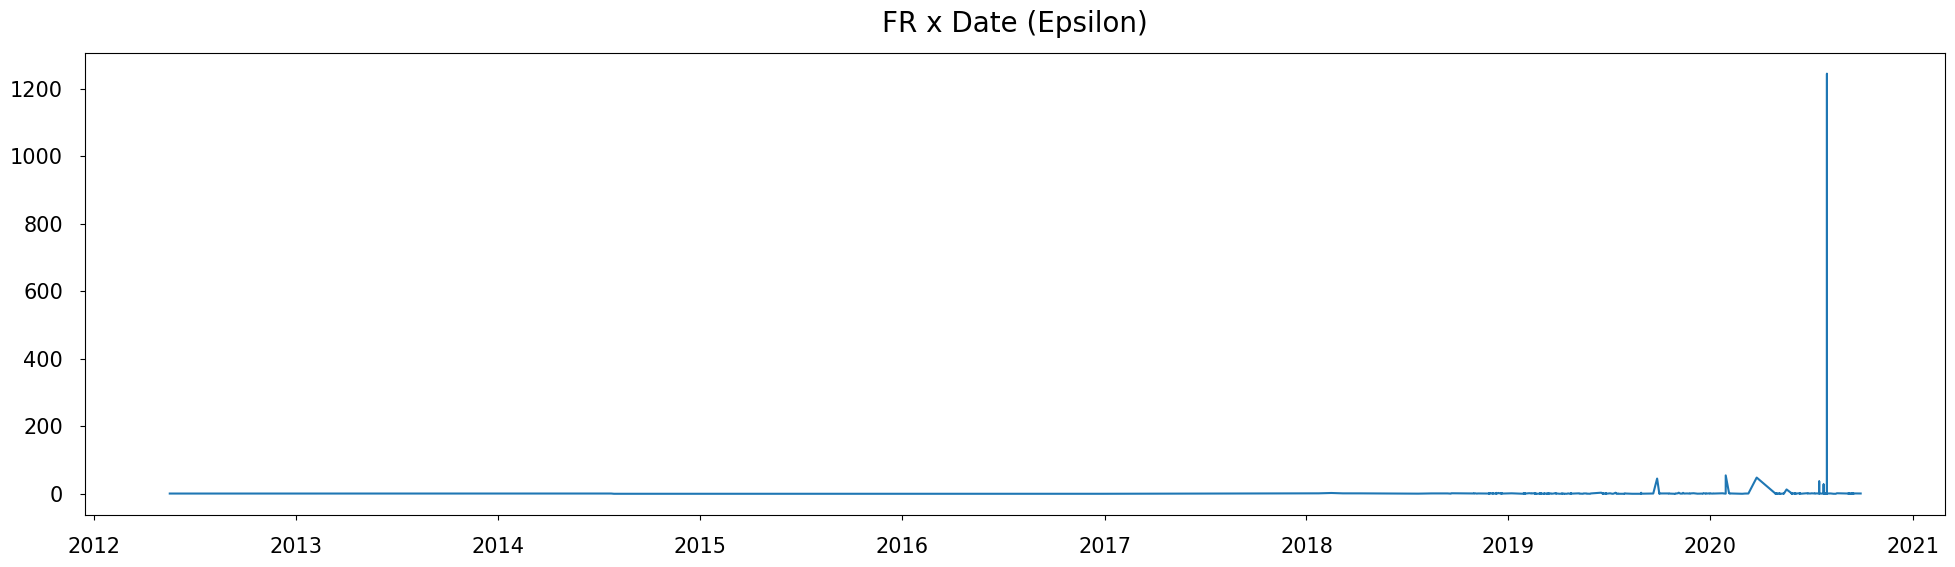

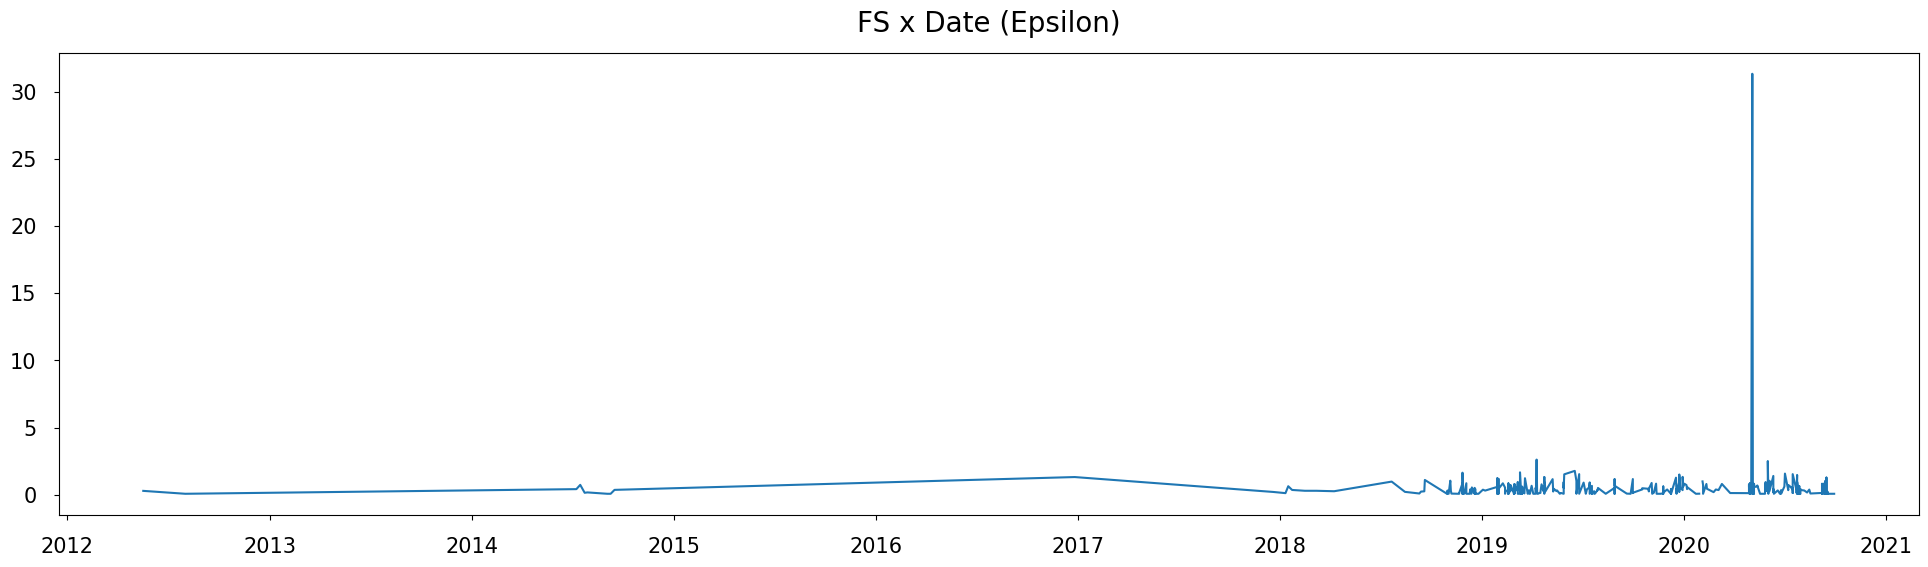

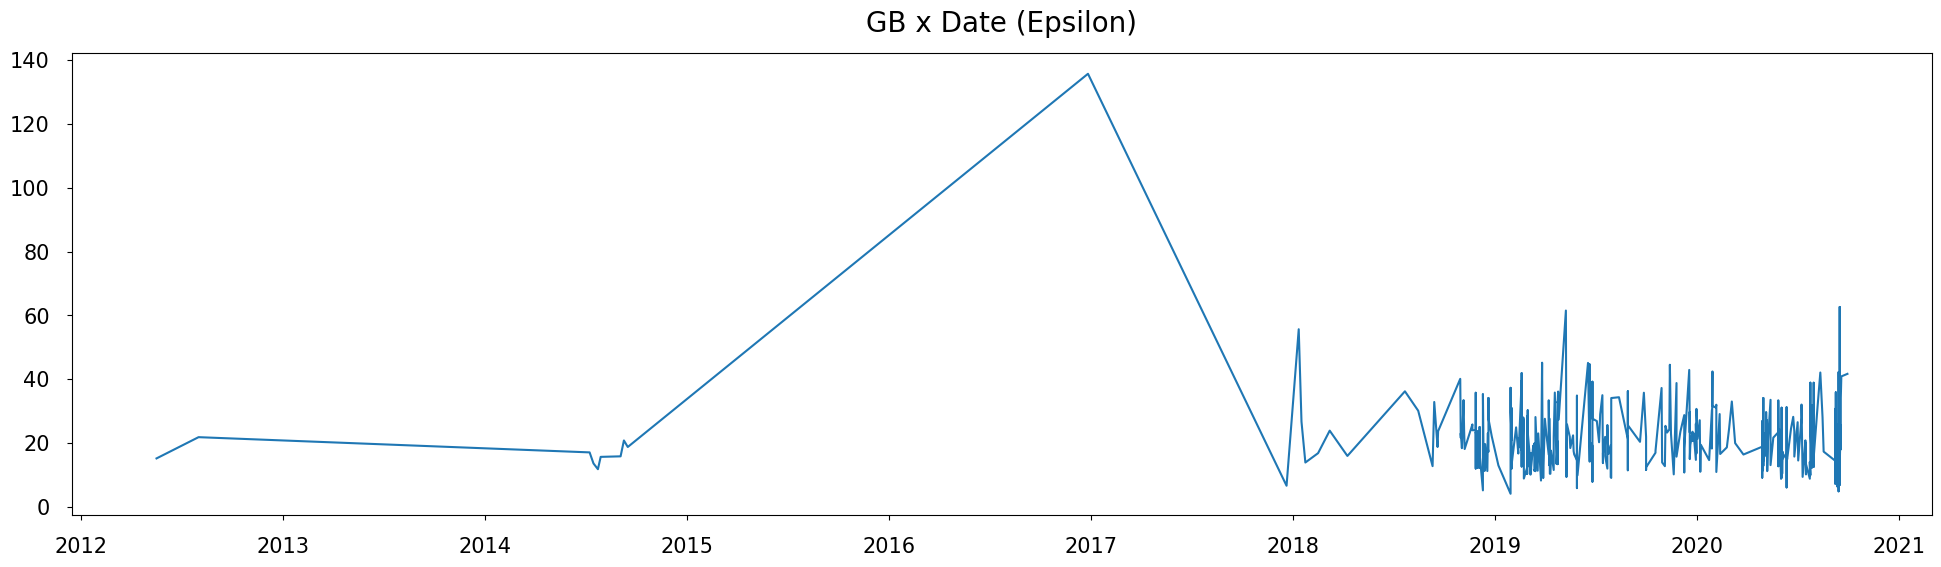

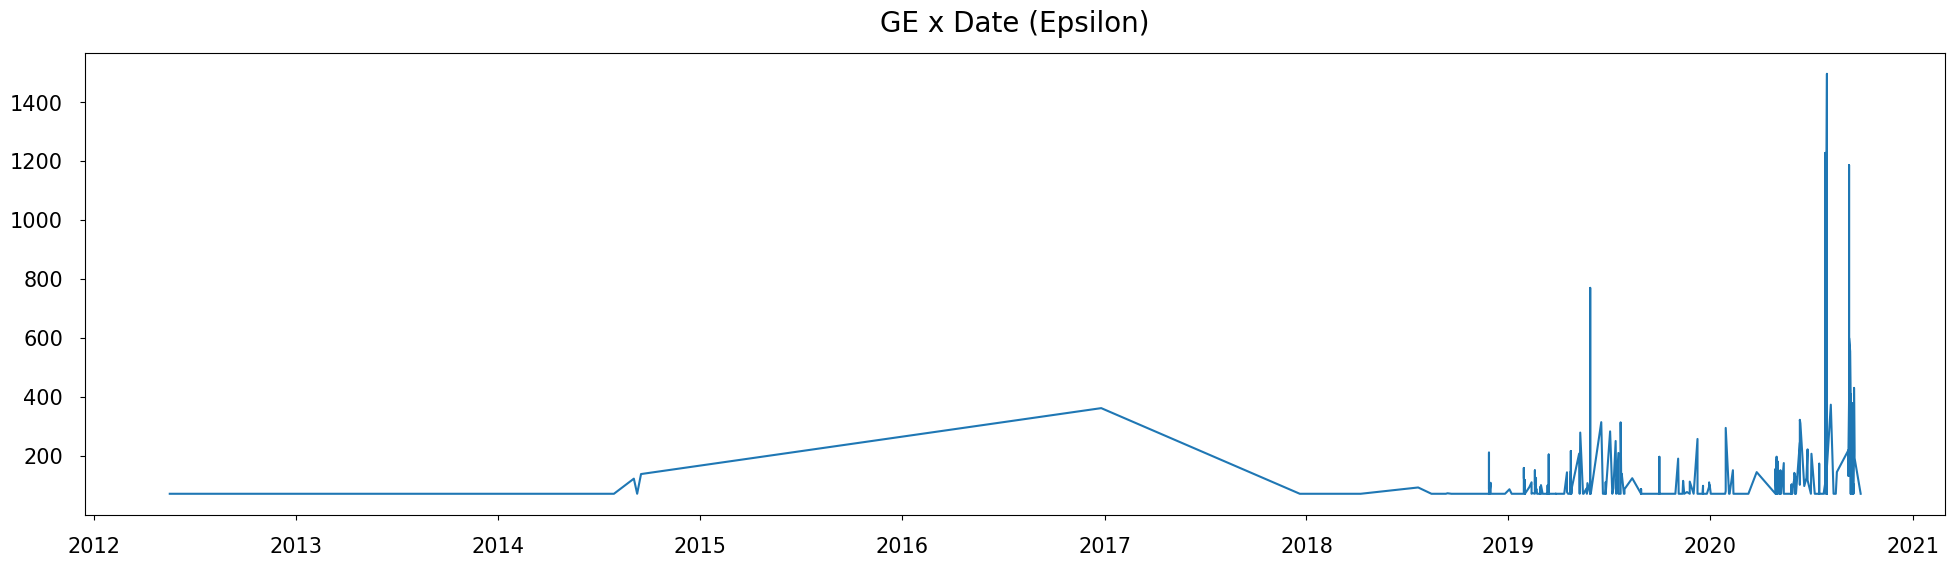

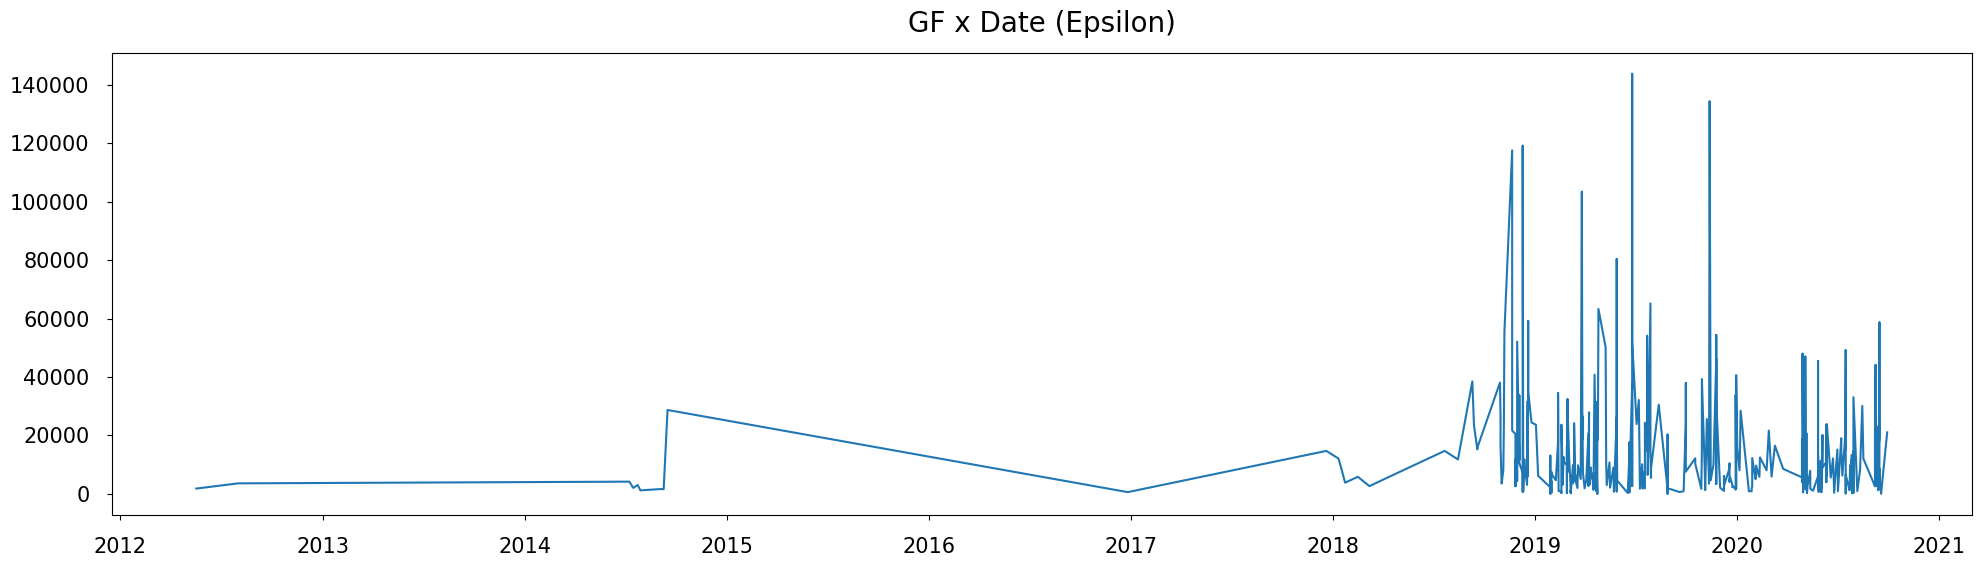

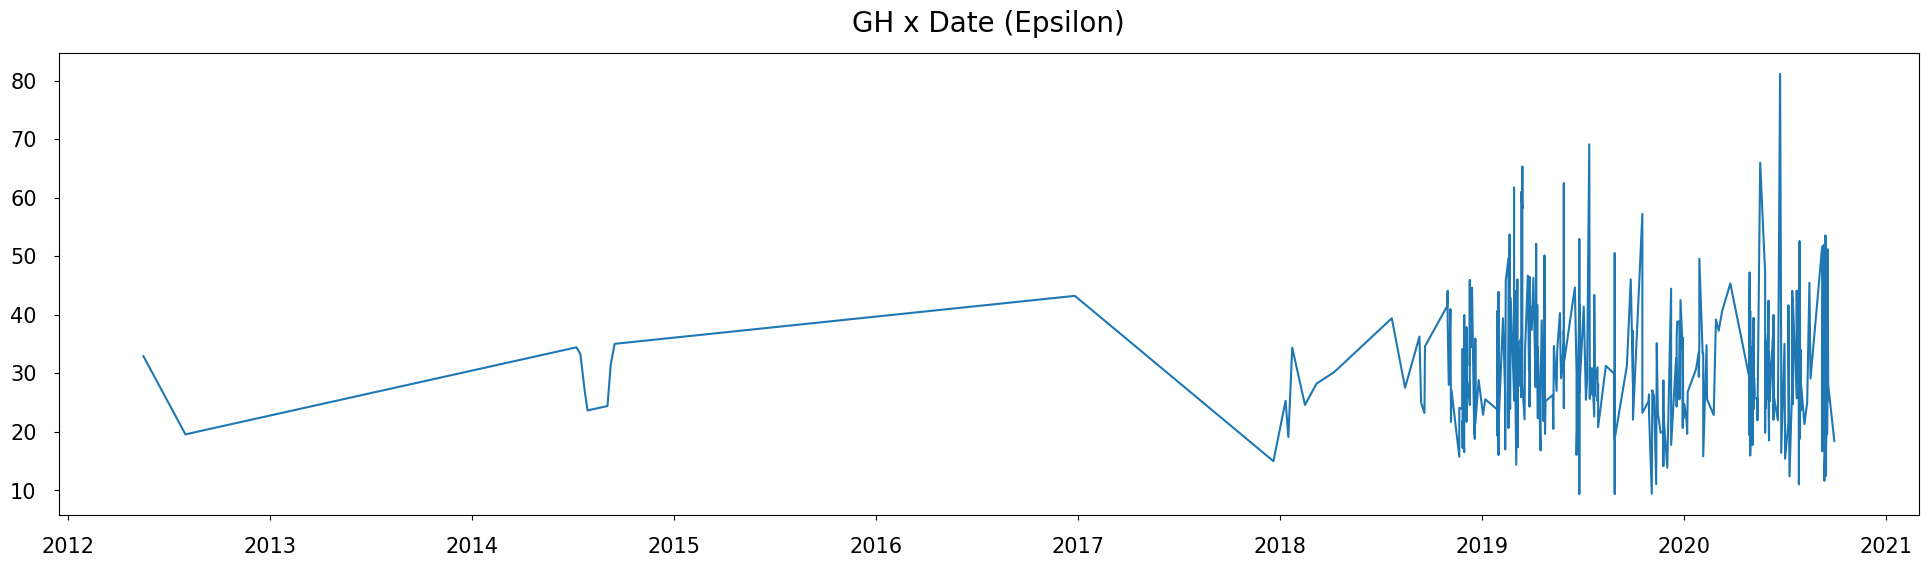

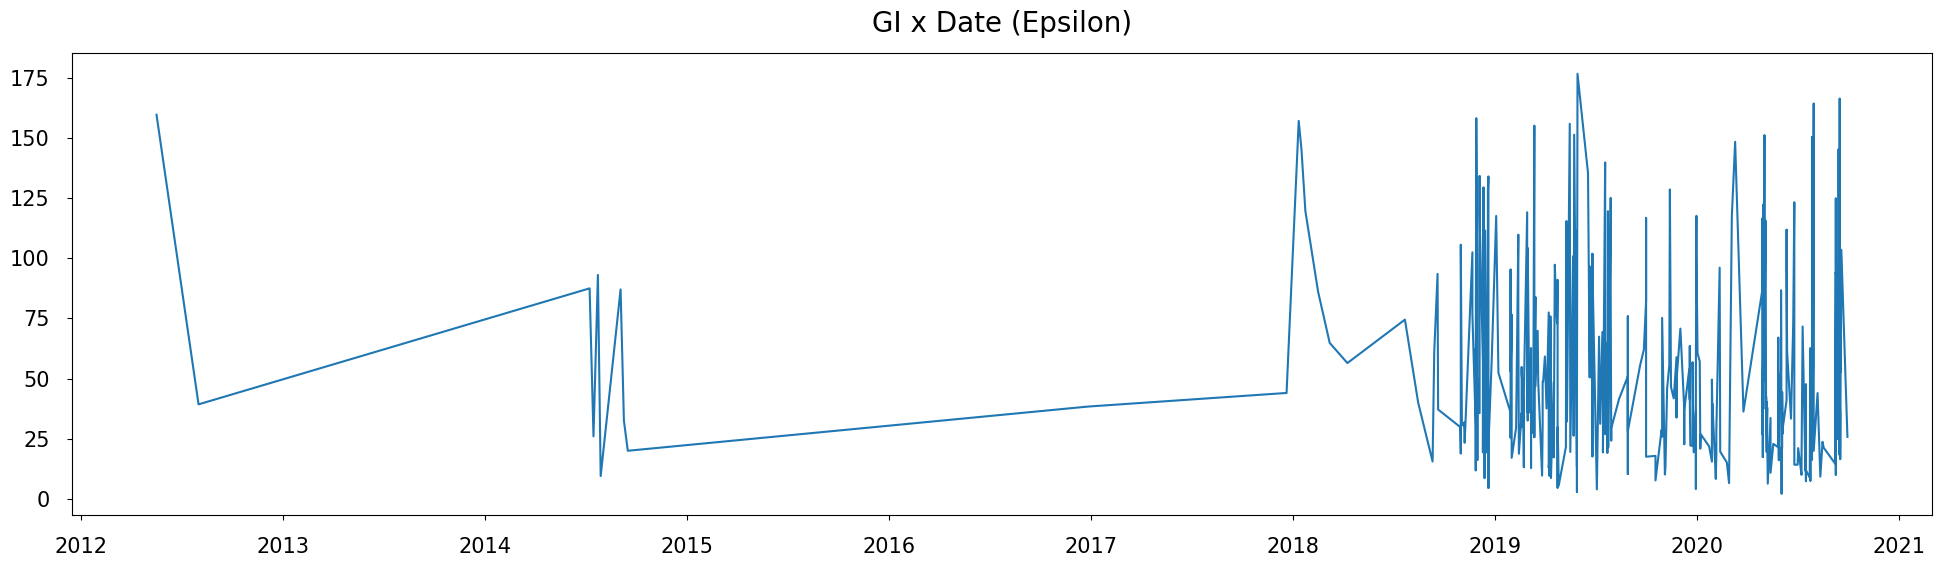

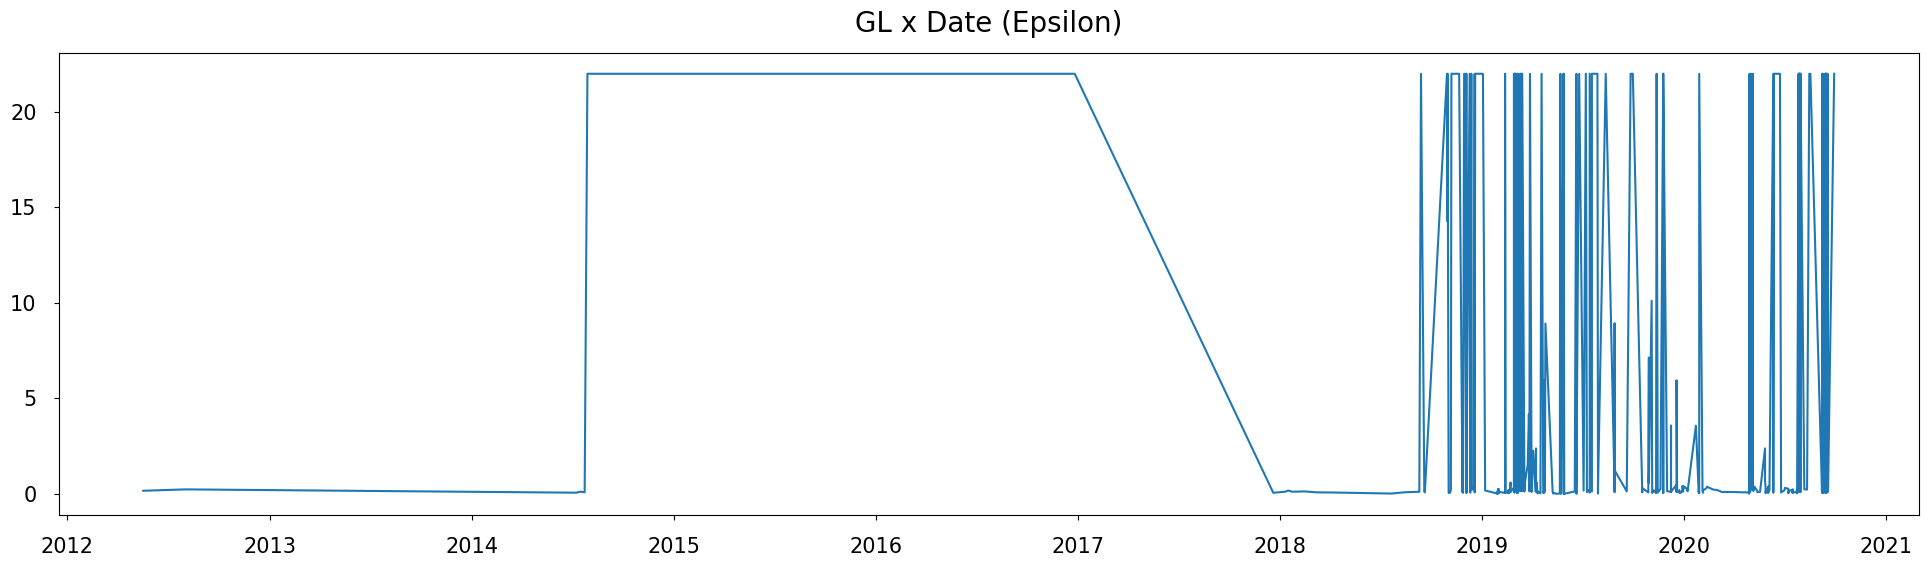

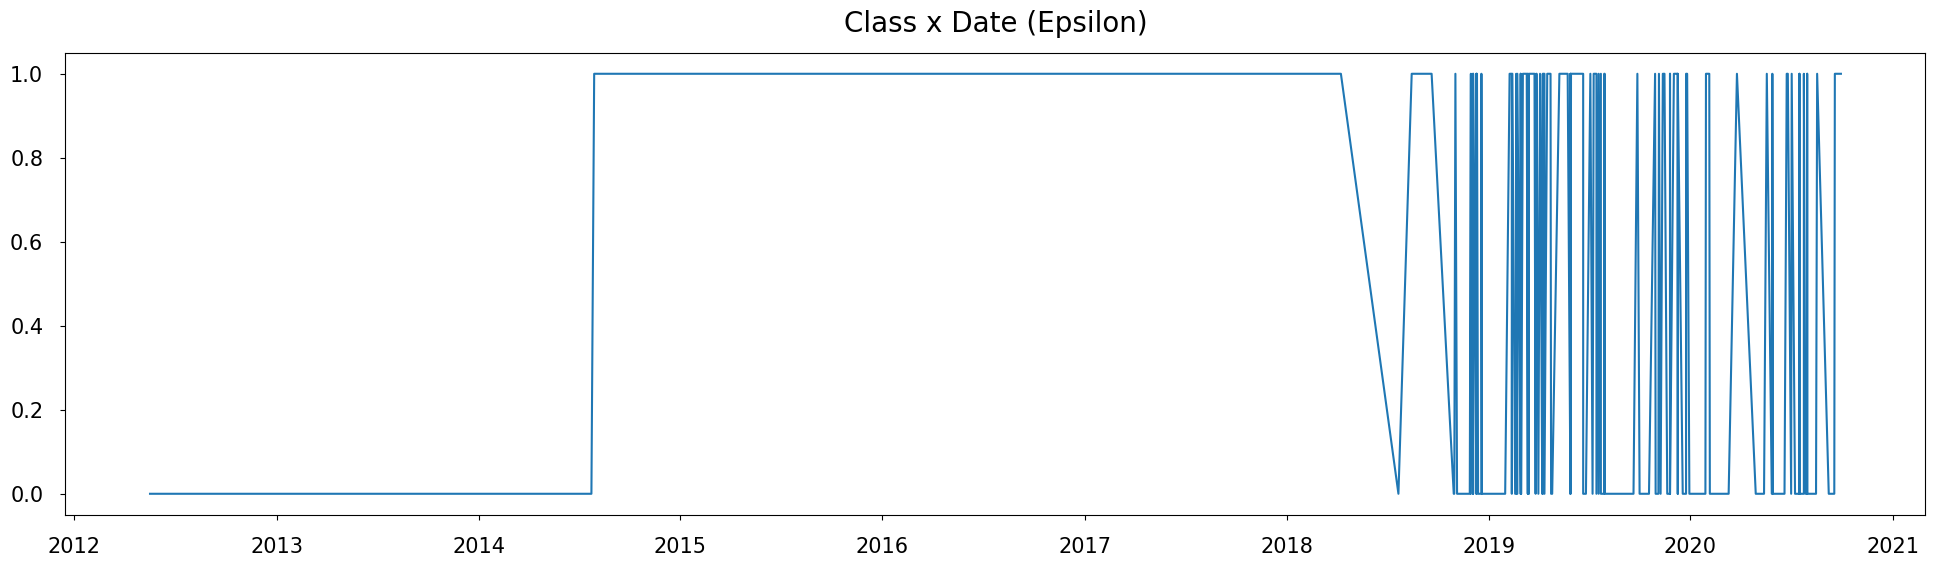

In [16]:
for column in (continuous_columns + ['Class']):
    visualize_timeseries(df=df_train, time_column='Epsilon', value_column=column)